In [1]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
#http://ipywidgets.readthedocs.io/en/latest/user_install.html
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#http://imageio.readthedocs.io/en/latest/installation.html
!pip install imageio
#https://github.com/Zulko/moviepy
!pip install moviepy

/bin/sh: apt-get: command not found
/bin/sh: pip: command not found
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
/bin/sh: pip: command not found
/bin/sh: pip: command not found


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import pickle
import glob
from ipywidgets import interact, interactive, fixed
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

読み込みファイルの指定

In [32]:
img_dir = "../Google ドライブ/test_img/"
img1 = img_dir+"test_img9.png"
img2 = img_dir+"test_img8.png"
video = img_dir+"test6.mp4"

...


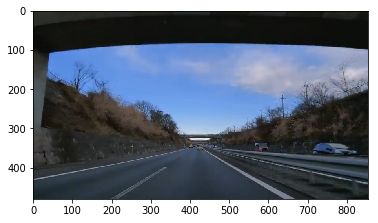

In [3]:
img= cv2.imread(img1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) #array to 2Dfigure
print('...')

### 歪みの補正処理

In [4]:
# undistort image using camera calibration matrix from above
def undistort(img):
    '''
    レンズの歪み修正
    '''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def unwarp(img, src, dst):
    '''
    車線の透視変換
    http://nobotta.dazoo.ne.jp/blog/?p=479
    '''
    img_size=(img.shape[1],img.shape[0])

    #変換行列を作成
    M = cv2.getPerspectiveTransform(src, dst)
    #変換後→変換元の変換行列の作成
    Minv = cv2.getPerspectiveTransform(dst, src)

    #図形変換処理
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,M,Minv
print('...')

...


In [5]:
global left_fit_prev   
global right_fit_prev
global set_prev

#TODO レンズの歪み計算はレンズが無いので割愛
#レンズの歪み値
global mtx
global dist
mtx = np.array([[  7.52615043e+03,   0.00000000e+00,   4.69192259e+02],
                          [  0.00000000e+00,   7.86343209e+03,   2.73078310e+02],
                         [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
dist= np.array([[ -9.92700922e+00,  -3.60394577e+02,   1.74434101e-01,
                              2.34383103e-01,   3.07597893e+04]])
#レンズの歪み補正
undist = cv2.undistort(img, mtx, dist, None, mtx)

#変換元座標設定
global src
global dst
img_size=(img.shape[1],img.shape[0])
# src= np.float32( 
#                   [[585. /1280.*img_size[0], 455./720.*img_size[1]],
#                   [705. /1280.*img_size[0], 455./720.*img_size[1]],
#                   [1120./1280.*img_size[0], 720./720.*img_size[1]],
#                   [190. /1280.*img_size[0], 720./720.*img_size[1]]])

src= np.float32( 
                  [[595. /1280.*img_size[0], 540./720.*img_size[1]],
                  [665. /1280.*img_size[0], 540./720.*img_size[1]],
                  [990./1280.*img_size[0], 720./720.*img_size[1]],
                  [290. /1280.*img_size[0], 720./720.*img_size[1]]])

# src= np.float32([[600. /1280.*img_size[0], 480./720.*img_size[1]],[680. /1280.*img_size[0], 480./720.*img_size[1]],[1120./1280.*img_size[0], 694./720.*img_size[1]],[190. /1280.*img_size[0], 694./720.*img_size[1]]])

#変換後座標設定
dst= np.float32([[280. /1280.*img_size[0], 0./720.*img_size[1]],
                  [1000./1280.*img_size[0], 0./720.*img_size[1]],
                  [1000./1280.*img_size[0], 720./720.*img_size[1]],
                  [280. /1280.*img_size[0], 720./720.*img_size[1]]])
#車線の透視変換
warped,M,Minv = unwarp(undist, src, dst)
# warped,M,Minv = unwarp(img)
print('...')

...


### 車線の透視変換イメージ

...


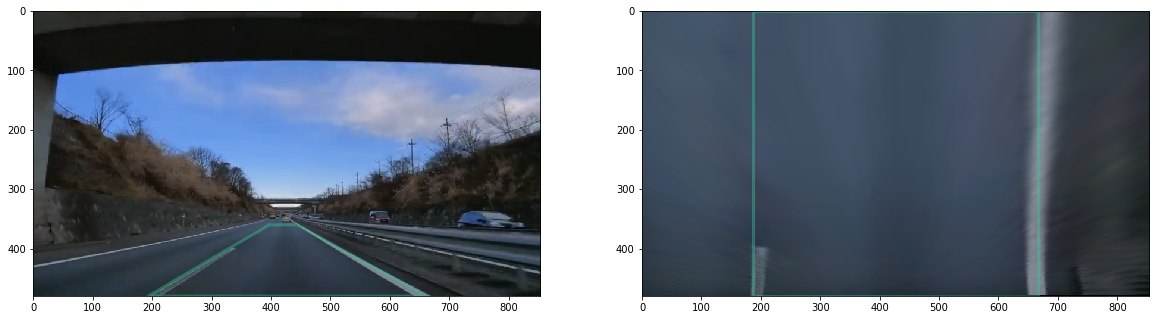

In [6]:
img_size=(img.shape[1],img.shape[0])
#変換元座標設定

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.imshow(img)
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ax2.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.imshow(warped)
print('...')

### 白線の検出

In [7]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(166, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)#RGB→HLS
    hls_l = hls[:,:,1]#HLSのL（彩度）のみを抽出
    hls_l = hls_l*(255/np.max(hls_l))#HLS彩度におけるRGB白の比率
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)#hls_lと同じ大きさのゼロ埋めの配列を生成
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1#閾値（thresh）に当てはまるもの（白色）にフラグを立てる
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


パラメータの調整

In [8]:
@interact(min_thresh=(0,255),max_thresh=(0,255))
def update(min_thresh=166, max_thresh=255):
    exampleImg_LThresh = hls_lthresh(warped, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax) = plt.subplots(2, 2, figsize=(18,10))
    f.subplots_adjust(hspace = .2, wspace=.002)
    ax = ax.ravel()
    ax[0].imshow(warped)
    ax[0].set_title('Unwarped Image', fontsize=30)
    ax[1].imshow(exampleImg_LThresh, cmap='gray')
    ax[1].set_title('White Line', fontsize=30)
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    ax[2].imshow(hls)
    ax[2].set_title('HLS', fontsize=30)
    ax[3].imshow(hls[:,:,1], cmap='gray')
    ax[3].set_title('HLS L-Channel', fontsize=30)
print('...')

interactive(children=(IntSlider(value=166, description='min_thresh', max=255), IntSlider(value=255, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


### 黄色い線の検出

In [9]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(194,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)#RGB→Lab
    lab_b = lab[:,:,2]#Lab色空間のb成分（黄色）のみ抽出
    
    if np.max(lab_b) > 175:# don't normalize if there are no yellows in the image必ず黄色があるならifいらない
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)#ゼロ埋めの配列を生成
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1#閾値（thresh）に当てはまるもの（黄色）にフラグを立てる
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


パラメータの調整

In [10]:
@interact(min_b_thresh=(0,255), max_b_thresh=(0,255))
def update(min_b_thresh=194, max_b_thresh=255):
    exampleImg_LBThresh = lab_bthresh(warped, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax) = plt.subplots(2, 2, figsize=(18,10))
    f.subplots_adjust(hspace = .2, wspace=.002)
    ax = ax.ravel()
    ax[0].imshow(warped)
    ax[0].set_title('Unwarped Image', fontsize=30)
    ax[1].imshow(exampleImg_LBThresh, cmap='gray')
    ax[1].set_title('Yellow Line', fontsize=30)
    lab = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)#RGB→Lab
    ax[2].imshow(lab)
    ax[2].set_title('LAB', fontsize=30)
    ax[3].imshow(lab[:,:,2], cmap='gray')
    ax[3].set_title('LAB B-channel', fontsize=30)
print('...')

interactive(children=(IntSlider(value=194, description='min_b_thresh', max=255), IntSlider(value=255, description='max_b_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


### 画像処理の流れ

...


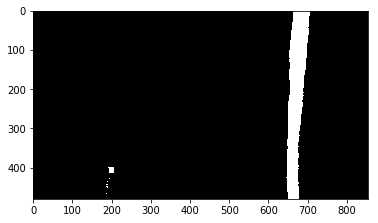

In [11]:
def pipeline(img):
    # レンズの歪み補正
    img_undistort = undistort(img)
    
    # 車線の透視変換
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # HLS L-channel を使用した白線検知
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel を使用した黄色線検知
    img_BThresh = lab_bthresh(img_unwarp)
    
    # 白線と黄色線画像の結合
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv
plt.imshow(pipeline(img)[0],  cmap='gray')
print('...')

...


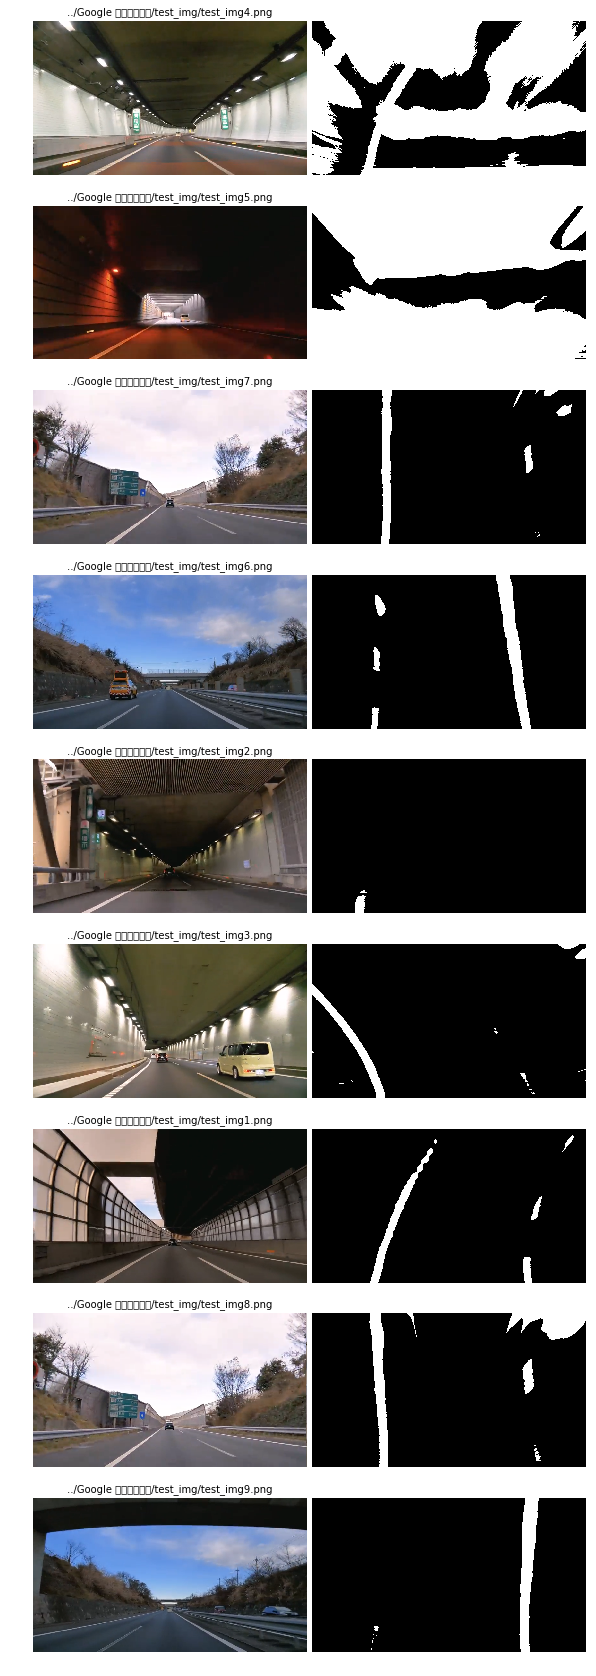

In [12]:
# テスト画像を出力してみる
images = glob.glob(img_dir+'*.png')
                                          
# 出力の設定
fig, axs = plt.subplots(len(images),2, figsize=(10, 30))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].set_title(image, fontsize=10)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
print('...')

In [13]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # 画像下半分のヒストグラムを抽出
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    ## 画像の左右の指定した範囲からヒストグラムのピークを見つける（範囲は自分で適当な値を指定）
    # その位置が車線の起点となる
    leftx_L_point = np.int(histogram.shape[0]/12*1)
    leftx_R_point = np.int(histogram.shape[0]/12*5)
    rightx_L_point = np.int(histogram.shape[0]/12*7)
    rightx_R_point = np.int(histogram.shape[0]/12*11)

    leftx_current = np.argmax(histogram[leftx_L_point:leftx_R_point]) + leftx_L_point
    rightx_current = np.argmax(histogram[rightx_L_point:rightx_R_point]) + rightx_L_point

    # 画像を分割する個数
    nwindows = 10
    # 分割する高さを算出する
    window_height = np.int(img.shape[0]/nwindows)
    # イメージ内のすべての非ゼロピクセル（フラグ）の位置を特定する
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # ウィンドウの幅のマージンを設定する
    margin = 80
    # ウィンドウの中心を設定するための最小ピクセル数
    minpix = 40
    # 左右のレーンピクセルインデックスを受け取るリストの初期化
    left_lane_inds = []
    right_lane_inds = []
    # 視覚化のための矩形リスト
    rectangle_data = []

    # 画像の分割を1ウィンドウずつステップ実行する
    for window in range(nwindows):
        # 分割ウィンドウの境界の座標
        win_y_low = img.shape[0] - (window+1)*window_height#ウィンドウ上端座標
        win_y_high = img.shape[0] - window*window_height#下
        win_xleft_low = leftx_current - margin#左車線左端座標
        win_xleft_high = leftx_current + margin#左車線右
        win_xright_low = rightx_current - margin#右車線左
        win_xright_high = rightx_current + margin#右車線右
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # ウィンドウ内の非ゼロピクセル（フラグ）の座標を特定する
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # 結果をリストに追加
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # minpix以上のピクセルを見つけた場合は、平均位置で次のウィンドウを表示し直す
        if len(good_left_inds) > minpix:#左車線
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:#右車線
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # インデックスの配列を連結する
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # 左右のピクセル位置を抽出する
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # ２項式での回帰分析を行う
    if len(leftx) != 0:
        try:
            left_fit = np.polyfit(lefty, leftx, 2)
        except:
            left_fit = None
    if len(rightx) != 0:
        try:
            right_fit = np.polyfit(righty, rightx, 2)
        except:
            right_fit = None
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

...


In [14]:
# サンプル画像取り込み
exampleImg = cv2.imread(img1)
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)

### 画像からヒストグラムのピークを検索する範囲のイメージ

In [15]:
img_size = [exampleImg_bin.shape[0], exampleImg_bin.shape[1]]
@interact(pnt1=(0,6), pnt2=(0,6), pnt3=(7,12), pnt4=(7,12))
def slice(pnt1=1, pnt2=5, pnt3
          =7, pnt4=11):
    
    src = np.float32( 
                        [[pnt1/12*img_size[1], 0],
                        [pnt2/12*img_size[1], 0],
                        [pnt2/12*img_size[1], img_size[0]],
                        [pnt1/12*img_size[1], img_size[0]]])
    dst = np.float32(
                        [[pnt3/12*img_size[1],0],
                        [pnt4/12*img_size[1], 0],
                        [pnt4/12*img_size[1], img_size[0]],
                        [pnt3/12*img_size[1], img_size[0]]])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax2.plot(x, y, color='#FFFFFF', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
    y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
    ax2.plot(x, y, color='#FFFFFF', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.imshow(exampleImg)
    ax2.imshow(exampleImg_bin,  cmap='gray')

interactive(children=(IntSlider(value=1, description='pnt1', max=6), IntSlider(value=5, description='pnt2', max=6), IntSlider(value=7, description='pnt3', max=12, min=7), IntSlider(value=11, description='pnt4', max=12, min=7), Output()), _dom_classes=('widget-interact',))

### サンプル画像で結果を視覚化する

...


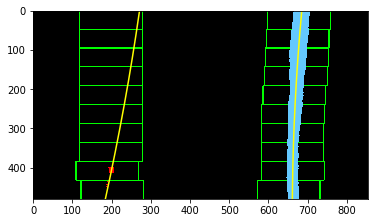

In [16]:
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = np.poly1d(right_fit)(h)#↑の式と同意
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)
rectangles = visualization_data[0]
histogram = visualization_data[1]

# 可視化する出力イメージを作成（バイナリの白黒画像からRGB画像の白黒へ）
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# linspace（等差数列）でx座標をnumpy配列にプロットする
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
#回帰分析からx座標を抽出
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = np.poly1d(right_fit)(ploty)#↑の式と同意
for rect in rectangles:
# 可視化画像上にウィンドウを描画する
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
print('...')

...


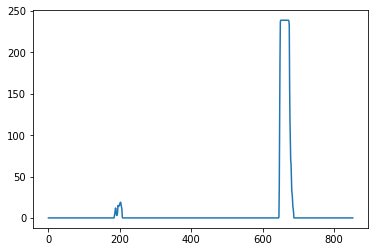

In [17]:
# ヒストグラムの描画
plt.plot(histogram)
print('...')

### 直前のフレームからレーンを認識させる

In [18]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# 1つのビデオフレームから次のビデオフレームに車線が大きく変化しないと思われる場合に使用
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    #回帰分析の曲線範囲（± margin）に収まる車線を検出
    left_lane_inds = ((nonzerox > (np.poly1d(left_fit_prev)(nonzeroy) - margin)) & 
                      (nonzerox < (np.poly1d(left_fit_prev)(nonzeroy) + margin)))
    right_lane_inds = ((nonzerox > (np.poly1d(right_fit_prev)(nonzeroy) - margin)) & 
                       (nonzerox < (np.poly1d(right_fit_prev)(nonzeroy) + margin)))

    # 再度、左右のピクセル位置を抽出する
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # ２項式での回帰分析の更新を行う
        try:
            left_fit_new = np.polyfit(lefty, leftx, 2)
        except:
            left_fit_new = None
            
    if len(rightx) != 0:
        try:
            right_fit_new = np.polyfit(righty, rightx, 2)
        except:
            right_fit_new = None
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


(17323,)
(480, 854)
...


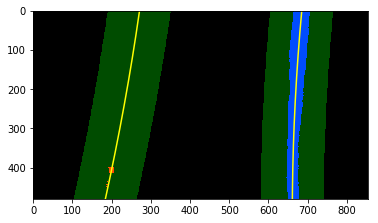

In [19]:
# visualize the result on example image
exampleImg2 = cv2.imread(img1)
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# プロットする値を２つの回帰分析から生成する
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = np.poly1d(left_fit)(ploty)
right_fitx = np.poly1d(right_fit)(ploty)
left_fitx2 = np.poly1d(left_fit2)(ploty)
right_fitx2 = np.poly1d(right_fit2)(ploty)

# 可視化する出力イメージを作成（バイナリの白黒画像からRGB画像の白黒へ）
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
# 結果を表示するための画像配列の作成（out_imgと重ねるため）
window_img = np.zeros_like(out_img)

# 左右の車線にカラーを設定
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]
print(left_lane_inds2.shape)
print(exampleImg2_bin.shape)

# 検索範囲（OLD FIT）を示すポリゴンを生成する
# また、cv2.fillPoly（）を使用し、新しい形に再作成
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# 車線を描画する
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
print('...')

### 曲率半径とレーン中央からの距離

In [20]:
# レーン中心からの曲率半径および距離を求める
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # ピクセルからメートルへの変換
    ym_per_pix = 8/100 # y軸の画素あたりのメートル、車線は10ft = 3.048 m
    xm_per_pix = 3.5/450 # x軸の画素あたりのメートル, 車線の幅 12 ft = 3.7 m
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # 曲率半径を求めるy値を定義する
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)# 画像の最下部に対応する最大y値を選択
    
    # イメージ内のすべての非ゼロピクセル（フラグ）の位置を特定する
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 再度、左右のピクセル位置を抽出する
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # メートルに変換して回帰分析を行う
        try:
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        except:
            left_fit_cr = 0
        try:
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        except:
            right_fit_cr = 0
        # 曲率半径を計算する（曲率半径を求める公式に当てはめている）
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # 中心からの距離は、画像のl_fitとr_fitの平均との差
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = np.poly1d(r_fit)(h)
        r_fit_x_int = np.poly1d(l_fit)(h)
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


サンプル画像の曲率半径と中心からの距離を計算してみる

In [21]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 5160.024696580903 m, 4651.419303291669 m
Distance from lane center for example: 0.0359819150560671 m


### 検出されたイメージを元の画像に描画する

In [22]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # 結果を描画する画像の作成
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# バイナリイメージの範囲を指定する
    left_fitx = np.poly1d(l_fit)(ploty)
    right_fitx = np.poly1d(r_fit)(ploty)

    # cv2.fillPoly()が使用できる形に整形し直す
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # 歪んだカラー画像にレーンを描画する
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # 透視変換をした際に作成した逆透視変換行列（Minv）を使用して、元の画像空間に戻します。
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # 結果を元の画像を合成する
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

...


検出されたレーンをサンプル画像に描画

...


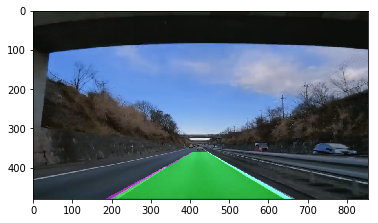

In [23]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

### 曲率半径と中心からの距離を描画する

In [24]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


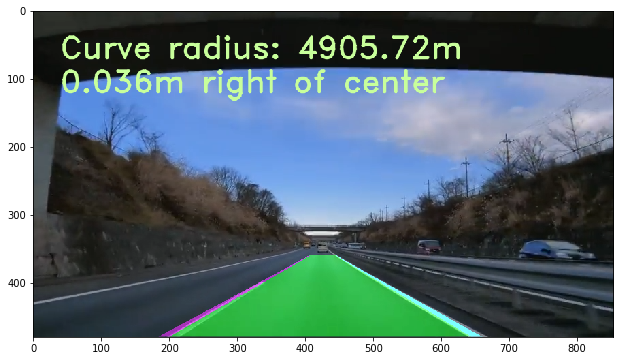

In [25]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)#curv_radは左右車線の平均値
plt.subplots(1, 1, figsize=(12,6))
plt.imshow(exampleImg_out2)
print('...')

In [26]:
exampleImg_out2.shape

(480, 854, 3)

### データを保存するためのクラスを定義する

In [27]:
# 各行検出の特性を受け取るクラスを定義する
class Line():
    def __init__(self):
        # 最後の反復でラインが検出されたか？
        self.detected = False  
        # 最後n個のフィットした車線のx値
        self.recent_xfitted = [] 
        #最後n回の反復にわたって平均化された線x
        self.bestx = None     
        #最後n回の反復で平均化された線形回帰係数
        self.best_fit = None  
        #最新のフィットの線形回帰係数
        self.current_fit = []  
        #両車線からの曲率半径
        self.radius_of_curvature = None 
        #ラインからの車両センターの距離
        self.line_base_pos = None 
        #最初と最後の適合係数の差
        self.diffs = np.array([0,0,0], dtype='float') 
        #検出画素数
        self.px_count = None
    def add_fit(self, fit, inds):
        print("__________current_fit_before : ",len(self.current_fit))
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # 既に線形回帰を行っている場合, 新しい係数との比較
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or  self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # 適切な係数でないので中止、current_fitに適切なものがあれば取得する
                self.detected = False
                # 最も古いものを捨てる
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                if len(self.current_fit) > 0:
                    # まだfit係数がある場合、best_fitは平均とする
                    self.best_fit = np.average(self.current_fit, axis=0)
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # 古い係数を捨て、最新のフィットを保つ
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # fit係数が見つからない場合は履歴から1つを削除する
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # 最も古いものを捨てる
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # まだfit係数がある場合、best_fitは平均とする
                self.best_fit = np.average(self.current_fit, axis=0)
        
        print("__________current_fit_after : ",len(self.current_fit))

print('...')

...


### 画像処理連携の完成版

In [28]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # 左と右の両方の行が最後のフレームで検出された場合は、polyfit_using_prev_fitを使用し、それ以外の場合はsliding_window_polyfit
    if not l_line.detected or not r_line.detected:
        print("true : line.detected")
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        print("false : line.detected")
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        
        print("fit is not None")
        print("l_fit : ",l_fit)
        print("r_fit : ",r_fit)
        
        # 大きな例外を拾わないように、最下部の車線幅が一定以上になった場合考慮しないように調節する
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_diff = abs(l_fit-r_fit)
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(450 - x_int_diff) > 75 or \
                    r_fit[2]-l_fit[2] < 350 or \
                    r_fit[2] - l_fit[2] > 550 or \
                    (len(r_line.current_fit) > 0 and len(l_line.current_fit) > 0 and lane_diff[0] >0.001):
            print("l_fit : ", l_fit)
            print("l_line.best_fit", l_line.best_fit)
            
            if l_line.best_fit is not None:
                # 既に線形回帰を行っている場合, 新しい係数との比較
                l_diffs = abs(l_fit-l_line.best_fit)
                if (l_line.diffs[0] > 0.001 or l_line.diffs[1] > 1.0 or  l_line.diffs[2] > 100.) :
                    # 適切な係数でないので中止、current_fitに適切なものがあれば取得する
                    l_fit = None
            else:
                l_fit = None
                    
            if r_line.best_fit is not None:
                r_diffs = abs(r_fit-r_line.best_fit)
                if (r_line.diffs[0] > 0.001 or r_line.diffs[1] > 1.0 or  r_line.diffs[2] > 100.) :
                    # 適切な係数でないので中止、current_fitに適切なものがあれば取得する
                    r_fit = None
            else:
                r_fit = None
            
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        print("true : line.best_fit")
        plt.imshow(img_out1)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        print("fales : line.best_fit")
        img_out = new_img
    
    #デバッグ用の出力をする場合はTrue
    diagnostic_output = True
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        
        leftx_L_point = np.int(img_bin.shape[1]/12*1)
        leftx_R_point = np.int(img_bin.shape[1]/12*5)
        rightx_L_point = np.int(img_bin.shape[1]/12*7)
        rightx_R_point = np.int(img_bin.shape[1]/12*11)
        array_l = np.array( 
                        [[leftx_L_point, 0],
                        [leftx_R_point, 0],
                        [leftx_R_point, img_bin.shape[0]],
                        [leftx_L_point, img_bin.shape[0]]], np.int32)
        array_r = np.array(
                        [[rightx_L_point,0],
                        [rightx_R_point, 0],
                        [rightx_R_point, img_bin.shape[0]],
                        [rightx_L_point, img_bin.shape[0]]], np.int32)
        array_l = array_l.reshape((-1,1,2))
        array_r = array_r.reshape((-1,1,2))
        
        img_bin_r = np.copy(img_bin)
        img_bin_r = cv2.polylines(img_bin_r,[array_l,array_r],True,(221, 235, 255),3)
        
        resized_img_bin = cv2.resize(img_bin_r,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        
        #車線の検知範囲を描画する
        try:
            margin = 80
            # プロットする値を２つの回帰分析から生成する
            ploty = np.linspace(0, img_bin_fit.shape[0]-1, img_bin_fit.shape[0] )
            left_fitx = np.poly1d(l_fit)(ploty)
            right_fitx = np.poly1d(r_fit)(ploty)

            # 結果を表示するための画像配列の作成（out_imgと重ねるため）
            window_img = np.zeros_like(img_bin_fit)

            # 左右の車線にカラーを設定
            nonzero = img_bin_fit[:,:,1].nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            img_bin_fit[nonzeroy[l_lane_inds], nonzerox[l_lane_inds]] = [255, 0, 0]
            img_bin_fit[nonzeroy[r_lane_inds], nonzerox[r_lane_inds]] = [0, 0, 255]

            # 検索範囲（OLD FIT）を示すポリゴンを生成する
            # また、cv2.fillPoly（）を使用し、新しい形に再作成
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # 車線を描画する
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            img_bin_fit = cv2.addWeighted(img_bin_fit, 1, window_img, 0.3, 0)
        
        except:
            pass

        
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
            
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
            
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        
        if l_line.best_fit is not None and r_line.best_fit is not None:
            text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                    ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                    ' {:0.6f}'.format(l_line.best_fit[2])
            cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
            text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                    ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                    ' {:0.6f}'.format(r_line.best_fit[2])
            cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
            
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


バイナリイメージにフィットをプロットする方法（確認用）

In [29]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img



print('...')

...


表示テスト

true : line.detected
fit is not None
l_fit :  [-2.21858911e-06  6.16311258e-02  1.97561668e+02]
r_fit :  [ 8.29806202e-04 -4.68171347e-01  7.40235809e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  0
__________current_fit_after :  1
true : line.best_fit


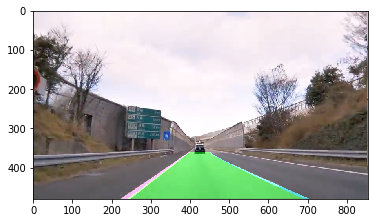

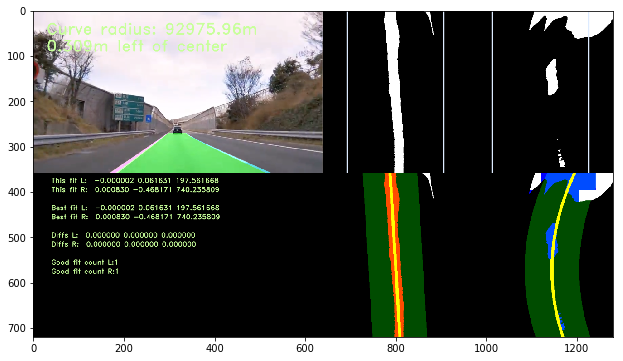

In [30]:
l_line = Line()
r_line = Line()

exampleImg2 = cv2.imread(img2)
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
img_out = process_image(exampleImg2)
plt.subplots(1, 1, figsize=(12,6))
plt.imshow(img_out)

### 動画を処理する

true : line.detected
fit is not None
l_fit :  [-2.86239080e-01  2.72623828e+02 -6.47512439e+04]
r_fit :  [-4.15982411e-04  4.84120780e-01  4.89080006e+02]
l_fit :  [-2.86239080e-01  2.72623828e+02 -6.47512439e+04]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  0
__________current_fit_after :  0
fales : line.best_fit
[MoviePy] >>>> Building video ../Google ドライブ/test_img/video_debug6.mp4
[MoviePy] Writing video ../Google ドライブ/test_img/video_debug6.mp4


  0%|          | 3/2116 [00:00<01:28, 23.74it/s]

true : line.detected
fit is not None
l_fit :  [-2.86239080e-01  2.72623828e+02 -6.47512439e+04]
r_fit :  [-4.15982411e-04  4.84120780e-01  4.89080006e+02]
l_fit :  [-2.86239080e-01  2.72623828e+02 -6.47512439e+04]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  0
__________current_fit_after :  0
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  0
__________current_fit_after :  1
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  1
__________current_fit_after :  2
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  2
__________current_fit_after :  3
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_a

  0%|          | 6/2116 [00:00<01:30, 23.31it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  4
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.55090733e-03  3.86503774e+00 -6.49518552e+02]
r_fit :  [-5.96760620e-04  5.50889262e-01  4.98041767e+02]
l_fit :  [-4.55090733e-03  3.86503774e+00 -6.49518552e+02]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5


  0%|          | 9/2116 [00:00<01:35, 22.11it/s]

__________current_fit_after :  5
fales : line.best_fit
true : line.detected


  1%|          | 12/2116 [00:00<01:38, 21.37it/s]

fit is not None
l_fit :  [-4.65704838e-03  3.96593963e+00 -6.75289952e+02]
r_fit :  [-5.18223473e-04  4.91938113e-01  5.11127792e+02]
l_fit :  [-4.65704838e-03  3.96593963e+00 -6.75289952e+02]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.58928798e-03  1.32203781e+00 -1.06119873e+02]
r_fit :  [-4.84318036e-04  4.72315678e-01  5.15855545e+02]
l_fit :  [-1.58928798e-03  1.32203781e+00 -1.06119873e+02]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.71853749e-03  3.16453433e+00 -5.04274010e+02]
r_fit :  [-4.50096656e-04  4.44870436e-01  5.20887541e+02]
l_fit :  [-3.71853749e-03  3.16453433e+00 -5.04274010e+02]
l_line.best_fit None
____

  1%|          | 14/2116 [00:00<01:43, 20.38it/s]

fit is not None
l_fit :  [ 5.03343319e-03 -4.50453273e+00  1.17460240e+03]
r_fit :  [-4.65140358e-04  4.44441944e-01  5.23728009e+02]
l_fit :  [ 5.03343319e-03 -4.50453273e+00  1.17460240e+03]
l_line.best_fit None
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
fales : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
r_fit :  [-4.82154478e-04  4.53735852e-01  5.22414688e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  1%|          | 16/2116 [00:00<02:33, 13.71it/s]

false : line.detected
fit is not None
l_fit :  [-1.24419262e-04  4.87926907e-02  1.72572199e+02]
r_fit :  [-7.29908001e-04  6.14310742e-01  4.98769556e+02]
l_fit :  [-1.24419262e-04  4.87926907e-02  1.72572199e+02]
l_line.best_fit [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.40580878e-04  6.13914801e-01  4.34956010e+01]
r_fit :  [-7.68706089e-04  6.41507216e-01  4.94400798e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.54390072e-03  2.24414704e+00 -3.22563859e+02]
r_fit :  [-6.06163281e-04  5.34848690e-01  5.09631403e+02]
l_fit :  [-2.54390072e-03  2.24414704e+00 -3.22563859e+02]
l_line.best_fit [-2.60237140e-04  1.483

  1%|          | 20/2116 [00:01<02:36, 13.38it/s]

true : line.detected
fit is not None
l_fit :  [-2.27342755e-03  2.00504613e+00 -2.69737777e+02]
r_fit :  [-6.21851108e-04  5.49583035e-01  5.06779928e+02]
l_fit :  [-2.27342755e-03  2.00504613e+00 -2.69737777e+02]
l_line.best_fit [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.72646271e-03  3.36611155e+00 -5.88027164e+02]
r_fit :  [-6.10147082e-04  5.42585817e-01  5.07703160e+02]
l_fit :  [-3.72646271e-03  3.36611155e+00 -5.88027164e+02]
l_line.best_fit [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.98445775e-03  4.56179194e+00 -8.70585578e+02]
r_fit :  [-6.08843952e-04  5.38614

  1%|          | 22/2116 [00:01<02:37, 13.31it/s]

true : line.detected
fit is not None
l_fit :  [-1.08160925e-02  1.00182017e+01 -2.14724499e+03]
r_fit :  [-6.30194337e-04  5.60707767e-01  5.08104325e+02]
l_fit :  [-1.08160925e-02  1.00182017e+01 -2.14724499e+03]
l_line.best_fit [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.84000924e-02  5.52659926e+01 -1.29026194e+04]
r_fit :  [-6.24741838e-04  5.58350382e-01  5.06269109e+02]
l_fit :  [-5.84000924e-02  5.52659926e+01 -1.29026194e+04]
l_line.best_fit [-2.60237140e-04  1.48387251e-01  1.54294844e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.08039998e-02  6.67752343e+01 -1.55714329e+04]
r_fit :  [-6.97630247e-04  6.00581

  1%|          | 26/2116 [00:01<02:38, 13.21it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  1%|▏         | 28/2116 [00:01<02:38, 13.20it/s]

true : line.detected
fit is not None
l_fit :  [4.03970452e-04 1.53508772e-01 5.83333333e+01]
r_fit :  [-4.23367232e-04  4.10913040e-01  5.41673177e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.36227242e-01 -1.04515086e+02  2.02165392e+04]
r_fit :  [-8.55044340e-04  6.65955921e-01  5.08999939e+02]
l_fit :  [ 1.36227242e-01 -1.04515086e+02  2.02165392e+04]
l_line.best_fit [4.03970452e-04 1.53508772e-01 5.83333333e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.73458815e-03  5.62433086e+00 -1.00040494e+03]
r_fit :  [-3.35061801e-04  3.57874852e-01  5.50806310e+02]
l_fit :  [-6.73458815e-03  5.62433086e+00 -1.00040494e+03]
l_line.best_fit [4.03970452e-04 1.53508772e-01

  2%|▏         | 32/2116 [00:02<02:35, 13.40it/s]

true : line.detected
fit is not None
l_fit :  [-2.31987789e-02  1.87304939e+01 -3.60741205e+03]
r_fit :  [-3.37565946e-04  3.52961358e-01  5.51263544e+02]
l_fit :  [-2.31987789e-02  1.87304939e+01 -3.60741205e+03]
l_line.best_fit [4.03970452e-04 1.53508772e-01 5.83333333e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.62001515e-02  1.30200886e+01 -2.44262136e+03]
r_fit :  [-3.32541371e-04  3.57854512e-01  5.50742408e+02]
l_fit :  [-1.62001515e-02  1.30200886e+01 -2.44262136e+03]
l_line.best_fit [4.03970452e-04 1.53508772e-01 5.83333333e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.36997123e-03 -1.13120341e+00  4.06282112e+02]
r_fit :  [-3.55931639e-04  3.94474015e-0

  2%|▏         | 34/2116 [00:02<02:36, 13.29it/s]

true : line.detected
fit is not None
l_fit :  [-3.61311745e-04  2.89206144e-01  1.15442486e+02]
r_fit :  [-3.97897182e-04  4.31354373e-01  5.38822368e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.62000741e-04  4.55477961e-01  8.27892214e+01]
r_fit :  [-5.31376797e-04  5.35865276e-01  5.18583865e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.65600828e-03  2.25038271e+00 -3.00397408e+02]
r_fit :  [-5.71183490e-04  5.63193562e-01  5.10211358e+02]
l_fit :  [-2.65600828e-03  2.25038271e+00 -3.00397408e+02]
l_line.best_fit [-4.61656243e-04  3.72342053e-01  9.91158538e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before : 

  2%|▏         | 38/2116 [00:02<02:45, 12.52it/s]

true : line.detected
fit is not None
l_fit :  [-9.03299782e-04  7.35499463e-01  2.75757012e+01]
r_fit :  [-4.17962640e-04  4.93429698e-01  5.16504862e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.01034326e-04  4.69255426e-02  1.76099403e+02]
r_fit :  [-5.51302665e-04  6.10592630e-01  4.93426467e+02]
l_fit :  [-1.01034326e-04  4.69255426e-02  1.76099403e+02]
l_line.best_fit [-6.32305763e-04  5.12352804e-01  7.15090937e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.36174039e-03  1.16148817e+00 -6.92217769e+01]
r_fit :  [-5.73966570e-04  5.82502555e-01  5.00957442e+02]
l_fit :  [-1.36174039e-03  1.16148817e+00 -6.92217769e+01]
l_line.best_fit [-3.61311745e-04  2.8920

  2%|▏         | 40/2116 [00:02<02:49, 12.27it/s]

true : line.detected
fit is not None
l_fit :  [-9.10673030e-04  7.63963439e-01  1.84121697e+01]
r_fit :  [-6.52554067e-04  6.33529927e-01  4.94416947e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.02423386e-03  8.76259119e-01 -8.77914530e+00]
r_fit :  [-6.61257530e-04  7.04596274e-01  4.74874773e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.81093913e-04  7.48703882e-01  1.97915587e+01]
r_fit :  [-7.84793086e-04  7.68503022e-01  4.67860614e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  2%|▏         | 44/2116 [00:03<03:00, 11.46it/s]

false : line.detected
fit is not None
l_fit :  [-3.88829556e-03  3.52894458e+00 -6.22393929e+02]
r_fit :  [-8.92749344e-04  8.21920696e-01  4.62102603e+02]
l_fit :  [-3.88829556e-03  3.52894458e+00 -6.22393929e+02]
l_line.best_fit [-9.38666935e-04  7.96308813e-01  9.80819435e+00]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.77403274e-03  2.54581453e+00 -4.07450305e+02]
r_fit :  [-6.43276093e-04  5.94278736e-01  5.03302176e+02]
l_fit :  [-2.77403274e-03  2.54581453e+00 -4.07450305e+02]
l_line.best_fit [-9.67453447e-04  8.20111279e-01  4.81651219e+00]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


  2%|▏         | 46/2116 [00:03<03:04, 11.21it/s]

fit is not None
l_fit :  [-4.36956169e-03  4.06273103e+00 -7.67458043e+02]
r_fit :  [-6.62290809e-04  5.95355159e-01  5.03308441e+02]
l_fit :  [-4.36956169e-03  4.06273103e+00 -7.67458043e+02]
l_line.best_fit [-9.10673030e-04  7.63963439e-01  1.84121697e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.95998029e-04  3.40564813e-01  1.25176767e+02]
r_fit :  [-6.65075267e-04  6.03929339e-01  5.02089112e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.09502500e-02 -5.79285895e+01  1.39376482e+04]
r_fit :  [-9.41546663e-04  7.90019899e-01  4.80032591e+02]
l_fit :  [ 6.09502500e-02 -5.79285895e+01  1.39376482e+04]
l_line.best_fit [-4.95998029e-04  3.40564813e-01  1.25176767e

  2%|▏         | 48/2116 [00:03<03:16, 10.52it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
r_fit :  [-4.80125576e-04  4.95977017e-01  5.21061304e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71171974e-03  1.93765527e+00 -1.67767419e+02]
r_fit :  [-9.27814847e-04  7.48971910e-01  4.90272342e+02]
l_fit :  [-2.71171974e-03  1.93765527e+00 -1.67767419e+02]
l_line.best_fit [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.41001881e-04 -4.64403445e-01  2.60677690e+02]
r_fit :  [-3.81203841e-04  4.08782661e-01  5.38409623e+02]
l_fit :  [ 6.41001881e-04 -4.64403445e-01  2.60677690e+02]
l_line.best_fit [-1

  2%|▏         | 51/2116 [00:03<03:43,  9.24it/s]

true : line.detected
fit is not None
l_fit :  [ 2.44010256e-03 -1.68332378e+00  4.67082998e+02]
r_fit :  [-3.98030555e-04  4.09807918e-01  5.39387764e+02]
l_fit :  [ 2.44010256e-03 -1.68332378e+00  4.67082998e+02]
l_line.best_fit [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.38537473e-04 -1.60754974e-01  2.04544277e+02]
r_fit :  [-4.08305575e-04  4.17357737e-01  5.39266528e+02]
l_fit :  [ 2.38537473e-04 -1.60754974e-01  2.04544277e+02]
l_line.best_fit [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  3%|▎         | 53/2116 [00:04<03:35,  9.57it/s]

true : line.detected
fit is not None
l_fit :  [ 4.46122226e-03 -3.32374979e+00  7.95918844e+02]
r_fit :  [-4.64423474e-04  4.55819047e-01  5.31849835e+02]
l_fit :  [ 4.46122226e-03 -3.32374979e+00  7.95918844e+02]
l_line.best_fit [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.26416668e-03 -2.49003262e+00  6.53983845e+02]
r_fit :  [-4.83331823e-04  4.87046302e-01  5.25054558e+02]
l_fit :  [ 3.26416668e-03 -2.49003262e+00  6.53983845e+02]
l_line.best_fit [-1.10108265e-03  8.37115756e-01  2.40165934e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
r_fit :  [-5.53222203e-04  5.30972

  3%|▎         | 55/2116 [00:04<03:27,  9.93it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.18071547e-03 -9.52566610e-01  3.72300173e+02]
r_fit :  [-7.00725760e-04  6.37389107e-01  4.97946265e+02]
l_fit :  [ 1.18071547e-03 -9.52566610e-01  3.72300173e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


  3%|▎         | 58/2116 [00:04<03:48,  9.01it/s]

fit is not None
l_fit :  [ 1.42631295e-03 -1.19113267e+00  4.30095289e+02]
r_fit :  [-5.99949775e-04  5.71428031e-01  5.04537469e+02]
l_fit :  [ 1.42631295e-03 -1.19113267e+00  4.30095289e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.75807751e-04 -4.40673507e-01  2.83846206e+02]
r_fit :  [-6.72024115e-04  6.30617245e-01  4.92576556e+02]
l_fit :  [ 4.75807751e-04 -4.40673507e-01  2.83846206e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  3%|▎         | 60/2116 [00:04<03:34,  9.57it/s]

true : line.detected
fit is not None
l_fit :  [-2.95062154e-07 -6.42293272e-02  2.09770070e+02]
r_fit :  [-6.73249681e-04  6.27848961e-01  4.92673861e+02]
l_fit :  [-2.95062154e-07 -6.42293272e-02  2.09770070e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.81375044e-04 -8.07634332e-01  3.66444000e+02]
r_fit :  [-6.53798454e-04  6.27158154e-01  4.91884032e+02]
l_fit :  [ 8.81375044e-04 -8.07634332e-01  3.66444000e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.05638222e-04 -4.83218564e-01  2.96924328e+02]
r_fit :  [-6.74338330e-04  6.31904

  3%|▎         | 62/2116 [00:05<03:31,  9.70it/s]

true : line.detected
fit is not None
l_fit :  [ 2.77961021e-04 -3.01850786e-01  2.60572403e+02]
r_fit :  [-6.65154549e-04  6.32610399e-01  4.92433161e+02]
l_fit :  [ 2.77961021e-04 -3.01850786e-01  2.60572403e+02]
l_line.best_fit [-3.08738557e-04  2.20102574e-01  1.41813828e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.89597687e-04  4.62540362e-01  9.28103474e+01]
r_fit :  [-6.94775585e-04  6.43329632e-01  4.90612176e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.24344715e-03  1.04832297e+00 -3.81833720e+01]
r_fit :  [-1.02163477e-03  8.62642013e-01  4.58571566e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  

  3%|▎         | 66/2116 [00:05<03:11, 10.70it/s]

true : line.detected
fit is not None
l_fit :  [-2.39390319e-03  2.09800254e+00 -2.78520722e+02]
r_fit :  [-5.99256406e-04  5.86591522e-01  5.00327674e+02]
l_fit :  [-2.39390319e-03  2.09800254e+00 -2.78520722e+02]
l_line.best_fit [-5.89597687e-04  4.62540362e-01  9.28103474e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.19762418e-03  1.93138950e+00 -2.43629400e+02]
r_fit :  [-5.27479851e-04  5.28392666e-01  5.12126322e+02]
l_fit :  [-2.19762418e-03  1.93138950e+00 -2.43629400e+02]
l_line.best_fit [-5.89597687e-04  4.62540362e-01  9.28103474e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.35207604e-03  2.09548291e+00 -2.87404801e+02]
r_fit :  [-5.06764295e-04  5.08053

  3%|▎         | 68/2116 [00:05<03:01, 11.26it/s]

true : line.detected
fit is not None
l_fit :  [-4.59980407e-04  3.30880123e-01  1.23630291e+02]
r_fit :  [-4.77168875e-04  4.80754117e-01  5.24366559e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.33016100e-04  1.50636781e-02  1.99121466e+02]
r_fit :  [-8.43768230e-04  6.77340656e-01  5.07459033e+02]
l_fit :  [-1.33016100e-04  1.50636781e-02  1.99121466e+02]
l_line.best_fit [-4.59980407e-04  3.30880123e-01  1.23630291e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.40143723e-04  6.45867979e-01  5.92899536e+01]
r_fit :  [-8.46599993e-04  6.94129190e-01  5.00079046e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before : 

  3%|▎         | 72/2116 [00:05<03:24, 10.00it/s]

true : line.detected
fit is not None
l_fit :  [ 1.05271989e-03 -8.86505615e-01  3.59494205e+02]
r_fit :  [-4.45090785e-04  4.55570027e-01  5.30714829e+02]
l_fit :  [ 1.05271989e-03 -8.86505615e-01  3.59494205e+02]
l_line.best_fit [-4.59980407e-04  3.30880123e-01  1.23630291e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.94981426e-03  3.36535130e+00 -3.90595467e+02]
r_fit :  [-4.47709005e-04  4.63131180e-01  5.26947891e+02]
l_fit :  [-4.94981426e-03  3.36535130e+00 -3.90595467e+02]
l_line.best_fit [-4.59980407e-04  3.30880123e-01  1.23630291e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.43341377e-02 -3.86962735e+01  7.07179550e+03]
r_fit :  [-5.02071030e-04  5.05776

  4%|▎         | 75/2116 [00:06<04:37,  7.35it/s]

true : line.detected
fit is not None
l_fit :  [ 8.37662461e-03 -6.11823981e+00  1.29969944e+03]
r_fit :  [-5.75216716e-04  5.70389844e-01  5.01607171e+02]
l_fit :  [ 8.37662461e-03 -6.11823981e+00  1.29969944e+03]
l_line.best_fit [-4.59980407e-04  3.30880123e-01  1.23630291e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.28873996e-04  4.99210204e-01  8.74956599e+01]
r_fit :  [-6.57261690e-04  6.28410715e-01  4.91577328e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  4%|▎         | 77/2116 [00:06<04:43,  7.20it/s]

false : line.detected
fit is not None
l_fit :  [ 8.75587588e-05 -3.62919405e-02  1.87379641e+02]
r_fit :  [-9.00292900e-04  7.81598429e-01  4.71174901e+02]
l_fit :  [ 8.75587588e-05 -3.62919405e-02  1.87379641e+02]
l_line.best_fit [-6.28873996e-04  4.99210204e-01  8.74956599e+01]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.26511683e-03  9.86527662e-01 -5.46608716e+00]
r_fit :  [-1.02700336e-03  8.53235177e-01  4.62353807e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  4%|▎         | 79/2116 [00:06<04:34,  7.42it/s]

true : line.detected
fit is not None
l_fit :  [-2.55396870e-03  2.05480940e+00 -2.25563285e+02]
r_fit :  [-7.11693766e-04  6.61108425e-01  4.87545602e+02]
l_fit :  [-2.55396870e-03  2.05480940e+00 -2.25563285e+02]
l_line.best_fit [-6.28873996e-04  4.99210204e-01  8.74956599e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.69317767e-03 -1.39133031e+00  4.73045705e+02]
r_fit :  [-7.25237314e-04  6.77730399e-01  4.82718052e+02]
l_fit :  [ 1.69317767e-03 -1.39133031e+00  4.73045705e+02]
l_line.best_fit [-6.28873996e-04  4.99210204e-01  8.74956599e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  4%|▍         | 81/2116 [00:07<04:50,  7.00it/s]

true : line.detected
fit is not None
l_fit :  [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
r_fit :  [-7.21438326e-04  6.75174834e-01  4.82887158e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.58631299e-04 -3.29052110e-01  2.63531404e+02]
r_fit :  [-1.20451790e-03  9.73116831e-01  4.42321879e+02]
l_fit :  [ 3.58631299e-04 -3.29052110e-01  2.63531404e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  4%|▍         | 84/2116 [00:07<04:28,  7.56it/s]

true : line.detected
fit is not None
l_fit :  [ 6.85782335e-04 -5.90539370e-01  3.15876363e+02]
r_fit :  [-7.78356713e-04  7.16508896e-01  4.74570469e+02]
l_fit :  [ 6.85782335e-04 -5.90539370e-01  3.15876363e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.87378190e-05 -4.19824457e-02  1.99737570e+02]
r_fit :  [-8.33405480e-04  7.58219893e-01  4.66665699e+02]
l_fit :  [ 3.87378190e-05 -4.19824457e-02  1.99737570e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  4%|▍         | 86/2116 [00:07<04:00,  8.46it/s]

true : line.detected
fit is not None
l_fit :  [ 2.81604867e-04 -2.86832017e-01  2.60680579e+02]
r_fit :  [-8.12265756e-04  7.55785673e-01  4.64906430e+02]
l_fit :  [ 2.81604867e-04 -2.86832017e-01  2.60680579e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.86925802e-04 -2.21149886e-01  2.50762787e+02]
r_fit :  [-8.08439523e-04  7.64483262e-01  4.61041911e+02]
l_fit :  [ 1.86925802e-04 -2.21149886e-01  2.50762787e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.41166712e-04 -2.53477556e-01  2.53389829e+02]
r_fit :  [-8.56341641e-04  7.84988

  4%|▍         | 90/2116 [00:08<03:12, 10.55it/s]

true : line.detected
fit is not None
l_fit :  [ 1.43436485e-04 -1.76858431e-01  2.38321581e+02]
r_fit :  [-8.53886936e-04  7.92776309e-01  4.64877136e+02]
l_fit :  [ 1.43436485e-04 -1.76858431e-01  2.38321581e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.42723724e-03 -1.38447366e+00  5.21836957e+02]
r_fit :  [-8.61489325e-04  7.92696399e-01  4.64955514e+02]
l_fit :  [ 1.42723724e-03 -1.38447366e+00  5.21836957e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.82200628e-05 -4.31558095e-02  2.11820046e+02]
r_fit :  [-7.33787200e-04  6.96070

  4%|▍         | 92/2116 [00:08<03:00, 11.18it/s]

true : line.detected
fit is not None
l_fit :  [-1.94508898e-04  9.76259066e-02  1.81857585e+02]
r_fit :  [-6.58617295e-04  6.47588314e-01  4.91378994e+02]
l_fit :  [-1.94508898e-04  9.76259066e-02  1.81857585e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.38692220e-04  3.69823222e-02  1.97725875e+02]
r_fit :  [-6.05294201e-04  6.39323472e-01  4.96352164e+02]
l_fit :  [-1.38692220e-04  3.69823222e-02  1.97725875e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.38768600e-04  3.46019675e-02  1.98888262e+02]
r_fit :  [-6.04723686e-04  6.27780

  4%|▍         | 94/2116 [00:08<02:56, 11.47it/s]

true : line.detected
fit is not None
l_fit :  [-1.31089371e-02  1.25044311e+01 -2.79784361e+03]
r_fit :  [-6.06399432e-04  6.15788505e-01  5.01447484e+02]
l_fit :  [-1.31089371e-02  1.25044311e+01 -2.79784361e+03]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.81469565e-03  2.26350723e+00 -2.53413782e+02]
r_fit :  [-6.07955545e-04  6.20288754e-01  4.98890725e+02]
l_fit :  [-2.81469565e-03  2.26350723e+00 -2.53413782e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.74902906e-02  2.02650011e+01 -3.53663643e+03]
r_fit :  [-5.53015267e-04  6.05482

  5%|▍         | 98/2116 [00:08<02:41, 12.49it/s]

true : line.detected
fit is not None
l_fit :  [ 2.36930574e-02 -1.74221118e+01  3.40018894e+03]
r_fit :  [-6.03190908e-04  6.32163467e-01  4.90244992e+02]
l_fit :  [ 2.36930574e-02 -1.74221118e+01  3.40018894e+03]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.79914478e-03 -2.81479119e+00  7.20472188e+02]
r_fit :  [-6.23123792e-04  6.50913284e-01  4.85501576e+02]
l_fit :  [ 3.79914478e-03 -2.81479119e+00  7.20472188e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.99837443e-04 -3.79529292e-01  2.74403327e+02]
r_fit :  [-7.40737297e-04  7.60005

  5%|▍         | 100/2116 [00:08<02:37, 12.76it/s]

true : line.detected
fit is not None
l_fit :  [ 9.43754898e-05 -1.23749378e-01  2.36398281e+02]
r_fit :  [-7.42245492e-04  7.79447999e-01  4.52126821e+02]
l_fit :  [ 9.43754898e-05 -1.23749378e-01  2.36398281e+02]
l_line.best_fit [-3.55927571e-04  2.84509073e-01  1.31770258e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
r_fit :  [-6.26104524e-04  7.08319111e-01  4.59648665e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.56052465e-04  6.67345077e-01  9.10110238e+01]
r_fit :  [-5.77005302e-04  7.40016225e-01  4.42783117e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  

  5%|▍         | 104/2116 [00:09<02:40, 12.56it/s]

false : line.detected
fit is not None
l_fit :  [-8.98909097e-04  6.47535312e-01  8.86131475e+01]
r_fit :  [-8.64719379e-04  9.12321165e-01  4.23749451e+02]
l_fit :  [-8.98909097e-04  6.47535312e-01  8.86131475e+01]
l_line.best_fit [-1.07708791e-03  7.92050010e-01  5.97637556e+01]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.44137369e-04  6.20849654e-01  9.06998976e+01]
r_fit :  [-1.22284468e-03  1.10424589e+00  4.03663361e+02]
l_fit :  [-8.44137369e-04  6.20849654e-01  9.06998976e+01]
l_line.best_fit [-1.01769497e-03  7.43878444e-01  6.93802196e+01]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47959083e-03  2.02483917e+00 -2.10638421e+02]
r_fit :  [-1.31801124e-03  1.14

  5%|▌         | 106/2116 [00:09<02:59, 11.20it/s]

true : line.detected
fit is not None
l_fit :  [-1.49462665e-03  1.20347804e+00 -4.07607773e+01]
r_fit :  [-5.73079819e-04  6.15462741e-01  4.90072774e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.24023163e-03  1.01813486e+00 -9.09891550e+00]
r_fit :  [-6.11051915e-04  6.20821746e-01  4.93906084e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  5%|▌         | 108/2116 [00:09<03:07, 10.72it/s]

false : line.detected
fit is not None
l_fit :  [-3.42019771e-04  2.50803910e-01  1.53344391e+02]
r_fit :  [-1.42268056e-03  1.11992665e+00  4.29637210e+02]
l_fit :  [-3.42019771e-04  2.50803910e-01  1.53344391e+02]
l_line.best_fit [-1.13146915e-03  8.67411627e-01  3.68095319e+01]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.72148041e-04  9.72054037e-02  1.87504672e+02]
r_fit :  [-4.83871410e-04  5.19896395e-01  5.17618556e+02]
l_fit :  [-1.72148041e-04  9.72054037e-02  1.87504672e+02]
l_line.best_fit [-1.07708791e-03  7.92050010e-01  5.97637556e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


  5%|▌         | 110/2116 [00:09<03:08, 10.63it/s]

fit is not None
l_fit :  [ 1.87921193e-04 -2.22426549e-01  2.57994257e+02]
r_fit :  [-5.01524534e-04  5.17500642e-01  5.22702644e+02]
l_fit :  [ 1.87921193e-04 -2.22426549e-01  2.57994257e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.94094016e-05 -7.97611167e-02  2.28429915e+02]
r_fit :  [-5.16636380e-04  5.39450218e-01  5.15933617e+02]
l_fit :  [ 1.94094016e-05 -7.97611167e-02  2.28429915e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.86943922e-05 -2.00520162e-03  2.11195414e+02]
r_fit :  

  5%|▌         | 113/2116 [00:10<04:29,  7.43it/s]

[-4.64132349e-04  5.05094686e-01  5.23992056e+02]
l_fit :  [-6.86943922e-05 -2.00520162e-03  2.11195414e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.57446866e-05 -2.80588538e-02  2.18270121e+02]
r_fit :  [-4.74003031e-04  5.14417431e-01  5.23279028e+02]
l_fit :  [-4.57446866e-05 -2.80588538e-02  2.18270121e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  5%|▌         | 114/2116 [00:10<04:16,  7.81it/s]

true : line.detected
fit is not None
l_fit :  [-1.15388134e-05 -6.09732742e-02  2.26730945e+02]
r_fit :  [-4.46697297e-04  4.95288190e-01  5.24215425e+02]
l_fit :  [-1.15388134e-05 -6.09732742e-02  2.26730945e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.76308470e-04  6.31739608e-02  2.04857998e+02]
r_fit :  [-4.59539079e-04  5.13808202e-01  5.23031507e+02]
l_fit :  [-1.76308470e-04  6.31739608e-02  2.04857998e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  5%|▌         | 116/2116 [00:10<04:03,  8.23it/s]

true : line.detected
fit is not None
l_fit :  [-2.90540165e-04  1.55347855e-01  1.86961802e+02]
r_fit :  [-4.58823901e-04  5.20738643e-01  5.18983760e+02]
l_fit :  [-2.90540165e-04  1.55347855e-01  1.86961802e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.38976212e-04  1.65556509e-01  1.93819852e+02]
r_fit :  [-5.34596824e-04  5.74400458e-01  5.08379774e+02]
l_fit :  [-3.38976212e-04  1.65556509e-01  1.93819852e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 118/2116 [00:11<04:53,  6.80it/s]

true : line.detected
fit is not None
l_fit :  [-1.95760358e-05 -8.05672861e-02  2.38839511e+02]
r_fit :  [-5.45985872e-04  5.86754085e-01  5.05870996e+02]
l_fit :  [-1.95760358e-05 -8.05672861e-02  2.38839511e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [6.55525863e-04 2.13701431e-01 6.96666667e+01]
r_fit :  [-5.46420878e-04  5.84884112e-01  5.06608435e+02]
l_fit :  

  6%|▌         | 120/2116 [00:11<04:45,  6.99it/s]

[6.55525863e-04 2.13701431e-01 6.96666667e+01]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.43237266e-02 -1.02789697e+01  2.05299671e+03]
r_fit :  [-5.80384585e-04  5.98112456e-01  5.05848655e+02]
l_fit :  [ 1.43237266e-02 -1.02789697e+01  2.05299671e+03]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 122/2116 [00:11<04:15,  7.80it/s]

true : line.detected
fit is not None
l_fit :  [ 1.20454645e-04 -1.70491445e-01  2.54930371e+02]
r_fit :  [-5.70531789e-04  5.97521076e-01  5.06082911e+02]
l_fit :  [ 1.20454645e-04 -1.70491445e-01  2.54930371e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.89611892e-03 -1.55317019e+00  5.23430033e+02]
r_fit :  [-5.70704679e-04  5.92487606e-01  5.06450987e+02]
l_fit :  [ 1.89611892e-03 -1.55317019e+00  5.23430033e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 123/2116 [00:11<04:07,  8.07it/s]

true : line.detected
fit is not None
l_fit :  [-5.50848655e-06 -6.37448886e-02  2.33900810e+02]
r_fit :  [-5.58009064e-04  5.74609548e-01  5.12262498e+02]
l_fit :  [-5.50848655e-06 -6.37448886e-02  2.33900810e+02]
l_line.best_fit [-1.19812335e-03  9.16754944e-01  2.85164874e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
r_fit :  [-5.70886800e-04  5.96975978e-01  5.05280442e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 126/2116 [00:12<04:08,  8.00it/s]

false : line.detected
fit is not None
l_fit :  [-1.39536615e-03  1.01067150e+00  2.88786884e+01]
r_fit :  [-9.41470639e-04  8.28946057e-01  4.72352620e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.21007776e-04  1.48528775e-02  2.24051180e+02]
r_fit :  [-1.02618478e-03  8.86722855e-01  4.63327672e+02]
l_fit :  [-1.21007776e-04  1.48528775e-02  2.24051180e+02]
l_line.best_fit [-1.30237438e-03  9.34540164e-01  4.41588951e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 128/2116 [00:12<04:01,  8.23it/s]

true : line.detected
fit is not None
l_fit :  [ 1.32430031e-04 -2.00983048e-01  2.70723496e+02]
r_fit :  [-6.82045872e-04  6.80267821e-01  4.89931554e+02]
l_fit :  [ 1.32430031e-04 -2.00983048e-01  2.70723496e+02]
l_line.best_fit [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.37735126e-04  2.72266154e-02  2.22851454e+02]
r_fit :  [-6.37634740e-04  6.49469983e-01  4.96474281e+02]
l_fit :  [-1.37735126e-04  2.72266154e-02  2.22851454e+02]
l_line.best_fit [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 130/2116 [00:12<03:56,  8.38it/s]

true : line.detected
fit is not None
l_fit :  [-2.64814662e-04  1.30537898e-01  2.02024584e+02]
r_fit :  [-5.91043734e-04  6.16984549e-01  5.03146367e+02]
l_fit :  [-2.64814662e-04  1.30537898e-01  2.02024584e+02]
l_line.best_fit [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.27801209e-04 -2.71049910e-01  2.83764035e+02]
r_fit :  [-5.25532898e-04  5.68965351e-01  5.12275105e+02]
l_fit :  [ 2.27801209e-04 -2.71049910e-01  2.83764035e+02]
l_line.best_fit [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▌         | 131/2116 [00:12<04:00,  8.24it/s]

true : line.detected
fit is not None
l_fit :  [-3.52557271e-05 -4.26455095e-02  2.34197149e+02]
r_fit :  [-4.68441990e-04  5.25477525e-01  5.21627116e+02]
l_fit :  [-3.52557271e-05 -4.26455095e-02  2.34197149e+02]
l_line.best_fit [-1.20938261e-03  8.58408825e-01  5.94391017e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.32241670e-04  7.24013526e-01  7.06833115e+01]
r_fit :  [-4.97448533e-04  5.33925830e-01  5.24323027e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▋         | 133/2116 [00:13<03:59,  8.27it/s]

false : line.detected
fit is not None
l_fit :  [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
r_fit :  [-9.16878658e-04  7.77216624e-01  4.96439249e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.20199332e-03  9.78238688e-01  1.16837349e+01]
r_fit :  [-9.11146625e-04  7.76455003e-01  4.95865747e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▋         | 135/2116 [00:13<04:06,  8.02it/s]

false : line.detected
fit is not None
l_fit :  [-1.23550007e-03  1.00030446e+00  9.86651821e+00]
r_fit :  [-9.25703598e-04  7.88254350e-01  4.93521061e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.22493682e-03  1.00258849e+00  6.83421379e+00]
r_fit :  [-9.39343467e-04  7.98106141e-01  4.91779275e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  6%|▋         | 137/2116 [00:13<04:06,  8.04it/s]

false : line.detected
fit is not None
l_fit :  [-9.83581274e-04  8.69186987e-01  1.78703945e+01]
r_fit :  [-1.05484148e-03  8.74202500e-01  4.79433841e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [5.68427974e-05 3.29107173e-01 4.69553472e+01]
r_fit :  [-1.13625936e-03  9.39750994e-01  4.66022144e+02]
l_fit :  [5.68427974e-05 3.29107173e-01 4.69553472e+01]
l_line.best_fit [-1.17063786e-03  9.65873780e-01  1.16210651e+01]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 139/2116 [00:13<04:15,  7.75it/s]

true : line.detected
fit is not None
l_fit :  [-4.24411963e-05 -5.75402715e-02  2.46594457e+02]
r_fit :  [-6.49429575e-04  6.50620340e-01  5.02452672e+02]
l_fit :  [-4.24411963e-05 -5.75402715e-02  2.46594457e+02]
l_line.best_fit [-1.21740201e-03  9.90045478e-01  1.00587327e+01]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.24810404e-04  5.27292665e-02  2.34317300e+02]
r_fit :  [-5.93644651e-04  6.16138816e-01  5.07393528e+02]
l_fit :  [-2.24810404e-04  5.27292665e-02  2.34317300e+02]
l_line.best_fit [-1.21489040e-03  9.85864475e-01  1.11335724e+01]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 142/2116 [00:14<04:14,  7.76it/s]

true : line.detected
fit is not None
l_fit :  [-8.00202127e-05 -3.55424785e-02  2.45149001e+02]
r_fit :  [-6.43920865e-04  6.46073689e-01  5.03665726e+02]
l_fit :  [-8.00202127e-05 -3.55424785e-02  2.45149001e+02]
l_line.best_fit [-1.20458557e-03  9.78644483e-01  1.17670995e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.27134225e-05 -4.83233480e-02  2.47315912e+02]
r_fit :  [-6.66248433e-04  6.61727352e-01  5.01542437e+02]
l_fit :  [-6.27134225e-05 -4.83233480e-02  2.47315912e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 144/2116 [00:14<04:04,  8.08it/s]

true : line.detected
fit is not None
l_fit :  [-4.71414667e-04  1.19855303e-01  2.39423864e+02]
r_fit :  [-6.84765268e-04  6.73959782e-01  4.99475433e+02]
l_fit :  [-4.71414667e-04  1.19855303e-01  2.39423864e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.85520192e-04  2.60799338e-02  2.37810012e+02]
r_fit :  [-7.23322376e-04  7.03397192e-01  4.94455128e+02]
l_fit :  [-1.85520192e-04  2.60799338e-02  2.37810012e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 146/2116 [00:14<03:51,  8.50it/s]

true : line.detected
fit is not None
l_fit :  [-2.07670010e-04  5.55875954e-02  2.30199336e+02]
r_fit :  [-7.18657875e-04  7.04518618e-01  4.93407701e+02]
l_fit :  [-2.07670010e-04  5.55875954e-02  2.30199336e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.73179337e-05 -1.42550337e-01  2.66721090e+02]
r_fit :  [-6.79252825e-04  6.77468037e-01  4.99107271e+02]
l_fit :  [ 5.73179337e-05 -1.42550337e-01  2.66721090e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 147/2116 [00:14<04:06,  8.00it/s]

true : line.detected
fit is not None
l_fit :  [ 4.63098359e-04 -4.23102026e-01  3.14496982e+02]
r_fit :  [-5.18281383e-04  5.67240195e-01  5.18497658e+02]
l_fit :  [ 4.63098359e-04 -4.23102026e-01  3.14496982e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.30823187e-04 -5.52665897e-01  3.39197274e+02]
r_fit :  [-5.24920394e-04  5.67821771e-01  5.20493794e+02]
l_fit :  [ 6.30823187e-04 -5.52665897e-01  3.39197274e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 150/2116 [00:15<03:50,  8.53it/s]

true : line.detected
fit is not None
l_fit :  [ 3.57468472e-04 -3.61983128e-01  3.05994816e+02]
r_fit :  [-5.43606400e-04  5.75556035e-01  5.22150149e+02]
l_fit :  [ 3.57468472e-04 -3.61983128e-01  3.05994816e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.19759105e-04  1.85077381e-01  1.95205036e+02]
r_fit :  [-4.63253839e-04  5.29778717e-01  5.27162958e+02]
l_fit :  [-3.19759105e-04  1.85077381e-01  1.95205036e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 152/2116 [00:15<03:54,  8.38it/s]

true : line.detected
fit is not None
l_fit :  [-7.33980593e-05 -5.27272758e-03  2.32244878e+02]
r_fit :  [-4.30467266e-04  5.04906605e-01  5.32676473e+02]
l_fit :  [-7.33980593e-05 -5.27272758e-03  2.32244878e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.60768984e-04  6.57667346e-02  2.17308300e+02]
r_fit :  [-4.78402087e-04  5.33300559e-01  5.29206418e+02]
l_fit :  [-1.60768984e-04  6.57667346e-02  2.17308300e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 153/2116 [00:15<04:00,  8.18it/s]

true : line.detected
fit is not None
l_fit :  [ 5.65432528e-05 -1.10474552e-01  2.52785605e+02]
r_fit :  [-2.93592982e-04  4.15047934e-01  5.47250277e+02]
l_fit :  [ 5.65432528e-05 -1.10474552e-01  2.52785605e+02]
l_line.best_fit [-1.20717782e-03  9.79050278e-01  1.18504641e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.20145350e-03  9.67833183e-01  2.19526245e+01]
r_fit :  [-3.07395797e-04  4.22274873e-01  5.46827836e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 155/2116 [00:15<04:13,  7.73it/s]

false : line.detected
fit is not None
l_fit :  [-6.97587962e-04  7.25588086e-01  3.17145950e+01]
r_fit :  [-7.11379853e-04  6.57436883e-01  5.19812658e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.04977023e-03  8.93385813e-01  2.49463690e+01]
r_fit :  [-7.27049049e-04  6.63896471e-01  5.19412187e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  7%|▋         | 157/2116 [00:16<04:16,  7.63it/s]

false : line.detected
fit is not None
l_fit :  [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
r_fit :  [-7.68658292e-04  6.78963398e-01  5.20126477e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.99484535e-04  8.88202833e-01  1.78563390e+01]
r_fit :  [-8.24405639e-04  7.10676322e-01  5.16275176e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 159/2116 [00:16<04:41,  6.95it/s]

false : line.detected
fit is not None
l_fit :  [-4.08499534e-04  6.32331638e-01  1.23912763e+01]
r_fit :  [-9.04076774e-04  7.53565796e-01  5.09845228e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.40767424e-03  1.23313009e+00 -5.36107526e+01]
r_fit :  [-1.06697899e-03  8.31994006e-01  5.03902131e+02]
l_fit :  [-1.40767424e-03  1.23313009e+00 -5.36107526e+01]
l_line.best_fit [-8.07656040e-04  7.90491711e-01  2.29387271e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 161/2116 [00:16<04:36,  7.07it/s]

false : line.detected
fit is not None
l_fit :  [-3.63527765e-04  6.20402351e-01  7.78491456e+00]
r_fit :  [-1.08453618e-03  8.46017044e-01  4.99802763e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.45394655e-03 -3.14615401e-01  4.71177393e+01]
r_fit :  [-1.09936167e-03  8.56942090e-01  4.97463419e+02]
l_fit :  [ 1.45394655e-03 -3.14615401e-01  4.71177393e+01]
l_line.best_fit [-8.12424803e-04  8.37403418e-01  2.44136664e+00]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 163/2116 [00:16<04:31,  7.19it/s]

true : line.detected
fit is not None
l_fit :  [ 4.24713023e-04 -5.08136668e-01  3.59975548e+02]
r_fit :  [-4.94773143e-04  4.96080776e-01  5.44579165e+02]
l_fit :  [ 4.24713023e-04 -5.08136668e-01  3.59975548e+02]
l_line.best_fit [-9.24649063e-04  8.91653685e-01  1.10547966e+00]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.32138087e-04 -2.24031342e-01  4.16616787e+02]
r_fit :  [-4.94800825e-04  4.88417071e-01  5.46955281e+02]
l_fit :  [-6.32138087e-04 -2.24031342e-01  4.16616787e+02]
l_line.best_fit [-7.63640670e-04  7.77828218e-01  1.93442238e+01]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 166/2116 [00:17<04:15,  7.63it/s]

true : line.detected
fit is not None
l_fit :  [ 5.42791405e-04 -4.24414547e-01  4.20545816e+02]
r_fit :  [-6.99263830e-04  6.27761536e-01  5.23421569e+02]
l_fit :  [ 5.42791405e-04 -4.24414547e-01  4.20545816e+02]
l_line.best_fit [-9.41211237e-04  8.50576509e-01  2.28206975e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.26534131e-04 -4.27683810e-01  4.21586791e+02]
r_fit :  [-7.96061702e-04  6.84286715e-01  5.18416375e+02]
l_fit :  [ 5.26534131e-04 -4.27683810e-01  4.21586791e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 168/2116 [00:17<03:53,  8.34it/s]

true : line.detected
fit is not None
l_fit :  [ 4.13750498e-04 -4.30521475e-01  4.19129400e+02]
r_fit :  [-8.19886892e-04  6.99166562e-01  5.15466523e+02]
l_fit :  [ 4.13750498e-04 -4.30521475e-01  4.19129400e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.08993906e-04 -4.85961205e-01  4.22601436e+02]
r_fit :  [-8.49396500e-04  7.09004315e-01  5.17698856e+02]
l_fit :  [ 6.08993906e-04 -4.85961205e-01  4.22601436e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 170/2116 [00:17<03:45,  8.64it/s]

true : line.detected
fit is not None
l_fit :  [-3.35541617e-04 -1.81213974e-01  3.40079290e+02]
r_fit :  [-7.93852886e-04  6.62015708e-01  5.29090810e+02]
l_fit :  [-3.35541617e-04 -1.81213974e-01  3.40079290e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.22486125e-04 -9.06538772e-02  3.49456114e+02]
r_fit :  [-8.84518269e-04  7.10629161e-01  5.25381129e+02]
l_fit :  [-6.22486125e-04 -9.06538772e-02  3.49456114e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 171/2116 [00:17<03:47,  8.53it/s]

true : line.detected
fit is not None
l_fit :  [-7.41334205e-04 -2.23178689e-01  4.16177839e+02]
r_fit :  [-9.78732645e-04  7.51858386e-01  5.26187537e+02]
l_fit :  [-7.41334205e-04 -2.23178689e-01  4.16177839e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.90322046e-04 -2.24110747e-01  4.16249845e+02]
r_fit :  [-1.04236519e-03  7.87050830e-01  5.23217592e+02]
l_fit :  [-6.90322046e-04 -2.24110747e-01  4.16249845e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 173/2116 [00:18<03:55,  8.27it/s]

true : line.detected
fit is not None
l_fit :  [-5.44588235e-04 -9.63868056e-02  3.51101582e+02]
r_fit :  [-1.14110730e-03  8.41698494e-01  5.17411430e+02]
l_fit :  [-5.44588235e-04 -9.63868056e-02  3.51101582e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.62566915e-04 -9.00429083e-02  3.53620386e+02]
r_fit :  [-1.13541287e-03  8.44481900e-01  5.16379253e+02]
l_fit :  [-5.62566915e-04 -9.00429083e-02  3.53620386e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 176/2116 [00:18<04:00,  8.07it/s]

true : line.detected
fit is not None
l_fit :  [-7.69986996e-04  1.09946532e-01  3.08430007e+02]
r_fit :  [-1.17125331e-03  8.66159563e-01  5.14351107e+02]
l_fit :  [-7.69986996e-04  1.09946532e-01  3.08430007e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.68960143e-04 -1.01032274e-01  3.48576085e+02]
r_fit :  [-1.23519692e-03  9.13438820e-01  5.03394062e+02]
l_fit :  [-4.68960143e-04 -1.01032274e-01  3.48576085e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 177/2116 [00:18<03:54,  8.27it/s]

true : line.detected
fit is not None
l_fit :  [-4.46218897e-04 -1.08990751e-01  3.51447891e+02]
r_fit :  [-1.31423810e-03  9.59514307e-01  4.98160254e+02]
l_fit :  [-4.46218897e-04 -1.08990751e-01  3.51447891e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.28156432e-03 -3.81793293e+00  1.06969326e+03]
r_fit :  [-1.19696065e-03  9.00130949e-01  5.04653910e+02]
l_fit :  [ 4.28156432e-03 -3.81793293e+00  1.06969326e+03]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  8%|▊         | 179/2116 [00:18<04:11,  7.70it/s]

true : line.detected
fit is not None
l_fit :  [-5.87506545e-04  3.21119121e-02  3.26107405e+02]
r_fit :  [-1.25526257e-03  9.60959234e-01  4.91030416e+02]
l_fit :  [-5.87506545e-04  3.21119121e-02  3.26107405e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.26904567e-04  3.26890733e-02  3.52049732e+02]
r_fit :  [-1.33596978e-03  9.84859149e-01  4.93748150e+02]
l_fit :  [-7.26904567e-04  3.26890733e-02  3.52049732e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


  9%|▊         | 182/2116 [00:19<03:49,  8.43it/s]

true : line.detected
fit is not None
l_fit :  [ 5.53566012e-03 -4.94203905e+00  1.32245578e+03]
r_fit :  [-1.40186255e-03  1.04714089e+00  4.78963715e+02]
l_fit :  [ 5.53566012e-03 -4.94203905e+00  1.32245578e+03]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.69561363e-04 -2.00166609e-02  2.85024655e+02]
r_fit :  [-1.32277755e-03  1.01422675e+00  4.82008020e+02]
l_fit :  [-2.69561363e-04 -2.00166609e-02  2.85024655e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


  9%|▊         | 184/2116 [00:19<03:37,  8.90it/s]

fit is not None
l_fit :  [ 1.44815685e-03 -1.26694804e+00  4.96052576e+02]
r_fit :  [-1.57544050e-03  1.16455728e+00  4.61013648e+02]
l_fit :  [ 1.44815685e-03 -1.26694804e+00  4.96052576e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.90075535e-04  2.19337753e-01  2.24317610e+02]
r_fit :  [-1.67203593e-03  1.24200192e+00  4.43549285e+02]
l_fit :  [-4.90075535e-04  2.19337753e-01  2.24317610e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.96161512e-04 -8.65208786e-01  4.28070663e+02]
r_fit :  [-1.71898854e-03  1.28845352e+00  4.33006769e+

  9%|▉         | 186/2116 [00:19<03:19,  9.66it/s]

true : line.detected
fit is not None
l_fit :  [ 1.22055985e-03 -1.10834256e+00  4.70171585e+02]
r_fit :  [-1.67625946e-03  1.26573702e+00  4.37563870e+02]
l_fit :  [ 1.22055985e-03 -1.10834256e+00  4.70171585e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.87920597e-01  4.00190188e+02 -8.19216142e+04]
r_fit :  [-1.78362036e-03  1.36836225e+00  4.16213853e+02]
l_fit :  [-4.87920597e-01  4.00190188e+02 -8.19216142e+04]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.39468456e-02  4.91791653e+01 -9.15843263e+03]
r_fit :  [-1.42315902e-03  1.13785

  9%|▉         | 190/2116 [00:19<02:58, 10.81it/s]

true : line.detected
fit is not None
l_fit :  [-9.09133643e-03  7.00140589e+00 -1.10552913e+03]
r_fit :  [-1.21601167e-03  1.01872934e+00  4.75859026e+02]
l_fit :  [-9.09133643e-03  7.00140589e+00 -1.10552913e+03]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.38606209e-02  1.08576545e+01 -1.87847386e+03]
r_fit :  [-1.21324712e-03  1.01179431e+00  4.79947921e+02]
l_fit :  [-1.38606209e-02  1.08576545e+01 -1.87847386e+03]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.47086764e-04 -4.09818791e-01  2.99979553e+02]
r_fit :  [-1.14072303e-03  9.53870

  9%|▉         | 192/2116 [00:20<02:48, 11.45it/s]

true : line.detected
fit is not None
l_fit :  [ 5.29961507e-04 -4.05916898e-01  3.01292493e+02]
r_fit :  [-1.03347958e-03  9.08589302e-01  4.98269200e+02]
l_fit :  [ 5.29961507e-04 -4.05916898e-01  3.01292493e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.56078478e-04 -4.15904725e-01  3.00571169e+02]
r_fit :  [-8.21048558e-04  8.13614617e-01  5.09756175e+02]
l_fit :  [ 5.56078478e-04 -4.15904725e-01  3.00571169e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.22819995e-03 -1.72386340e+00  5.54263106e+02]
r_fit :  [-6.44634507e-04  7.39743

  9%|▉         | 196/2116 [00:20<02:37, 12.22it/s]

true : line.detected
fit is not None
l_fit :  [ 1.53751325e-03 -8.94596524e-01  3.35629847e+02]
r_fit :  [-5.96614455e-04  7.53965781e-01  5.00725629e+02]
l_fit :  [ 1.53751325e-03 -8.94596524e-01  3.35629847e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.00584720e-03 -5.92642376e-01  2.96625519e+02]
r_fit :  [-5.90994743e-04  7.73272030e-01  4.95950052e+02]
l_fit :  [ 1.00584720e-03 -5.92642376e-01  2.96625519e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.97526374e-04 -1.92922817e-01  2.66611763e+02]
r_fit :  [-6.42921094e-04  8.05601

  9%|▉         | 200/2116 [00:20<02:29, 12.78it/s]

true : line.detected
fit is not None
l_fit :  [ 1.07950553e-03 -6.90275315e-01  3.20529625e+02]
r_fit :  [-6.71829316e-04  8.33461235e-01  4.85191061e+02]
l_fit :  [ 1.07950553e-03 -6.90275315e-01  3.20529625e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.06975506e-03 -6.91791480e-01  3.20548699e+02]
r_fit :  [-6.98734269e-04  8.51129462e-01  4.83452463e+02]
l_fit :  [ 1.06975506e-03 -6.91791480e-01  3.20548699e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.82784106e-05 -2.26778958e-02  2.33453393e+02]
r_fit :  [-7.40081489e-04  8.83379

 10%|▉         | 202/2116 [00:20<02:28, 12.93it/s]

true : line.detected
fit is not None
l_fit :  [ 1.81031034e-04 -1.57590315e-01  2.51456117e+02]
r_fit :  [-6.97599370e-04  8.21932327e-01  4.99297523e+02]
l_fit :  [ 1.81031034e-04 -1.57590315e-01  2.51456117e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.72729812e-04 -4.46798043e-01  3.04146937e+02]
r_fit :  [-1.06406347e-03  1.05828286e+00  4.46047750e+02]
l_fit :  [ 5.72729812e-04 -4.46798043e-01  3.04146937e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 7.60805916e-04 -5.05829829e-01  2.90134363e+02]
r_fit :  [-7.71903306e-04  8.67275

 10%|▉         | 204/2116 [00:20<02:25, 13.11it/s]

true : line.detected
fit is not None
l_fit :  [ 6.94373913e-04 -4.87970819e-01  2.95052290e+02]
r_fit :  [-7.43425222e-04  8.86088512e-01  4.78752477e+02]
l_fit :  [ 6.94373913e-04 -4.87970819e-01  2.95052290e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.05337989e-04 -5.69464106e-01  2.87338324e+02]
r_fit :  [-7.75787752e-04  8.83627383e-01  4.86198934e+02]
l_fit :  [ 9.05337989e-04 -5.69464106e-01  2.87338324e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.37234202e-05 -8.51897594e-02  2.44842356e+02]
r_fit :  [-7.76840274e-04  8.68848

 10%|▉         | 208/2116 [00:21<02:27, 12.94it/s]

true : line.detected
fit is not None
l_fit :  [ 1.56824877e-04 -1.58416816e-01  2.54660194e+02]
r_fit :  [-8.31582538e-04  9.09908394e-01  4.80859894e+02]
l_fit :  [ 1.56824877e-04 -1.58416816e-01  2.54660194e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.44363586e-04 -3.66952732e-01  2.70163836e+02]
r_fit :  [-8.26012646e-04  9.00257228e-01  4.84219447e+02]
l_fit :  [ 5.44363586e-04 -3.66952732e-01  2.70163836e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.83952594e-05 -1.39035743e-01  2.57455370e+02]
r_fit :  [-8.91723122e-04  9.77621

 10%|▉         | 210/2116 [00:21<02:27, 12.91it/s]

true : line.detected
fit is not None
l_fit :  [ 1.26034555e-03 -7.86865582e-01  3.28252400e+02]
r_fit :  [-1.41240434e-03  1.25594084e+00  4.19674024e+02]
l_fit :  [ 1.26034555e-03 -7.86865582e-01  3.28252400e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.64379696e-04 -2.38979311e-01  2.73033453e+02]
r_fit :  [-1.49502736e-03  1.31075654e+00  4.08942835e+02]
l_fit :  [ 2.64379696e-04 -2.38979311e-01  2.73033453e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.08505967e-03 -6.50305422e-01  3.14588797e+02]
r_fit :  [-1.48228937e-03  1.32327

 10%|█         | 214/2116 [00:21<02:28, 12.78it/s]

true : line.detected
fit is not None
l_fit :  [ 9.97290749e-04 -6.13932467e-01  3.12703515e+02]
r_fit :  [-1.46241131e-03  1.30911897e+00  4.04593212e+02]
l_fit :  [ 9.97290749e-04 -6.13932467e-01  3.12703515e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.37551610e-04 -3.77097517e-01  2.85785893e+02]
r_fit :  [-1.21780732e-03  1.22033931e+00  4.14260731e+02]
l_fit :  [ 5.37551610e-04 -3.77097517e-01  2.85785893e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.67885378e-04 -5.80918093e-01  2.99220073e+02]
r_fit :  [-1.12107053e-03  1.15250

 10%|█         | 216/2116 [00:21<02:33, 12.37it/s]

true : line.detected
fit is not None
l_fit :  [ 8.72284628e-04 -5.37550136e-01  2.96296233e+02]
r_fit :  [-1.16800734e-03  1.17706506e+00  4.22199671e+02]
l_fit :  [ 8.72284628e-04 -5.37550136e-01  2.96296233e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.21949681e-03 -7.33582438e-01  3.18569581e+02]
r_fit :  [-1.44942222e-03  1.29260690e+00  4.10855686e+02]
l_fit :  [ 1.21949681e-03 -7.33582438e-01  3.18569581e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.73477042e-04 -2.85116969e-01  2.70995642e+02]
r_fit :  [-1.44649326e-03  1.29101

 10%|█         | 220/2116 [00:22<02:35, 12.23it/s]

true : line.detected
fit is not None
l_fit :  [ 9.55745202e-04 -6.28554722e-01  3.15453747e+02]
r_fit :  [-1.19272718e-03  1.18018625e+00  4.11362890e+02]
l_fit :  [ 9.55745202e-04 -6.28554722e-01  3.15453747e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.52136642e-04 -5.77373496e-01  3.09853729e+02]
r_fit :  [-1.20249311e-03  1.19159863e+00  4.09182369e+02]
l_fit :  [ 8.52136642e-04 -5.77373496e-01  3.09853729e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.47587710e-04 -4.56816385e-01  2.93145325e+02]
r_fit :  [-1.14136619e-03  1.14755

 10%|█         | 222/2116 [00:22<03:19,  9.52it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.39150425e-04 -3.54741379e-01  2.85610632e+02]
r_fit :  [-1.39729994e-03  1.29858773e+00  3.97267333e+02]
l_fit :  [ 4.39150425e-04 -3.54741379e-01  2.85610632e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 11%|█         | 224/2116 [00:22<03:25,  9.20it/s]

true : line.detected
fit is not None
l_fit :  [ 4.63701749e-04 -3.65681846e-01  2.84210149e+02]
r_fit :  [-1.29482178e-03  1.25262212e+00  3.98694669e+02]
l_fit :  [ 4.63701749e-04 -3.65681846e-01  2.84210149e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.23609990e-04 -2.82680270e-01  2.74425572e+02]
r_fit :  [-1.30882581e-03  1.25567320e+00  4.00070401e+02]
l_fit :  [ 3.23609990e-04 -2.82680270e-01  2.74425572e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.54930422e-04 -2.99877338e-01  2.75738518e+02]
r_fit :  [-1.24929594e-03  1.22953

 11%|█         | 228/2116 [00:23<02:59, 10.50it/s]

true : line.detected
fit is not None
l_fit :  [ 7.85870009e-05 -1.26765292e-01  2.52290606e+02]
r_fit :  [-1.21851052e-03  1.20206097e+00  4.07479489e+02]
l_fit :  [ 7.85870009e-05 -1.26765292e-01  2.52290606e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.80643184e-05 -1.16323980e-01  2.49006962e+02]
r_fit :  [-1.22002556e-03  1.20033762e+00  4.08761399e+02]
l_fit :  [ 6.80643184e-05 -1.16323980e-01  2.49006962e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.31901891e-05 -5.90329529e-02  2.42837240e+02]
r_fit :  [-8.34325135e-04  1.03626

 11%|█         | 230/2116 [00:23<02:50, 11.03it/s]

true : line.detected
fit is not None
l_fit :  [ 1.99276046e-05 -7.03723450e-02  2.36722340e+02]
r_fit :  [-6.71459406e-04  9.11682317e-01  4.47219417e+02]
l_fit :  [ 1.99276046e-05 -7.03723450e-02  2.36722340e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.12058199e-05 -3.65108180e-02  2.36288744e+02]
r_fit :  [-5.20639999e-04  8.40324483e-01  4.48161914e+02]
l_fit :  [-5.12058199e-05 -3.65108180e-02  2.36288744e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.09351937e-04  1.32415684e-02  2.31046294e+02]
r_fit :  [-6.33552423e-04  9.26472

 11%|█         | 234/2116 [00:23<02:39, 11.82it/s]

true : line.detected
fit is not None
l_fit :  [ 6.27155361e-04 -2.85573504e-01  2.59165642e+02]
r_fit :  [-6.73092770e-04  9.66249321e-01  4.19881524e+02]
l_fit :  [ 6.27155361e-04 -2.85573504e-01  2.59165642e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.33242895e-04 -2.90194269e-01  2.61377204e+02]
r_fit :  [-6.46788054e-04  9.70916493e-01  4.10186889e+02]
l_fit :  [ 6.33242895e-04 -2.90194269e-01  2.61377204e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.07298714e-04 -2.30786854e-01  2.53893946e+02]
r_fit :  [-5.72692964e-04  9.35519

 11%|█         | 236/2116 [00:23<02:35, 12.06it/s]

true : line.detected
fit is not None
l_fit :  [ 2.72000179e-04 -1.31353848e-01  2.43476746e+02]
r_fit :  [-5.90319078e-04  9.48142348e-01  4.08410987e+02]
l_fit :  [ 2.72000179e-04 -1.31353848e-01  2.43476746e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.55721017e-05 -6.97660776e-02  2.38871467e+02]
r_fit :  [-6.44279881e-04  1.00542841e+00  3.92098833e+02]
l_fit :  [ 2.55721017e-05 -6.97660776e-02  2.38871467e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.63454617e-05 -3.76381224e-02  2.35166686e+02]
r_fit :  [-5.68958581e-04  9.51562

 11%|█▏        | 240/2116 [00:24<02:33, 12.24it/s]

true : line.detected
fit is not None
l_fit :  [ 6.28008652e-04 -2.72946488e-01  2.52234602e+02]
r_fit :  [-5.38353653e-04  9.39717573e-01  3.98437198e+02]
l_fit :  [ 6.28008652e-04 -2.72946488e-01  2.52234602e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.28687453e-04 -3.65076169e-01  2.58078116e+02]
r_fit :  [-3.01036581e-04  7.86332441e-01  4.24018932e+02]
l_fit :  [ 8.28687453e-04 -3.65076169e-01  2.58078116e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.17758980e-03 -5.25239806e-01  2.74405028e+02]
r_fit :  [-2.14710874e-04  7.22338

 12%|█▏        | 244/2116 [00:24<02:25, 12.88it/s]

true : line.detected
fit is not None
l_fit :  [ 2.95616809e-04 -1.49820403e-01  2.36010761e+02]
r_fit :  [-9.35099397e-05  6.63647762e-01  4.35863091e+02]
l_fit :  [ 2.95616809e-04 -1.49820403e-01  2.36010761e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.11543135e-04 -1.51305481e-01  2.35284050e+02]
r_fit :  [-2.57518151e-04  7.80289943e-01  4.13657799e+02]
l_fit :  [ 3.11543135e-04 -1.51305481e-01  2.35284050e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.78101375e-04 -3.41537937e-01  2.57727181e+02]
r_fit :  [-9.35073507e-04  1.13823

 12%|█▏        | 246/2116 [00:24<02:23, 13.03it/s]

true : line.detected
fit is not None
l_fit :  [ 1.00510289e-03 -5.05140504e-01  2.76631262e+02]
r_fit :  [-9.17122508e-04  1.12599284e+00  3.63841111e+02]
l_fit :  [ 1.00510289e-03 -5.05140504e-01  2.76631262e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.97444960e-04 -4.94548986e-01  2.73755312e+02]
r_fit :  [-7.05067817e-04  9.86378251e-01  3.83674250e+02]
l_fit :  [ 9.97444960e-04 -4.94548986e-01  2.73755312e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 7.35391613e-04 -3.87404178e-01  2.63055795e+02]
r_fit :  [-6.11500615e-04  9.30508

 12%|█▏        | 248/2116 [00:24<02:22, 13.09it/s]

true : line.detected
fit is not None
l_fit :  [ 5.87348296e-04 -3.13507810e-01  2.54820607e+02]
r_fit :  [-7.20075353e-04  9.96992359e-01  3.76649824e+02]
l_fit :  [ 5.87348296e-04 -3.13507810e-01  2.54820607e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.79722987e-04 -1.88333721e-01  2.45241913e+02]
r_fit :  [-7.06867585e-04  9.87107875e-01  3.73779286e+02]
l_fit :  [ 2.79722987e-04 -1.88333721e-01  2.45241913e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.35415621e-04  7.82561689e-02  2.09922089e+02]
r_fit :  [-6.02008613e-04  8.76518

 12%|█▏        | 252/2116 [00:24<02:20, 13.25it/s]

true : line.detected
fit is not None
l_fit :  [-1.96211659e-04  4.90456843e-02  2.13980386e+02]
r_fit :  [-6.74011312e-04  8.79317405e-01  4.02152770e+02]
l_fit :  [-1.96211659e-04  4.90456843e-02  2.13980386e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.39861582e-04 -1.73738838e-01  2.46578416e+02]
r_fit :  [-1.06084237e-03  1.02454050e+00  3.95110879e+02]
l_fit :  [ 1.39861582e-04 -1.73738838e-01  2.46578416e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.14613539e-04  2.89677386e-02  2.11819697e+02]
r_fit :  [-9.55542650e-04  9.44795

 12%|█▏        | 256/2116 [00:25<02:13, 13.90it/s]

true : line.detected
fit is not None
l_fit :  [-1.25247632e-04  3.85124329e-02  2.09210432e+02]
r_fit :  [-8.97871871e-04  9.61847429e-01  3.95519413e+02]
l_fit :  [-1.25247632e-04  3.85124329e-02  2.09210432e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.31913494e-04  4.31444519e-02  2.06537820e+02]
r_fit :  [-7.19718797e-04  7.91293092e-01  4.35556543e+02]
l_fit :  [-1.31913494e-04  4.31444519e-02  2.06537820e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.85655172e-05 -5.01096454e-02  2.10622497e+02]
r_fit :  [-7.06685741e-04  7.84991

 12%|█▏        | 258/2116 [00:25<02:11, 14.08it/s]

true : line.detected
fit is not None
l_fit :  [ 3.55331071e-05 -1.38238638e-02  2.02627048e+02]
r_fit :  [-7.37908454e-04  7.70089462e-01  4.48107634e+02]
l_fit :  [ 3.55331071e-05 -1.38238638e-02  2.02627048e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [1.87023013e-05 6.14358866e-03 1.96175143e+02]
r_fit :  [-9.37469088e-04  8.31435021e-01  4.56389893e+02]
l_fit :  [1.87023013e-05 6.14358866e-03 1.96175143e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.56836057e-05 -2.85480415e-02  2.02634170e+02]
r_fit :  [-1.10850653e-03  9.38340897e-0

 12%|█▏        | 262/2116 [00:25<02:10, 14.15it/s]

true : line.detected
fit is not None
l_fit :  [ 7.76435999e-05 -4.59867181e-02  2.08842028e+02]
r_fit :  [-1.24154844e-03  1.01515767e+00  4.28375706e+02]
l_fit :  [ 7.76435999e-05 -4.59867181e-02  2.08842028e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [2.99953482e-05 1.23988099e-02 1.89467481e+02]
r_fit :  [-1.07230215e-03  8.10007613e-01  4.86243395e+02]
l_fit :  [2.99953482e-05 1.23988099e-02 1.89467481e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 7.48863947e-06 -4.93057678e-03  2.03517664e+02]
r_fit :  [-1.49191228e-03  1.17929884e+0

 12%|█▏        | 264/2116 [00:25<02:08, 14.40it/s]

true : line.detected
fit is not None
l_fit :  [3.17321608e-06 3.37154333e-03 1.99831842e+02]
r_fit :  [-1.50516173e-03  1.14109433e+00  4.20043368e+02]
l_fit :  [3.17321608e-06 3.37154333e-03 1.99831842e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.69597474e-05  5.59122002e-02  1.93348167e+02]
r_fit :  [-1.56549166e-03  1.17914707e+00  4.14473857e+02]
l_fit :  [-8.69597474e-05  5.59122002e-02  1.93348167e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.36066427e-05  3.10665159e-04  2.05231824e+02]
r_fit :  [-2.06378812e-03  1.53868571e+0

 13%|█▎        | 268/2116 [00:26<02:07, 14.51it/s]

true : line.detected
fit is not None
l_fit :  [-1.09186436e-05  4.31168223e-04  2.02273650e+02]
r_fit :  [-1.98247542e-03  1.47069716e+00  3.66236311e+02]
l_fit :  [-1.09186436e-05  4.31168223e-04  2.02273650e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.03198456e-06 -1.10153263e-02  2.03789927e+02]
r_fit :  [-1.89498420e-03  1.36452539e+00  3.95541279e+02]
l_fit :  [-3.03198456e-06 -1.10153263e-02  2.03789927e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.12558105e-05  6.83375934e-02  1.82404779e+02]
r_fit :  [-1.75133514e-03  1.27653

 13%|█▎        | 270/2116 [00:26<02:08, 14.33it/s]

true : line.detected
fit is not None
l_fit :  [-1.17363469e-04  8.53004359e-02  1.78026198e+02]
r_fit :  [-1.82655518e-03  1.29821988e+00  4.15033778e+02]
l_fit :  [-1.17363469e-04  8.53004359e-02  1.78026198e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.41704860e-04  1.26895388e-01  1.60578251e+02]
r_fit :  [-1.43012144e-03  1.00403781e+00  4.71390885e+02]
l_fit :  [-1.41704860e-04  1.26895388e-01  1.60578251e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.15703743e-04  1.18000486e-01  1.56965846e+02]
r_fit :  [-1.45303120e-03  1.00860

 13%|█▎        | 272/2116 [00:26<02:09, 14.23it/s]

true : line.detected
fit is not None
l_fit :  [-1.46336253e-04  1.44788841e-01  1.49378066e+02]
r_fit :  [-1.42263354e-03  1.00151959e+00  4.75963929e+02]
l_fit :  [-1.46336253e-04  1.44788841e-01  1.49378066e+02]
l_line.best_fit [-8.82937940e-04  8.12950184e-01  2.77850560e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.32365240e-04  1.47509725e-01  1.44083968e+02]
r_fit :  [-1.63348242e-03  1.01843297e+00  5.03836454e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.42336785e-04  1.58517374e-01  1.39763346e+02]
r_fit :  [-1.46688825e-03  1.02327209e+00  4.80907482e+02]
l_fit :  [-1.42336785e-04  1.58517374e-01  1.39763346e+02]
l_line.best_fit [-1.32365240e-04  1.4750

 13%|█▎        | 276/2116 [00:26<02:19, 13.23it/s]

true : line.detected
fit is not None
l_fit :  [-1.56127718e-04  1.54135826e-01  1.44932558e+02]
r_fit :  [-1.48518160e-03  9.07750066e-01  5.24486617e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.82275027e-04  1.63637124e-01  1.46123481e+02]
r_fit :  [-1.91098387e-03  1.26365681e+00  4.58373889e+02]
l_fit :  [-1.82275027e-04  1.63637124e-01  1.46123481e+02]
l_line.best_fit [-1.56127718e-04  1.54135826e-01  1.44932558e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.80459501e-04  1.90851167e-01  1.51158068e+02]
r_fit :  [-2.20449757e-03  1.50077087e+00  4.12757666e+02]
l_fit :  [-2.80459501e-04  1.90851167e-01  1.51158068e+02]
l_line.best_fit [-1.69201373e-04  1.588

 13%|█▎        | 278/2116 [00:26<02:26, 12.55it/s]

false : line.detected
fit is not None
l_fit :  [-3.60016426e-04  2.27077919e-01  1.51471339e+02]
r_fit :  [-2.33512043e-03  1.60570980e+00  3.92782813e+02]
l_fit :  [-3.60016426e-04  2.27077919e-01  1.51471339e+02]
l_line.best_fit [-2.06287416e-04  1.69541372e-01  1.47404702e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.08657146e-04  1.94666588e-01  1.59510873e+02]
r_fit :  [-2.57474722e-03  1.79136410e+00  3.59104134e+02]
l_fit :  [-3.08657146e-04  1.94666588e-01  1.59510873e+02]
l_line.best_fit [-2.44719668e-04  1.83925509e-01  1.48421361e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 13%|█▎        | 280/2116 [00:27<02:35, 11.83it/s]

fit is not None
l_fit :  [-3.72580207e-04  2.27006864e-01  1.57816045e+02]
r_fit :  [-2.67570322e-03  1.87050397e+00  3.46122087e+02]
l_fit :  [-3.72580207e-04  2.27006864e-01  1.57816045e+02]
l_line.best_fit [-2.57507164e-04  1.86073725e-01  1.50639264e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.32372319e-04  2.08565430e-01  1.61101566e+02]
r_fit :  [-2.71869331e-03  1.94705773e+00  3.25692778e+02]
l_fit :  [-3.32372319e-04  2.08565430e-01  1.61101566e+02]
l_line.best_fit [-3.00797662e-04  2.00647932e-01  1.53215961e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.29766546e-04  2.06346736e-01  1.62531358e+02]
r_fit :  [-2.81953788e-03  2.05708103e+00  3.00334182

 13%|█▎        | 284/2116 [00:27<02:32, 12.03it/s]

false : line.detected
fit is not None
l_fit :  [-3.36877450e-04  2.10425216e-01  1.62150587e+02]
r_fit :  [-2.78862473e-03  2.06953665e+00  2.94071764e+02]
l_fit :  [-3.36877450e-04  2.10425216e-01  1.62150587e+02]
l_line.best_fit [-3.40678529e-04  2.12732707e-01  1.58486236e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.81601753e-04  2.40001077e-01  1.58300556e+02]
r_fit :  [-2.67473350e-03  2.04773009e+00  2.88271809e+02]
l_fit :  [-3.81601753e-04  2.40001077e-01  1.58300556e+02]
l_line.best_fit [-3.36050733e-04  2.09402167e-01  1.60622086e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.50190371e-04  2.29483973e-01  1.56309587e+02]
r_fit :  [-2.57451532e-03  1.98

 14%|█▎        | 286/2116 [00:27<02:34, 11.88it/s]

false : line.detected
fit is not None
l_fit :  [-3.14062995e-04  2.18388905e-01  1.53968904e+02]
r_fit :  [-2.26755029e-03  1.86802672e+00  3.01028219e+02]
l_fit :  [-3.14062995e-04  2.18388905e-01  1.53968904e+02]
l_line.best_fit [-3.46161688e-04  2.18964486e-01  1.60078731e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.40972518e-04  2.40216468e-01  1.49359151e+02]
r_fit :  [-2.34451691e-03  1.90514673e+00  3.02547081e+02]
l_fit :  [-3.40972518e-04  2.40216468e-01  1.49359151e+02]
l_line.best_fit [-3.42499823e-04  2.20929181e-01  1.58652199e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.78239304e-04  2.68374951e-01  1.43910642e+02]
r_fit :  [-2.12320311e-03  1.82

 14%|█▎        | 288/2116 [00:27<02:36, 11.70it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.87060078e-04  2.80714690e-01  1.39965162e+02]
r_fit :  [-2.04566713e-03  1.78593681e+00  3.09668003e+02]
l_fit :  [-3.87060078e-04  2.80714690e-01  1.39965162e+02]
l_line.best_fit [-3.53013388e-04  2.39293075e-01  1.52369768e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.76971256e-04  2.79076914e-01  1.38304960e+02]
r_fit :  [-1.93566743e-03  1.73804894e+00  3.15139785e+02]
l_fit :  [-3.76971256e-04  2.79076914e-01  1.38304960e+02]
l_line.best_fit [-3.54105053e-04  2.47435797e-01  1.48702689e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 14%|█▍        | 292/2116 [00:28<02:39, 11.40it/s]

false : line.detected
fit is not None
l_fit :  [-3.80061592e-04  2.86327060e-01  1.35564715e+02]
r_fit :  [-1.57162724e-03  1.59501004e+00  3.14868867e+02]
l_fit :  [-3.80061592e-04  2.86327060e-01  1.35564715e+02]
l_line.best_fit [-3.59461230e-04  2.57354385e-01  1.45101764e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.02910776e-04  3.02995286e-01  1.31966603e+02]
r_fit :  [-1.49739496e-03  1.55960198e+00  3.14251907e+02]
l_fit :  [-4.02910776e-04  3.02995286e-01  1.31966603e+02]
l_line.best_fit [-3.72660950e-04  2.70942016e-01  1.41420926e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.23644768e-04  3.15869625e-01  1.30547902e+02]
r_fit :  [-1.43156440e-03  1.55

 14%|█▍        | 294/2116 [00:28<02:42, 11.23it/s]

false : line.detected
fit is not None
l_fit :  [-4.71860328e-04  3.43722171e-01  1.27441369e+02]
r_fit :  [-1.38266521e-03  1.55536787e+00  3.09274986e+02]
l_fit :  [-4.71860328e-04  3.43722171e-01  1.27441369e+02]
l_line.best_fit [-3.94129694e-04  2.92996715e-01  1.35269868e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.80221237e-04  3.53717860e-01  1.24066425e+02]
r_fit :  [-1.16608021e-03  1.47557699e+00  3.10376641e+02]
l_fit :  [-4.80221237e-04  3.53717860e-01  1.24066425e+02]
l_line.best_fit [-4.11089744e-04  3.05598211e-01  1.32765110e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.83152366e-04  3.60549220e-01  1.21357346e+02]
r_fit :  [-8.80811745e-04  1.36

 14%|█▍        | 296/2116 [00:28<02:45, 11.02it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.70614921e-04  3.57774042e-01  1.19466815e+02]
r_fit :  [-8.67204539e-04  1.37478330e+00  3.15186454e+02]
l_fit :  [-4.70614921e-04  3.57774042e-01  1.19466815e+02]
l_line.best_fit [-4.52357895e-04  3.35370832e-01  1.27075929e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.58961295e-04  3.56886232e-01  1.17071233e+02]
r_fit :  [-6.81244946e-04  1.30947000e+00  3.18468874e+02]
l_fit :  [-4.58961295e-04  3.56886232e-01  1.17071233e+02]
l_line.best_fit [-4.65898724e-04  3.46326584e-01  1.24575971e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 14%|█▍        | 300/2116 [00:28<02:37, 11.50it/s]

false : line.detected
fit is not None
l_fit :  [-5.05571091e-04  3.82868562e-01  1.13977362e+02]
r_fit :  [-6.22992104e-04  1.29308349e+00  3.18230513e+02]
l_fit :  [-5.05571091e-04  3.82868562e-01  1.13977362e+02]
l_line.best_fit [-4.72962029e-04  3.54529905e-01  1.21880638e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.34204319e-04  3.97392517e-01  1.11855083e+02]
r_fit :  [-5.52738630e-04  1.26861794e+00  3.18198365e+02]
l_fit :  [-5.34204319e-04  3.97392517e-01  1.11855083e+02]
l_line.best_fit [-4.79704182e-04  3.62359183e-01  1.19187836e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.17480958e-04  3.95167378e-01  1.11697765e+02]
r_fit :  [-5.24538676e-04  1.26

 14%|█▍        | 302/2116 [00:28<02:35, 11.64it/s]

false : line.detected
fit is not None
l_fit :  [-5.53687935e-04  4.14606882e-01  1.10669547e+02]
r_fit :  [-4.86130790e-04  1.24560148e+00  3.12505043e+02]
l_fit :  [-5.53687935e-04  4.14606882e-01  1.10669547e+02]
l_line.best_fit [-4.97366517e-04  3.78017746e-01  1.14813652e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.48576344e-04  4.16838954e-01  1.09036318e+02]
r_fit :  [-5.05175531e-04  1.25547036e+00  3.10148125e+02]
l_fit :  [-5.48576344e-04  4.16838954e-01  1.09036318e+02]
l_line.best_fit [-5.13981120e-04  3.89384314e-01  1.13054198e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.88322675e-04  4.45257526e-01  1.05460775e+02]
r_fit :  [-2.07646669e-04  1.11

 14%|█▍        | 304/2116 [00:29<02:43, 11.11it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.50464510e-04  4.24494539e-01  1.08294976e+02]
r_fit :  [-5.21671882e-04  1.26430244e+00  3.06246711e+02]
l_fit :  [-5.50464510e-04  4.24494539e-01  1.08294976e+02]
l_line.best_fit [-5.48454446e-04  4.13852652e-01  1.09743898e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.91659422e-04  4.01553911e-01  1.07838404e+02]
r_fit :  [-3.80827519e-04  1.19868303e+00  3.09388685e+02]
l_fit :  [-4.91659422e-04  4.01553911e-01  1.07838404e+02]
l_line.best_fit [-5.51706485e-04  4.19273056e-01  1.09031876e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 14%|█▍        | 306/2116 [00:29<02:47, 10.78it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.27020831e-04  4.19532728e-01  1.07242286e+02]
r_fit :  [-4.48340303e-04  1.22501621e+00  3.08234814e+02]
l_fit :  [-5.27020831e-04  4.19532728e-01  1.07242286e+02]
l_line.best_fit [-5.46542177e-04  4.20550362e-01  1.08260004e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.09166047e-04  4.14693113e-01  1.06656687e+02]
r_fit :  [-3.66992585e-04  1.18577255e+00  3.08984776e+02]
l_fit :  [-5.09166047e-04  4.14693113e-01  1.06656687e+02]
l_line.best_fit [-5.41208756e-04  4.21535532e-01  1.07574552e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 15%|█▍        | 308/2116 [00:29<02:52, 10.48it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.57784960e-04  3.87310777e-01  1.09529328e+02]
r_fit :  [9.64269589e-05 9.50390055e-01 3.20155401e+02]
l_fit :  [-4.57784960e-04  3.87310777e-01  1.09529328e+02]
l_line.best_fit [-5.33326697e-04  4.21106363e-01  1.07098626e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.68340594e-04  3.96329812e-01  1.07713382e+02]
r_fit :  [-1.61456050e-04  1.08905486e+00  3.11481008e+02]
l_fit :  [-4.68340594e-04  3.96329812e-01  1.07713382e+02]
l_line.best_fit [-5.07219154e-04  4.09517013e-01  1.07912336e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 15%|█▍        | 312/2116 [00:29<02:46, 10.85it/s]

false : line.detected
fit is not None
l_fit :  [-4.69625002e-04  4.02255988e-01  1.05817233e+02]
r_fit :  [1.60307879e-04 9.14752745e-01 3.19728691e+02]
l_fit :  [-4.69625002e-04  4.02255988e-01  1.05817233e+02]
l_line.best_fit [-4.90794371e-04  4.03884068e-01  1.07796017e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.58016241e-04  3.93907781e-01  1.07459371e+02]
r_fit :  [2.98424992e-05 9.95398053e-01 3.14081742e+02]
l_fit :  [-4.58016241e-04  3.93907781e-01  1.07459371e+02]
l_line.best_fit [-4.86387487e-04  4.04024484e-01  1.07391783e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.44084688e-04  3.85002419e-01  1.08835968e+02]
r_fit :  [2.39436301e-04 8.77993330e-

 15%|█▍        | 316/2116 [00:30<03:02,  9.88it/s]

false : line.detected
fit is not None
l_fit :  [-4.50284583e-04  3.92453539e-01  1.06897299e+02]
r_fit :  [3.12765097e-04 8.40419951e-01 3.21842774e+02]
l_fit :  [-4.50284583e-04  3.92453539e-01  1.06897299e+02]
l_line.best_fit [-4.56332143e-04  3.92700096e-01  1.07568884e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.19993455e-04  3.79290105e-01  1.05185779e+02]
r_fit :  [-2.99050622e-05  1.02403718e+00  3.07944035e+02]
l_fit :  [-4.19993455e-04  3.79290105e-01  1.05185779e+02]
l_line.best_fit [-4.52720941e-04  3.91924841e-01  1.07405667e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.57506505e-04  4.04972414e-01  1.00730515e+02]
r_fit :  [-5.25953561e-05  1.03442

 15%|█▌        | 318/2116 [00:30<03:06,  9.64it/s]

false : line.detected
fit is not None
l_fit :  [-4.46531848e-04  4.00316582e-01  9.88049231e+01]
r_fit :  [1.08202961e-04 9.25626655e-01 3.27496747e+02]
l_fit :  [-4.46531848e-04  4.00316582e-01  9.88049231e+01]
l_line.best_fit [-4.42692684e-04  3.89544591e-01  1.05933606e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.16575990e-04  3.85844556e-01  9.79315799e+01]
r_fit :  [3.79775999e-04 7.81931939e-01 3.43326020e+02]
l_fit :  [-4.16575990e-04  3.85844556e-01  9.79315799e+01]
l_line.best_fit [-4.43182116e-04  3.92607424e-01  1.03927397e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 15%|█▌        | 321/2116 [00:30<03:06,  9.63it/s]

false : line.detected
fit is not None
l_fit :  [-4.75166703e-04  4.17337624e-01  9.33385654e+01]
r_fit :  [2.94844625e-04 8.17771286e-01 3.43566303e+02]
l_fit :  [-4.75166703e-04  4.17337624e-01  9.33385654e+01]
l_line.best_fit [-4.38178476e-04  3.92575439e-01  1.01910019e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.65661761e-04  4.10467246e-01  9.15543752e+01]
r_fit :  [6.85851897e-04 6.19913021e-01 3.61823234e+02]
l_fit :  [-4.65661761e-04  4.10467246e-01  9.15543752e+01]
l_line.best_fit [-4.43154900e-04  3.97552256e-01  9.91982726e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.10516307e-04  3.83186561e-01  9.14778110e+01]
r_fit :  [1.46947931e-03 1.02732789e-

 15%|█▌        | 323/2116 [00:31<02:59,  9.97it/s]


l_line.best_fit [-4.52288561e-04  4.03787684e-01  9.64719918e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  4
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.18978012e-04  3.91419664e-01  8.85829629e+01]
r_fit :  [-1.85042483e-03  1.21574861e+00  5.66375217e+02]
l_fit :  [-4.18978012e-04  3.91419664e-01  8.85829629e+01]
l_line.best_fit [-4.42890522e-04  3.99430514e-01  9.46214509e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  4
__________current_fit_after :  3
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.64510942e-04  3.32622005e-01  8.47377205e+01]
r_fit :  [ 7.01077796e-04 -5.15463484e-01  8.57642085e+02]
l_fit :  [-2.64510942e-04  3.32622005e-01  8.47377205e+01]
l_line.best_fit [-4.37379755e-04  3.97651130e-01  9.25770589e+01]
__________current_fit_before :  5
__________current_fit_after :

 15%|█▌        | 327/2116 [00:31<02:33, 11.62it/s]

true : line.detected
fit is not None
l_fit :  [-2.68914218e-04  3.39848460e-01  8.28603501e+01]
r_fit :  [-1.33952684e-04  5.21711053e-01  4.39907473e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  2
__________current_fit_after :  1
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.19159476e-04  3.14181453e-01  8.30280585e+01]
r_fit :  [-1.34918412e-03  8.92620452e-01  6.35893116e+02]
l_fit :  [-2.19159476e-04  3.14181453e-01  8.30280585e+01]
l_line.best_fit [-3.65716248e-04  3.71508787e-01  8.78426439e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  1
__________current_fit_after :  0
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.05276429e-04  3.69507783e-01  7.52832767e+01]
r_fit :  [-1.85258453e-04  5.12739175e-01  4.44118389e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  0

 16%|█▌        | 329/2116 [00:31<02:27, 12.14it/s]

false : line.detected
fit is not None
l_fit :  [-3.46198803e-04  3.85465190e-01  7.55559561e+01]
r_fit :  [-2.88866717e-04  5.69701335e-01  4.34902508e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  1
__________current_fit_after :  2
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.53311995e-04  3.86933722e-01  7.61423700e+01]
r_fit :  [-3.12707011e-04  5.89762129e-01  4.29762353e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  2
__________current_fit_after :  3
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.58814687e-04  3.83695177e-01  7.91511760e+01]
r_fit :  [-3.31027225e-04  6.13980766e-01  4.20894870e+02]
l_fit :  [-3.58814687e-04  3.83695177e-01  7.91511760e+01]
l_line.best_fit [-2.98572184e-04  3.59187322e-01  7.85740023e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 16%|█▌        | 331/2116 [00:31<02:26, 12.20it/s]

false : line.detected
fit is not None
l_fit :  [-3.22194073e-04  3.62678375e-01  8.08947035e+01]
r_fit :  [-3.43404645e-04  6.17102469e-01  4.22417888e+02]
l_fit :  [-3.22194073e-04  3.62678375e-01  8.08947035e+01]
l_line.best_fit [-3.16552278e-04  3.67956665e-01  7.78321675e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  4
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.95049890e-04  4.02294329e-01  7.73278089e+01]
r_fit :  [-3.63505911e-04  6.41233039e-01  4.14602172e+02]
l_fit :  [-3.95049890e-04  4.02294329e-01  7.73278089e+01]
l_line.best_fit [-3.37159198e-04  3.77656049e-01  7.74054965e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.37307770e-04  3.73557151e-01  7.77108047e+01]
r_fit :  [-3.75110674e-04  6.27

 16%|█▌        | 335/2116 [00:31<02:18, 12.82it/s]

false : line.detected
fit is not None
l_fit :  [-3.61957882e-04  3.92425748e-01  7.37135095e+01]
r_fit :  [-4.11608587e-04  6.47131994e-01  4.21170745e+02]
l_fit :  [-3.61957882e-04  3.92425748e-01  7.37135095e+01]
l_line.best_fit [-3.53335683e-04  3.81831751e-01  7.82453726e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.74547665e-04  4.01325250e-01  7.09339115e+01]
r_fit :  [-4.34164101e-04  6.61892837e-01  4.19732969e+02]
l_fit :  [-3.74547665e-04  4.01325250e-01  7.09339115e+01]
l_line.best_fit [-3.55064860e-04  3.82930156e-01  7.77596005e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.48670344e-04  3.88663255e-01  7.08246441e+01]
r_fit :  [-4.59608998e-04  6.70

 16%|█▌        | 339/2116 [00:32<02:15, 13.13it/s]

false : line.detected
fit is not None
l_fit :  [-3.21462233e-04  3.74772013e-01  7.07185023e+01]
r_fit :  [-4.66489504e-04  6.68205386e-01  4.22846505e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.15578231e-04  3.70342988e-01  7.13107462e+01]
r_fit :  [-4.90066180e-04  6.78936928e-01  4.22672870e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.21057539e-04  3.73499666e-01  7.05655409e+01]
r_fit :  [-4.67984417e-04  6.76601181e-01  4.18834295e+02]
l_fit :  [-3.21057539e-04  3.73499666e-01  7.05655409e+01]
l_line.best_fit [-3.44443271e-04  3.85505851e-01  7.15002627e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 16%|█▌        | 341/2116 [00:32<02:14, 13.19it/s]

false : line.detected
fit is not None
l_fit :  [-3.00117876e-04  3.64013102e-01  6.92308981e+01]
r_fit :  [-4.50591461e-04  6.44765415e-01  4.30881162e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.2000728e-04  3.7531499e-01  6.8211633e+01]
r_fit :  [-5.16872897e-04  6.94022406e-01  4.20396244e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.52388737e-04  3.90424252e-01  6.57361044e+01]
r_fit :  [-5.41801453e-04  7.04394607e-01  4.21434757e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 16%|█▌        | 343/2116 [00:32<02:14, 13.22it/s]

false : line.detected
fit is not None
l_fit :  [-3.48119413e-04  3.93203939e-01  6.44121033e+01]
r_fit :  [-5.21244385e-04  6.93680665e-01  4.21257482e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.12224368e-04  3.76423479e-01  6.62550799e+01]
r_fit :  [-5.24040230e-04  7.03031178e-01  4.17454891e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.25726658e-04  3.80962634e-01  6.60893528e+01]
r_fit :  [-5.34187939e-04  7.13254038e-01  4.14407050e+02]
l_fit :  [-3.25726658e-04  3.80962634e-01  6.60893528e+01]
l_line.best_fit [-3.26571535e-04  3.79875952e-01  6.67691638e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 16%|█▋        | 347/2116 [00:32<02:14, 13.17it/s]

false : line.detected
fit is not None
l_fit :  [-3.12310277e-04  3.73025282e-01  6.70531822e+01]
r_fit :  [-5.62163709e-04  7.35341884e-01  4.10069914e+02]
l_fit :  [-3.12310277e-04  3.73025282e-01  6.70531822e+01]
l_line.best_fit [-3.31693291e-04  3.83265859e-01  6.61408547e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.14980324e-04  3.71866508e-01  6.75775051e+01]
r_fit :  [-5.17605063e-04  7.22139801e-01  4.07485219e+02]
l_fit :  [-3.14980324e-04  3.71866508e-01  6.75775051e+01]
l_line.best_fit [-3.30153891e-04  3.82807917e-01  6.59091645e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.34553488e-04  3.83871012e-01  6.59013746e+01]
r_fit :  [-5.33037623e-04  7.34

 16%|█▋        | 349/2116 [00:33<02:14, 13.12it/s]

false : line.detected
fit is not None
l_fit :  [-3.33180708e-04  3.86102891e-01  6.51679545e+01]
r_fit :  [-5.36424533e-04  7.43488820e-01  4.01799908e+02]
l_fit :  [-3.33180708e-04  3.86102891e-01  6.51679545e+01]
l_line.best_fit [-3.19959023e-04  3.77229783e-01  6.65752989e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.55110671e-04  3.96670821e-01  6.32020639e+01]
r_fit :  [-5.17049771e-04  7.23784654e-01  4.07712443e+02]
l_fit :  [-3.55110671e-04  3.96670821e-01  6.32020639e+01]
l_line.best_fit [-3.24150291e-04  3.79165665e-01  6.63578738e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.03969313e-04  3.66086409e-01  6.72806248e+01]
r_fit :  [-4.97535950e-04  7.26

 17%|█▋        | 353/2116 [00:33<02:14, 13.07it/s]

false : line.detected
fit is not None
l_fit :  [-2.95424754e-04  3.58489391e-01  6.70779326e+01]
r_fit :  [-5.16282323e-04  7.29566208e-01  4.05954011e+02]
l_fit :  [-2.95424754e-04  3.58489391e-01  6.70779326e+01]
l_line.best_fit [-3.28358901e-04  3.80919528e-01  6.58259045e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.84643670e-04  3.54702149e-01  6.63880281e+01]
r_fit :  [-4.71670378e-04  7.13141706e-01  4.04165214e+02]
l_fit :  [-2.84643670e-04  3.54702149e-01  6.63880281e+01]
l_line.best_fit [-3.24447787e-04  3.78244105e-01  6.57259900e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.80902228e-04  3.58785219e-01  6.19984823e+01]
r_fit :  [-4.62577845e-04  6.93

 17%|█▋        | 355/2116 [00:33<02:14, 13.05it/s]

false : line.detected
fit is not None
l_fit :  [-3.11598314e-04  3.67768606e-01  6.38598218e+01]
r_fit :  [-4.49308792e-04  7.02414551e-01  4.05194202e+02]
l_fit :  [-3.11598314e-04  3.67768606e-01  6.38598218e+01]
l_line.best_fit [-3.04010127e-04  3.66946798e-01  6.51894263e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.85615629e-04  3.67608495e-01  5.66631476e+01]
r_fit :  [-4.13995178e-04  6.65706286e-01  4.16572192e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.22714727e-04  3.78020272e-01  5.90976521e+01]
r_fit :  [-3.73162561e-04  6.54504273e-01  4.13222242e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 17%|█▋        | 359/2116 [00:33<02:13, 13.14it/s]

false : line.detected
fit is not None
l_fit :  [-2.80802981e-04  3.58564518e-01  5.88540226e+01]
r_fit :  [-3.76389480e-04  6.49353165e-01  4.15900705e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.88156481e-04  3.63106880e-01  5.79798371e+01]
r_fit :  [-3.47173432e-04  6.27229549e-01  4.19597608e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.37292048e-04  3.90074574e-01  5.55958385e+01]
r_fit :  [-3.54530423e-04  6.51336762e-01  4.08662389e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 17%|█▋        | 361/2116 [00:33<02:13, 13.10it/s]

false : line.detected
fit is not None
l_fit :  [-3.53457863e-04  3.98194869e-01  5.47633162e+01]
r_fit :  [-3.30978588e-04  6.33607103e-01  4.11596638e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.74129402e-04  4.08762116e-01  5.38171476e+01]
r_fit :  [-2.98761809e-04  6.27699539e-01  4.06864182e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.91897661e-04  4.15478624e-01  5.28823869e+01]
r_fit :  [-2.87243861e-04  6.20724477e-01  4.07673766e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 17%|█▋        | 365/2116 [00:34<02:31, 11.59it/s]

false : line.detected
fit is not None
l_fit :  [-4.35883472e-04  4.30692688e-01  5.16061603e+01]
r_fit :  [-2.80917206e-04  6.12325780e-01  4.08639923e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.94914345e-04  4.29021137e-01  4.78853564e+01]
r_fit :  [-2.90837706e-04  6.11212271e-01  4.09844436e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 17%|█▋        | 367/2116 [00:34<02:39, 10.95it/s]

false : line.detected
fit is not None
l_fit :  [-4.08926059e-04  4.40342431e-01  4.39208976e+01]
r_fit :  [-2.95120502e-04  6.06520259e-01  4.11503386e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.28757958e-04  4.38609554e-01  5.06177511e+01]
r_fit :  [-2.85059867e-04  6.22670156e-01  4.00134804e+02]
l_fit :  [-4.28757958e-04  4.38609554e-01  5.06177511e+01]
l_line.best_fit [-4.01150188e-04  4.24859399e-01  5.00223898e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 17%|█▋        | 369/2116 [00:34<02:37, 11.09it/s]

fit is not None
l_fit :  [-4.13799925e-04  4.40960410e-01  4.61976850e+01]
r_fit :  [-2.69253975e-04  6.00200058e-01  4.05997177e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.35875085e-05  2.47346897e-01  7.58756301e+01]
r_fit :  [-3.16623239e-04  6.69437995e-01  3.80211310e+02]
l_fit :  [-6.35875085e-05  2.47346897e-01  7.58756301e+01]
l_line.best_fit [-4.16456352e-04  4.35925244e-01  4.80455701e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.25095319e-04  4.54679190e-01  4.16083778e+01]
r_fit :  [-2.77118579e-04  5.91278008e-01  4.11182928e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_

 18%|█▊        | 371/2116 [00:34<02:33, 11.37it/s]

false : line.detected
fit is not None
l_fit :  [-3.47258783e-04  4.02693655e-01  5.24102623e+01]
r_fit :  [-2.84556377e-04  6.34251684e-01  3.87919835e+02]
l_fit :  [-3.47258783e-04  4.02693655e-01  5.24102623e+01]
l_line.best_fit [-3.48033354e-04  4.04387696e-01  5.16440683e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.85416618e-04  4.07181925e-01  5.78552202e+01]
r_fit :  [-2.69804265e-04  6.16088564e-01  3.93734701e+02]
l_fit :  [-3.85416618e-04  4.07181925e-01  5.78552202e+01]
l_line.best_fit [-3.35699899e-04  3.96857941e-01  5.33419413e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.01153602e-04  4.58691240e-01  3.40996146e+01]
r_fit :  [-2.09428912e-04  5.35

 18%|█▊        | 375/2116 [00:35<02:27, 11.84it/s]

false : line.detected
fit is not None
l_fit :  [2.26784489e-05 1.51905862e-01 9.63163874e+01]
r_fit :  [-3.68186478e-04  6.98755632e-01  3.73221787e+02]
l_fit :  [2.26784489e-05 1.51905862e-01 9.63163874e+01]
l_line.best_fit [-3.24502366e-04  3.94118581e-01  5.23698210e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.67862096e-04  3.44290459e-01  6.35587310e+01]
r_fit :  [-2.15200065e-04  5.83646016e-01  3.96239788e+02]
l_fit :  [-2.67862096e-04  3.44290459e-01  6.35587310e+01]
l_line.best_fit [-3.07249174e-04  3.75030374e-01  5.64579725e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.18912462e-04  2.48973508e-01  7.64844145e+01]
r_fit :  [-2.54533120e-04  6.18292991

 18%|█▊        | 377/2116 [00:35<02:23, 12.10it/s]

false : line.detected
fit is not None
l_fit :  [-2.18029643e-04  2.98800242e-01  7.24442738e+01]
r_fit :  [-1.79402670e-04  5.63666640e-01  3.97711133e+02]
l_fit :  [-2.18029643e-04  2.98800242e-01  7.24442738e+01]
l_line.best_fit [-2.30133266e-04  3.22208599e-01  6.56628736e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.82029831e-05  2.25971609e-01  7.99287026e+01]
r_fit :  [-1.64780033e-04  5.53588321e-01  3.99182094e+02]
l_fit :  [-9.82029831e-05  2.25971609e-01  7.99287026e+01]
l_line.best_fit [-1.96655871e-04  3.00532262e-01  6.85806843e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06855017e-04  3.59324621e-01  5.94239439e+01]
r_fit :  [-1.82011165e-04  5.53

 18%|█▊        | 381/2116 [00:35<02:20, 12.31it/s]

false : line.detected
fit is not None
l_fit :  [-3.12949931e-04  3.61265667e-01  5.90331698e+01]
r_fit :  [-1.81341951e-04  5.55531772e-01  4.01351698e+02]
l_fit :  [-3.12949931e-04  3.61265667e-01  5.90331698e+01]
l_line.best_fit [-2.01972440e-04  2.95472088e-01  7.03680132e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.00247398e-04  3.67667300e-01  5.12095338e+01]
r_fit :  [-2.00748828e-04  5.51230644e-01  4.07872026e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.41097127e-04  2.60510538e-01  6.86305391e+01]
r_fit :  [-1.91639427e-04  5.48938218e-01  4.06047865e+02]
l_fit :  [-1.41097127e-04  2.60510538e-01  6.86305391e+01]
l_line.best_fit [-2.47256994e-04  3.22

 18%|█▊        | 383/2116 [00:35<02:19, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [-3.97479505e-05  2.00596662e-01  7.42735173e+01]
r_fit :  [-1.76610294e-04  5.35068488e-01  4.09381869e+02]
l_fit :  [-3.97479505e-05  2.00596662e-01  7.42735173e+01]
l_line.best_fit [-2.31870491e-04  3.14947947e-01  6.36451779e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.14654372e-04 1.08266330e-01 8.71932389e+01]
r_fit :  [-2.16155028e-04  5.57597250e-01  4.05482828e+02]
l_fit :  [1.14654372e-04 1.08266330e-01 8.71932389e+01]
l_line.best_fit [-2.20179485e-04  3.09872958e-01  6.25141408e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.00736661e-05  2.16221942e-01  7.33360104e+01]
r_fit :  [-2.22409590e-04  5.61629102

 18%|█▊        | 387/2116 [00:36<02:18, 12.51it/s]

false : line.detected
fit is not None
l_fit :  [1.17076450e-04 1.29448065e-01 8.28045035e+01]
r_fit :  [-2.98033637e-04  6.10618554e-01  3.96495762e+02]
l_fit :  [1.17076450e-04 1.29448065e-01 8.28045035e+01]
l_line.best_fit [-8.53023538e-05  2.30652555e-01  7.09285679e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.04266591e-04 -8.46126554e-02  1.01819508e+02]
r_fit :  [-3.67187636e-04  6.49283102e-01  3.91885829e+02]
l_fit :  [ 6.04266591e-04 -8.46126554e-02  1.01819508e+02]
l_line.best_fit [-1.83758440e-06  1.83008707e-01  7.72475618e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.14379307e-04 1.10030327e-01 7.88322286e+01]
r_fit :  [-2.98839712e-04  5.94441064e-0

 18%|█▊        | 389/2116 [00:36<02:16, 12.64it/s]

false : line.detected
fit is not None
l_fit :  [1.83505368e-04 1.22202177e-01 7.87188313e+01]
r_fit :  [-3.31585834e-04  6.19147647e-01  3.96802988e+02]
l_fit :  [1.83505368e-04 1.22202177e-01 7.87188313e+01]
l_line.best_fit [1.98060611e-04 9.58708018e-02 8.47970978e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.74648537e-04 5.79442761e-02 8.89147545e+01]
r_fit :  [-4.30348490e-04  6.75034193e-01  3.89937153e+02]
l_fit :  [2.74648537e-04 5.79442761e-02 8.89147545e+01]
l_line.best_fit [2.11830810e-04 9.86579712e-02 8.31022163e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.64081679e-04 -5.49909951e-02  1.03692084e+02]
r_fit :  [-5.70190108e-04  7.61700827e-01  3.7651

 19%|█▊        | 393/2116 [00:36<02:14, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [ 4.28745363e-04 -7.00998594e-02  1.14549295e+02]
r_fit :  [-7.57339997e-04  8.91598411e-01  3.53610450e+02]
l_fit :  [ 4.28745363e-04 -7.00998594e-02  1.14549295e+02]
l_line.best_fit [3.48176296e-04 3.01146261e-02 9.03954813e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.99077684e-04 -6.01159233e-02  1.13753600e+02]
r_fit :  [-8.36628977e-04  9.41830707e-01  3.45973426e+02]
l_fit :  [ 3.99077684e-04 -6.01159233e-02  1.13753600e+02]
l_line.best_fit [3.13072051e-04 3.30171853e-02 9.29414388e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.81399972e-04 -7.96172421e-02  1.24138214e+02]
r_fit :  [-1.09254321e-03  1.10964983

 19%|█▊        | 395/2116 [00:36<02:15, 12.67it/s]

false : line.detected
fit is not None
l_fit :  [ 3.38652040e-04 -6.71850675e-02  1.24977930e+02]
r_fit :  [-1.21973662e-03  1.19803761e+00  3.04281659e+02]
l_fit :  [ 3.38652040e-04 -6.71850675e-02  1.24977930e+02]
l_line.best_fit [ 3.89590647e-04 -4.13759487e-02  1.09009590e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.69927056e-04 -1.04658616e-01  1.33733068e+02]
r_fit :  [-1.40354752e-03  1.30917513e+00  2.90180618e+02]
l_fit :  [ 3.69927056e-04 -1.04658616e-01  1.33733068e+02]
l_line.best_fit [ 4.02391347e-04 -6.64018175e-02  1.16222225e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.00626290e-04 -2.04848577e-01  1.50845333e+02]
r_fit :  [-1.55175457e-03  1.40

 19%|█▉        | 399/2116 [00:37<02:20, 12.24it/s]

false : line.detected
fit is not None
l_fit :  [ 5.89109729e-04 -2.76547099e-01  1.63218083e+02]
r_fit :  [-1.65817405e-03  1.47498131e+00  2.66251015e+02]
l_fit :  [ 5.89109729e-04 -2.76547099e-01  1.63218083e+02]
l_line.best_fit [ 3.97936608e-04 -1.03285085e-01  1.29489629e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.17810329e-04 -3.03666181e-01  1.67271739e+02]
r_fit :  [-1.77065390e-03  1.53414902e+00  2.62539852e+02]
l_fit :  [ 6.17810329e-04 -3.03666181e-01  1.67271739e+02]
l_line.best_fit [ 4.35943017e-04 -1.46571320e-01  1.39382526e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.76075418e-04 -4.80973624e-01  1.93680384e+02]
r_fit :  [-1.82094114e-03  1.56

 19%|█▉        | 401/2116 [00:37<02:20, 12.21it/s]

false : line.detected
fit is not None
l_fit :  [ 9.70239027e-04 -5.48049825e-01  2.03561865e+02]
r_fit :  [-1.89582460e-03  1.60561726e+00  2.56558716e+02]
l_fit :  [ 9.70239027e-04 -5.48049825e-01  2.03561865e+02]
l_line.best_fit [ 5.90709764e-04 -2.74138819e-01  1.61749721e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.08920959e-03 -6.24248054e-01  2.11665916e+02]
r_fit :  [-1.96904894e-03  1.61431024e+00  2.66784985e+02]
l_fit :  [ 1.08920959e-03 -6.24248054e-01  2.11665916e+02]
l_line.best_fit [ 7.10772159e-04 -3.62817061e-01  1.75715481e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.07310319e-03 -6.24382839e-01  2.14854156e+02]
r_fit :  [-1.94064395e-03  1.60

 19%|█▉        | 405/2116 [00:37<02:27, 11.61it/s]

false : line.detected
fit is not None
l_fit :  [ 1.16604476e-03 -6.79159754e-01  2.20524557e+02]
r_fit :  [-2.01979065e-03  1.62513956e+00  2.72881270e+02]
l_fit :  [ 1.16604476e-03 -6.79159754e-01  2.20524557e+02]
l_line.best_fit [ 9.25287511e-04 -5.16264105e-01  1.98206812e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.23644381e-03 -7.23052147e-01  2.27333154e+02]
r_fit :  [-1.98659935e-03  1.61321248e+00  2.72588259e+02]
l_fit :  [ 1.23644381e-03 -7.23052147e-01  2.27333154e+02]
l_line.best_fit [ 1.03493440e-03 -5.91362819e-01  2.08857375e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.41159551e-03 -8.33835168e-01  2.43969644e+02]
r_fit :  [-1.98535816e-03  1.62

 19%|█▉        | 407/2116 [00:37<02:29, 11.40it/s]

false : line.detected
fit is not None
l_fit :  [ 2.08346576e-03 -1.03087832e+00  2.44298016e+02]
r_fit :  [-1.99431190e-03  1.60708249e+00  2.80351960e+02]
l_fit :  [ 2.08346576e-03 -1.03087832e+00  2.44298016e+02]
l_line.best_fit [ 1.19527937e-03 -6.96935593e-01  2.23669485e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.19046245e-03 -1.06147854e+00  2.43481675e+02]
r_fit :  [-1.98493465e-03  1.59918316e+00  2.82538695e+02]
l_fit :  [ 2.19046245e-03 -1.06147854e+00  2.43481675e+02]
l_line.best_fit [ 1.39413060e-03 -7.78261646e-01  2.30195905e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.07984766e-03 -1.06608700e+00  2.55425041e+02]
r_fit :  [-1.94889827e-03  1.58

 19%|█▉        | 409/2116 [00:38<02:31, 11.27it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.95257389e-03 -1.04477854e+00  2.60556213e+02]
r_fit :  [-1.95771309e-03  1.59608745e+00  2.82731448e+02]
l_fit :  [ 1.95257389e-03 -1.04477854e+00  2.60556213e+02]
l_line.best_fit [ 1.80036304e-03 -9.43066236e-01  2.42901506e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.62575815e-03 -9.56829776e-01  2.69260331e+02]
r_fit :  [-1.86599252e-03  1.55881152e+00  2.82279551e+02]
l_fit :  [ 1.62575815e-03 -9.56829776e-01  2.69260331e+02]
l_line.best_fit [ 1.94358905e-03 -1.00741151e+00  2.49546118e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 20%|█▉        | 413/2116 [00:38<02:24, 11.76it/s]

false : line.detected
fit is not None
l_fit :  [ 1.62042490e-03 -9.55963707e-01  2.69310389e+02]
r_fit :  [-1.91796981e-03  1.58146638e+00  2.83330456e+02]
l_fit :  [ 1.62042490e-03 -9.55963707e-01  2.69310389e+02]
l_line.best_fit [ 1.98642158e-03 -1.03201044e+00  2.54604255e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.82187413e-03 -1.03600391e+00  2.72387070e+02]
r_fit :  [-1.91340586e-03  1.59234158e+00  2.79788071e+02]
l_fit :  [ 1.82187413e-03 -1.03600391e+00  2.72387070e+02]
l_line.best_fit [ 1.89381341e-03 -1.01702751e+00  2.59606730e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.85468946e-03 -1.05740031e+00  2.74211066e+02]
r_fit :  [-1.87093598e-03  1.56

 20%|█▉        | 415/2116 [00:38<02:30, 11.32it/s]

false : line.detected
fit is not None
l_fit :  [ 1.68846364e-03 -9.98285212e-01  2.74494705e+02]
r_fit :  [-1.88113027e-03  1.57547312e+00  2.83692199e+02]
l_fit :  [ 1.68846364e-03 -9.98285212e-01  2.74494705e+02]
l_line.best_fit [ 1.77506410e-03 -1.01019525e+00  2.69145014e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.70349007e-03 -1.00219460e+00  2.73108949e+02]
r_fit :  [-1.87695487e-03  1.56016511e+00  2.89958511e+02]
l_fit :  [ 1.70349007e-03 -1.00219460e+00  2.73108949e+02]
l_line.best_fit [ 1.72224205e-03 -1.00089658e+00  2.71932712e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 20%|█▉        | 417/2116 [00:38<02:33, 11.05it/s]

fit is not None
l_fit :  [ 1.58472636e-03 -9.66662101e-01  2.75887984e+02]
r_fit :  [-1.84229206e-03  1.54369921e+00  2.91740873e+02]
l_fit :  [ 1.58472636e-03 -9.66662101e-01  2.75887984e+02]
l_line.best_fit [ 1.73778844e-03 -1.00996955e+00  2.72702436e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.64872952e-03 -9.99267118e-01  2.78890544e+02]
r_fit :  [-1.81628955e-03  1.51508827e+00  2.98771222e+02]
l_fit :  [ 1.64872952e-03 -9.99267118e-01  2.78890544e+02]
l_line.best_fit [ 1.73064873e-03 -1.01210923e+00  2.74017955e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.58137113e-03 -9.78023867e-01  2.81688879e+02]
r_fit :  [-1.70591185e-03  1.46479245e+00  3.00602055

 20%|█▉        | 421/2116 [00:39<02:33, 11.03it/s]

false : line.detected
fit is not None
l_fit :  [ 1.35658317e-03 -8.98685907e-01  2.86562682e+02]
r_fit :  [-1.63881192e-03  1.43015816e+00  3.03145607e+02]
l_fit :  [ 1.35658317e-03 -8.98685907e-01  2.86562682e+02]
l_line.best_fit [ 1.64135614e-03 -9.88886580e-01  2.76814212e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.32324850e-03 -9.09077798e-01  2.98378483e+02]
r_fit :  [-1.49976993e-03  1.35621467e+00  3.08466708e+02]
l_fit :  [ 1.32324850e-03 -9.09077798e-01  2.98378483e+02]
l_line.best_fit [ 1.57498005e-03 -9.68966719e-01  2.79227808e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 20%|█▉        | 423/2116 [00:39<02:32, 11.11it/s]

false : line.detected
fit is not None
l_fit :  [ 1.30542375e-03 -9.31996263e-01  3.13265592e+02]
r_fit :  [-1.40262280e-03  1.34804089e+00  2.96036699e+02]
l_fit :  [ 1.30542375e-03 -9.31996263e-01  3.13265592e+02]
l_line.best_fit [ 1.49893173e-03 -9.50343358e-01  2.84281714e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.21126876e-03 -8.92910485e-01  3.16073532e+02]
r_fit :  [-1.45040613e-03  1.39391780e+00  2.84780858e+02]
l_fit :  [ 1.21126876e-03 -8.92910485e-01  3.16073532e+02]
l_line.best_fit [ 1.44307121e-03 -9.43410191e-01  2.91757236e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.21108192e-03 -9.19693616e-01  3.30323183e+02]
r_fit :  [-1.35168278e-03  1.33

 20%|██        | 425/2116 [00:39<02:24, 11.67it/s]

false : line.detected
fit is not None
l_fit :  [ 1.24903691e-03 -9.70464597e-01  3.48034737e+02]
r_fit :  [-1.48803342e-03  1.46134779e+00  2.62001892e+02]
l_fit :  [ 1.24903691e-03 -9.70464597e-01  3.48034737e+02]
l_line.best_fit [ 1.28152122e-03 -9.10472814e-01  3.08920694e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.21422418e-03 -9.59055226e-01  3.53061496e+02]
r_fit :  [-1.42149165e-03  1.40861282e+00  2.70889561e+02]
l_fit :  [ 1.21422418e-03 -9.59055226e-01  3.53061496e+02]
l_line.best_fit [ 1.26001197e-03 -9.24828552e-01  3.21215105e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.38873269e-03 -1.02787156e+00  3.55747448e+02]
r_fit :  [-1.47987266e-03  1.42

 20%|██        | 429/2116 [00:39<02:18, 12.20it/s]

false : line.detected
fit is not None
l_fit :  [ 1.47656576e-03 -1.03805358e+00  3.53379722e+02]
r_fit :  [-1.51200201e-03  1.43287256e+00  2.77846654e+02]
l_fit :  [ 1.47656576e-03 -1.03805358e+00  3.53379722e+02]
l_line.best_fit [ 1.25486889e-03 -9.53999096e-01  3.40648079e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.27975334e-03 -1.33007641e+00  3.73998593e+02]
r_fit :  [-1.48472302e-03  1.42577596e+00  2.73421552e+02]
l_fit :  [ 2.27975334e-03 -1.33007641e+00  3.73998593e+02]
l_line.best_fit [ 1.30792829e-03 -9.83027714e-01  3.48109317e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.14008763e-03 -1.24709675e+00  3.58593900e+02]
r_fit :  [-1.66902933e-03  1.51

 20%|██        | 431/2116 [00:39<02:16, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
r_fit :  [-1.61876774e-03  1.48555402e+00  2.72137001e+02]
l_fit :  [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
l_line.best_fit [ 1.69987272e-03 -1.12043071e+00  3.58956232e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.96618217e-03 -1.24655630e+00  3.84617334e+02]
r_fit :  [-1.52490705e-03  1.45166222e+00  2.68389170e+02]
l_fit :  [ 1.96618217e-03 -1.24655630e+00  3.84617334e+02]
l_line.best_fit [ 1.88923611e-03 -1.18864657e+00  3.63805782e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.92014217e-03 -1.20339555e+00  3.76026239e+02]
r_fit :  [-1.50204525e-03  1.43

 21%|██        | 435/2116 [00:40<02:13, 12.57it/s]

false : line.detected
fit is not None
l_fit :  [ 2.08884150e-03 -1.35919821e+00  4.11815222e+02]
r_fit :  [-1.59371438e-03  1.52527577e+00  2.46206850e+02]
l_fit :  [ 2.08884150e-03 -1.35919821e+00  4.11815222e+02]
l_line.best_fit [ 2.09344128e-03 -1.26545191e+00  3.74109063e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.90697334e-03 -1.27280190e+00  4.05126727e+02]
r_fit :  [-1.56383185e-03  1.50011441e+00  2.52565406e+02]
l_fit :  [ 1.90697334e-03 -1.27280190e+00  4.05126727e+02]
l_line.best_fit [ 2.05525892e-03 -1.27127627e+00  3.81672388e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.67947188e-04 -8.20780385e-01  3.74379305e+02]
r_fit :  [-1.08617595e-03  1.24

 21%|██        | 439/2116 [00:40<02:08, 13.05it/s]

true : line.detected
fit is not None
l_fit :  [ 5.79774997e-04 -5.20498319e-01  3.17326059e+02]
r_fit :  [-5.25222280e-04  8.14009535e-01  3.56400309e+02]
l_fit :  [ 5.79774997e-04 -5.20498319e-01  3.17326059e+02]
l_line.best_fit [ 2.03405174e-03 -1.27732115e+00  3.87442010e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.43694590e-04 -3.31920463e-01  2.65505743e+02]
r_fit :  [-3.34098077e-04  7.25415129e-01  3.60160863e+02]
l_fit :  [ 4.43694590e-04 -3.31920463e-01  2.65505743e+02]
l_line.best_fit [ 2.01578848e-03 -1.25002880e+00  3.79317606e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.12326189e-03 -8.63091549e-01  3.65712873e+02]
r_fit :  [-2.13924234e-04  6.09552

 21%|██        | 441/2116 [00:40<02:23, 11.71it/s]

true : line.detected
fit is not None
l_fit :  [ 4.59469271e-04 -3.36733171e-01  2.63440878e+02]
r_fit :  [-4.18530061e-04  7.61020873e-01  3.61420487e+02]
l_fit :  [ 4.59469271e-04 -3.36733171e-01  2.63440878e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.35474861e-04 -3.26512455e-01  2.61687187e+02]
r_fit :  [-4.42370512e-04  7.81746309e-01  3.59587861e+02]
l_fit :  [ 4.35474861e-04 -3.26512455e-01  2.61687187e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 21%|██        | 443/2116 [00:40<02:22, 11.71it/s]

true : line.detected
fit is not None
l_fit :  [ 1.50302471e-03 -1.08570452e+00  3.86405590e+02]
r_fit :  [-5.89132705e-04  8.45106412e-01  3.62255679e+02]
l_fit :  [ 1.50302471e-03 -1.08570452e+00  3.86405590e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.40322496e-04 -6.11832913e-01  3.04969767e+02]
r_fit :  [-1.19563663e-03  1.20644886e+00  3.21181410e+02]
l_fit :  [ 8.40322496e-04 -6.11832913e-01  3.04969767e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.36146965e-03 -9.30362657e-01  3.42583668e+02]
r_fit :  [-8.76130019e-04  9.60171

 21%|██        | 445/2116 [00:41<02:18, 12.07it/s]

true : line.detected
fit is not None
l_fit :  [ 8.82433483e-04 -6.06764694e-01  2.89931968e+02]
r_fit :  [-6.48738131e-04  7.64730051e-01  4.18302852e+02]
l_fit :  [ 8.82433483e-04 -6.06764694e-01  2.89931968e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.28726258e-04 -5.98313470e-01  2.77757566e+02]
r_fit :  [-4.43614437e-04  6.19016480e-01  4.46545998e+02]
l_fit :  [ 9.28726258e-04 -5.98313470e-01  2.77757566e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.88684620e-04 -2.27399122e-01  2.16549107e+02]
r_fit :  [-3.76674525e-04  5.57614

 21%|██        | 449/2116 [00:41<02:26, 11.41it/s]

true : line.detected
fit is not None
l_fit :  [-2.72886177e-04  2.44256308e-01  1.36290164e+02]
r_fit :  [-3.84741116e-04  5.47389914e-01  4.72287053e+02]
l_fit :  [-2.72886177e-04  2.44256308e-01  1.36290164e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.61150505e-04  2.32664449e-01  1.39404037e+02]
r_fit :  [-3.81353493e-04  5.41717457e-01  4.74921288e+02]
l_fit :  [-2.61150505e-04  2.32664449e-01  1.39404037e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 21%|██▏       | 451/2116 [00:41<02:20, 11.82it/s]

fit is not None
l_fit :  [ 1.08143547e-03 -5.02880402e-01  2.29111209e+02]
r_fit :  [-3.66680029e-04  5.18983122e-01  4.83212666e+02]
l_fit :  [ 1.08143547e-03 -5.02880402e-01  2.29111209e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.24094959e-03 -6.04992750e-01  2.50434736e+02]
r_fit :  [-4.04548843e-04  5.62654756e-01  4.71233968e+02]
l_fit :  [ 1.24094959e-03 -6.04992750e-01  2.50434736e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.50769582e-03 -7.43201809e-01  2.65958743e+02]
r_fit :  [-4.13982493e-04  5.67943771e-01  4.70767128e+

 21%|██▏       | 453/2116 [00:41<02:17, 12.11it/s]

true : line.detected
fit is not None
l_fit :  [ 1.04284978e-03 -5.02445058e-01  2.36893058e+02]
r_fit :  [-3.97585694e-04  5.59099848e-01  4.73585969e+02]
l_fit :  [ 1.04284978e-03 -5.02445058e-01  2.36893058e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.21550656e-03 -6.23594721e-01  2.56244466e+02]
r_fit :  [-3.33361004e-04  5.20015031e-01  4.78614137e+02]
l_fit :  [ 1.21550656e-03 -6.23594721e-01  2.56244466e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 22%|██▏       | 455/2116 [00:41<02:31, 10.93it/s]

fit is not None
l_fit :  [ 1.41023898e-03 -7.58254650e-01  2.78127763e+02]
r_fit :  [-4.47083060e-04  5.95344694e-01  4.67284484e+02]
l_fit :  [ 1.41023898e-03 -7.58254650e-01  2.78127763e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.15069608e-03 -5.84296671e-01  2.45582144e+02]
r_fit :  [-3.95631410e-04  5.21397032e-01  4.94430761e+02]
l_fit :  [ 1.15069608e-03 -5.84296671e-01  2.45582144e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 457/2116 [00:42<02:53,  9.56it/s]

true : line.detected
fit is not None
l_fit :  [-8.01780235e-05  1.17766835e-01  1.57165585e+02]
r_fit :  [-4.58546945e-04  5.89696736e-01  4.76734312e+02]
l_fit :  [-8.01780235e-05  1.17766835e-01  1.57165585e+02]
l_line.best_fit [ 2.16104111e-03 -1.30013454e+00  3.77309246e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [3.01134316e-06 1.07468007e-01 1.43221356e+02]
r_fit :  [-3.88127018e-04  4.77083765e-01  5.18438408e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5


 22%|██▏       | 459/2116 [00:42<02:53,  9.56it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.88923801e-05  1.40020553e-01  1.46831156e+02]
r_fit :  [-4.28686675e-04  5.26745774e-01  5.02305209e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 22%|██▏       | 460/2116 [00:42<02:59,  9.21it/s]

fit is not None
l_fit :  [-1.00179287e-04  1.58699901e-01  1.39871727e+02]
r_fit :  [-3.65073858e-04  4.60617446e-01  5.22225137e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.07354839e-04  1.66440048e-01  1.36743060e+02]
r_fit :  [-3.86203519e-04  4.61038103e-01  5.27002234e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.41257794e-05  1.45771721e-01  1.44702232e+02]
r_fit :  [-3.81886480e-04  4.69262004e-01  5.21648905e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 463/2116 [00:42<02:51,  9.66it/s]

false : line.detected
fit is not None
l_fit :  [-1.43561748e-04  1.70945906e-01  1.43096311e+02]
r_fit :  [-3.98281597e-04  4.90354561e-01  5.16310734e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.15302866e-04  1.46087352e-01  1.48688531e+02]
r_fit :  [-4.16612678e-04  5.05117039e-01  5.13780210e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 22%|██▏       | 465/2116 [00:43<02:50,  9.70it/s]

fit is not None
l_fit :  [-1.53612953e-04  1.67488244e-01  1.47755626e+02]
r_fit :  [-4.49456751e-04  5.31943948e-01  5.08145863e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.55091645e-04  1.62860094e-01  1.50602115e+02]
r_fit :  [-4.26021008e-04  5.16898915e-01  5.11261143e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 467/2116 [00:43<03:15,  8.42it/s]

false : line.detected
fit is not None
l_fit :  [-1.69778799e-04  1.64307015e-01  1.53361193e+02]
r_fit :  [-4.28384931e-04  5.25787816e-01  5.08619529e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.00067085e-04  1.94075483e-01  1.46068808e+02]
r_fit :  [-3.97351811e-04  5.08264609e-01  5.11022208e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 469/2116 [00:43<03:02,  9.05it/s]

false : line.detected
fit is not None
l_fit :  [-1.83612084e-04  1.80863154e-01  1.48230602e+02]
r_fit :  [-4.02103023e-04  4.96382637e-01  5.19327749e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.89210795e-04  1.82875850e-01  1.48455123e+02]
r_fit :  [-3.92616029e-04  4.90705312e-01  5.21222518e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.75173957e-04  1.70630271e-01  1.50607872e+02]
r_fit :  [-3.98334754e-04  4.84938781e-01  5.26329190e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 473/2116 [00:43<02:44, 10.01it/s]

false : line.detected
fit is not None
l_fit :  [-4.86575679e-04  3.30815532e-01  1.30954962e+02]
r_fit :  [-3.91253621e-04  4.76198957e-01  5.29709771e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.34025747e-04  2.59469434e-01  1.39121074e+02]
r_fit :  [-4.09146210e-04  4.91326926e-01  5.27570572e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.38239261e-04  3.14892255e-01  1.35119312e+02]
r_fit :  [-3.99417039e-04  4.86111788e-01  5.26795185e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 22%|██▏       | 475/2116 [00:44<02:39, 10.31it/s]

false : line.detected
fit is not None
l_fit :  [-3.27782780e-04  2.59382472e-01  1.41947031e+02]
r_fit :  [-4.07469744e-04  4.95470444e-01  5.25455669e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.00664063e-04  3.03957616e-01  1.37029494e+02]
r_fit :  [-3.83329148e-04  4.96387302e-01  5.20685606e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.88872187e-04  2.96390183e-01  1.39429729e+02]
r_fit :  [-3.88755875e-04  5.05952444e-01  5.18072586e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 479/2116 [00:44<02:29, 10.96it/s]

false : line.detected
fit is not None
l_fit :  [-3.34414973e-04  2.68041959e-01  1.43722083e+02]
r_fit :  [-3.91131516e-04  5.15395903e-01  5.14446598e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.26165015e-04  3.21196341e-01  1.38684721e+02]
r_fit :  [-3.74998910e-04  5.14586731e-01  5.11893795e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.10264147e-04  2.55796832e-01  1.46587984e+02]
r_fit :  [-3.79601942e-04  5.18494540e-01  5.12468542e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 23%|██▎       | 481/2116 [00:44<02:31, 10.79it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.82441587e-04  2.32600103e-01  1.52341912e+02]
r_fit :  [-3.54031276e-04  5.08271225e-01  5.12160725e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.25181455e-04  2.68869907e-01  1.44872191e+02]
r_fit :  [-3.78326732e-04  5.19089431e-01  5.12718287e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 483/2116 [00:44<02:31, 10.78it/s]

false : line.detected
fit is not None
l_fit :  [-2.87614475e-04  2.52232018e-01  1.45631203e+02]
r_fit :  [-3.56695896e-04  5.00240916e-01  5.17336935e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.35075944e-04  2.68522912e-01  1.48202085e+02]
r_fit :  [-3.32448251e-04  5.12150917e-01  5.07139403e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 23%|██▎       | 485/2116 [00:44<02:30, 10.86it/s]

fit is not None
l_fit :  [-2.33686106e-04  2.03569423e-01  1.56149447e+02]
r_fit :  [-2.80249223e-04  4.58183406e-01  5.23317680e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.20183334e-04  2.70333594e-01  1.44664777e+02]
r_fit :  [-3.30057378e-04  5.16322848e-01  5.05383711e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.90709978e-04  2.57549875e-01  1.44459396e+02]
r_fit :  [-2.94634094e-04  4.70231977e-01  5.20563884e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 489/2116 [00:45<02:21, 11.49it/s]

false : line.detected
fit is not None
l_fit :  [-3.28655886e-04  2.83351557e-01  1.40608247e+02]
r_fit :  [-2.61071999e-04  4.61913086e-01  5.16882719e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.31776120e-04  2.92030786e-01  1.37259200e+02]
r_fit :  [-2.45794462e-04  4.39866600e-01  5.25214654e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.77243255e-04  3.13400304e-01  1.38193139e+02]
r_fit :  [-2.84336274e-04  4.84506110e-01  5.09445326e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 491/2116 [00:45<02:20, 11.60it/s]

false : line.detected
fit is not None
l_fit :  [-3.45909140e-04  3.05785302e-01  1.34753637e+02]
r_fit :  [-2.60348525e-04  4.55005345e-01  5.19405987e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.85013747e-04  3.25607328e-01  1.34806789e+02]
r_fit :  [-2.58810808e-04  4.67805065e-01  5.11475885e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.88501702e-04  3.72166537e-01  1.32093193e+02]
r_fit :  [-2.92635025e-04  4.96143605e-01  5.04161898e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 495/2116 [00:45<02:13, 12.13it/s]

false : line.detected
fit is not None
l_fit :  [-4.03261494e-04  3.43752824e-01  1.31275457e+02]
r_fit :  [-2.93858703e-04  4.94990532e-01  5.04582344e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.54381781e-04  3.20755983e-01  1.34465305e+02]
r_fit :  [-3.07642834e-04  5.15507348e-01  4.97125520e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.37199551e-04  3.56691103e-01  1.33120935e+02]
r_fit :  [-3.13212125e-04  5.27886465e-01  4.90256096e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 23%|██▎       | 497/2116 [00:45<02:11, 12.31it/s]

false : line.detected
fit is not None
l_fit :  [-4.77269942e-04  3.83993113e-01  1.26332155e+02]
r_fit :  [-3.06891151e-04  5.03332166e-01  5.00944728e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.96383971e-04  3.92659451e-01  1.26223000e+02]
r_fit :  [-2.99014948e-04  5.12115495e-01  4.95007442e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.88282773e-04  4.03133585e-01  1.19411578e+02]
r_fit :  [-2.68498107e-04  4.78452979e-01  5.03883757e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▎       | 501/2116 [00:46<02:09, 12.44it/s]

false : line.detected
fit is not None
l_fit :  [-4.67732183e-04  3.97138356e-01  1.18808600e+02]
r_fit :  [-2.55174493e-04  4.74684172e-01  5.03163103e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.98583106e-04  3.65102525e-01  1.20597802e+02]
r_fit :  [-2.38684400e-04  4.64283241e-01  5.02858944e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.27505761e-04  3.83331861e-01  1.17166372e+02]
r_fit :  [-2.61558957e-04  4.79337825e-01  5.01149589e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▍       | 503/2116 [00:46<02:08, 12.51it/s]

false : line.detected
fit is not None
l_fit :  [-4.38301494e-04  3.95996864e-01  1.14104116e+02]
r_fit :  [-2.55675287e-04  4.72992125e-01  5.02074269e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.69136348e-04  4.15916747e-01  1.10136426e+02]
r_fit :  [-2.52909764e-04  4.71746267e-01  5.02490690e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.74916165e-04  4.23395058e-01  1.07221614e+02]
r_fit :  [-2.62788854e-04  4.74625972e-01  5.03025993e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▍       | 507/2116 [00:46<02:06, 12.71it/s]

false : line.detected
fit is not None
l_fit :  [-4.60209665e-04  4.19323443e-01  1.05705612e+02]
r_fit :  [-2.49310568e-04  4.77608995e-01  4.98736552e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.03854014e-04  4.48811169e-01  9.99072283e+01]
r_fit :  [-2.18869734e-04  4.42170338e-01  5.09673508e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.08671411e-04  4.53364452e-01  9.84279386e+01]
r_fit :  [-2.52813639e-04  4.64006707e-01  5.06055300e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▍       | 509/2116 [00:46<02:07, 12.59it/s]

false : line.detected
fit is not None
l_fit :  [-4.92066526e-04  4.48700715e-01  9.55603067e+01]
r_fit :  [-2.78781484e-04  4.64664741e-01  5.11657809e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.71428808e-04  4.45504999e-01  9.21479624e+01]
r_fit :  [-2.33157412e-04  4.30919219e-01  5.17873355e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.34154560e-04  4.80908112e-01  8.87566284e+01]
r_fit :  [-2.40946265e-04  4.46389580e-01  5.12404069e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▍       | 513/2116 [00:47<02:06, 12.62it/s]

false : line.detected
fit is not None
l_fit :  [-4.97767067e-04  4.63942557e-01  8.85184928e+01]
r_fit :  [-2.70199073e-04  4.47232035e-01  5.17815833e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.78196169e-04  4.56454304e-01  8.82239688e+01]
r_fit :  [-2.14703133e-04  4.32894736e-01  5.13784811e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.83792505e-04  4.09789220e-01  9.14337254e+01]
r_fit :  [-2.31027648e-04  4.27764467e-01  5.19129506e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 24%|██▍       | 515/2116 [00:47<02:08, 12.48it/s]

false : line.detected
fit is not None
l_fit :  [-1.69933176e-04  3.12951537e-01  9.91526460e+01]
r_fit :  [-2.32830136e-04  4.36486144e-01  5.15210600e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.88520449e-04  3.34459326e-01  9.17401275e+01]
r_fit :  [-2.78775201e-04  4.45774079e-01  5.21177594e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.07963259e-04  2.84270546e-01  1.00117527e+02]
r_fit :  [-2.38919129e-04  4.38767705e-01  5.14804575e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▍       | 519/2116 [00:47<02:08, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [-1.84985276e-04  3.32384021e-01  9.10559521e+01]
r_fit :  [-2.18420503e-04  4.09566907e-01  5.25060133e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.27220476e-05  2.84175112e-01  9.52854387e+01]
r_fit :  [-2.29885857e-04  4.03990668e-01  5.29732325e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.64917763e-05  2.84232948e-01  9.54107908e+01]
r_fit :  [-2.30911396e-04  4.18018287e-01  5.22794764e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▍       | 521/2116 [00:47<02:11, 12.15it/s]

false : line.detected
fit is not None
l_fit :  [-1.06799498e-04  2.86405314e-01  9.43251394e+01]
r_fit :  [-2.62496936e-04  4.27723041e-01  5.24208953e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.41618141e-05  2.83764867e-01  9.29331979e+01]
r_fit :  [-2.63754854e-04  4.30282456e-01  5.22430104e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.03034092e-04  2.87250183e-01  9.18060290e+01]
r_fit :  [-2.81054504e-04  4.30295048e-01  5.25700785e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▍       | 525/2116 [00:48<02:08, 12.35it/s]

false : line.detected
fit is not None
l_fit :  [-1.40851872e-04  3.02585047e-01  9.11785512e+01]
r_fit :  [-2.62760585e-04  4.27355988e-01  5.22278849e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.11479078e-04  2.83891803e-01  9.30719285e+01]
r_fit :  [-3.04078626e-04  4.50967468e-01  5.19103884e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.30282435e-04  2.91316215e-01  9.33684724e+01]
r_fit :  [-2.90762497e-04  4.55446345e-01  5.13098294e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▍       | 527/2116 [00:48<02:08, 12.35it/s]

false : line.detected
fit is not None
l_fit :  [-1.45685708e-04  2.93240640e-01  9.40845593e+01]
r_fit :  [-2.96222819e-04  4.57495959e-01  5.13512041e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.28285806e-04  2.82595807e-01  9.56167485e+01]
r_fit :  [-2.67061727e-04  4.47550547e-01  5.10805977e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.37021562e-04  2.84438948e-01  9.60741154e+01]
r_fit :  [-2.89209012e-04  4.64176345e-01  5.08615296e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▌       | 531/2116 [00:48<02:07, 12.43it/s]

false : line.detected
fit is not None
l_fit :  [-1.24900805e-04  2.75434575e-01  9.68216014e+01]
r_fit :  [-2.67252279e-04  4.52912978e-01  5.08995676e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.24653187e-04  2.73595814e-01  9.64877711e+01]
r_fit :  [-2.57906862e-04  4.51492963e-01  5.08645786e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.09866256e-04  2.63025174e-01  9.73386248e+01]
r_fit :  [-2.51555514e-04  4.49338078e-01  5.08588454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▌       | 533/2116 [00:48<02:07, 12.40it/s]

false : line.detected
fit is not None
l_fit :  [-9.65968128e-05  2.51968758e-01  9.79872428e+01]
r_fit :  [-2.33619669e-04  4.38920974e-01  5.11321507e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.14549860e-04  2.42673144e-01  1.06029054e+02]
r_fit :  [-2.09660846e-04  4.62508413e-01  4.94434113e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.22396592e-04  2.84103059e-01  8.31746752e+01]
r_fit :  [-2.17607292e-04  4.04308101e-01  5.27928060e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▌       | 537/2116 [00:49<02:09, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-1.84035498e-04  2.93749862e-01  8.99338603e+01]
r_fit :  [-1.79847936e-04  4.16352357e-01  5.13378005e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.11788916e-04  3.30732955e-01  7.48550527e+01]
r_fit :  [-2.01852349e-04  3.86051878e-01  5.33735909e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.38447498e-04  3.39447328e-01  7.14571132e+01]
r_fit :  [-1.89523666e-04  3.75679713e-01  5.38187000e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 25%|██▌       | 539/2116 [00:49<02:11, 12.00it/s]

false : line.detected
fit is not None
l_fit :  [-1.48837741e-04  2.99192764e-01  7.39281967e+01]
r_fit :  [-1.71646251e-04  3.64573363e-01  5.39428728e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.18527389e-04  3.40609567e-01  6.68464722e+01]
r_fit :  [-1.28936242e-04  3.32912616e-01  5.44710204e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.92134961e-04  3.76680967e-01  6.38452225e+01]
r_fit :  [-1.27803556e-04  3.36704483e-01  5.42290305e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▌       | 543/2116 [00:49<02:14, 11.69it/s]

false : line.detected
fit is not None
l_fit :  [-2.63758127e-04  3.56385853e-01  6.94381283e+01]
r_fit :  [-9.27586169e-05  3.39350223e-01  5.32611217e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.93999246e-04  3.79350060e-01  6.50009465e+01]
r_fit :  [-6.40575178e-05  3.18325608e-01  5.35706173e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.80933241e-04  4.12591921e-01  6.79376873e+01]
r_fit :  [-5.82515409e-05  3.41055733e-01  5.21263158e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▌       | 545/2116 [00:49<02:12, 11.84it/s]

false : line.detected
fit is not None
l_fit :  [-3.71604942e-04  4.14049576e-01  6.50027508e+01]
r_fit :  [-5.84783281e-05  3.23354284e-01  5.29096305e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.13073974e-04  4.35443473e-01  6.47024527e+01]
r_fit :  [-3.09375497e-05  3.18344143e-01  5.23479710e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.96057830e-04  4.31466697e-01  6.33538700e+01]
r_fit :  [-3.17280186e-05  3.16200928e-01  5.24189349e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▌       | 549/2116 [00:50<02:08, 12.18it/s]

false : line.detected
fit is not None
l_fit :  [-4.24781490e-04  4.48576966e-01  6.22096762e+01]
r_fit :  [-1.79580514e-05  3.06408253e-01  5.24237178e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.48861533e-04  4.62776255e-01  6.10569937e+01]
r_fit :  [1.30637882e-05 2.98104412e-01 5.20637201e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.44859242e-04  4.63899697e-01  5.94633349e+01]
r_fit :  [-5.38990055e-06  2.96118511e-01  5.23744520e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▌       | 551/2116 [00:50<02:09, 12.09it/s]

false : line.detected
fit is not None
l_fit :  [-4.83605767e-04  4.81287672e-01  6.00594540e+01]
r_fit :  [1.30778424e-05 2.98730378e-01 5.17097154e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.11510140e-04  4.99413749e-01  5.79699230e+01]
r_fit :  [-1.92092970e-06  2.97619055e-01  5.18788528e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.26839845e-04  5.09247941e-01  5.71066077e+01]
r_fit :  [1.41153819e-05 2.93388102e-01 5.15330126e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 26%|██▌       | 553/2116 [00:50<02:14, 11.61it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.35884518e-04  5.13390398e-01  5.71459818e+01]
r_fit :  [-3.82246074e-06  3.06199727e-01  5.12200263e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.68053799e-04  5.32823309e-01  5.53791247e+01]
r_fit :  [-1.41251255e-05  3.13265445e-01  5.09839083e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▋       | 557/2116 [00:50<02:14, 11.62it/s]

false : line.detected
fit is not None
l_fit :  [-5.69827536e-04  5.33883172e-01  5.54017744e+01]
r_fit :  [-3.21142214e-05  3.24836952e-01  5.06991217e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.80694878e-04  5.43207736e-01  5.34052176e+01]
r_fit :  [-3.64118312e-05  3.25361924e-01  5.07191212e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.08317240e-04  3.81396827e-01  6.48640543e+01]
r_fit :  [-2.55473010e-05  3.05276033e-01  5.14054767e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 26%|██▋       | 559/2116 [00:50<02:10, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-3.66707473e-05  2.87389171e-01  7.74478677e+01]
r_fit :  [-4.10761869e-05  3.22143037e-01  5.08239626e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.00232221e-04  3.25429503e-01  6.88487587e+01]
r_fit :  [-5.20961711e-06  2.88040779e-01  5.17774652e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.16449463e-05  2.98845654e-01  7.19907358e+01]
r_fit :  [-2.64046084e-05  2.90012804e-01  5.20216858e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 563/2116 [00:51<02:07, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-2.42669046e-05  2.85276168e-01  7.17568877e+01]
r_fit :  [-4.66821116e-05  3.00347808e-01  5.19132271e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.27924901e-05  2.92823861e-01  7.21829530e+01]
r_fit :  [-5.84244252e-05  2.90880532e-01  5.24804580e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.34815153e-05  2.90670485e-01  7.82305583e+01]
r_fit :  [-9.95529688e-05  3.42448718e-01  5.07700274e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 565/2116 [00:51<02:08, 12.06it/s]

false : line.detected
fit is not None
l_fit :  [-3.65074676e-05  2.88768735e-01  6.70923796e+01]
r_fit :  [-7.98642085e-05  2.87821897e-01  5.31957360e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.24549081e-04  3.03472764e-01  7.83192591e+01]
r_fit :  [-1.16804119e-04  3.41407891e-01  5.10933530e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.12341983e-04  3.08052153e-01  7.09116082e+01]
r_fit :  [-1.31784635e-04  3.32973353e-01  5.20881541e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 569/2116 [00:51<02:13, 11.62it/s]

false : line.detected
fit is not None
l_fit :  [-1.13899233e-04  3.05483315e-01  7.25866701e+01]
r_fit :  [-1.39177701e-04  3.25727471e-01  5.23556660e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.74437402e-04  3.24453128e-01  7.56452369e+01]
r_fit :  [-1.84368097e-04  3.69784937e-01  5.12066089e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.60995011e-04  3.18664891e-01  7.35143323e+01]
r_fit :  [-1.87956549e-04  3.57823343e-01  5.19028276e+02]
__________current_fit_before :  5


 27%|██▋       | 571/2116 [00:52<02:14, 11.50it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.64486642e-04  3.18720956e-01  7.35414999e+01]
r_fit :  [-1.75422998e-04  3.53282918e-01  5.19592722e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.63103504e-04  3.17484672e-01  7.33609586e+01]
r_fit :  [-1.67103752e-04  3.48765168e-01  5.19898299e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 573/2116 [00:52<02:15, 11.35it/s]

false : line.detected
fit is not None
l_fit :  [-1.42801465e-04  3.00916444e-01  7.58337148e+01]
r_fit :  [-2.02619310e-04  3.78015075e-01  5.14733577e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.40636376e-04  3.00204486e-01  7.38943170e+01]
r_fit :  [-2.00349659e-04  3.60370731e-01  5.23102032e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.57350714e-04  3.00971853e-01  7.53095604e+01]
r_fit :  [-2.20716824e-04  3.77601599e-01  5.20292474e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 27%|██▋       | 575/2116 [00:52<02:17, 11.19it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.28107304e-04  2.92719869e-01  7.04678202e+01]
r_fit :  [-2.15660584e-04  3.54717917e-01  5.31617965e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.56328024e-04  3.08452049e-01  6.73025675e+01]
r_fit :  [-2.00606179e-04  3.38922980e-01  5.37271649e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 579/2116 [00:52<02:13, 11.51it/s]

false : line.detected
fit is not None
l_fit :  [-1.26396411e-04  2.92475190e-01  6.58523527e+01]
r_fit :  [-1.81371665e-04  3.18293063e-01  5.43777936e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.45406396e-04  3.14661421e-01  5.82760824e+01]
r_fit :  [-1.82717298e-04  3.15643835e-01  5.46408219e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.77366278e-04  3.23892784e-01  5.72678593e+01]
r_fit :  [-1.74762638e-04  3.02920701e-01  5.51883594e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 27%|██▋       | 581/2116 [00:52<02:15, 11.35it/s]

false : line.detected
fit is not None
l_fit :  [-3.06094159e-04  3.79558553e-01  5.40405180e+01]
r_fit :  [-1.89094448e-04  3.15307508e-01  5.49292496e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.60842208e-04  3.57295647e-01  5.67553977e+01]
r_fit :  [-1.95633160e-04  3.23649679e-01  5.46927959e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.06440952e-04  3.29065443e-01  6.02010995e+01]
r_fit :  [-2.04289706e-04  3.33396654e-01  5.44352521e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 585/2116 [00:53<02:07, 12.01it/s]

false : line.detected
fit is not None
l_fit :  [-1.81424336e-04  3.17106146e-01  6.05299104e+01]
r_fit :  [-2.22691519e-04  3.36430842e-01  5.47680173e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.18364072e-04  3.39206086e-01  5.77542635e+01]
r_fit :  [-2.44512702e-04  3.51652944e-01  5.44990479e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.59636263e-04  3.12224292e-01  5.86988850e+01]
r_fit :  [-2.16076692e-04  3.23879265e-01  5.52539492e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 587/2116 [00:53<02:06, 12.11it/s]

false : line.detected
fit is not None
l_fit :  [-1.39776930e-04  3.07707237e-01  5.67937703e+01]
r_fit :  [-2.56656213e-04  3.46212798e-01  5.51528171e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.20158760e-04  2.77507150e-01  6.81568031e+01]
r_fit :  [-2.15643218e-04  3.22499124e-01  5.52821326e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.49892529e-04  2.99497437e-01  6.43298701e+01]
r_fit :  [-2.19914722e-04  3.24066298e-01  5.52881716e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 591/2116 [00:53<02:00, 12.64it/s]

false : line.detected
fit is not None
l_fit :  [-1.45206157e-04  2.82258333e-01  7.34136670e+01]
r_fit :  [-2.40474116e-04  3.46682220e-01  5.46043392e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.56073979e-04  3.26267653e-01  7.70937601e+01]
r_fit :  [-2.45124576e-04  3.89581773e-01  5.24786077e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.44767157e-04  3.21168806e-01  7.71284018e+01]
r_fit :  [-2.32655086e-04  3.60174036e-01  5.38283723e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 593/2116 [00:53<01:59, 12.73it/s]

false : line.detected
fit is not None
l_fit :  [-3.00407880e-04  3.20864968e-01  9.16063007e+01]
r_fit :  [-2.56189927e-04  4.30014538e-01  5.07518226e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.03874806e-04  3.28268684e-01  8.87930293e+01]
r_fit :  [-2.48825148e-04  4.20542012e-01  5.11773264e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.12028350e-04  3.29314361e-01  9.04264681e+01]
r_fit :  [-2.39082554e-04  4.12851412e-01  5.14226469e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 597/2116 [00:54<02:01, 12.45it/s]

false : line.detected
fit is not None
l_fit :  [-3.68000795e-04  3.58705339e-01  8.92035055e+01]
r_fit :  [-2.63512428e-04  4.42397109e-01  5.05605620e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.31938538e-04  3.35348748e-01  9.16433251e+01]
r_fit :  [-2.56628226e-04  4.27088704e-01  5.13089000e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.61268100e-04  3.49530821e-01  9.09620311e+01]
r_fit :  [-2.24311788e-04  4.11001830e-01  5.14565502e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 599/2116 [00:54<02:00, 12.59it/s]

false : line.detected
fit is not None
l_fit :  [-3.76423048e-04  3.64207238e-01  8.62699717e+01]
r_fit :  [-2.12149627e-04  3.78855228e-01  5.28533800e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.68612598e-04  4.06820738e-01  8.22638091e+01]
r_fit :  [-2.17821552e-04  3.70042652e-01  5.33996218e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47382298e-04  3.04727612e-01  9.50712611e+01]
r_fit :  [-2.12978034e-04  3.81541461e-01  5.25879683e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 28%|██▊       | 603/2116 [00:54<02:02, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [-2.25484088e-04  2.87576205e-01  1.00850707e+02]
r_fit :  [-2.31419336e-04  4.08050061e-01  5.18022379e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.61359930e-04  2.96380254e-01  1.03138827e+02]
r_fit :  [-2.24010656e-04  3.87927985e-01  5.26816044e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.96979680e-04  3.11210775e-01  1.04829568e+02]
r_fit :  [-2.30286722e-04  4.07771703e-01  5.16778139e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▊       | 605/2116 [00:54<02:00, 12.56it/s]

false : line.detected
fit is not None
l_fit :  [-3.17985424e-04  3.19912876e-01  1.06492109e+02]
r_fit :  [-2.42285965e-04  4.27955023e-01  5.08776759e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.47733443e-04  3.30977022e-01  1.09128871e+02]
r_fit :  [-2.26252151e-04  4.22340664e-01  5.07378421e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.60597916e-04  3.34615453e-01  1.10994177e+02]
r_fit :  [-2.35245891e-04  4.33224687e-01  5.04425778e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 609/2116 [00:55<01:58, 12.76it/s]

false : line.detected
fit is not None
l_fit :  [-4.22338223e-04  3.69207474e-01  1.09187942e+02]
r_fit :  [-2.91505950e-04  4.71375491e-01  4.97104683e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.71621239e-04  3.33109370e-01  1.16158034e+02]
r_fit :  [-2.47919333e-04  4.49668755e-01  4.99313255e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.62437783e-04  3.20816444e-01  1.21081840e+02]
r_fit :  [-2.61932023e-04  4.68905809e-01  4.93325017e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 611/2116 [00:55<02:00, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-3.83251501e-04  3.30472636e-01  1.21250751e+02]
r_fit :  [-2.67111757e-04  4.70215875e-01  4.94271662e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.82527667e-04  3.36331135e-01  1.18454324e+02]
r_fit :  [-2.60752795e-04  4.53427027e-01  5.02593448e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.99918917e-04  3.43096206e-01  1.20311981e+02]
r_fit :  [-2.35719508e-04  4.43319323e-01  5.02309497e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 615/2116 [00:55<02:02, 12.22it/s]

false : line.detected
fit is not None
l_fit :  [-3.77156450e-04  3.38831567e-01  1.17051064e+02]
r_fit :  [-2.27204672e-04  4.25203770e-01  5.11204203e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.74282541e-04  3.39617999e-01  1.16304246e+02]
r_fit :  [-2.12716397e-04  4.03381377e-01  5.19720833e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.02366659e-04  3.57371098e-01  1.15839453e+02]
r_fit :  [-2.20315239e-04  4.17700436e-01  5.13850637e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 617/2116 [00:55<02:03, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-3.30144863e-04  3.09859552e-01  1.22412285e+02]
r_fit :  [-2.13308035e-04  4.07245229e-01  5.18945555e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.95711172e-04  2.88918303e-01  1.25891025e+02]
r_fit :  [-2.29653380e-04  4.16777493e-01  5.18249350e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.10250416e-04  2.88830237e-01  1.30200807e+02]
r_fit :  [-2.41293194e-04  4.33500745e-01  5.12993312e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 621/2116 [00:56<02:00, 12.37it/s]

false : line.detected
fit is not None
l_fit :  [-2.93586258e-04  2.85022358e-01  1.28169503e+02]
r_fit :  [-2.66758132e-04  4.30940031e-01  5.20645961e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.80978589e-04  2.83959241e-01  1.29145197e+02]
r_fit :  [-2.52639498e-04  4.37019543e-01  5.15098930e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.68456914e-04  2.80248702e-01  1.28278678e+02]
r_fit :  [-2.63963882e-04  4.20128746e-01  5.26321924e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 29%|██▉       | 623/2116 [00:56<02:00, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [-2.92240470e-04  2.85004845e-01  1.29738314e+02]
r_fit :  [-2.68516102e-04  4.32561802e-01  5.22790067e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.48204932e-04  2.79362740e-01  1.25428003e+02]
r_fit :  [-2.46022349e-04  4.00691810e-01  5.31910473e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.68711057e-04  2.88981932e-01  1.25893672e+02]
r_fit :  [-2.50024757e-04  4.10568257e-01  5.28915896e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|██▉       | 627/2116 [00:56<02:02, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-2.55734796e-04  2.76572430e-01  1.29125842e+02]
r_fit :  [-2.63290540e-04  4.15830359e-01  5.28774358e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.93184850e-04  2.91515573e-01  1.30071933e+02]
r_fit :  [-2.67444671e-04  4.29800156e-01  5.23514771e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.86878541e-04  2.89127088e-01  1.30245772e+02]
r_fit :  [-2.80907496e-04  4.32875825e-01  5.25080125e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|██▉       | 631/2116 [00:56<01:55, 12.91it/s]

false : line.detected
fit is not None
l_fit :  [-2.94861245e-04  2.85151321e-01  1.34361921e+02]
r_fit :  [-3.00000735e-04  4.61685517e-01  5.15288281e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.67221035e-04  2.68732561e-01  1.36913407e+02]
r_fit :  [-3.34750920e-04  4.83691352e-01  5.12240634e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.38233757e-04  2.50949549e-01  1.37728987e+02]
r_fit :  [-3.45106187e-04  4.79062683e-01  5.18189238e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|██▉       | 633/2116 [00:57<01:54, 12.90it/s]

false : line.detected
fit is not None
l_fit :  [-2.80487947e-04  2.74618817e-01  1.35546030e+02]
r_fit :  [-3.28595197e-04  4.77474826e-01  5.16114277e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.70889760e-04  2.68028107e-01  1.35575559e+02]
r_fit :  [-3.08656421e-04  4.64458808e-01  5.19172624e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.49794516e-04  2.61230235e-01  1.33899327e+02]
r_fit :  [-3.08383131e-04  4.53035904e-01  5.25842825e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|███       | 637/2116 [00:57<01:51, 13.24it/s]

false : line.detected
fit is not None
l_fit :  [-2.33545678e-04  2.54002189e-01  1.33514115e+02]
r_fit :  [-2.83729830e-04  4.36626749e-01  5.29806406e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.49966502e-04  2.71271291e-01  1.28271890e+02]
r_fit :  [-2.90080629e-04  4.31815110e-01  5.34334828e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.23108849e-04  2.54386121e-01  1.30285246e+02]
r_fit :  [-2.94524987e-04  4.30987663e-01  5.35830433e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|███       | 639/2116 [00:57<01:50, 13.32it/s]

false : line.detected
fit is not None
l_fit :  [-1.67781751e-04  2.21060716e-01  1.33846580e+02]
r_fit :  [-3.07621199e-04  4.30860317e-01  5.38738774e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87135911e-04  2.32861913e-01  1.33574667e+02]
r_fit :  [-3.13865148e-04  4.46512766e-01  5.33237174e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.90109618e-04  2.31953747e-01  1.34128063e+02]
r_fit :  [-3.19092626e-04  4.50023419e-01  5.32901079e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|███       | 643/2116 [00:57<01:51, 13.18it/s]

false : line.detected
fit is not None
l_fit :  [-1.95293998e-04  2.34501307e-01  1.34402162e+02]
r_fit :  [-3.37669642e-04  4.61593578e-01  5.31217954e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87842081e-04  2.34783412e-01  1.34380065e+02]
r_fit :  [-3.09605579e-04  4.63825513e-01  5.24395084e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.98391176e-04  2.40231772e-01  1.34410548e+02]
r_fit :  [-3.47771009e-04  4.90321582e-01  5.19954590e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 30%|███       | 645/2116 [00:57<01:54, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [-1.96261503e-04  2.40947687e-01  1.34369949e+02]
r_fit :  [-3.51474925e-04  4.96843917e-01  5.17806245e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.35165456e-04  2.52469573e-01  1.33904385e+02]
r_fit :  [-3.52575290e-04  4.92595677e-01  5.19756848e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.51487414e-04  2.60578727e-01  1.33152543e+02]
r_fit :  [-3.61290085e-04  5.02361452e-01  5.17227251e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███       | 647/2116 [00:58<01:52, 13.03it/s]

false : line.detected
fit is not None
l_fit :  [-2.36494842e-04  2.55541939e-01  1.33068953e+02]
r_fit :  [-3.61496599e-04  5.01676664e-01  5.17555466e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.33092677e-04  2.53546998e-01  1.32678729e+02]
r_fit :  [-3.60849259e-04  5.04568755e-01  5.16638804e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.05063658e-04  2.41745538e-01  1.31984886e+02]
r_fit :  [-3.49889553e-04  4.89613741e-01  5.21567694e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███       | 651/2116 [00:58<01:58, 12.32it/s]

false : line.detected
fit is not None
l_fit :  [-2.44429689e-04  2.63073606e-01  1.29945568e+02]
r_fit :  [-3.44579239e-04  4.90608229e-01  5.19746334e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.25344550e-04  2.56868276e-01  1.29105302e+02]
r_fit :  [-3.45687146e-04  4.87767108e-01  5.20934792e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.14178477e-04  2.46803644e-01  1.31738011e+02]
r_fit :  [-3.50054826e-04  5.08149172e-01  5.11895112e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███       | 653/2116 [00:58<01:54, 12.74it/s]

false : line.detected
fit is not None
l_fit :  [-2.32993381e-04  2.55453179e-01  1.31405586e+02]
r_fit :  [-3.71984505e-04  5.20264105e-01  5.10321291e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.39702151e-04  2.48928632e-01  1.35866855e+02]
r_fit :  [-3.63610299e-04  5.37751095e-01  4.99177193e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.37705978e-04  2.47619201e-01  1.35742272e+02]
r_fit :  [-3.35362095e-04  5.09155600e-01  5.07043518e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███       | 657/2116 [00:58<01:55, 12.65it/s]

false : line.detected
fit is not None
l_fit :  [-2.49465983e-04  2.54985784e-01  1.34512210e+02]
r_fit :  [-2.86501866e-04  4.95482527e-01  5.03356356e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71549536e-04  2.69444929e-01  1.32270181e+02]
r_fit :  [-2.99287489e-04  4.99663539e-01  5.04062693e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.83199652e-04  2.73606900e-01  1.31458666e+02]
r_fit :  [-2.64750225e-04  4.90915891e-01  5.00960491e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███       | 659/2116 [00:59<01:54, 12.74it/s]

false : line.detected
fit is not None
l_fit :  [-2.79460243e-04  2.79341781e-01  1.27969070e+02]
r_fit :  [-2.62382511e-04  4.75960507e-01  5.06999689e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.32054818e-04  3.02800324e-01  1.27498801e+02]
r_fit :  [-2.48983232e-04  4.83096542e-01  5.00510582e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.50512146e-04  3.12488466e-01  1.25829217e+02]
r_fit :  [-2.43742319e-04  4.78824685e-01  5.01875327e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███▏      | 663/2116 [00:59<01:54, 12.71it/s]

false : line.detected
fit is not None
l_fit :  [-4.07484758e-04  3.35142319e-01  1.24205487e+02]
r_fit :  [-2.03794808e-04  4.71613442e-01  4.95645753e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.25743595e-04  3.42961814e-01  1.22308421e+02]
r_fit :  [-1.85776054e-04  4.43412948e-01  5.05405555e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.66897429e-04  3.64621409e-01  1.21214969e+02]
r_fit :  [-1.60488784e-04  4.43471779e-01  4.99396818e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 31%|███▏      | 665/2116 [00:59<01:54, 12.72it/s]

false : line.detected
fit is not None
l_fit :  [-4.39337124e-04  3.63739640e-01  1.16942222e+02]
r_fit :  [-1.67059560e-04  4.28799636e-01  5.07561746e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.55460044e-04  3.75047962e-01  1.15234795e+02]
r_fit :  [-1.33026782e-04  4.24182597e-01  5.01541154e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.52434488e-04  3.79235583e-01  1.13991427e+02]
r_fit :  [-1.04739033e-04  3.99089260e-01  5.06356778e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 669/2116 [00:59<01:55, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-4.82823899e-04  3.94601783e-01  1.13530225e+02]
r_fit :  [-3.21633547e-05  3.71147625e-01  5.03541032e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.63610498e-04  3.91821512e-01  1.11146057e+02]
r_fit :  [-6.79228916e-05  3.78407590e-01  5.07124976e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.67015669e-04  3.96951962e-01  1.10681745e+02]
r_fit :  [4.76100833e-07 3.47246074e-01 5.05432767e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 671/2116 [00:59<01:53, 12.71it/s]

false : line.detected
fit is not None
l_fit :  [-4.82243483e-04  4.06935928e-01  1.08506142e+02]
r_fit :  [-3.45608422e-05  3.63948745e-01  5.04376813e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.08591329e-04  4.21672423e-01  1.08608922e+02]
r_fit :  [-6.44682770e-07  3.57140584e-01  4.98246882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.18956912e-04  4.33233580e-01  1.04791238e+02]
r_fit :  [1.42273570e-05 3.36637626e-01 5.05744047e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 675/2116 [01:00<01:49, 13.20it/s]

false : line.detected
fit is not None
l_fit :  [-5.21911996e-04  4.41486259e-01  1.01903500e+02]
r_fit :  [6.64753520e-05 3.03817229e-01 5.08860353e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.78776007e-04  4.08403710e-01  1.09898403e+02]
r_fit :  [5.69096028e-05 3.41372444e-01 4.88973029e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.16203377e-04  4.45125369e-01  9.81014088e+01]
r_fit :  [1.02306527e-04 2.66247487e-01 5.19276903e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 677/2116 [01:00<01:49, 13.17it/s]

false : line.detected
fit is not None
l_fit :  [-4.35792374e-04  3.93094232e-01  1.08310123e+02]
r_fit :  [4.44391440e-05 3.23331309e-01 5.00007865e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.18119461e-04  4.62469433e-01  9.06592866e+01]
r_fit :  [5.80396595e-05 3.00223442e-01 5.07791785e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.82992257e-04  4.38126840e-01  9.45166776e+01]
r_fit :  [5.48621152e-05 2.95809577e-01 5.10901705e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 681/2116 [01:00<01:49, 13.14it/s]

false : line.detected
fit is not None
l_fit :  [-3.69449688e-04  3.64154472e-01  1.07010215e+02]
r_fit :  [5.98551271e-06 3.47731515e-01 4.93280271e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.76829661e-04  4.46197028e-01  8.74811714e+01]
r_fit :  [3.71300444e-05 2.86966754e-01 5.18502096e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.51101936e-04  3.80571263e-01  9.51005879e+01]
r_fit :  [4.61443916e-05 3.01662210e-01 5.06323339e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 685/2116 [01:01<01:45, 13.57it/s]

false : line.detected
fit is not None
l_fit :  [-2.71946055e-04  3.65815100e-01  8.84414622e+01]
r_fit :  [4.46811134e-06 2.95949547e-01 5.18780693e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73449186e-04  3.08137594e-01  9.89866923e+01]
r_fit :  [-3.51174444e-06  3.21494537e-01  5.05704144e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.62073139e-04  3.10827358e-01  9.31077633e+01]
r_fit :  [-7.62870172e-05  3.42377900e-01  5.11751064e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 32%|███▏      | 687/2116 [01:01<01:48, 13.17it/s]

false : line.detected
fit is not None
l_fit :  [-1.36192141e-04  3.00470537e-01  9.26949290e+01]
r_fit :  [-4.70120150e-05  3.31177503e-01  5.09032701e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.95134412e-04  3.12129798e-01  9.66973579e+01]
r_fit :  [-6.47147055e-05  3.57223603e-01  4.99235101e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.58409849e-04  3.10654331e-01  8.78212778e+01]
r_fit :  [-6.86852289e-05  3.25795256e-01  5.16938313e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 689/2116 [01:01<01:50, 12.97it/s]

false : line.detected
fit is not None
l_fit :  [-2.03234140e-04  3.15309541e-01  9.38194717e+01]
r_fit :  [-1.51336254e-04  3.98201988e-01  4.97744131e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.75643096e-04  3.13588748e-01  8.70626072e+01]
r_fit :  [-1.09286454e-04  3.60370606e-01  5.06686784e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.53674635e-04  3.00168592e-01  8.76104004e+01]
r_fit :  [-1.21533154e-04  3.53611308e-01  5.12148038e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 693/2116 [01:01<01:49, 13.03it/s]

false : line.detected
fit is not None
l_fit :  [-1.84590523e-04  3.18173578e-01  8.34185193e+01]
r_fit :  [-1.37682738e-04  3.58003397e-01  5.14031417e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.52232396e-04  3.12062083e-01  7.70818915e+01]
r_fit :  [-1.40678950e-04  3.36541789e-01  5.26032445e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87212067e-04  3.26857212e-01  7.64709904e+01]
r_fit :  [-1.54982872e-04  3.43332742e-01  5.23963995e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 695/2116 [01:01<01:48, 13.12it/s]

false : line.detected
fit is not None
l_fit :  [-2.06282065e-04  3.33021405e-01  7.57243088e+01]
r_fit :  [-1.47213586e-04  3.40068397e-01  5.25189829e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.02615313e-04  3.29384529e-01  7.61086814e+01]
r_fit :  [-1.67281362e-04  3.57128778e-01  5.19967895e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.59082052e-04  3.05302322e-01  7.68232533e+01]
r_fit :  [-1.88126267e-04  3.54883998e-01  5.26472257e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 699/2116 [01:02<01:45, 13.39it/s]

false : line.detected
fit is not None
l_fit :  [-1.89117184e-04  3.18845963e-01  7.61627572e+01]
r_fit :  [-1.60176119e-04  3.53248100e-01  5.21211108e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.79781094e-04  3.13514009e-01  7.61885679e+01]
r_fit :  [-2.07595084e-04  3.69286026e-01  5.23980850e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.89077316e-04  3.17237963e-01  7.55910051e+01]
r_fit :  [-2.00583232e-04  3.74914466e-01  5.20061791e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 703/2116 [01:02<01:44, 13.58it/s]

false : line.detected
fit is not None
l_fit :  [-1.45109610e-04  2.96465298e-01  7.47457450e+01]
r_fit :  [-2.56897363e-04  3.97427833e-01  5.22079983e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.56889160e-04  2.97158398e-01  7.67268744e+01]
r_fit :  [-2.35422786e-04  3.86457244e-01  5.22105360e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.40736587e-04  3.05759701e-01  6.90248178e+01]
r_fit :  [-2.46636521e-04  3.70482082e-01  5.33601142e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 705/2116 [01:02<01:45, 13.39it/s]

false : line.detected
fit is not None
l_fit :  [1.43186422e-04 1.70238585e-01 8.51629751e+01]
r_fit :  [-2.32573873e-04  3.70662736e-01  5.29753054e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [7.46026818e-05 2.06522280e-01 7.77848089e+01]
r_fit :  [-2.48911212e-04  3.67975809e-01  5.36032569e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.04404104e-04 1.79026646e-01 8.30485858e+01]
r_fit :  [-2.47844752e-04  3.68895955e-01  5.35228443e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 33%|███▎      | 707/2116 [01:02<01:43, 13.57it/s]

false : line.detected
fit is not None
l_fit :  [1.07023414e-04 1.70375335e-01 8.65389470e+01]
r_fit :  [-2.95167875e-04  4.05278498e-01  5.28592391e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.22742990e-04 9.08882323e-02 1.00154831e+02]
r_fit :  [-3.45341246e-04  4.43745711e-01  5.20074554e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.35695102e-04 7.70033398e-02 1.02247337e+02]
r_fit :  [-3.19738470e-04  4.13234168e-01  5.31134345e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▎      | 711/2116 [01:03<01:46, 13.22it/s]

false : line.detected
fit is not None
l_fit :  [1.88080255e-04 7.26188478e-02 1.11904436e+02]
r_fit :  [-7.29234364e-04  6.61493061e-01  4.95567851e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.53022878e-04 3.72773781e-02 1.13752026e+02]
r_fit :  [-6.09522880e-04  5.94611096e-01  5.05998923e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.16778925e-04 4.72231416e-02 1.15296444e+02]
r_fit :  [-6.09464753e-04  6.06519790e-01  5.02456454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▎      | 713/2116 [01:03<01:44, 13.36it/s]

false : line.detected
fit is not None
l_fit :  [2.31955873e-04 2.07183554e-02 1.22853366e+02]
r_fit :  [-5.75760758e-04  6.11058158e-01  4.96046037e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.32446836e-04 1.27072531e-02 1.24138488e+02]
r_fit :  [-5.44498245e-04  5.90643524e-01  5.02175405e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.82540516e-04 3.40155435e-02 1.22831647e+02]
r_fit :  [-5.92965626e-04  6.11369991e-01  5.04767412e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▍      | 717/2116 [01:03<01:46, 13.18it/s]

false : line.detected
fit is not None
l_fit :  [1.19396479e-04 6.17629307e-02 1.21123967e+02]
r_fit :  [-5.98625714e-04  6.26245391e-01  5.01478329e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [9.61287308e-05 6.75718726e-02 1.21484755e+02]
r_fit :  [-5.67640375e-04  6.03817944e-01  5.08067615e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.64426103e-04 4.29356757e-03 1.35510655e+02]
r_fit :  [-4.93394376e-04  5.87966975e-01  5.01341454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▍      | 719/2116 [01:03<01:45, 13.28it/s]

false : line.detected
fit is not None
l_fit :  [6.81034866e-05 8.28978012e-02 1.16811876e+02]
r_fit :  [-5.27679718e-04  5.61544477e-01  5.22820355e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [3.62369317e-05 7.97265742e-02 1.25573774e+02]
r_fit :  [-5.15208250e-04  5.85481955e-01  5.09524035e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.04792977e-05  1.18768028e-01  1.16732107e+02]
r_fit :  [-5.25027283e-04  5.60975353e-01  5.23973159e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▍      | 723/2116 [01:03<01:51, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [7.08025208e-05 5.90674999e-02 1.27660060e+02]
r_fit :  [-4.87026448e-04  5.42547138e-01  5.25475426e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.60423707e-06  1.09815358e-01  1.23342657e+02]
r_fit :  [-4.95328475e-04  5.34220938e-01  5.27296836e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.90401298e-05  1.14010037e-01  1.30263969e+02]
r_fit :  [-5.44565099e-04  5.79273078e-01  5.18783418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▍      | 725/2116 [01:04<01:51, 12.50it/s]

false : line.detected
fit is not None
l_fit :  [-5.79879008e-04  3.67620807e-01  1.12125792e+02]
r_fit :  [-5.06720261e-04  5.92043549e-01  5.07533454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.79189568e-04  2.02119467e-01  1.20998434e+02]
r_fit :  [-5.45082252e-04  5.93613854e-01  5.10657275e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.87088065e-04  4.93079338e-01  1.11744574e+02]
r_fit :  [-4.81200620e-04  6.38027277e-01  4.77908447e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 34%|███▍      | 729/2116 [01:04<01:56, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-8.97913465e-04  5.35676019e-01  1.19520565e+02]
r_fit :  [-2.75422737e-04  5.87372098e-01  4.60640295e+02]
l_fit :  [-8.97913465e-04  5.35676019e-01  1.19520565e+02]
l_line.best_fit [-3.18560202e-04  2.57329001e-01  1.19695085e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.37412019e-04  4.67153543e-01  1.26761107e+02]
r_fit :  [-2.28750975e-04  5.73270782e-01  4.60820184e+02]
l_fit :  [-7.37412019e-04  4.67153543e-01  1.26761107e+02]
l_line.best_fit [-4.96622047e-04  3.42501134e-01  1.18930667e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.69454144e-04  4.25172179e-01  1.39317486e+02]
r_fit :  [-2.08318986e-04  6.20

 35%|███▍      | 731/2116 [01:04<01:58, 11.66it/s]

false : line.detected
fit is not None
l_fit :  [-6.45096205e-04  4.01606631e-01  1.47833634e+02]
r_fit :  [-1.47378421e-04  6.05052144e-01  4.30441257e+02]
l_fit :  [-6.45096205e-04  4.01606631e-01  1.47833634e+02]
l_line.best_fit [-6.54211452e-04  4.24640109e-01  1.23668433e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.37196315e-04  3.96739046e-01  1.51642631e+02]
r_fit :  [-1.85942628e-04  6.53237496e-01  4.15815899e+02]
l_fit :  [-6.37196315e-04  3.96739046e-01  1.51642631e+02]
l_line.best_fit [-7.47392780e-04  4.64537542e-01  1.29035473e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.07779881e-04  4.43581972e-01  1.43120794e+02]
r_fit :  [-3.32121914e-04  6.93

 35%|███▍      | 735/2116 [01:05<02:04, 11.09it/s]

false : line.detected
fit is not None
l_fit :  [-6.75878193e-04  4.31073442e-01  1.45161580e+02]
r_fit :  [-3.21639564e-04  7.36552416e-01  4.03862298e+02]
l_fit :  [-6.75878193e-04  4.31073442e-01  1.45161580e+02]
l_line.best_fit [-6.79387713e-04  4.26850674e-01  1.41735130e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.19659664e-04  3.99506467e-01  1.47146374e+02]
r_fit :  [-2.04435236e-04  6.51301537e-01  4.25669133e+02]
l_fit :  [-6.19659664e-04  3.99506467e-01  1.47146374e+02]
l_line.best_fit [-6.67080948e-04  4.19634654e-01  1.45415225e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.49757333e-04  4.14295869e-01  1.46379242e+02]
r_fit :  [-3.34850509e-04  6.99

 35%|███▍      | 737/2116 [01:05<02:00, 11.43it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.54221455e-04  2.44547158e-01  1.63584125e+02]
r_fit :  [1.67673054e-04 3.99562836e-01 4.68118979e+02]
l_fit :  [-3.54221455e-04  2.44547158e-01  1.63584125e+02]
l_line.best_fit [-6.58054277e-04  4.17039359e-01  1.46690124e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.16646803e-04  4.12247615e-01  1.38682515e+02]
r_fit :  [1.76171192e-05 4.11951954e-01 4.79331235e+02]
l_fit :  [-6.16646803e-04  4.12247615e-01  1.38682515e+02]
l_line.best_fit [-6.01459305e-04  3.86600982e-01  1.49078423e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 35%|███▍      | 739/2116 [01:05<01:56, 11.79it/s]

false : line.detected
fit is not None
l_fit :  [-6.03563686e-04  4.06700064e-01  1.38831454e+02]
r_fit :  [-3.16571385e-06  4.10179349e-01  4.84248951e+02]
l_fit :  [-6.03563686e-04  4.06700064e-01  1.38831454e+02]
l_line.best_fit [-5.83232690e-04  3.80334110e-01  1.48190767e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.03687864e-04  4.10988377e-01  1.36267794e+02]
r_fit :  [2.61284802e-05 3.64832258e-01 4.95554577e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.91810746e-04  4.11428613e-01  1.35694963e+02]
r_fit :  [4.64207087e-06 3.73589621e-01 4.95286253e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__

 35%|███▌      | 743/2116 [01:05<01:49, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-5.90622661e-04  4.15494637e-01  1.34300830e+02]
r_fit :  [3.05059950e-05 3.58753424e-01 4.96405610e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.43071127e-04  3.92646475e-01  1.38167028e+02]
r_fit :  [1.06966801e-05 3.64924152e-01 4.96189090e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.46239159e-04  3.56089687e-01  1.41361707e+02]
r_fit :  [-3.37601915e-06  3.74569073e-01  4.92836337e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 35%|███▌      | 745/2116 [01:05<01:48, 12.67it/s]

false : line.detected
fit is not None
l_fit :  [-1.56926381e-04  2.40519257e-01  1.50344745e+02]
r_fit :  [-2.19558844e-05  3.87618383e-01  4.88785162e+02]
l_fit :  [-1.56926381e-04  2.40519257e-01  1.50344745e+02]
l_line.best_fit [-5.55086311e-04  3.97329558e-01  1.37158464e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.30865638e-04  2.24132240e-01  1.53299507e+02]
r_fit :  [-1.72719641e-05  3.86917180e-01  4.86125340e+02]
l_fit :  [-1.30865638e-04  2.24132240e-01  1.53299507e+02]
l_line.best_fit [-4.65734015e-04  3.63235734e-01  1.39973855e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.75549200e-04  2.42755179e-01  1.53273917e+02]
r_fit :  [-7.08963145e-05  4.16

 35%|███▌      | 749/2116 [01:06<01:51, 12.28it/s]

false : line.detected
fit is not None
l_fit :  [-2.01713917e-04  2.54905091e-01  1.52663679e+02]
r_fit :  [-1.41179377e-04  4.48912191e-01  4.76575387e+02]
l_fit :  [-2.01713917e-04  2.54905091e-01  1.52663679e+02]
l_line.best_fit [-2.90530301e-04  2.91228568e-01  1.47289381e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.56303242e-04  2.77033156e-01  1.51775602e+02]
r_fit :  [-1.87986868e-04  4.78415485e-01  4.70039030e+02]
l_fit :  [-2.56303242e-04  2.77033156e-01  1.51775602e+02]
l_line.best_fit [-2.22258859e-04  2.63680291e-01  1.50188711e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 35%|███▌      | 751/2116 [01:06<03:32,  6.42it/s]

false : line.detected
fit is not None
l_fit :  [-2.83567855e-04  2.88235144e-01  1.51174989e+02]
r_fit :  [-2.22336886e-04  4.90661588e-01  4.69590913e+02]
l_fit :  [-2.83567855e-04  2.88235144e-01  1.51174989e+02]
l_line.best_fit [-1.84271676e-04  2.47868985e-01  1.52271490e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.73302376e-04  2.83292727e-01  1.50874546e+02]
r_fit :  [-2.92735776e-04  5.24826046e-01  4.66049446e+02]
l_fit :  [-2.73302376e-04  2.83292727e-01  1.50874546e+02]
l_line.best_fit [-2.09599971e-04  2.57412162e-01  1.52437539e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.68938840e-04  2.85989228e-01  1.48453180e+02]
r_fit :  [-3.23099871e-04  5.29

 36%|███▌      | 753/2116 [01:06<03:05,  7.36it/s]

false : line.detected
fit is not None
l_fit :  [-2.57553667e-04  2.78890459e-01  1.48012548e+02]
r_fit :  [-2.69519455e-04  4.74170701e-01  4.81972370e+02]
l_fit :  [-2.57553667e-04  2.78890459e-01  1.48012548e+02]
l_line.best_fit [-2.56765246e-04  2.77891069e-01  1.50988399e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.51600380e-04  2.76938888e-01  1.46483228e+02]
r_fit :  [-4.13274381e-04  5.43154334e-01  4.76462578e+02]
l_fit :  [-2.51600380e-04  2.76938888e-01  1.46483228e+02]
l_line.best_fit [-2.67933196e-04  2.82688143e-01  1.50058173e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.52684532e-04  2.77022118e-01  1.45751333e+02]
r_fit :  [-3.51654077e-04  5.03

 36%|███▌      | 757/2116 [01:07<02:33,  8.85it/s]

false : line.detected
fit is not None
l_fit :  [-1.62534597e-04  2.39043469e-01  1.42321204e+02]
r_fit :  [-3.80274055e-04  4.76925445e-01  5.00413929e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.39362063e-04  2.77113652e-01  1.40989454e+02]
r_fit :  [-4.13519663e-04  5.18712149e-01  4.85232681e+02]
l_fit :  [-2.39362063e-04  2.77113652e-01  1.40989454e+02]
l_line.best_fit [-2.38662403e-04  2.71576832e-01  1.46204299e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.70975000e-04  2.92588463e-01  1.39895094e+02]
r_fit :  [-4.33631058e-04  5.39340724e-01  4.80834946e+02]
l_fit :  [-2.70975000e-04  2.92588463e-01  1.39895094e+02]
l_line.best_fit [-2.32747048e-04  2.69

 36%|███▌      | 759/2116 [01:07<02:21,  9.58it/s]

false : line.detected
fit is not None
l_fit :  [-2.84564444e-04  2.94735493e-01  1.39991979e+02]
r_fit :  [-4.46752707e-04  5.59044433e-01  4.75017196e+02]
l_fit :  [-2.84564444e-04  2.94735493e-01  1.39991979e+02]
l_line.best_fit [-2.35431314e-04  2.72541318e-01  1.43088063e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.26994081e-04  3.09501011e-01  1.40874284e+02]
r_fit :  [-4.84285958e-04  5.91571043e-01  4.68761983e+02]
l_fit :  [-3.26994081e-04  3.09501011e-01  1.40874284e+02]
l_line.best_fit [-2.42024127e-04  2.76100639e-01  1.41789813e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.62973112e-04  2.61704150e-01  1.48579279e+02]
r_fit :  [-4.49628403e-04  6.13

 36%|███▌      | 763/2116 [01:07<02:04, 10.84it/s]

false : line.detected
fit is not None
l_fit :  [-2.90199547e-04  2.81937887e-01  1.39287937e+02]
r_fit :  [-4.42847057e-04  5.90972510e-01  4.66364020e+02]
l_fit :  [-2.90199547e-04  2.81937887e-01  1.39287937e+02]
l_line.best_fit [-2.76973740e-04  2.87128554e-01  1.42066018e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71352952e-04  2.83747041e-01  1.29380254e+02]
r_fit :  [-4.28643317e-04  5.52381646e-01  4.85486123e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.29495483e-04  2.59537348e-01  1.24409932e+02]
r_fit :  [-4.13603333e-04  5.15054278e-01  5.05978734e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 36%|███▌      | 765/2116 [01:07<02:00, 11.21it/s]

false : line.detected
fit is not None
l_fit :  [-2.77556207e-04  2.72617242e-01  1.18204389e+02]
r_fit :  [-4.27698188e-04  5.02658746e-01  5.19885618e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.79700880e-04  4.26476943e-01  8.91942525e+01]
r_fit :  [-4.66624041e-04  4.83723886e-01  5.43167343e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.09078655e-04  4.05018318e-01  8.15585753e+01]
r_fit :  [-4.00703479e-04  4.21545612e-01  5.64434670e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 36%|███▋      | 769/2116 [01:08<01:56, 11.56it/s]

false : line.detected
fit is not None
l_fit :  [-4.53732166e-04  3.98809107e-01  7.02421001e+01]
r_fit :  [-3.74368143e-04  3.73203295e-01  5.86944434e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.36630653e-04  3.67092234e-01  6.33740102e+01]
r_fit :  [-3.14844739e-04  3.21648369e-01  6.02263090e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.30829348e-04  3.74000522e-01  5.66374068e+01]
r_fit :  [-2.45157102e-04  2.63644161e-01  6.18371378e+02]
l_fit :  [-3.30829348e-04  3.74000522e-01  5.66374068e+01]
l_line.best_fit [-4.31339712e-04  3.74002769e-01  8.45146653e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 36%|███▋      | 771/2116 [01:08<01:56, 11.51it/s]

false : line.detected
fit is not None
l_fit :  [-2.58489041e-04  3.52565270e-01  5.45846159e+01]
r_fit :  [-2.39778866e-04  2.60187186e-01  6.18491379e+02]
l_fit :  [-2.58489041e-04  3.52565270e-01  5.45846159e+01]
l_line.best_fit [-4.41994340e-04  3.94279425e-01  7.22012690e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.32865662e-04  3.90579116e-01  5.35832544e+01]
r_fit :  [-1.61917346e-04  2.39442955e-01  6.12556019e+02]
l_fit :  [-3.32865662e-04  3.90579116e-01  5.35832544e+01]
l_line.best_fit [-3.77751973e-04  3.79497090e-01  6.52793416e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.18099412e-04  3.83083468e-01  5.75980001e+01]
r_fit :  [-1.82627818e-04  2.63

 37%|███▋      | 775/2116 [01:08<01:55, 11.60it/s]

false : line.detected
fit is not None
l_fit :  [-2.29037674e-04  3.27531474e-01  6.95208168e+01]
r_fit :  [-1.53740222e-04  2.75888296e-01  5.88118537e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.76645268e-04  2.83828772e-01  8.30296397e+01]
r_fit :  [-1.25585237e-04  2.85177918e-01  5.73872989e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.31978542e-04  3.07700257e-01  8.57439904e+01]
r_fit :  [-1.40390472e-04  3.05041643e-01  5.64424598e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 37%|███▋      | 777/2116 [01:08<01:54, 11.72it/s]

false : line.detected
fit is not None
l_fit :  [-2.73371261e-04  3.15397662e-01  9.36394412e+01]
r_fit :  [-2.16657416e-04  3.82926618e-01  5.39855601e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.60366038e-04  3.59962323e-01  9.35732219e+01]
r_fit :  [-1.50195926e-04  3.52894421e-01  5.38517882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.78567485e-04  3.57212491e-01  1.01438089e+02]
r_fit :  [-1.8014713e-04  3.9791541e-01  5.1978810e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 37%|███▋      | 781/2116 [01:09<01:53, 11.77it/s]

false : line.detected
fit is not None
l_fit :  [-4.20864472e-04  3.83198922e-01  1.00196628e+02]
r_fit :  [-1.52140530e-04  3.77357037e-01  5.22016663e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.94651322e-04  3.54672772e-01  1.10672674e+02]
r_fit :  [-1.55577043e-04  4.01873187e-01  5.08134593e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.67093323e-04  3.37339176e-01  1.15166097e+02]
r_fit :  [-1.40929301e-04  3.93898568e-01  5.07260497e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 37%|███▋      | 783/2116 [01:09<01:52, 11.87it/s]

false : line.detected
fit is not None
l_fit :  [-3.76590815e-04  3.33021926e-01  1.20866649e+02]
r_fit :  [-1.53764736e-04  4.18947261e-01  4.97004908e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.96372990e-04  3.43524302e-01  1.22423672e+02]
r_fit :  [-1.91355707e-04  4.42496045e-01  4.91253843e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.84900809e-04  3.35565339e-01  1.25254479e+02]
r_fit :  [-2.16358180e-04  4.66499194e-01  4.84590754e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 37%|███▋      | 787/2116 [01:09<01:47, 12.38it/s]

false : line.detected
fit is not None
l_fit :  [-2.78299886e-04  2.87456351e-01  1.31682311e+02]
r_fit :  [-2.30298088e-04  4.76429206e-01  4.81659045e+02]
l_fit :  [-2.78299886e-04  2.87456351e-01  1.31682311e+02]
l_line.best_fit [-3.83921852e-04  3.40824703e-01  1.18876714e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.72906395e-04  2.76416107e-01  1.35357120e+02]
r_fit :  [-2.31689400e-04  4.83441987e-01  4.78821376e+02]
l_fit :  [-2.72906395e-04  2.76416107e-01  1.35357120e+02]
l_line.best_fit [-3.60651565e-04  3.27381419e-01  1.23078642e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.61460677e-04  2.69720565e-01  1.37142820e+02]
r_fit :  [-2.43195096e-04  4.95

 37%|███▋      | 789/2116 [01:09<01:50, 11.96it/s]

false : line.detected
fit is not None
l_fit :  [-2.54068690e-04  2.62741336e-01  1.37670530e+02]
r_fit :  [-2.75401793e-04  5.05165997e-01  4.77980723e+02]
l_fit :  [-2.54068690e-04  2.62741336e-01  1.37670530e+02]
l_line.best_fit [-3.18788151e-04  3.02536533e-01  1.30372080e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.35050582e-04  2.53647856e-01  1.37781189e+02]
r_fit :  [-2.40495996e-04  4.79365510e-01  4.82649578e+02]
l_fit :  [-2.35050582e-04  2.53647856e-01  1.37781189e+02]
l_line.best_fit [-2.90327291e-04  2.86379940e-01  1.33421452e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.18441477e-04  2.45545193e-01  1.37595674e+02]
r_fit :  [-2.49922809e-04  4.72

 37%|███▋      | 791/2116 [01:10<01:52, 11.76it/s]


false : line.detected
fit is not None
l_fit :  [-2.24710084e-04  2.48650180e-01  1.37528597e+02]
r_fit :  [-2.69747669e-04  4.87741498e-01  4.85820549e+02]
l_fit :  [-2.24710084e-04  2.48650180e-01  1.37528597e+02]
l_line.best_fit [-2.48385564e-04  2.61614211e-01  1.37109467e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.59973995e-04  2.13693508e-01  1.39031348e+02]
r_fit :  [-2.30065923e-04  4.41354740e-01  5.00194456e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 795/2116 [01:10<01:53, 11.65it/s]

false : line.detected
fit is not None
l_fit :  [-2.61987515e-04  2.68399422e-01  1.34275851e+02]
r_fit :  [-2.82912509e-04  4.77390818e-01  4.94218764e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.24805782e-04  2.54234993e-01  1.32465906e+02]
r_fit :  [-2.67119174e-04  4.49957981e-01  5.04386164e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.39888318e-04  2.58940813e-01  1.32727636e+02]
r_fit :  [-2.98562758e-04  4.64745358e-01  5.04371882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit

 38%|███▊      | 797/2116 [01:10<01:52, 11.68it/s]


false : line.detected
fit is not None
l_fit :  [-2.73755836e-04  2.79547518e-01  1.30154171e+02]
r_fit :  [-3.04473566e-04  4.61011690e-01  5.07044366e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.57741298e-04  2.65013741e-01  1.33346917e+02]
r_fit :  [-3.12625803e-04  4.72549212e-01  5.03835596e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 799/2116 [01:10<01:52, 11.73it/s]

false : line.detected
fit is not None
l_fit :  [-2.63185246e-04  2.71972778e-01  1.31373865e+02]
r_fit :  [-3.01137204e-04  4.59829227e-01  5.07959335e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.69386659e-04  2.61690145e-01  1.38002901e+02]
r_fit :  [-3.65313138e-04  5.12538769e-01  4.96582753e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.34001921e-04  2.40636957e-01  1.39927290e+02]
r_fit :  [-3.84448815e-04  5.24054851e-01  4.96124706e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 803/2116 [01:11<01:50, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-2.49518082e-04  2.46796785e-01  1.39833077e+02]
r_fit :  [-3.71632814e-04  5.11817373e-01  5.00223902e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30858104e-04  2.35519356e-01  1.41246154e+02]
r_fit :  [-3.77294912e-04  5.07522015e-01  5.03677607e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.38371154e-04  2.40778872e-01  1.39233518e+02]
r_fit :  [-3.99953678e-04  5.14350018e-01  5.07597800e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 805/2116 [01:11<01:53, 11.56it/s]

false : line.detected
fit is not None
l_fit :  [-2.49356314e-04  2.49929371e-01  1.37591086e+02]
r_fit :  [-4.27752892e-04  5.33737763e-01  5.04064275e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.02114722e-04  2.30546855e-01  1.36918148e+02]
r_fit :  [-3.94627357e-04  4.92125055e-01  5.19213852e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.29835874e-04  2.42810914e-01  1.36208722e+02]
r_fit :  [-4.29837474e-04  5.09438455e-01  5.18376662e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 809/2116 [01:11<01:52, 11.65it/s]

false : line.detected
fit is not None
l_fit :  [-2.50365550e-04  2.49115894e-01  1.36017176e+02]
r_fit :  [-4.31512257e-04  5.04216650e-01  5.22099902e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.45451104e-04  2.49651079e-01  1.36124228e+02]
r_fit :  [-4.25429017e-04  5.10245862e-01  5.18463857e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30064959e-04  2.42194939e-01  1.36625226e+02]
r_fit :  [-4.16545713e-04  4.95958690e-01  5.25610418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 38%|███▊      | 811/2116 [01:11<01:54, 11.43it/s]

false : line.detected
fit is not None
l_fit :  [-2.27479277e-04  2.43976568e-01  1.36613606e+02]
r_fit :  [-4.27793423e-04  5.05496727e-01  5.21974586e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30960601e-04  2.43669112e-01  1.36790216e+02]
r_fit :  [-4.44729667e-04  5.08584613e-01  5.26469717e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.96133845e-04  2.19909851e-01  1.42321994e+02]
r_fit :  [-4.04305082e-04  5.05927472e-01  5.19817645e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▊      | 815/2116 [01:12<01:52, 11.58it/s]

false : line.detected
fit is not None
l_fit :  [-2.54581652e-04  2.52081199e-01  1.38697810e+02]
r_fit :  [-4.72089025e-04  5.29815522e-01  5.23387336e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30970010e-04  2.28681135e-01  1.45699501e+02]
r_fit :  [-4.58097210e-04  5.45465393e-01  5.14047430e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.52172712e-04  2.39072407e-01  1.45632241e+02]
r_fit :  [-4.62965955e-04  5.48324054e-01  5.13885044e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▊      | 817/2116 [01:12<01:51, 11.65it/s]

false : line.detected
fit is not None
l_fit :  [-2.62669620e-04  2.43616102e-01  1.45282393e+02]
r_fit :  [-4.55253364e-04  5.37037426e-01  5.19676702e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.84532933e-04  2.55980918e-01  1.44975094e+02]
r_fit :  [-4.49712775e-04  5.45315193e-01  5.13838275e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.47280838e-04  2.90725922e-01  1.41770994e+02]
r_fit :  [-4.38346354e-04  5.40694543e-01  5.15906544e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▉      | 821/2116 [01:12<01:50, 11.70it/s]

false : line.detected
fit is not None
l_fit :  [-3.44624814e-04  2.90913716e-01  1.41167421e+02]
r_fit :  [-4.09340835e-04  5.23729420e-01  5.18180064e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.78766827e-04  3.09855725e-01  1.39367867e+02]
r_fit :  [-4.04940166e-04  5.20331864e-01  5.21396890e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.34157289e-04  3.38293839e-01  1.38712950e+02]
r_fit :  [-3.95496801e-04  5.41282742e-01  5.09541845e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 39%|███▉      | 823/2116 [01:12<01:53, 11.43it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.95910519e-04  3.17476951e-01  1.38660412e+02]
r_fit :  [-3.77641568e-04  5.03466698e-01  5.26409178e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.54025150e-04  3.51460653e-01  1.35547001e+02]
r_fit :  [-3.37640045e-04  4.97960951e-01  5.21038639e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▉      | 825/2116 [01:13<01:53, 11.38it/s]

false : line.detected
fit is not None
l_fit :  [-3.74933949e-04  3.06597165e-01  1.39326995e+02]
r_fit :  [-3.31299546e-04  4.72242440e-01  5.34737308e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.98720453e-04  3.66522758e-01  1.33520202e+02]
r_fit :  [-3.34650183e-04  4.83978161e-01  5.29496704e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.64458054e-04  3.54757200e-01  1.33446204e+02]
r_fit :  [-2.99487197e-04  4.51763976e-01  5.38911376e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▉      | 829/2116 [01:13<01:53, 11.32it/s]

false : line.detected
fit is not None
l_fit :  [-4.71684650e-04  3.61851732e-01  1.33222505e+02]
r_fit :  [-3.06670887e-04  4.65849717e-01  5.34292988e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.64844603e-04  3.60773883e-01  1.32270802e+02]
r_fit :  [-2.82309667e-04  4.29739451e-01  5.47775351e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.90331548e-04  3.75573262e-01  1.32710501e+02]
r_fit :  [-2.47509400e-04  4.30618708e-01  5.40028130e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 39%|███▉      | 831/2116 [01:13<01:55, 11.17it/s]

false : line.detected
fit is not None
l_fit :  [-4.86266369e-04  3.76926491e-01  1.33484992e+02]
r_fit :  [-2.42297139e-04  4.32407358e-01  5.37923972e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.90096030e-04  3.84233645e-01  1.31296476e+02]
r_fit :  [-2.09455336e-04  4.06244646e-01  5.44754611e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.05271302e-04  3.92911450e-01  1.33846917e+02]
r_fit :  [-2.25120466e-04  4.27664291e-01  5.36390036e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 39%|███▉      | 833/2116 [01:13<01:56, 11.04it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.92068528e-04  3.90650154e-01  1.33560372e+02]
r_fit :  [-2.13645782e-04  4.23150345e-01  5.36618165e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.10600643e-04  4.02173715e-01  1.34277810e+02]
r_fit :  [-2.08130963e-04  4.20212118e-01  5.35608213e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|███▉      | 837/2116 [01:14<01:52, 11.33it/s]

false : line.detected
fit is not None
l_fit :  [-5.33890249e-04  4.16261768e-01  1.34021400e+02]
r_fit :  [-1.95797839e-04  4.29786886e-01  5.29411183e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.40323035e-04  4.20981900e-01  1.34632571e+02]
r_fit :  [-2.02536598e-04  4.31771554e-01  5.29368519e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.10942866e-04  4.05093794e-01  1.36737259e+02]
r_fit :  [-1.72165377e-04  4.19140355e-01  5.29710924e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|███▉      | 839/2116 [01:14<01:50, 11.56it/s]

false : line.detected
fit is not None
l_fit :  [-4.65607079e-04  3.78412751e-01  1.41082682e+02]
r_fit :  [-1.73557775e-04  4.28652609e-01  5.25824313e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.98774711e-04  4.04586622e-01  1.35619886e+02]
r_fit :  [-2.11712398e-04  4.30118855e-01  5.33951908e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.39485481e-04  4.29731334e-01  1.34028088e+02]
r_fit :  [-1.87447582e-04  4.38938476e-01  5.25085620e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|███▉      | 843/2116 [01:14<01:49, 11.66it/s]

false : line.detected
fit is not None
l_fit :  [-5.17721508e-04  4.28019447e-01  1.30125922e+02]
r_fit :  [-1.83091658e-04  4.07245117e-01  5.39823713e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.96296168e-04  3.53418573e-01  1.40856991e+02]
r_fit :  [-1.68124739e-04  4.02650187e-01  5.39809149e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.70305932e-04  3.55403704e-01  1.35921403e+02]
r_fit :  [-1.44293170e-04  3.64980768e-01  5.53323342e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|███▉      | 845/2116 [01:14<01:48, 11.67it/s]

false : line.detected
fit is not None
l_fit :  [-3.17271199e-04  3.33268703e-01  1.37897559e+02]
r_fit :  [-1.33408039e-04  3.61251634e-01  5.53370617e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.25821018e-04  2.60674310e-01  1.42928353e+02]
r_fit :  [-1.59624720e-04  3.70042445e-01  5.53854751e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.67471646e-04  2.59487077e-01  1.47409804e+02]
r_fit :  [-1.42409093e-04  3.70364483e-01  5.50510738e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|████      | 849/2116 [01:15<01:46, 11.88it/s]

false : line.detected
fit is not None
l_fit :  [-1.75097843e-04  2.61143436e-01  1.49195827e+02]
r_fit :  [-1.12371971e-04  3.61575374e-01  5.46981129e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.17393028e-04  2.76218796e-01  1.47931514e+02]
r_fit :  [-1.47801933e-04  3.81361965e-01  5.46436650e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.13700704e-04  2.83143230e-01  1.46321329e+02]
r_fit :  [-6.05225645e-05  3.35071806e-01  5.48618034e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|████      | 851/2116 [01:15<01:46, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-2.37480442e-04  2.87652032e-01  1.46313561e+02]
r_fit :  [-1.26501728e-04  3.70092182e-01  5.46805541e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.10912502e-04  2.70078108e-01  1.48897225e+02]
r_fit :  [-1.26108030e-04  3.72234697e-01  5.46078523e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.52233363e-04  2.98635725e-01  1.42892587e+02]
r_fit :  [-1.01722301e-04  3.48719626e-01  5.52524153e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 40%|████      | 855/2116 [01:15<01:42, 12.32it/s]

false : line.detected
fit is not None
l_fit :  [-2.47119480e-04  2.96536081e-01  1.41485633e+02]
r_fit :  [-9.43802182e-05  3.37299514e-01  5.57876086e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.11846246e-04  2.78859617e-01  1.41844469e+02]
r_fit :  [-1.14811832e-04  3.49706087e-01  5.56914469e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.11789185e-04  2.79092639e-01  1.41004565e+02]
r_fit :  [-5.49050870e-05  3.02803485e-01  5.66635353e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████      | 857/2116 [01:15<01:40, 12.59it/s]

false : line.detected
fit is not None
l_fit :  [-1.94543814e-04  2.70060692e-01  1.40741663e+02]
r_fit :  [-8.07827722e-05  3.06837772e-01  5.69200174e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.23042528e-04  2.84019645e-01  1.39226012e+02]
r_fit :  [-7.15914823e-05  3.02427719e-01  5.70094450e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.29013440e-04  2.90206147e-01  1.37398898e+02]
r_fit :  [-7.47545544e-05  3.10944738e-01  5.66106402e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████      | 861/2116 [01:16<01:39, 12.65it/s]

false : line.detected
fit is not None
l_fit :  [-2.53431201e-04  3.05444289e-01  1.34401550e+02]
r_fit :  [-7.94478956e-05  3.03528126e-01  5.71656661e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.51358867e-04  3.02279002e-01  1.35496061e+02]
r_fit :  [-6.64969053e-05  3.00257351e-01  5.69075152e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.17788866e-04  2.76047569e-01  1.40493079e+02]
r_fit :  [-9.91830506e-05  3.23215146e-01  5.65493953e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████      | 863/2116 [01:16<01:41, 12.35it/s]

false : line.detected
fit is not None
l_fit :  [-2.31492716e-04  2.88896706e-01  1.37323786e+02]
r_fit :  [-8.70401481e-05  3.18719523e-01  5.63772555e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.27881071e-04  2.87528933e-01  1.37496944e+02]
r_fit :  [-9.27296067e-05  3.18165781e-01  5.64445962e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.38868506e-04  2.95212791e-01  1.36210391e+02]
r_fit :  [-1.17691147e-04  3.37542321e-01  5.60454125e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████      | 867/2116 [01:16<01:46, 11.77it/s]

false : line.detected
fit is not None
l_fit :  [-3.13598166e-04  3.27283089e-01  1.32810424e+02]
r_fit :  [-1.25623699e-04  3.32092814e-01  5.65481491e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.96651307e-04  2.70327723e-01  1.38963810e+02]
r_fit :  [-1.17398114e-04  3.36105838e-01  5.62402777e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73163577e-04  2.56004567e-01  1.40310465e+02]
r_fit :  [-1.12084570e-04  3.28936188e-01  5.63664217e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████      | 869/2116 [01:16<01:46, 11.73it/s]

false : line.detected
fit is not None
l_fit :  [-1.92332719e-04  2.60046111e-01  1.39817280e+02]
r_fit :  [-1.33498837e-04  3.31869925e-01  5.68627698e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.91671755e-04  2.61318479e-01  1.39883994e+02]
r_fit :  [-1.37568716e-04  3.32359021e-01  5.67815696e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.07659663e-04  2.66978239e-01  1.38940183e+02]
r_fit :  [-1.32351469e-04  3.34462720e-01  5.67083451e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 41%|████      | 871/2116 [01:17<01:48, 11.48it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.93636008e-04  2.60635900e-01  1.39072307e+02]
r_fit :  [-1.37147359e-04  3.38972428e-01  5.65898827e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.96075805e-04  2.71722332e-01  1.33512755e+02]
r_fit :  [-1.23162610e-04  3.06476716e-01  5.79387939e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████▏     | 875/2116 [01:17<01:47, 11.53it/s]

false : line.detected
fit is not None
l_fit :  [-1.87978740e-04  2.64560389e-01  1.34162603e+02]
r_fit :  [-1.35224355e-04  3.20507607e-01  5.75250106e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.08048421e-04  2.76800626e-01  1.31017104e+02]
r_fit :  [-1.14478106e-04  2.85926990e-01  5.88424684e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.02466459e-04  2.75566687e-01  1.29347409e+02]
r_fit :  [-1.09553547e-04  2.84510253e-01  5.87847308e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 41%|████▏     | 877/2116 [01:17<01:47, 11.55it/s]

false : line.detected
fit is not None
l_fit :  [-2.21399133e-04  2.86692175e-01  1.28295239e+02]
r_fit :  [-1.63848150e-04  3.11429681e-01  5.86197921e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.52406100e-04  3.05854790e-01  1.25752685e+02]
r_fit :  [-1.16736903e-04  2.89335085e-01  5.85852848e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.24308824e-04  2.92836265e-01  1.25218216e+02]
r_fit :  [-1.34271411e-04  2.86741840e-01  5.90559230e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 881/2116 [01:17<01:43, 11.88it/s]

false : line.detected
fit is not None
l_fit :  [-2.86044465e-04  3.24221332e-01  1.23922429e+02]
r_fit :  [-1.57215505e-04  3.19692634e-01  5.79252400e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.70733155e-04  3.15274893e-01  1.23920988e+02]
r_fit :  [-1.49321592e-04  2.98636535e-01  5.88164914e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.61247469e-04  3.10408258e-01  1.24110418e+02]
r_fit :  [-1.39271545e-04  2.91031287e-01  5.88594575e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 883/2116 [01:18<01:44, 11.79it/s]

false : line.detected
fit is not None
l_fit :  [-3.00653919e-04  3.31181540e-01  1.23361511e+02]
r_fit :  [-1.32259913e-04  2.98013953e-01  5.82963534e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.97614233e-04  3.27293801e-01  1.23574078e+02]
r_fit :  [-1.10535456e-04  2.76733964e-01  5.88520480e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.14981955e-04  3.32211994e-01  1.25049060e+02]
r_fit :  [-1.16833286e-04  2.87765545e-01  5.83866570e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 887/2116 [01:18<01:43, 11.91it/s]

false : line.detected
fit is not None
l_fit :  [-3.36691948e-04  3.46555778e-01  1.22243761e+02]
r_fit :  [-1.24858247e-04  2.87284498e-01  5.85781731e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.76909141e-04  3.57070525e-01  1.25584009e+02]
r_fit :  [-1.09856768e-04  2.97504206e-01  5.76660449e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.67179163e-04  3.50243379e-01  1.25287021e+02]
r_fit :  [-1.20253285e-04  2.98186471e-01  5.79028829e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 889/2116 [01:18<01:44, 11.76it/s]

false : line.detected
fit is not None
l_fit :  [-1.03435862e-04  2.20927894e-01  1.41608701e+02]
r_fit :  [-1.13191702e-04  3.00343091e-01  5.75286190e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.26877506e-04  2.42592102e-01  1.34771908e+02]
r_fit :  [-1.32848885e-04  3.04566862e-01  5.78761229e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.28869610e-04  2.46544085e-01  1.34733759e+02]
r_fit :  [-1.51110328e-04  3.24359749e-01  5.73050214e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 893/2116 [01:18<01:43, 11.84it/s]

false : line.detected
fit is not None
l_fit :  [-1.51722732e-04  2.49366730e-01  1.34836173e+02]
r_fit :  [-1.58660909e-04  3.07404333e-01  5.83358489e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.74922532e-04  2.62275847e-01  1.33796533e+02]
r_fit :  [-1.62532889e-04  3.06575008e-01  5.84017439e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73580790e-04  2.61766810e-01  1.34282295e+02]
r_fit :  [-1.73504447e-04  3.13390171e-01  5.83135562e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 895/2116 [01:19<01:44, 11.63it/s]

false : line.detected
fit is not None
l_fit :  [-2.00513195e-04  2.74114937e-01  1.34245316e+02]
r_fit :  [-1.85043883e-04  3.20066300e-01  5.82410926e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.89300657e-04  2.68267957e-01  1.34612927e+02]
r_fit :  [-1.92810544e-04  3.27757926e-01  5.81565290e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.26347463e-04  2.74473582e-01  1.40216640e+02]
r_fit :  [-2.44991733e-04  3.81414612e-01  5.65602922e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 42%|████▏     | 899/2116 [01:19<01:46, 11.42it/s]

false : line.detected
fit is not None
l_fit :  [-2.11594215e-04  2.68009105e-01  1.39675756e+02]
r_fit :  [-1.91887848e-04  3.39937206e-01  5.76104285e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.28445063e-04  2.66668524e-01  1.44857744e+02]
r_fit :  [-2.80072422e-04  4.13089806e-01  5.59035318e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.40894806e-04  2.72944376e-01  1.44214166e+02]
r_fit :  [-2.81794556e-04  4.07969507e-01  5.62453183e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 43%|████▎     | 901/2116 [01:19<01:52, 10.76it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.23745734e-04  2.64400723e-01  1.44136345e+02]
r_fit :  [-2.90588051e-04  4.13121133e-01  5.64248056e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 43%|████▎     | 903/2116 [01:19<01:54, 10.59it/s]

fit is not None
l_fit :  [-2.04441122e-04  2.54577040e-01  1.44244457e+02]
r_fit :  [-2.83955406e-04  3.90751685e-01  5.73616831e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.33642889e-04  2.71943374e-01  1.41673063e+02]
r_fit :  [-2.82836368e-04  3.91650828e-01  5.74642342e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.21690891e-04  2.67352712e-01  1.40626007e+02]
r_fit :  [-2.85516152e-04  3.82250731e-01  5.79903933e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 43%|████▎     | 905/2116 [01:20<01:55, 10.47it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.67011748e-04  2.96138096e-01  1.36563763e+02]
r_fit :  [-2.87295560e-04  3.85606111e-01  5.79391439e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.25482073e-04  3.17817409e-01  1.36840644e+02]
r_fit :  [-2.83838137e-04  3.83027951e-01  5.79364580e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 43%|████▎     | 907/2116 [01:20<01:56, 10.37it/s]

false : line.detected
fit is not None
l_fit :  [-2.55540831e-04  2.80262728e-01  1.41847598e+02]
r_fit :  [-3.01437352e-04  3.98191054e-01  5.76724518e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.83591965e-04  2.41432332e-01  1.48460806e+02]
r_fit :  [-3.35011757e-04  4.34154200e-01  5.66083949e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.71513693e-04  2.43411055e-01  1.45856261e+02]
r_fit :  [-3.46785222e-04  4.30231080e-01  5.71020393e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 43%|████▎     | 909/2116 [01:20<01:53, 10.68it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.68082391e-04  2.83734929e-01  1.44664838e+02]
r_fit :  [-3.43081975e-04  4.42585490e-01  5.64088796e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.73227987e-04  2.90878495e-01  1.44216768e+02]
r_fit :  [-3.49916923e-04  4.45620769e-01  5.62967857e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 43%|████▎     | 913/2116 [01:20<01:49, 10.99it/s]

false : line.detected
fit is not None
l_fit :  [-2.78738696e-04  2.94570117e-01  1.43038294e+02]
r_fit :  [-3.46499918e-04  4.45827695e-01  5.63377965e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.91252391e-04  3.00712303e-01  1.43898025e+02]
r_fit :  [-3.23268244e-04  4.47718426e-01  5.57381311e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.99697902e-04  3.05706636e-01  1.44312141e+02]
r_fit :  [-3.09322497e-04  4.47381639e-01  5.54623496e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 43%|████▎     | 915/2116 [01:20<01:48, 11.09it/s]

false : line.detected
fit is not None
l_fit :  [-2.81027643e-04  2.93757338e-01  1.46564498e+02]
r_fit :  [-3.18055150e-04  4.62201376e-01  5.51064381e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.85632921e-04  2.94935649e-01  1.47536095e+02]
r_fit :  [-2.82306861e-04  4.49433037e-01  5.49176034e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.41416506e-04  3.22531580e-01  1.46926108e+02]
r_fit :  [-2.79763272e-04  4.68061624e-01  5.40539992e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 43%|████▎     | 919/2116 [01:21<01:43, 11.62it/s]

false : line.detected
fit is not None
l_fit :  [-2.97185739e-04  2.99132289e-01  1.47931990e+02]
r_fit :  [-2.79852449e-04  4.50568749e-01  5.50697206e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.18813125e-04  3.07568425e-01  1.49080479e+02]
r_fit :  [-2.55222482e-04  4.59595399e-01  5.40579482e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.34991058e-04  3.19598019e-01  1.46623555e+02]
r_fit :  [-2.67460802e-04  4.49976680e-01  5.48891380e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▎     | 921/2116 [01:21<01:43, 11.59it/s]

false : line.detected
fit is not None
l_fit :  [-3.35847191e-04  3.31832610e-01  1.40116187e+02]
r_fit :  [-2.20370655e-04  4.14161800e-01  5.58325481e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.48454705e-04  3.38148124e-01  1.40593796e+02]
r_fit :  [-2.18681954e-04  4.15308728e-01  5.56344361e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.46234412e-04  3.36129265e-01  1.40671067e+02]
r_fit :  [-2.17916097e-04  4.18911180e-01  5.55318113e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▎     | 925/2116 [01:21<01:40, 11.88it/s]

false : line.detected
fit is not None
l_fit :  [-2.99521512e-04  3.10038896e-01  1.43249047e+02]
r_fit :  [-1.81195009e-04  3.82530612e-01  5.63948062e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.73756846e-04  3.00012099e-01  1.44434330e+02]
r_fit :  [-1.97133620e-04  4.08042696e-01  5.54776334e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.24635322e-04  2.86957268e-01  1.45309909e+02]
r_fit :  [-1.90466805e-04  4.16150035e-01  5.49121534e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▍     | 927/2116 [01:21<01:38, 12.02it/s]

false : line.detected
fit is not None
l_fit :  [-2.37595980e-04  2.94954444e-01  1.44383162e+02]
r_fit :  [-2.32100860e-04  4.50034304e-01  5.41342035e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.82318025e-04  3.09321214e-01  1.45578036e+02]
r_fit :  [-2.20702633e-04  4.55213430e-01  5.35972308e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.74555524e-04  3.11202621e-01  1.44262424e+02]
r_fit :  [-1.86635840e-04  4.35829556e-01  5.37021163e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▍     | 931/2116 [01:22<01:42, 11.57it/s]

false : line.detected
fit is not None
l_fit :  [-3.03056390e-04  3.24345521e-01  1.42550332e+02]
r_fit :  [-2.04562859e-04  4.47046805e-01  5.36533495e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.01775814e-04  3.24851669e-01  1.41667494e+02]
r_fit :  [-2.16191423e-04  4.51891593e-01  5.36472960e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.91715032e-04  3.18591974e-01  1.42927135e+02]
r_fit :  [-2.28145806e-04  4.62811877e-01  5.33216282e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▍     | 933/2116 [01:22<01:42, 11.57it/s]

false : line.detected
fit is not None
l_fit :  [-2.65145437e-04  3.02164157e-01  1.45003477e+02]
r_fit :  [-2.08215053e-04  4.51596956e-01  5.33988940e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.62712954e-04  2.96886293e-01  1.46853584e+02]
r_fit :  [-2.10251124e-04  4.54834596e-01  5.32865179e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.75181441e-04  3.06740634e-01  1.44659149e+02]
r_fit :  [-1.85978504e-04  4.50430144e-01  5.29831180e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 44%|████▍     | 935/2116 [01:22<01:44, 11.25it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.55011786e-04  2.99240202e-01  1.43026930e+02]
r_fit :  [-2.09473059e-04  4.44159601e-01  5.37223704e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.90872303e-04  3.22204988e-01  1.39586480e+02]
r_fit :  [-1.91086110e-04  4.34357256e-01  5.37950784e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▍     | 939/2116 [01:22<01:42, 11.51it/s]

false : line.detected
fit is not None
l_fit :  [-2.66278861e-04  3.09818881e-01  1.39910007e+02]
r_fit :  [-1.95060807e-04  4.33470055e-01  5.38133030e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.04779432e-04  3.32224677e-01  1.37274381e+02]
r_fit :  [-1.81273374e-04  4.25158987e-01  5.39007998e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.78662557e-04  3.19166335e-01  1.37604909e+02]
r_fit :  [-1.93351423e-04  4.27077851e-01  5.39532884e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 44%|████▍     | 941/2116 [01:23<01:39, 11.80it/s]

false : line.detected
fit is not None
l_fit :  [-3.08364396e-04  3.34051042e-01  1.36908558e+02]
r_fit :  [-1.78489379e-04  4.31278723e-01  5.33618658e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.65096531e-04  3.05766907e-01  1.40661399e+02]
r_fit :  [-1.90130100e-04  4.41524012e-01  5.30779284e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.42039565e-04  2.90292768e-01  1.42911043e+02]
r_fit :  [-2.00344420e-04  4.44496943e-01  5.32070564e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▍     | 945/2116 [01:23<01:37, 11.97it/s]

false : line.detected
fit is not None
l_fit :  [-2.47840671e-04  2.92288096e-01  1.43198866e+02]
r_fit :  [-1.98641695e-04  4.49322526e-01  5.27615163e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.36362574e-04  2.90708894e-01  1.41205745e+02]
r_fit :  [-1.83561219e-04  4.37073101e-01  5.31800673e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.86252027e-04  3.08311470e-01  1.43018768e+02]
r_fit :  [-2.03493436e-04  4.72647772e-01  5.18047139e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▍     | 947/2116 [01:23<01:35, 12.29it/s]

false : line.detected
fit is not None
l_fit :  [-2.04232699e-04  2.88566003e-01  1.36007898e+02]
r_fit :  [-2.05130869e-04  4.19585514e-01  5.45535579e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.94899838e-04  3.17995469e-01  1.37170540e+02]
r_fit :  [-1.87478333e-04  4.46157325e-01  5.28442148e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.60351284e-04  3.07632872e-01  1.35072820e+02]
r_fit :  [-1.86102246e-04  4.26550363e-01  5.37515369e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▍     | 951/2116 [01:23<01:33, 12.48it/s]

false : line.detected
fit is not None
l_fit :  [-2.54204328e-04  3.03618916e-01  1.35478563e+02]
r_fit :  [-1.73348060e-04  4.23305393e-01  5.37851212e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.33987405e-04  3.02342736e-01  1.32976992e+02]
r_fit :  [-1.71256833e-04  4.24601465e-01  5.36047298e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.34405714e-04  2.98344796e-01  1.31691893e+02]
r_fit :  [-1.61089999e-04  4.00636485e-01  5.47270316e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▌     | 953/2116 [01:24<01:33, 12.42it/s]

false : line.detected
fit is not None
l_fit :  [-2.50351650e-04  3.09009129e-01  1.30552590e+02]
r_fit :  [-1.84189050e-04  4.15152774e-01  5.44857426e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.14663775e-04  2.91059161e-01  1.30159659e+02]
r_fit :  [-1.63070241e-04  3.99926827e-01  5.47721105e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47215256e-04  3.06982356e-01  1.28620541e+02]
r_fit :  [-1.59101867e-04  3.97208949e-01  5.48415571e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▌     | 957/2116 [01:24<01:31, 12.72it/s]

false : line.detected
fit is not None
l_fit :  [-2.12545270e-04  2.90120770e-01  1.28421978e+02]
r_fit :  [-1.26442019e-04  3.68227776e-01  5.54831335e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.96954953e-04  2.84118213e-01  1.27408344e+02]
r_fit :  [-1.44390304e-04  3.78598947e-01  5.53801326e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.13988062e-04  2.94320518e-01  1.26086061e+02]
r_fit :  [-1.29134355e-04  3.58392467e-01  5.58866002e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 45%|████▌     | 959/2116 [01:24<01:30, 12.77it/s]

false : line.detected
fit is not None
l_fit :  [-2.22998468e-04  2.98505918e-01  1.25725227e+02]
r_fit :  [-1.39664905e-04  3.63711460e-01  5.58584601e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.14527679e-04  2.92929765e-01  1.27146815e+02]
r_fit :  [-1.46230383e-04  3.74125092e-01  5.52781257e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.28476759e-04  3.01247487e-01  1.26252221e+02]
r_fit :  [-1.44157463e-04  3.75815269e-01  5.50006356e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▌     | 963/2116 [01:24<01:32, 12.44it/s]

false : line.detected
fit is not None
l_fit :  [-2.63469138e-04  3.17004631e-01  1.27346413e+02]
r_fit :  [-1.72993847e-04  4.12611326e-01  5.35882437e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.59122447e-04  3.17908948e-01  1.26187820e+02]
r_fit :  [-1.75243477e-04  4.15668370e-01  5.34009009e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.69407108e-04  3.11182775e-01  1.32406433e+02]
r_fit :  [-1.76060426e-04  4.43099088e-01  5.18595399e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▌     | 965/2116 [01:25<01:31, 12.57it/s]

false : line.detected
fit is not None
l_fit :  [-2.57995735e-04  3.05182019e-01  1.33625309e+02]
r_fit :  [-1.98706377e-04  4.55741347e-01  5.15191188e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.24797100e-04  3.35981637e-01  1.30490469e+02]
r_fit :  [-2.02668767e-04  4.59339530e-01  5.14849121e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.54257854e-04  3.51145128e-01  1.29323991e+02]
r_fit :  [-2.08471457e-04  4.75570267e-01  5.06311804e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▌     | 969/2116 [01:25<01:31, 12.60it/s]

false : line.detected
fit is not None
l_fit :  [-3.49053769e-04  3.47532536e-01  1.28020538e+02]
r_fit :  [-2.54133392e-04  4.84999975e-01  5.13097239e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.55047379e-04  3.52912912e-01  1.28368693e+02]
r_fit :  [-2.00845888e-04  4.79982972e-01  5.01525202e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.09563633e-04  3.41055041e-01  1.22420898e+02]
r_fit :  [-2.11852730e-04  4.49443667e-01  5.19908708e+02]
__________current_fit_before :  5


 46%|████▌     | 971/2116 [01:25<01:43, 11.03it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.35932831e-04  3.51322977e-01  1.22318972e+02]
r_fit :  [-2.22543889e-04  4.68605172e-01  5.11831743e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.09627740e-04  3.47621330e-01  1.18261152e+02]
r_fit :  [-2.24590764e-04  4.46131290e-01  5.22455957e+02]
__________current_fit_before :  5


 46%|████▌     | 973/2116 [01:25<01:46, 10.73it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.05290591e-04  3.44706810e-01  1.16853287e+02]
r_fit :  [-2.17756141e-04  4.38167258e-01  5.24943017e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.63128143e-04  3.26915861e-01  1.16305404e+02]
r_fit :  [-2.00983948e-04  4.14585062e-01  5.30789482e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 46%|████▌     | 975/2116 [01:25<01:44, 10.93it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.90574060e-04  3.40543931e-01  1.14793971e+02]
r_fit :  [-2.23437893e-04  4.66681603e-01  5.12799256e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.90089123e-04  3.43965194e-01  1.11809672e+02]
r_fit :  [-1.92874670e-04  4.26981151e-01  5.23187239e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▌     | 977/2116 [01:26<01:42, 11.07it/s]

false : line.detected
fit is not None
l_fit :  [-3.15397973e-04  3.50505172e-01  1.13092679e+02]
r_fit :  [-1.64322869e-04  4.21164756e-01  5.19938909e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.91945089e-04  3.34204161e-01  1.14770077e+02]
r_fit :  [-1.65376323e-04  4.40981501e-01  5.09927966e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.12976076e-04  3.58345164e-01  1.05785784e+02]
r_fit :  [-1.73873266e-04  4.18477943e-01  5.23157768e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▋     | 981/2116 [01:26<01:53, 10.02it/s]

false : line.detected
fit is not None
l_fit :  [-3.49836306e-04  3.65766069e-01  1.08553908e+02]
r_fit :  [-9.32941326e-05  3.95390058e-01  5.17497314e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.48991185e-04  3.77081248e-01  1.01103253e+02]
r_fit :  [-1.02683977e-04  3.78900539e-01  5.26628941e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 46%|████▋     | 983/2116 [01:26<01:45, 10.71it/s]

false : line.detected
fit is not None
l_fit :  [-3.65150038e-04  3.91023740e-01  9.54319698e+01]
r_fit :  [-1.35637662e-04  4.00016489e-01  5.26119169e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.86475353e-04  4.01365731e-01  9.44743172e+01]
r_fit :  [-1.17432636e-04  3.92976109e-01  5.24325442e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.90746482e-04  4.06148921e-01  9.03443398e+01]
r_fit :  [-1.15194561e-04  3.83111706e-01  5.29996840e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 987/2116 [01:27<01:36, 11.76it/s]

false : line.detected
fit is not None
l_fit :  [-4.37587388e-04  4.35998155e-01  8.34961221e+01]
r_fit :  [-1.10872784e-04  3.72023704e-01  5.33614573e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.98836857e-04  5.03981241e-01  7.77700860e+01]
r_fit :  [-1.00190915e-04  3.55705296e-01  5.38466567e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.62713791e-04  5.00874974e-01  7.30378272e+01]
r_fit :  [-1.14916941e-04  3.51630735e-01  5.42583580e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 989/2116 [01:27<01:32, 12.19it/s]

false : line.detected
fit is not None
l_fit :  [-5.08357047e-04  4.90082807e-01  6.99505735e+01]
r_fit :  [-1.08250229e-04  3.29719683e-01  5.49689180e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.66842922e-04  3.74462434e-01  8.26048749e+01]
r_fit :  [-1.15790053e-04  3.39999867e-01  5.44055675e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.84582484e-04  3.26550990e-01  9.04262933e+01]
r_fit :  [-1.65590551e-04  3.82741553e-01  5.31643067e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 991/2116 [01:27<01:34, 11.86it/s]

false : line.detected
fit is not None
l_fit :  [-2.07663148e-04  3.36229223e-01  8.97765086e+01]
r_fit :  [-1.50120024e-04  3.71649691e-01  5.32174951e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.66652902e-04  3.58443592e-01  9.29306027e+01]
r_fit :  [-2.13515205e-04  4.38148147e-01  5.08982182e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.74172252e-04  3.53004330e-01  9.76843500e+01]
r_fit :  [-2.03957008e-04  4.46627559e-01  5.02357757e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 995/2116 [01:27<01:29, 12.46it/s]

false : line.detected
fit is not None
l_fit :  [-3.01489633e-04  3.62768874e-01  9.96249162e+01]
r_fit :  [-2.60517285e-04  4.87455664e-01  4.91847665e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.14541692e-04  3.62804357e-01  1.02298748e+02]
r_fit :  [-2.67345178e-04  4.98202361e-01  4.87130740e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.49636521e-04  3.77724737e-01  1.03071411e+02]
r_fit :  [-2.60888780e-04  5.12031301e-01  4.77260012e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 999/2116 [01:27<01:26, 12.87it/s]

false : line.detected
fit is not None
l_fit :  [-3.57551480e-04  3.81733744e-01  1.02353866e+02]
r_fit :  [-2.71571101e-04  5.13540416e-01  4.78513186e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.73130653e-04  3.91936164e-01  1.00684077e+02]
r_fit :  [-2.41738185e-04  5.02513286e-01  4.78063893e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.61064724e-04  3.88037306e-01  9.98121588e+01]
r_fit :  [-2.61360977e-04  5.09714603e-01  4.77931803e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 1001/2116 [01:28<01:26, 12.90it/s]

false : line.detected
fit is not None
l_fit :  [-3.11939594e-04  3.59033816e-01  1.01824227e+02]
r_fit :  [-2.62244007e-04  4.95848783e-01  4.85989575e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.94413929e-04  3.52486555e-01  1.00677667e+02]
r_fit :  [-2.79203956e-04  5.10038666e-01  4.83073296e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.14449059e-04  3.68797097e-01  9.63398692e+01]
r_fit :  [-2.28685860e-04  4.60882064e-01  4.97082161e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 47%|████▋     | 1003/2116 [01:28<01:27, 12.70it/s]

false : line.detected
fit is not None
l_fit :  [-2.93778633e-04  3.54978778e-01  9.78894955e+01]
r_fit :  [-2.65420181e-04  4.88569700e-01  4.91514110e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.03435088e-04  3.68765207e-01  9.21708918e+01]
r_fit :  [-2.48648846e-04  4.57413074e-01  5.03381350e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.66807666e-04  2.91981220e-01  1.03325307e+02]
r_fit :  [-2.52322650e-04  4.79131945e-01  4.94412491e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1007/2116 [01:28<01:31, 12.06it/s]

false : line.detected
fit is not None
l_fit :  [-1.84736744e-04  3.01296712e-01  1.02358684e+02]
r_fit :  [-2.63064796e-04  4.86918211e-01  4.93932693e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.42702397e-04  3.21714463e-01  1.00127775e+02]
r_fit :  [-3.03022218e-04  5.02646330e-01  4.95662968e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.04900214e-04  3.03973350e-01  1.02584413e+02]
r_fit :  [-2.36809018e-04  4.75415687e-01  4.94476356e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1009/2116 [01:28<01:29, 12.37it/s]

false : line.detected
fit is not None
l_fit :  [-2.00348583e-04  3.02256937e-01  1.00506677e+02]
r_fit :  [-2.08929425e-04  4.44705256e-01  5.04980297e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.67390491e-04  2.83456206e-01  1.02955553e+02]
r_fit :  [-2.80203580e-04  4.92017913e-01  4.97140924e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.67397837e-04  2.88241734e-01  9.89578309e+01]
r_fit :  [-2.20556622e-04  4.40942867e-01  5.09537994e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1013/2116 [01:29<01:29, 12.33it/s]

false : line.detected
fit is not None
l_fit :  [-1.83913397e-04  2.93918731e-01  9.85176993e+01]
r_fit :  [-2.15357366e-04  4.33433902e-01  5.12810589e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.00058750e-04  3.00756688e-01  9.79088961e+01]
r_fit :  [-1.84441757e-04  4.15491646e-01  5.14126665e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.85292249e-04  2.93224980e-01  9.75691943e+01]
r_fit :  [-1.99437938e-04  4.11711883e-01  5.19942342e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1015/2116 [01:29<01:27, 12.53it/s]

false : line.detected
fit is not None
l_fit :  [-1.87740561e-04  2.90237806e-01  9.94859398e+01]
r_fit :  [-2.26672648e-04  4.47885582e-01  5.06512780e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.24972971e-04  3.11988492e-01  9.64348750e+01]
r_fit :  [-2.26036899e-04  4.39395481e-01  5.11326212e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.28955801e-04  3.03262433e-01  1.01527668e+02]
r_fit :  [-2.33260266e-04  4.62987020e-01  5.00292132e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1019/2116 [01:29<01:31, 12.05it/s]

false : line.detected
fit is not None
l_fit :  [-2.12928653e-04  2.89616388e-01  1.03825442e+02]
r_fit :  [-2.32287088e-04  4.50854875e-01  5.06103402e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.35114107e-04  3.00580220e-01  1.03791717e+02]
r_fit :  [-2.18543671e-04  4.53667850e-01  5.01154652e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71639814e-04  3.21207676e-01  1.02233251e+02]
r_fit :  [-2.16262986e-04  4.51580344e-01  5.01554021e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1021/2116 [01:29<01:28, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [-2.83369623e-04  3.23080037e-01  1.02845181e+02]
r_fit :  [-2.02344392e-04  4.48681281e-01  5.00590240e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.02608064e-04  3.31101670e-01  1.02921044e+02]
r_fit :  [-2.09426313e-04  4.52536206e-01  4.99076270e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.14455918e-04  3.33900174e-01  1.03312893e+02]
r_fit :  [-2.04420999e-04  4.54549582e-01  4.97763110e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 48%|████▊     | 1025/2116 [01:30<01:31, 11.87it/s]

false : line.detected
fit is not None
l_fit :  [-3.74053567e-04  3.59974184e-01  1.02589711e+02]
r_fit :  [-2.83740616e-04  5.09923701e-01  4.87243546e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.81202210e-04  3.64900786e-01  1.01512001e+02]
r_fit :  [-2.65515826e-04  4.98739050e-01  4.88738055e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 49%|████▊     | 1027/2116 [01:30<01:36, 11.28it/s]

fit is not None
l_fit :  [-4.05677770e-04  3.74034812e-01  1.00648025e+02]
r_fit :  [-2.43461958e-04  4.82823456e-01  4.91608726e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.39464864e-04  3.48130988e-01  1.02689694e+02]
r_fit :  [-2.36115522e-04  4.79110786e-01  4.90603088e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.96895711e-04  3.87626381e-01  9.36857175e+01]
r_fit :  [-2.33023382e-04  4.58111824e-01  5.00037226e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▊     | 1029/2116 [01:30<01:36, 11.27it/s]

false : line.detected
fit is not None
l_fit :  [-3.49612382e-04  3.68438897e-01  9.40351314e+01]
r_fit :  [-2.52009358e-04  4.58428725e-01  5.02778193e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.60158720e-04  3.73447094e-01  9.37216986e+01]
r_fit :  [-2.61327823e-04  4.54232767e-01  5.05346941e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.63848905e-04  3.81074617e-01  9.11677389e+01]
r_fit :  [-2.76750309e-04  4.43609410e-01  5.13451333e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1033/2116 [01:30<01:30, 11.99it/s]

false : line.detected
fit is not None
l_fit :  [-3.81931119e-04  3.86218309e-01  9.35183867e+01]
r_fit :  [-2.86539935e-04  4.76861179e-01  4.96938524e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.79502669e-04  3.88762799e-01  9.34286095e+01]
r_fit :  [-2.94062393e-04  4.83530216e-01  4.94439472e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.40699814e-04  4.18528488e-01  9.33349059e+01]
r_fit :  [-2.88033579e-04  5.03631019e-01  4.82269963e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1035/2116 [01:30<01:29, 12.14it/s]

false : line.detected
fit is not None
l_fit :  [-3.82343848e-04  3.69551704e-01  1.05437404e+02]
r_fit :  [-3.28639088e-04  5.46475948e-01  4.69292307e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.76140244e-04  3.65748236e-01  1.04893671e+02]
r_fit :  [-3.23535151e-04  5.44679576e-01  4.69619001e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.77749734e-04  3.68074941e-01  1.03754810e+02]
r_fit :  [-3.16908086e-04  5.40592131e-01  4.70266285e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1039/2116 [01:31<01:25, 12.56it/s]

false : line.detected
fit is not None
l_fit :  [-3.93081520e-04  3.76577284e-01  1.01886908e+02]
r_fit :  [-3.02366034e-04  5.33815761e-01  4.71165586e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.77162945e-04  3.76703657e-01  9.63949617e+01]
r_fit :  [-2.57666500e-04  4.96319714e-01  4.81234328e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.57012363e-04  3.54899604e-01  1.01459389e+02]
r_fit :  [-2.68435884e-04  5.04976175e-01  4.79255172e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1041/2116 [01:31<01:26, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [-3.36261869e-04  3.56198742e-01  9.54383132e+01]
r_fit :  [-2.42295472e-04  4.74943183e-01  4.89141961e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.24663776e-04  3.57146764e-01  9.11719477e+01]
r_fit :  [-2.37649077e-04  4.62120325e-01  4.94539516e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.82793311e-04  3.38442192e-01  9.20322527e+01]
r_fit :  [-2.27769717e-04  4.56764670e-01  4.94865054e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1045/2116 [01:31<01:28, 12.05it/s]

false : line.detected
fit is not None
l_fit :  [-2.60601680e-04  3.45522784e-01  8.54575990e+01]
r_fit :  [-2.07838628e-04  4.29869163e-01  5.04466301e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.48476664e-04  2.98690873e-01  8.98498291e+01]
r_fit :  [-2.10899300e-04  4.38727756e-01  4.99734072e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73299206e-04  3.09538242e-01  8.98375861e+01]
r_fit :  [-1.85806985e-04  4.30775560e-01  4.97011320e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 49%|████▉     | 1047/2116 [01:31<01:29, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-1.67432539e-04  3.01829442e-01  9.15905181e+01]
r_fit :  [-2.06825687e-04  4.41993920e-01  4.95081567e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.18291017e-04  3.15092051e-01  9.52400723e+01]
r_fit :  [-2.32210660e-04  4.76734789e-01  4.83016421e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.13905553e-04  3.17134156e-01  9.29555161e+01]
r_fit :  [-1.90115508e-04  4.42254779e-01  4.88613046e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|████▉     | 1051/2116 [01:32<01:29, 11.85it/s]

false : line.detected
fit is not None
l_fit :  [-2.54823827e-04  3.31311563e-01  9.49246271e+01]
r_fit :  [-2.17634234e-04  4.71214318e-01  4.79362393e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47427658e-04  3.25682409e-01  9.58927385e+01]
r_fit :  [-2.25278892e-04  4.77806392e-01  4.76620479e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.88847138e-04  3.45175161e-01  9.56152912e+01]
r_fit :  [-2.41939285e-04  4.88695013e-01  4.73382948e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|████▉     | 1053/2116 [01:32<01:29, 11.90it/s]

false : line.detected
fit is not None
l_fit :  [-2.75202881e-04  3.37509471e-01  9.62431422e+01]
r_fit :  [-2.45037248e-04  4.93291721e-01  4.70938559e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.00814042e-04  3.46661580e-01  9.69802251e+01]
r_fit :  [-2.17933416e-04  4.74029894e-01  4.73725894e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.63396658e-04  3.19817043e-01  1.01337201e+02]
r_fit :  [-2.57719789e-04  5.10512591e-01  4.63533133e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|████▉     | 1057/2116 [01:32<01:28, 12.03it/s]

false : line.detected
fit is not None
l_fit :  [-2.63785411e-04  3.15586238e-01  1.02639827e+02]
r_fit :  [-2.44157646e-04  4.97695443e-01  4.66744603e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.76771491e-04  3.21117163e-01  1.02734130e+02]
r_fit :  [-3.08757075e-04  5.38710634e-01  4.59595854e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.81877696e-04  3.25781846e-01  1.01266243e+02]
r_fit :  [-2.85192841e-04  5.25410460e-01  4.60784347e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|█████     | 1059/2116 [01:32<01:28, 11.92it/s]

false : line.detected
fit is not None
l_fit :  [-2.74683531e-04  3.20475255e-01  1.00810153e+02]
r_fit :  [-2.49740353e-04  5.05541981e-01  4.63494261e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.00191359e-04  3.35583995e-01  9.84523531e+01]
r_fit :  [-2.44324356e-04  4.99705735e-01  4.64868485e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.16530208e-04  3.40865110e-01  9.69751082e+01]
r_fit :  [-2.66794881e-04  5.03106203e-01  4.68151923e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|█████     | 1063/2116 [01:33<01:29, 11.71it/s]

false : line.detected
fit is not None
l_fit :  [-3.28410964e-04  3.45924230e-01  9.50607941e+01]
r_fit :  [-2.75610517e-04  5.09111887e-01  4.67640534e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.82821088e-04  3.33388843e-01  8.98519262e+01]
r_fit :  [-2.54578950e-04  4.81763635e-01  4.77079140e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.77030827e-04  3.40260774e-01  8.43370440e+01]
r_fit :  [-2.16003301e-04  4.47518785e-01  4.87264891e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 50%|█████     | 1065/2116 [01:33<01:27, 12.07it/s]

false : line.detected
fit is not None
l_fit :  [-2.83367174e-04  3.31217848e-01  8.60049700e+01]
r_fit :  [-2.63831388e-04  4.75297544e-01  4.82882156e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.76884194e-04  2.92773195e-01  8.15944699e+01]
r_fit :  [-2.49294738e-04  4.31983553e-01  5.01676741e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.73072974e-04  3.27638097e-01  8.31021888e+01]
r_fit :  [-2.64274635e-04  4.66108552e-01  4.87864671e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████     | 1069/2116 [01:33<01:31, 11.46it/s]

false : line.detected
fit is not None
l_fit :  [-2.56374504e-04  3.28375364e-01  7.86435437e+01]
r_fit :  [-2.68846347e-04  4.52520754e-01  4.94855754e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.55243716e-04  3.27323384e-01  7.84396771e+01]
r_fit :  [-2.70373789e-04  4.48961110e-01  4.97138008e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.80484928e-04  3.40227501e-01  7.71295089e+01]
r_fit :  [-2.37002149e-04  4.47430830e-01  4.90269716e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████     | 1071/2116 [01:33<01:31, 11.37it/s]

false : line.detected
fit is not None
l_fit :  [-2.83367787e-04  3.42003131e-01  7.44418307e+01]
r_fit :  [-2.27483440e-04  4.24594117e-01  4.99898450e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.25661855e-04  3.59611206e-01  7.45199761e+01]
r_fit :  [-2.29857408e-04  4.43947362e-01  4.90222896e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06234806e-04  3.48507488e-01  7.60830107e+01]
r_fit :  [-2.51379917e-04  4.68773851e-01  4.81914628e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████     | 1075/2116 [01:34<01:32, 11.28it/s]

false : line.detected
fit is not None
l_fit :  [-2.54303181e-04  3.28940066e-01  7.24838505e+01]
r_fit :  [-2.82844705e-04  4.58709855e-01  4.94198479e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.31688561e-04  3.59769751e-01  7.42674059e+01]
r_fit :  [-2.67266527e-04  4.63354951e-01  4.87522854e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 51%|█████     | 1077/2116 [01:34<01:32, 11.29it/s]

fit is not None
l_fit :  [-3.48728673e-04  3.67766520e-01  7.34413036e+01]
r_fit :  [-2.88662566e-04  5.03005081e-01  4.72390356e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.93345439e-04  3.67297486e-01  5.83435850e+01]
r_fit :  [-2.41903926e-04  3.97007566e-01  5.15310262e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.65068355e-04  3.71793818e-01  7.45986712e+01]
r_fit :  [-2.70896580e-04  4.99023189e-01  4.68479422e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████     | 1079/2116 [01:34<01:30, 11.44it/s]

false : line.detected
fit is not None
l_fit :  [-3.41962574e-04  3.74268788e-01  6.68819025e+01]
r_fit :  [-2.24652647e-04  4.30821632e-01  4.92628570e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.80738000e-04  4.02527126e-01  6.12495116e+01]
r_fit :  [-2.65671426e-04  4.44587534e-01  4.93702783e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.78619884e-04  3.83225870e-01  6.98039256e+01]
r_fit :  [-2.23607073e-04  4.49024007e-01  4.82766176e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████     | 1083/2116 [01:35<01:35, 10.82it/s]

false : line.detected
fit is not None
l_fit :  [-3.59812843e-04  3.88703389e-01  6.20282314e+01]
r_fit :  [-2.21629339e-04  4.25158007e-01  4.92359465e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.07852264e-04  4.10546357e-01  6.16130654e+01]
r_fit :  [-2.03217198e-04  4.23289966e-01  4.90584453e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected

 51%|█████▏    | 1085/2116 [01:35<01:32, 11.20it/s]


fit is not None
l_fit :  [-2.50812241e-04  3.18254061e-01  7.84096166e+01]
r_fit :  [-1.94024129e-04  4.43038682e-01  4.75363665e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.70528615e-04  3.94917739e-01  6.05837233e+01]
r_fit :  [-1.84072270e-04  3.95838436e-01  4.98771499e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06067834e-04  3.51738908e-01  7.28409340e+01]
r_fit :  [-2.21298044e-04  4.38127013e-01  4.83296103e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 51%|█████▏    | 1087/2116 [01:35<01:30, 11.38it/s]

false : line.detected
fit is not None
l_fit :  [-2.44237539e-04  3.28921431e-01  7.07600467e+01]
r_fit :  [-1.88557843e-04  4.07886377e-01  4.92555882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.94399357e-04  3.46705557e-01  7.05161073e+01]
r_fit :  [-2.17555651e-04  4.21770592e-01  4.90142259e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06197415e-04  3.48098799e-01  7.29650610e+01]
r_fit :  [-1.76675474e-04  4.18731813e-01  4.82188805e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1091/2116 [01:35<01:25, 12.03it/s]

false : line.detected
fit is not None
l_fit :  [-2.68888526e-04  3.33193939e-01  7.19995205e+01]
r_fit :  [-1.55675617e-04  3.75782479e-01  4.99869746e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.10304144e-04  3.42419018e-01  7.75910487e+01]
r_fit :  [-2.73476684e-04  4.94331934e-01  4.65711522e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71100821e-04  3.35136880e-01  7.12251062e+01]
r_fit :  [-1.53317818e-04  3.75925703e-01  4.99545909e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1093/2116 [01:35<01:25, 11.97it/s]

false : line.detected
fit is not None
l_fit :  [-2.40958831e-04  3.26463473e-01  6.80429862e+01]
r_fit :  [-1.32916168e-04  3.25217165e-01  5.20348402e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.93889938e-04  3.28221489e-01  8.11544980e+01]
r_fit :  [-2.73315407e-04  4.78763973e-01  4.73302894e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.55112488e-04  3.37079886e-01  6.57235044e+01]
r_fit :  [-1.32498552e-04  3.10890300e-01  5.28357083e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1097/2116 [01:36<01:23, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-3.05926184e-04  3.22182777e-01  8.50808575e+01]
r_fit :  [-3.24903384e-04  4.89170804e-01  4.79978828e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06202802e-04  3.42568217e-01  7.51474662e+01]
r_fit :  [-2.27505756e-04  4.01704510e-01  5.04415403e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06545306e-04  3.31456029e-01  8.07861489e+01]
r_fit :  [-2.08556530e-04  3.77538930e-01  5.11664927e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1099/2116 [01:36<01:23, 12.11it/s]

false : line.detected
fit is not None
l_fit :  [-2.91508958e-04  3.07568841e-01  9.00944437e+01]
r_fit :  [-2.52522334e-04  4.47908642e-01  4.84645841e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.56738455e-04  3.50867101e-01  8.31504587e+01]
r_fit :  [-2.46998350e-04  4.35534516e-01  4.92854900e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.11646749e-04  3.09225783e-01  9.53965222e+01]
r_fit :  [-2.33266646e-04  4.12838504e-01  5.01068404e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1103/2116 [01:36<01:19, 12.73it/s]

false : line.detected
fit is not None
l_fit :  [-3.09884536e-04  2.81664689e-01  1.09534540e+02]
r_fit :  [-2.41796522e-04  4.69909811e-01  4.75395172e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.03295446e-04  2.55532797e-01  1.01147236e+02]
r_fit :  [-2.65869717e-04  4.31392263e-01  5.03219713e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.50682116e-04  2.42697172e-01  9.88089048e+01]
r_fit :  [-2.44910341e-04  4.25096021e-01  5.02236586e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1107/2116 [01:36<01:16, 13.13it/s]

false : line.detected
fit is not None
l_fit :  [-2.16586657e-04  2.51067606e-01  1.07253745e+02]
r_fit :  [-2.30176605e-04  4.13737538e-01  5.04303059e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.35671653e-05  2.14607945e-01  9.96680820e+01]
r_fit :  [-2.02922574e-04  3.68688013e-01  5.21921333e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.17211899e-04  2.27989999e-01  9.89607276e+01]
r_fit :  [-2.08439742e-04  3.54226597e-01  5.29881161e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 52%|█████▏    | 1109/2116 [01:37<01:16, 13.24it/s]

false : line.detected
fit is not None
l_fit :  [-1.56430966e-04  2.43530923e-01  9.93493974e+01]
r_fit :  [-1.75028900e-04  3.49221088e-01  5.23081993e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.83351665e-04  2.62286227e-01  9.52407427e+01]
r_fit :  [-1.97784741e-04  3.33488240e-01  5.37730696e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.00069405e-04  3.05536143e-01  9.91436792e+01]
r_fit :  [-1.92459863e-04  3.83510508e-01  5.08787934e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1111/2116 [01:37<01:17, 12.92it/s]

false : line.detected
fit is not None
l_fit :  [-2.64481411e-04  2.90935194e-01  9.93800907e+01]
r_fit :  [-1.94324240e-04  3.60260166e-01  5.22198388e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.19587660e-04  3.07091909e-01  1.04128395e+02]
r_fit :  [-1.75201810e-04  3.73106808e-01  5.10282606e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.52400785e-04  3.21233798e-01  1.05550593e+02]
r_fit :  [-1.67405154e-04  3.67565895e-01  5.11299776e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1115/2116 [01:37<01:21, 12.33it/s]

false : line.detected
fit is not None
l_fit :  [-3.32894549e-04  3.07228838e-01  1.08095345e+02]
r_fit :  [-1.70890097e-04  3.80794898e-01  5.05826137e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.61364083e-04  3.20302242e-01  1.09314170e+02]
r_fit :  [-1.71764912e-04  3.88922471e-01  5.01311485e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.53296367e-04  3.13383683e-01  1.10824002e+02]
r_fit :  [-1.96678116e-04  4.04951054e-01  5.00081737e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1117/2116 [01:37<01:20, 12.37it/s]

false : line.detected
fit is not None
l_fit :  [-3.44551166e-04  3.02467141e-01  1.15362886e+02]
r_fit :  [-1.53557470e-04  3.89674534e-01  4.98411790e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.69621770e-04  3.26545642e-01  1.07941942e+02]
r_fit :  [-1.43608509e-04  3.63698687e-01  5.11812715e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.19454000e-04  2.79808995e-01  1.20238931e+02]
r_fit :  [-1.28705616e-04  3.89692286e-01  4.95792662e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1121/2116 [01:38<01:19, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-3.63765773e-04  3.34018088e-01  1.02256382e+02]
r_fit :  [-1.06313509e-04  3.27274293e-01  5.24466007e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06139008e-04  2.86278823e-01  1.13575112e+02]
r_fit :  [-1.32364167e-04  3.58384528e-01  5.14897390e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.08603916e-04  2.94334869e-01  1.10305773e+02]
r_fit :  [-1.31509291e-04  3.50318621e-01  5.19959578e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1123/2116 [01:38<01:19, 12.53it/s]

false : line.detected
fit is not None
l_fit :  [-4.91985716e-04  3.88442644e-01  9.54634633e+01]
r_fit :  [-1.10964658e-04  2.98992806e-01  5.43315632e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.51815239e-04 -4.16997138e-02  1.67983945e+02]
r_fit :  [-1.38274738e-04  3.59588290e-01  5.17578492e+02]
l_fit :  [ 1.51815239e-04 -4.16997138e-02  1.67983945e+02]
l_line.best_fit [-3.57989683e-04  3.16576684e-01  1.08367932e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.20695986e-03 -5.05376632e-01  1.99439456e+02]
r_fit :  [-6.82616611e-05  2.59521404e-01  5.54389502e+02]
l_fit :  [ 1.20695986e-03 -5.05376632e-01  1.99439456e+02]
l_line.best_fit [-2.63735835e-04  2.52

 53%|█████▎    | 1127/2116 [01:38<01:20, 12.27it/s]

true : line.detected
fit is not None
l_fit :  [-3.76962962e-04  3.20570548e-01  1.14354206e+02]
r_fit :  [-1.57644057e-04  4.04789609e-01  4.98051560e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [9.48957757e-05 8.19922979e-03 1.55495639e+02]
r_fit :  [-4.85993492e-04  5.24173990e-01  5.16430868e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.81881886e-04  1.45101691e-01  1.47063239e+02]
r_fit :  [-1.62822553e-04  3.74451349e-01  5.17406715e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 53%|█████▎    | 1129/2116 [01:38<01:21, 12.07it/s]

false : line.detected
fit is not None
l_fit :  [-5.21106205e-05  1.33977334e-01  1.35747319e+02]
r_fit :  [-1.12036399e-04  3.21058450e-01  5.30202747e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.07208078e-04  3.06500752e-01  1.07882586e+02]
r_fit :  [-1.35163383e-04  3.32819250e-01  5.28847413e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.56807340e-04  3.29329735e-01  1.07436595e+02]
r_fit :  [-1.41404481e-04  3.53400122e-01  5.19295549e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▎    | 1133/2116 [01:39<01:21, 12.12it/s]

false : line.detected
fit is not None
l_fit :  [-3.63293721e-04  3.31579394e-01  1.09310492e+02]
r_fit :  [-1.51981375e-04  3.69187493e-01  5.12384677e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.30489141e-04  3.18918297e-01  1.07374202e+02]
r_fit :  [-1.60281279e-04  3.51077917e-01  5.23756679e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.69055473e-04  3.31862380e-01  1.10512300e+02]
r_fit :  [-1.73685555e-04  3.74081402e-01  5.12617250e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▎    | 1135/2116 [01:39<01:20, 12.20it/s]

false : line.detected
fit is not None
l_fit :  [-3.43483643e-04  3.21979923e-01  1.08769006e+02]
r_fit :  [-1.64222032e-04  3.59344075e-01  5.19974046e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.50456947e-04  3.24597846e-01  1.09085966e+02]
r_fit :  [-1.87738101e-04  3.84485109e-01  5.11418883e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.63972832e-04  3.42496248e-01  1.02994828e+02]
r_fit :  [-1.91441446e-04  3.72401996e-01  5.18462381e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1139/2116 [01:39<01:17, 12.64it/s]

false : line.detected
fit is not None
l_fit :  [-4.05271704e-04  3.52572577e-01  1.07312461e+02]
r_fit :  [-1.83185683e-04  3.77327433e-01  5.13526513e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.03560196e-04  3.61542873e-01  1.01727402e+02]
r_fit :  [-1.99453855e-04  3.73756474e-01  5.20375225e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.92305649e-04  3.67070357e-01  9.49187833e+01]
r_fit :  [-1.85016035e-04  3.47681711e-01  5.30742374e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1141/2116 [01:39<01:16, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [-4.01441917e-04  3.67807978e-01  9.74710607e+01]
r_fit :  [-1.64144088e-04  3.52499275e-01  5.23786182e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.42519509e-04  3.92891990e-01  9.27589851e+01]
r_fit :  [-1.76277616e-04  3.54060905e-01  5.25428778e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.74540802e-04  4.09728901e-01  8.92210937e+01]
r_fit :  [-1.73002051e-04  3.40941385e-01  5.32537798e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1145/2116 [01:40<01:15, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [-3.01573843e-04  3.23675277e-01  1.00628996e+02]
r_fit :  [-1.64047732e-04  3.47768998e-01  5.25681228e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.53510031e-04  3.02184841e-01  1.00569758e+02]
r_fit :  [-1.68161753e-04  3.52969144e-01  5.25185815e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.78760456e-04  3.12314618e-01  9.82808728e+01]
r_fit :  [-1.52828652e-04  3.27022918e-01  5.35170445e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1147/2116 [01:40<01:14, 12.99it/s]

false : line.detected
fit is not None
l_fit :  [-2.62567971e-04  3.06539016e-01  1.00623649e+02]
r_fit :  [-1.14820466e-04  3.29373544e-01  5.24876742e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.77222442e-04  3.24296077e-01  9.25817035e+01]
r_fit :  [-1.26758550e-04  3.24014019e-01  5.30472690e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.57629809e-04  3.58345989e-01  9.27429813e+01]
r_fit :  [-1.19535641e-04  3.43500698e-01  5.19467539e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1151/2116 [01:40<01:14, 12.93it/s]

false : line.detected
fit is not None
l_fit :  [-3.25036576e-04  3.51027401e-01  8.83361627e+01]
r_fit :  [-1.11944019e-04  3.30035242e-01  5.25618706e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.71425377e-04  3.69684255e-01  8.91524882e+01]
r_fit :  [-8.06619493e-05  3.27831922e-01  5.19226911e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.43634392e-04  3.66157324e-01  8.29893986e+01]
r_fit :  [-5.88753256e-05  2.86067281e-01  5.36224434e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 54%|█████▍    | 1153/2116 [01:40<01:14, 12.98it/s]

false : line.detected
fit is not None
l_fit :  [-3.60135769e-04  3.73309259e-01  8.22126208e+01]
r_fit :  [-5.75609038e-05  2.87357120e-01  5.36016412e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.30694186e-04  3.75790540e-01  7.40189412e+01]
r_fit :  [-3.88156285e-05  2.59823868e-01  5.44540957e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.71121743e-04  3.74791991e-01  8.39243902e+01]
r_fit :  [-3.99367117e-05  2.93972415e-01  5.26292552e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▍    | 1157/2116 [01:40<01:17, 12.43it/s]

false : line.detected
fit is not None
l_fit :  [-3.62773709e-04  3.87960150e-01  7.35597559e+01]
r_fit :  [-4.90634700e-05  2.70969763e-01  5.41107317e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.00270984e-04  4.08673227e-01  7.17382083e+01]
r_fit :  [-3.67480272e-05  2.79315290e-01  5.32380597e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.13140482e-04  4.17584426e-01  7.02254874e+01]
r_fit :  [-4.47443784e-05  2.83741922e-01  5.31678404e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▍    | 1159/2116 [01:41<01:20, 11.86it/s]

false : line.detected
fit is not None
l_fit :  [-3.89687697e-04  4.07107712e-01  6.98478901e+01]
r_fit :  [-3.88431443e-05  2.81022605e-01  5.30538863e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.46289270e-04  4.40741404e-01  6.47457479e+01]
r_fit :  [-2.73354218e-05  2.78921650e-01  5.30195069e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.56913128e-04  4.58144859e-01  5.85491562e+01]
r_fit :  [-3.25181338e-05  2.56885439e-01  5.41431109e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 55%|█████▍    | 1161/2116 [01:41<01:24, 11.32it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.11228688e-04  3.95651354e-01  6.30706343e+01]
r_fit :  [-5.65248510e-05  2.88811176e-01  5.28222616e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.47737482e-04  4.62740867e-01  5.43713429e+01]
r_fit :  [-3.72195786e-05  2.59744515e-01  5.39264427e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▌    | 1165/2116 [01:41<01:23, 11.38it/s]

false : line.detected
fit is not None
l_fit :  [-2.32767183e-04  3.45416238e-01  7.19650061e+01]
r_fit :  [-6.20540381e-05  3.07994497e-01  5.18063357e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.05462873e-04  3.94100445e-01  5.87129138e+01]
r_fit :  [-7.92680627e-05  2.87365167e-01  5.31496110e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.02691403e-04  3.84296970e-01  6.29243566e+01]
r_fit :  [-7.37422212e-05  2.91297717e-01  5.26697366e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▌    | 1167/2116 [01:41<01:22, 11.56it/s]

false : line.detected
fit is not None
l_fit :  [-1.83876923e-04  3.34341766e-01  6.23013122e+01]
r_fit :  [-7.13748548e-05  2.90908999e-01  5.25419352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.13691678e-04  3.34874318e-01  6.56576290e+01]
r_fit :  [-9.75714279e-05  3.08177962e-01  5.21007168e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.69432725e-04  3.33540297e-01  5.62332632e+01]
r_fit :  [-9.78138640e-05  2.84025794e-01  5.31951907e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▌    | 1171/2116 [01:42<01:20, 11.77it/s]

false : line.detected
fit is not None
l_fit :  [-2.74234746e-04  3.71697451e-01  5.92506872e+01]
r_fit :  [-1.05613007e-04  3.26115184e-01  5.10715440e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.79648222e-04  3.77393118e-01  5.62426800e+01]
r_fit :  [-8.45572161e-05  3.09477523e-01  5.13489141e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47499253e-04  3.72178870e-01  4.88914485e+01]
r_fit :  [-1.14944460e-04  2.98572225e-01  5.25647826e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 55%|█████▌    | 1173/2116 [01:42<01:25, 11.01it/s]

false : line.detected
fit is not None
l_fit :  [-3.17459466e-04  3.92537748e-01  5.40579593e+01]
r_fit :  [-9.98021898e-05  3.12733792e-01  5.13928848e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.87141365e-04  3.99211017e-01  4.12693183e+01]
r_fit :  [-1.27515049e-04  3.02562484e-01  5.24732934e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 56%|█████▌    | 1175/2116 [01:42<01:30, 10.41it/s]

false : line.detected
fit is not None
l_fit :  [-3.26376776e-04  4.13568441e-01  4.22237052e+01]
r_fit :  [-1.20977027e-04  3.08217748e-01  5.20483835e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.27714678e-04  4.18741945e-01  3.93147404e+01]
r_fit :  [-1.14814059e-04  3.12531505e-01  5.16409063e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 56%|█████▌    | 1177/2116 [01:42<01:29, 10.51it/s]

false : line.detected
fit is not None
l_fit :  [-3.44118300e-04  4.29732383e-01  3.62057190e+01]
r_fit :  [-1.20631778e-04  2.96389555e-01  5.25439578e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.66792587e-04  4.41380604e-01  3.52913537e+01]
r_fit :  [-9.37505571e-05  3.03511467e-01  5.15576541e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None


 56%|█████▌    | 1179/2116 [01:43<01:28, 10.54it/s]

l_fit :  [-3.85204279e-04  4.50110005e-01  3.37049152e+01]
r_fit :  [-7.87620998e-05  2.94361635e-01  5.16890099e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.10321728e-04  4.72354946e-01  2.50031800e+01]
r_fit :  [-9.00104358e-05  3.01770985e-01  5.16828791e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.82402316e-04  4.90585589e-01  2.88524908e+01]
r_fit :  [-6.65992893e-05  2.73065056e-01  5.24378896e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit

 56%|█████▌    | 1181/2116 [01:43<01:28, 10.56it/s]


false : line.detected
fit is not None
l_fit :  [-6.11172278e-04  5.63316804e-01  1.85775170e+01]
r_fit :  [-5.73077698e-06  2.74058600e-01  5.09190420e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.17033645e-04  5.19407074e-01  1.56756189e+01]
r_fit :  [-1.96476366e-05  2.41503965e-01  5.30501678e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 56%|█████▌    | 1185/2116 [01:43<01:26, 10.78it/s]

false : line.detected
fit is not None
l_fit :  [-5.63250007e-04  5.50612322e-01  1.25068296e+01]
r_fit :  [-6.04914197e-06  2.54077365e-01  5.20212164e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.72655263e-04  5.25448016e-01  7.64447607e+00]
r_fit :  [3.54852134e-06 2.38582978e-01 5.26177909e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.88814889e-04  5.40527038e-01  3.21390014e+00]
r_fit :  [4.35647683e-05 2.20521237e-01 5.25454472e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 56%|█████▌    | 1187/2116 [01:43<01:29, 10.42it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.01208903e-04  5.52595876e-01 -1.87993220e+00]
r_fit :  [5.62748101e-05 1.99140340e-01 5.32956276e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.76641665e-04  5.42598525e-01 -2.22861060e+00]
r_fit :  [7.37953591e-05 1.92311215e-01 5.31763029e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 56%|█████▌    | 1189/2116 [01:43<01:25, 10.81it/s]

false : line.detected
fit is not None
l_fit :  [-5.70001949e-04  6.05522440e-01 -1.38357581e+01]
r_fit :  [6.26014131e-05 1.67260143e-01 5.45601067e+02]
l_fit :  [-5.70001949e-04  6.05522440e-01 -1.38357581e+01]
l_line.best_fit [-5.00514145e-04  5.42356355e-01  3.85133261e+00]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.33608228e-04  6.29777529e-01 -9.52964168e+00]
r_fit :  [6.06063314e-05 2.14516402e-01 5.19030600e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.56596218e-04  6.03781637e-01 -1.50403785e+01]
r_fit :  [8.59863253e-05 1.52964779e-01 5.44278777e+02]
l_fit :  [-5.56596218e-04  6.03781637e-01 -1.50403785e+01]
l_line.best_fit [-5.34055127e-04  5.74204281e-0

 56%|█████▋    | 1193/2116 [01:44<01:20, 11.49it/s]

false : line.detected
fit is not None
l_fit :  [-6.84454832e-04  6.72414822e-01 -1.76361347e+01]
r_fit :  [5.87726268e-05 1.98445042e-01 5.24547896e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.73943619e-04  6.70984691e-01 -1.90658402e+01]
r_fit :  [6.65903696e-05 1.87596441e-01 5.27594180e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.93407984e-04  6.80468933e-01 -1.73438335e+01]
r_fit :  [2.72232562e-06 2.30251665e-01 5.18182003e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 56%|█████▋    | 1195/2116 [01:44<01:19, 11.51it/s]

false : line.detected
fit is not None
l_fit :  [-8.39147583e-04  7.79243932e-01 -3.12657637e+01]
r_fit :  [2.05769770e-05 2.35916559e-01 5.11618155e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.35628515e-04  7.04143273e-01 -1.79904516e+01]
r_fit :  [-1.97163577e-06  2.32548761e-01  5.17774852e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.08849155e-04  5.46143120e-01  5.74593200e+00]
r_fit :  [8.11365794e-07 2.31800224e-01 5.18440255e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 57%|█████▋    | 1199/2116 [01:44<01:23, 10.92it/s]

false : line.detected
fit is not None
l_fit :  [-6.65101674e-04  6.70958886e-01 -1.88429895e+01]
r_fit :  [-3.29699286e-07  2.21019002e-01  5.22965637e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.88158898e-04  6.20171021e-01 -1.35369811e+01]
r_fit :  [-1.49820999e-05  2.10327958e-01  5.31804379e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 57%|█████▋    | 1201/2116 [01:45<01:26, 10.52it/s]

fit is not None
l_fit :  [-7.11956425e-04  7.14632222e-01 -3.13337821e+01]
r_fit :  [-3.09197230e-05  2.21868105e-01  5.28903637e+02]
l_fit :  [-7.11956425e-04  7.14632222e-01 -3.13337821e+01]
l_line.best_fit [-6.67377165e-04  6.64132046e-01 -1.51780508e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.13546250e-05  3.07281219e-01  1.95336864e+01]
r_fit :  [-3.84305510e-05  1.87355708e-01  5.46939663e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 57%|█████▋    | 1203/2116 [01:45<01:28, 10.29it/s]

false : line.detected
fit is not None
l_fit :  [-4.68309417e-04  5.89153249e-01 -2.07039801e+01]
r_fit :  [-1.90936636e-05  2.04238040e-01  5.32628090e+02]
l_fit :  [-4.68309417e-04  5.89153249e-01 -2.07039801e+01]
l_line.best_fit [-4.97084155e-04  5.71837294e-01 -7.68682685e+00]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.05553486e-04  8.88619312e-01 -7.70582633e+01]
r_fit :  [-1.29778216e-05  1.69418986e-01  5.48246552e+02]
l_fit :  [-9.05553486e-04  8.88619312e-01 -7.70582633e+01]
l_line.best_fit [-4.88976208e-04  5.80439319e-01 -1.29768093e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 57%|█████▋    | 1205/2116 [01:45<01:29, 10.23it/s]

false : line.detected
fit is not None
l_fit :  [-8.21364019e-04  8.29048345e-01 -6.25915210e+01]
r_fit :  [-1.29755423e-05  1.93403644e-01  5.34290192e+02]
l_fit :  [-8.21364019e-04  8.29048345e-01 -6.25915210e+01]
l_line.best_fit [-5.37066570e-04  6.23971405e-01 -2.46198640e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.02344423e-04  6.88990452e-01 -4.32679552e+01]
r_fit :  [-1.66215476e-05  1.80985522e-01  5.41094499e+02]
l_fit :  [-6.02344423e-04  6.88990452e-01 -4.32679552e+01]
l_line.best_fit [-5.83707594e-04  6.65746870e-01 -3.44307720e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 57%|█████▋    | 1207/2116 [01:45<01:32,  9.85it/s]

false : line.detected
fit is not None
l_fit :  [-5.71471212e-04  6.71129704e-01 -4.15046729e+01]
r_fit :  [-1.54367187e-05  1.76565816e-01  5.43834480e+02]
l_fit :  [-5.71471212e-04  6.71129704e-01 -4.15046729e+01]
l_line.best_fit [-5.61785194e-04  6.60618515e-01 -3.68176067e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.73912966e-04  5.89454792e-01 -2.21094045e+01]
r_fit :  [1.10691094e-06 1.78926083e-01 5.37871506e+02]
l_fit :  [-4.73912966e-04  5.89454792e-01 -2.21094045e+01]
l_line.best_fit [-6.73808511e-04  7.33388212e-01 -4.90252785e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 57%|█████▋    | 1209/2116 [01:45<01:25, 10.56it/s]

fit is not None
l_fit :  [-7.71342817e-04  8.28048284e-01 -7.27208194e+01]
r_fit :  [-8.14903337e-06  1.58437799e-01  5.51829922e+02]
l_fit :  [-7.71342817e-04  8.28048284e-01 -7.27208194e+01]
l_line.best_fit [-6.74929221e-04  7.33448521e-01 -4.93063634e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.49252356e-04  8.05561308e-01 -6.56893081e+01]
r_fit :  [1.93059395e-05 1.42750759e-01 5.53454385e+02]
l_fit :  [-7.49252356e-04  8.05561308e-01 -6.56893081e+01]
l_line.best_fit [-6.48087087e-04  7.21334315e-01 -4.84388746e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.91318024e-04  7.64097491e-01 -6.06263206e+01]
r_fit :  [-1.27651153e-05  1.45511660e-01  5.62633189e+0

 57%|█████▋    | 1211/2116 [01:45<01:25, 10.55it/s]

false : line.detected
fit is not None
l_fit :  [-7.84718538e-04  8.18625461e-01 -6.52448393e+01]
r_fit :  [2.37528279e-05 1.37610395e-01 5.57532252e+02]
l_fit :  [-7.84718538e-04  8.18625461e-01 -6.52448393e+01]
l_line.best_fit [-6.51459475e-04  7.31658316e-01 -5.25301051e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.63382976e-04  9.81738562e-01 -1.05180352e+02]
r_fit :  [1.21946950e-05 1.01145264e-01 5.80525342e+02]
l_fit :  [-9.63382976e-04  9.81738562e-01 -1.05180352e+02]
l_line.best_fit [-6.94108940e-04  7.61157467e-01 -5.72781384e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 57%|█████▋    | 1213/2116 [01:46<01:25, 10.61it/s]

fit is not None
l_fit :  [-1.04959488e-03  1.02165428e+00 -1.04181381e+02]
r_fit :  [6.36907561e-05 1.07785396e-01 5.65119795e+02]
l_fit :  [-1.04959488e-03  1.02165428e+00 -1.04181381e+02]
l_line.best_fit [-7.92002942e-04  8.39614221e-01 -7.38923280e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.33076251e-03  1.28926514e+00 -1.69445035e+02]
r_fit :  [5.29410040e-05 9.56399970e-02 5.74856076e+02]
l_fit :  [-1.33076251e-03  1.28926514e+00 -1.69445035e+02]
l_line.best_fit [-8.47653355e-04  8.78335420e-01 -8.01844402e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.69663859e-03  1.63218454e+00 -2.51436556e+02]
r_fit :  [2.08445108e-05 8.83884434e-02 5.88283798e+02]
l_f

 58%|█████▊    | 1217/2116 [01:46<01:16, 11.74it/s]

true : line.detected
fit is not None
l_fit :  [-2.70300843e-03  2.49883786e+00 -4.35213227e+02]
r_fit :  [7.65230039e-05 9.09543267e-02 5.73196927e+02]
l_fit :  [-2.70300843e-03  2.49883786e+00 -4.35213227e+02]
l_line.best_fit [-8.72253605e-04  8.96528948e-01 -8.38082232e+01]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.02439536e-03  2.83365153e+00 -5.24321055e+02]
r_fit :  [1.02536247e-04 3.44034976e-02 5.98579322e+02]
l_fit :  [-3.02439536e-03  2.83365153e+00 -5.24321055e+02]
l_line.best_fit [-8.13139846e-04  8.54820505e-01 -7.70171708e+01]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.90695485e-03  4.55638122e+00 -9.16009578e+02]
r_fit :  [1.22529759e-04 4.16248213e-02 

 58%|█████▊    | 1221/2116 [01:46<01:11, 12.44it/s]

true : line.detected
fit is not None
l_fit :  [ 6.62198381e-03 -6.35661812e+00  1.66641677e+03]
r_fit :  [1.27184328e-04 4.82911225e-02 5.83332349e+02]
l_fit :  [ 6.62198381e-03 -6.35661812e+00  1.66641677e+03]
l_line.best_fit [-6.91318024e-04  7.64097491e-01 -6.06263206e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.11533645e-04  7.31981588e-01 -1.46108087e+00]
r_fit :  [1.47057436e-04 2.10150360e-02 5.93711618e+02]
l_fit :  [-9.11533645e-04  7.31981588e-01 -1.46108087e+00]
l_line.best_fit [-6.91318024e-04  7.64097491e-01 -6.06263206e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [5.78441728e-04 1.63120567e-01 4.60000000e+01]
r_fit :  [1.71387481e-04 2.03004676e-02 5.8

 58%|█████▊    | 1223/2116 [01:46<01:07, 13.13it/s]

false : line.detected
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 58%|█████▊    | 1227/2116 [01:47<01:02, 14.13it/s]

fit is not None
l_fit :  [4.69158663e-04 1.53414883e-01 5.01666667e+01]
r_fit :  [1.45289311e-04 7.60207181e-03 5.97854924e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [4.30540874e-04 1.21554572e-01 2.36632752e+01]
r_fit :  [ 1.71031490e-04 -1.28574555e-02  6.00052590e+02]
l_fit :  [4.30540874e-04 1.21554572e-01 2.36632752e+01]
l_line.best_fit [4.69158663e-04 1.53414883e-01 5.01666667e+01]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_befo

 58%|█████▊    | 1229/2116 [01:47<01:03, 14.01it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.21470588e-01  3.73815000e+02 -8.27137076e+04]
r_fit :  [ 1.76586826e-04 -4.31060770e-02  6.13857901e+02]
l_fit :  [-4.21470588e-01  3.73815000e+02 -8.27137076e+04]
l_line.best_fit [4.30540874e-04 1.21554572e-01 2.36632752e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.56330405e-03 -3.85443668e+00  9.86283388e+02]
r_fit :  [ 1.69821313e-04 -1.96554393e-02  6.04506692e+02]
l_fit :  [ 4.56330405e-03 -3.85443668e+00  9.86283388e+02]
l_line.best_fit [4.30540874e-04 1.21554572e-01 2.36632752e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 58%|█████▊    | 1233/2116 [01:47<01:01, 14.27it/s]

fit is not None
l_fit :  [-6.68333270e-03  5.63167213e+00 -1.00720222e+03]
r_fit :  [ 1.63240115e-04 -2.43933285e-02  6.07664984e+02]
l_fit :  [-6.68333270e-03  5.63167213e+00 -1.00720222e+03]
l_line.best_fit [4.30540874e-04 1.21554572e-01 2.36632752e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
r_fit :  [ 1.65993858e-04 -2.43452847e-02  6.07388779e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.82214169e-04 -5.03476811e-01  3.44272098e+02]
r_fit :  [ 2.10486424e-04 -4.44793165e-02  6.07322213e+02]
l_fit :  [ 2.82214169e-04 -5.03476811e-01  3.44272098e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02

 58%|█████▊    | 1235/2116 [01:47<01:00, 14.49it/s]

fit is not None
l_fit :  [ 2.29211684e-03 -2.41497483e+00  7.99635756e+02]
r_fit :  [ 1.98795562e-04 -4.03160534e-02  6.08732778e+02]
l_fit :  [ 2.29211684e-03 -2.41497483e+00  7.99635756e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.61811575e-03 -1.82035166e+00  6.72873373e+02]
r_fit :  [ 1.74549019e-04 -2.93565083e-02  6.09196911e+02]
l_fit :  [ 1.61811575e-03 -1.82035166e+00  6.72873373e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.32172961e-02  3.04130650e+01 -6.77831606e+03]
r_fit :  [ 2.07239463e-04 -6.64432130e-02  6.22634103e+

 59%|█████▊    | 1239/2116 [01:48<00:59, 14.69it/s]

 0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.38917098e-03  1.69271752e+00 -8.85741526e+01]
r_fit :  [ 1.89575607e-04 -7.76143953e-02  6.36766498e+02]
l_fit :  [-2.38917098e-03  1.69271752e+00 -8.85741526e+01]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.54166667e+00 -2.42779167e+03  5.79926250e+05]
r_fit :  [ 1.92988827e-04 -9.46555773e-02  6.46021283e+02]
l_fit :  [ 2.54166667e+00 -2.42779167e+03  5.79926250e+05]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_

 59%|█████▊    | 1241/2116 [01:48<00:58, 14.93it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [1.27437159e-03 2.16261472e-01 1.24994800e+01]
r_fit :  [ 1.92639222e-04 -1.10298309e-01  6.54963251e+02]
l_fit :  [1.27437159e-03 2.16261472e-01 1.24994800e+01]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.50000e-01 -1.59750e+02  2.57195e+04]
r_fit :  [ 1.62337117e-04 -8.99943655e-02  6.53961891e+02]
l_fit :  [ 2.50000e-01 -1.59750e+02  2.57195e+04]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.02148791e-02 -6.33284614e+00  1.17749641e+03]
r_fit :  [ 1.62756188e-04 -8.52037928

 59%|█████▉    | 1245/2116 [01:48<00:58, 14.92it/s]

true : line.detected
fit is not None
l_fit :  [ 5.75977727e-02 -3.82298256e+01  6.54511720e+03]
r_fit :  [ 1.41141738e-04 -8.01403970e-02  6.55024802e+02]
l_fit :  [ 5.75977727e-02 -3.82298256e+01  6.54511720e+03]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.55540900e-01  1.07706409e+02 -1.84387520e+04]
r_fit :  [ 1.72442854e-04 -9.26705044e-02  6.55292775e+02]
l_fit :  [-1.55540900e-01  1.07706409e+02 -1.84387520e+04]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.58197236e-02  6.17415986e+01 -1.08985446e+04]
r_fit :  [ 1.18276405e-04 -6.47939

 59%|█████▉    | 1249/2116 [01:48<00:59, 14.45it/s]

fit is not None
l_fit :  [-2.89432975e-03  2.16383976e+00 -2.00714249e+02]
r_fit :  [ 1.42514083e-04 -9.05793922e-02  6.64665875e+02]
l_fit :  [-2.89432975e-03  2.16383976e+00 -2.00714249e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.76488158e-03  2.97870799e+00 -3.84255512e+02]
r_fit :  [ 1.18846174e-04 -7.44353977e-02  6.62537852e+02]
l_fit :  [-3.76488158e-03  2.97870799e+00 -3.84255512e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.01995606e-03  2.33129240e+00 -2.47855251e+02]
r_fit :  [ 1.25656917e-04 -8.98808119e-02  6.72262961e+

 59%|█████▉    | 1251/2116 [01:48<01:02, 13.78it/s]

true : line.detected
fit is not None
l_fit :  [ 5.39361595e-04 -6.56001883e-01  3.77600406e+02]
r_fit :  [ 1.03296033e-04 -7.92462912e-02  6.72955544e+02]
l_fit :  [ 5.39361595e-04 -6.56001883e-01  3.77600406e+02]
l_line.best_fit [-7.33614114e-04  3.68340011e-01  1.56139887e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
r_fit :  [ 9.01548495e-05 -9.36090921e-02  6.85044712e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.30830695e-03 -4.82002565e+00  1.28134671e+03]
r_fit :  [ 9.56684036e-05 -9.93981997e-02  6.88518929e+02]
l_fit :  [ 5.30830695e-03 -4.82002565e+00  1.28134671e+03]
l_line.best_fit [-5.96365004e-04  2.8366

 59%|█████▉    | 1253/2116 [01:49<01:05, 13.27it/s]

true : line.detected
fit is not None
l_fit :  [ 1.99878199e-04 -5.08927040e-01  3.78848797e+02]
r_fit :  [ 8.94078769e-05 -9.67224712e-02  6.88231375e+02]
l_fit :  [ 1.99878199e-04 -5.08927040e-01  3.78848797e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.41258784e-03  5.49387646e+00 -9.80759464e+02]
r_fit :  [ 7.02408138e-05 -1.03241104e-01  6.98193269e+02]
l_fit :  [-6.41258784e-03  5.49387646e+00 -9.80759464e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.43938980e-03  8.36881145e+00 -1.65850797e+03]
r_fit :  [ 6.20645913e-05 -9.19150

 59%|█████▉    | 1257/2116 [01:49<01:05, 13.06it/s]

true : line.detected
fit is not None
l_fit :  [-5.90413728e-04  3.95320067e-01  1.38585894e+02]
r_fit :  [ 5.00845822e-05 -8.30668666e-02  6.93994761e+02]
l_fit :  [-5.90413728e-04  3.95320067e-01  1.38585894e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.81028782e-03  5.23167188e+00 -9.82350425e+02]
r_fit :  [ 6.05144692e-05 -8.57230948e-02  6.94744071e+02]
l_fit :  [-5.81028782e-03  5.23167188e+00 -9.82350425e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.89968274e-03  2.12676309e+00 -1.62118314e+02]
r_fit :  [ 6.37006932e-05 -9.17035

 60%|█████▉    | 1261/2116 [01:49<01:04, 13.21it/s]

true : line.detected
fit is not None
l_fit :  [-2.50298132e-02  1.42128445e+01 -1.81171944e+03]
r_fit :  [ 4.91564418e-05 -8.26267143e-02  6.96189164e+02]
l_fit :  [-2.50298132e-02  1.42128445e+01 -1.81171944e+03]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [8.12340123e-04 1.82396112e-01 6.66213459e+01]
r_fit :  [ 3.47041111e-05 -8.40580014e-02  7.00680922e+02]
l_fit :  [8.12340123e-04 1.82396112e-01 6.66213459e+01]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________curr

 60%|█████▉    | 1263/2116 [01:49<01:04, 13.14it/s]

true : line.detected
fit is not None
l_fit :  [-1.30221964e-02  8.87075630e+00 -1.29648187e+03]
r_fit :  [ 6.21892601e-05 -8.04007877e-02  6.92588513e+02]
l_fit :  [-1.30221964e-02  8.87075630e+00 -1.29648187e+03]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.52802853e-03  6.04008465e+00 -8.61047581e+02]
r_fit :  [ 5.68735744e-05 -6.54433190e-02  6.85774503e+02]
l_fit :  [-8.52802853e-03  6.04008465e+00 -8.61047581e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.20895066e-02  8.73820822e+00 -1.37152576e+03]
r_fit :  [ 5.89139585e-05 -7.27112

 60%|█████▉    | 1265/2116 [01:49<01:06, 12.84it/s]

true : line.detected
fit is not None
l_fit :  [-3.50707353e-03  2.56222403e+00 -2.60169996e+02]
r_fit :  [ 7.20694051e-05 -5.87228943e-02  6.79905806e+02]
l_fit :  [-3.50707353e-03  2.56222403e+00 -2.60169996e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.63337495e-03  1.95288872e+00 -1.57103076e+02]
r_fit :  [ 5.90280459e-05 -6.63458219e-02  6.88339670e+02]
l_fit :  [-2.63337495e-03  1.95288872e+00 -1.57103076e+02]
l_line.best_fit [-5.96365004e-04  2.83665339e-01  1.82815323e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.23048315e-03  1.68174266e+00 -1.11063098e+02]
r_fit :  [ 6.23504591e-05 -4.83509

 60%|█████▉    | 1269/2116 [01:50<01:09, 12.20it/s]

true : line.detected
fit is not None
l_fit :  [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
r_fit :  [ 7.62520005e-05 -7.25256421e-02  6.89308976e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.54463880e-04 -2.42598810e-01  2.54213366e+02]
r_fit :  [ 6.70739928e-05 -6.46971577e-02  6.90133822e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.12628994e-04  7.03568808e-01  6.64719499e+01]
r_fit :  [ 1.11355505e-04 -8.70880276e-02  6.90850810e+02]
l_fit :  [-9.12628994e-04  7.03568808e-01  6.64719499e+01]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  

 60%|██████    | 1271/2116 [01:50<01:10, 12.02it/s]

true : line.detected
fit is not None
l_fit :  [-1.70718156e-03  1.37135842e+00 -7.35633158e+01]
r_fit :  [ 1.15305652e-04 -9.36077500e-02  6.94531014e+02]
l_fit :  [-1.70718156e-03  1.37135842e+00 -7.35633158e+01]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.77537550e-03  3.21878557e+00 -4.84344169e+02]
r_fit :  [ 1.26417640e-04 -8.26961704e-02  6.87974442e+02]
l_fit :  [-3.77537550e-03  3.21878557e+00 -4.84344169e+02]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.38816178e-03  5.55921812e+00 -1.00899219e+03]
r_fit :  [ 1.06150490e-04 -9.55583

 60%|██████    | 1275/2116 [01:50<01:07, 12.48it/s]

true : line.detected
fit is not None
l_fit :  [-7.69516656e-03  6.74196223e+00 -1.27535091e+03]
r_fit :  [ 1.39343147e-04 -9.88767003e-02  6.94729098e+02]
l_fit :  [-7.69516656e-03  6.74196223e+00 -1.27535091e+03]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.81250145e-03  2.33403272e+00 -2.77533883e+02]
r_fit :  [ 1.48604418e-04 -9.61120392e-02  6.90868205e+02]
l_fit :  [-2.81250145e-03  2.33403272e+00 -2.77533883e+02]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.20160552e-02  4.82731639e+01 -1.09981775e+04]
r_fit :  [ 1.44436912e-04 -9.45173

 60%|██████    | 1277/2116 [01:50<01:06, 12.53it/s]

true : line.detected
fit is not None
l_fit :  [ 4.41193279e-02 -4.19003260e+01  1.01467444e+04]
r_fit :  [ 1.48250956e-04 -9.36246598e-02  6.90767267e+02]
l_fit :  [ 4.41193279e-02 -4.19003260e+01  1.01467444e+04]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.57352666e-10 -5.00000246e-01  4.33000059e+02]
r_fit :  [ 1.48612358e-04 -1.05199821e-01  6.97016289e+02]
l_fit :  [ 2.57352666e-10 -5.00000246e-01  4.33000059e+02]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [5.59701005e-04 1.99813259e-01 7.13333333e+01]
r_fit :  [ 1.38845445e-04 -1.10146120

 61%|██████    | 1281/2116 [01:51<01:04, 12.86it/s]

true : line.detected
fit is not None
l_fit :  [ 6.73089374e-03 -4.45115190e+00  9.43609107e+02]
r_fit :  [ 1.41087774e-04 -9.59459027e-02  6.92643442e+02]
l_fit :  [ 6.73089374e-03 -4.45115190e+00  9.43609107e+02]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.15673477e-02  6.29125568e+01 -1.05931497e+04]
r_fit :  [ 1.30655379e-04 -9.06556392e-02  6.92977586e+02]
l_fit :  [-9.15673477e-02  6.29125568e+01 -1.05931497e+04]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.17501525e-02  8.12229178e+00 -1.18286141e+03]
r_fit :  [ 1.40065230e-04 -8.04631

 61%|██████    | 1283/2116 [01:51<01:04, 12.84it/s]

true : line.detected
fit is not None
l_fit :  [ 5.16265752e-03 -3.82198288e+00  9.19426021e+02]
r_fit :  [ 1.26294008e-04 -7.35591436e-02  6.84390686e+02]
l_fit :  [ 5.16265752e-03 -3.82198288e+00  9.19426021e+02]
l_line.best_fit [-6.06510732e-04  3.95043926e-01  1.41821838e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.97993321e-04  3.83269185e-01  1.42251387e+02]
r_fit :  [ 1.51042603e-04 -8.11837123e-02  6.82872540e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.18947725e-04 -5.49201764e-01  3.36694302e+02]
r_fit :  [ 1.31291176e-04 -7.29083360e-02  6.83721779e+02]
l_fit :  [ 6.18947725e-04 -5.49201764e-01  3.36694302e+02]
l_line.best_fit [-4.97993321e-04  3.8326

 61%|██████    | 1287/2116 [01:51<01:05, 12.65it/s]

true : line.detected
fit is not None
l_fit :  [ 1.36730299e-03 -1.19838743e+00  4.78862942e+02]
r_fit :  [ 1.04517370e-04 -4.58246168e-02  6.76527527e+02]
l_fit :  [ 1.36730299e-03 -1.19838743e+00  4.78862942e+02]
l_line.best_fit [-4.97993321e-04  3.83269185e-01  1.42251387e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.00007169e-04  5.64963308e-01  1.20810612e+02]
r_fit :  [ 1.13598337e-04 -6.20020992e-02  6.83337445e+02]
l_fit :  [-8.00007169e-04  5.64963308e-01  1.20810612e+02]
l_line.best_fit [-4.97993321e-04  3.83269185e-01  1.42251387e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.90523657e-03  1.45252548e+00 -5.71132359e+01]
r_fit :  [ 1.02998930e-04 -6.58450

 61%|██████    | 1289/2116 [01:51<01:06, 12.50it/s]

true : line.detected
fit is not None
l_fit :  [-9.67524307e-04  6.91134728e-01  9.95513468e+01]
r_fit :  [ 1.06393783e-04 -5.02383746e-02  6.80508138e+02]
l_fit :  [-9.67524307e-04  6.91134728e-01  9.95513468e+01]
l_line.best_fit [-4.97993321e-04  3.83269185e-01  1.42251387e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.37044977e-04  9.31050502e-02  2.19629077e+02]
r_fit :  [ 8.71643921e-05 -6.03457646e-02  6.91280887e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.03192557e-04  1.29380418e-01  2.17417149e+02]
r_fit :  [ 9.88947175e-05 -4.89906677e-02  6.84281916e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  

 61%|██████    | 1293/2116 [01:52<01:07, 12.26it/s]

false : line.detected
fit is not None
l_fit :  [ 1.19178135e-03 -1.20898768e+00  5.17285156e+02]
r_fit :  [ 1.03971368e-04 -5.65790953e-02  6.87035834e+02]
l_fit :  [ 1.19178135e-03 -1.20898768e+00  5.17285156e+02]
l_line.best_fit [-2.70118767e-04  1.11242734e-01  2.18523113e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.84036070e-05 -1.50320715e-01  2.77842550e+02]
r_fit :  [ 9.77808928e-05 -6.19471931e-02  6.91660716e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.47869587e-03 -1.50438206e+00  5.93795966e+02]
r_fit :  [ 9.17780086e-05 -5.34969782e-02  6.89981705e+02]
l_fit :  [ 1.47869587e-03 -1.50438206e+00  5.93795966e+02]
l_line.best_fit [-1.04320685e-04 -2.860

 61%|██████    | 1295/2116 [01:52<01:08, 12.04it/s]

true : line.detected
fit is not None
l_fit :  [-8.27258695e-04  6.39099241e-01  9.69161884e+01]
r_fit :  [ 8.82689566e-05 -5.92510021e-02  6.93694983e+02]
l_fit :  [-8.27258695e-04  6.39099241e-01  9.69161884e+01]
l_line.best_fit [-2.37044977e-04  9.31050502e-02  2.19629077e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.14520095e-03  9.17751051e-01  3.71962323e+01]
r_fit :  [ 1.03220402e-04 -6.32456198e-02  6.92535750e+02]
l_fit :  [-1.14520095e-03  9.17751051e-01  3.71962323e+01]
l_line.best_fit [-2.37044977e-04  9.31050502e-02  2.19629077e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.94311461e-04 -8.30000971e-01  3.84951778e+02]
r_fit :  [ 1.05730479e-04 -6.49540

 61%|██████▏   | 1299/2116 [01:52<01:08, 11.97it/s]

true : line.detected
fit is not None
l_fit :  [-1.06615205e-03  4.42796322e-01  1.96408323e+02]
r_fit :  [ 1.19235291e-04 -6.12141564e-02  6.88394566e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.05625732e-02  7.19205253e+00 -9.98764081e+02]
r_fit :  [ 1.28207737e-04 -6.32764701e-02  6.87695906e+02]
l_fit :  [-1.05625732e-02  7.19205253e+00 -9.98764081e+02]
l_line.best_fit [-1.06615205e-03  4.42796322e-01  1.96408323e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.59004193e-03  1.72913849e+00 -6.41352133e+01]
r_fit :  [ 1.37984809e-04 -6.44264887e-02  6.86836147e+02]
l_fit :  [-2.59004193e-03  1.72913849e+00 -6.41352133e+01]
l_line.best_fit [-1.06615205e-03  4.4279

 61%|██████▏   | 1301/2116 [01:52<01:07, 12.12it/s]

true : line.detected
fit is not None
l_fit :  [-8.71010106e-05 -2.38417617e-02  2.41856185e+02]
r_fit :  [ 1.44211986e-04 -6.63360069e-02  6.86184226e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.25123885e-04  1.68673600e-01  2.03277011e+02]
r_fit :  [ 1.51176345e-04 -6.64136221e-02  6.85840825e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.70709098e-03  1.35708542e+00 -4.88082224e+01]
r_fit :  [ 1.52823502e-04 -6.57735954e-02  6.85539848e+02]
l_fit :  [-1.70709098e-03  1.35708542e+00 -4.88082224e+01]
l_line.best_fit [-2.06112448e-04  7.24159193e-02  2.22566598e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before : 

 62%|██████▏   | 1305/2116 [01:53<01:05, 12.39it/s]

true : line.detected
fit is not None
l_fit :  [-1.16625617e-03  8.83618052e-01  5.22880489e+01]
r_fit :  [ 1.49419214e-04 -6.29824774e-02  6.85067595e+02]
l_fit :  [-1.16625617e-03  8.83618052e-01  5.22880489e+01]
l_line.best_fit [-8.71010106e-05 -2.38417617e-02  2.41856185e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.38837308e-03  4.29328917e+00 -6.35619782e+02]
r_fit :  [ 1.59944249e-04 -6.47079850e-02  6.85758224e+02]
l_fit :  [-5.38837308e-03  4.29328917e+00 -6.35619782e+02]
l_line.best_fit [-8.71010106e-05 -2.38417617e-02  2.41856185e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.31352099e-03  3.45672701e+00 -4.74462795e+02]
r_fit :  [ 1.76796258e-04 -7.10035

 62%|██████▏   | 1307/2116 [01:53<01:03, 12.67it/s]

true : line.detected
fit is not None
l_fit :  [-2.73447142e-04  1.80354094e-01  1.86441797e+02]
r_fit :  [ 1.58591818e-04 -7.64852246e-02  6.92248101e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.88371527e-04  2.74506666e-01  1.65816347e+02]
r_fit :  [ 1.68106802e-04 -9.76632455e-02  7.01280833e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.74551120e-04  4.05915948e-01  1.44742282e+02]
r_fit :  [ 1.46912416e-04 -8.18599369e-02  6.95944459e+02]
l_fit :  [-5.74551120e-04  4.05915948e-01  1.44742282e+02]
l_line.best_fit [-3.30909334e-04  2.27430380e-01  1.76129072e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before : 

 62%|██████▏   | 1311/2116 [01:53<01:04, 12.49it/s]

false : line.detected
fit is not None
l_fit :  [-3.90615115e-04  2.88524944e-01  1.59297601e+02]
r_fit :  [ 1.44882003e-04 -8.29191461e-02  6.96282798e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.76446181e-04  2.86804969e-01  1.57073249e+02]
r_fit :  [ 1.53142095e-04 -8.47761521e-02  6.94910722e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.79897810e-04  3.76763881e-01  1.37651688e+02]
r_fit :  [ 1.36458234e-04 -6.24691461e-02  6.86323610e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 62%|██████▏   | 1313/2116 [01:53<01:03, 12.55it/s]

false : line.detected
fit is not None
l_fit :  [-5.94085276e-04  4.29728428e-01  1.37489808e+02]
r_fit :  [ 1.34983414e-04 -5.80365582e-02  6.82104563e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.69857385e-04  3.64880489e-01  1.41651356e+02]
r_fit :  [ 1.40484382e-04 -5.17259982e-02  6.76876456e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.75193882e-04  6.44175848e-01  9.92745406e+01]
r_fit :  [ 1.56106107e-04 -4.70830184e-02  6.69767841e+02]
l_fit :  [-8.75193882e-04  6.44175848e-01  9.92745406e+01]
l_line.best_fit [-4.62180354e-04  3.49340542e-01  1.46632740e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :

 62%|██████▏   | 1317/2116 [01:54<01:04, 12.42it/s]

false : line.detected
fit is not None
l_fit :  [-1.25075876e-04  9.33206894e-02  1.93040928e+02]
r_fit :  [ 1.40288311e-04 -2.85617132e-02  6.62444534e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.71137105e-04  5.98613482e-01  9.48821476e+01]
r_fit :  [ 1.13816656e-04 -1.75680389e-02  6.62656951e+02]
l_fit :  [-7.71137105e-04  5.98613482e-01  9.48821476e+01]
l_line.best_fit [-5.08822046e-04  3.81773867e-01  1.41821664e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.63127123e-03  1.83476457e+00 -1.05655266e+02]
r_fit :  [ 1.27473907e-04 -6.52324835e-03  6.52453891e+02]
l_fit :  [-2.63127123e-03  1.83476457e+00 -1.05655266e+02]
l_line.best_fit [-5.67069905e-04  4.26

 62%|██████▏   | 1319/2116 [01:54<01:04, 12.42it/s]

true : line.detected
fit is not None
l_fit :  [-4.90430402e-05  1.07910574e-01  1.77366491e+02]
r_fit :  [ 1.25599956e-04 -1.43511719e-02  6.57006401e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 7.70550049e-04 -4.44865526e-01  2.68472416e+02]
r_fit :  [ 1.17239415e-04 -1.10470381e-02  6.57003076e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.78647946e-04  2.11987868e-01  1.53661978e+02]
r_fit :  [ 1.11819061e-04 -7.24371666e-03  6.56029250e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 63%|██████▎   | 1323/2116 [01:54<01:03, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-1.25227008e-03  9.95137753e-01  9.31656805e+00]
r_fit :  [ 9.58253184e-05 -2.94805775e-03  6.56989476e+02]
l_fit :  [-1.25227008e-03  9.95137753e-01  9.31656805e+00]
l_line.best_fit [-4.48572073e-04  3.48818665e-01  1.45023722e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.75229389e-03  1.39183480e+00 -7.16350250e+01]
r_fit :  [ 1.02547046e-04 -5.45075138e-03  6.56657520e+02]
l_fit :  [-1.75229389e-03  1.39183480e+00 -7.16350250e+01]
l_line.best_fit [-5.16053105e-04  3.83026364e-01  1.42864158e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.54665261e-04  4.88671447e-01  9.65966166e+01]
r_fit :  [ 8.98122589e-05 -1.0539

 63%|██████▎   | 1325/2116 [01:54<01:03, 12.49it/s]

true : line.detected
fit is not None
l_fit :  [-1.06167374e-04  1.24792621e-01  1.69489829e+02]
r_fit :  [8.99262617e-05 9.37865362e-03 6.51603135e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.48795628e-04  5.61492498e-01  8.14109391e+01]
r_fit :  [6.87129636e-05 2.48128700e-02 6.48386535e+02]
l_fit :  [-6.48795628e-04  5.61492498e-01  8.14109391e+01]
l_line.best_fit [-3.90036679e-04  3.06467180e-01  1.49543664e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.45912124e-05  3.19638220e-02  1.90270004e+02]
r_fit :  [6.51025659e-05 3.07368730e-02 6.45610671e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
______

 63%|██████▎   | 1329/2116 [01:55<01:05, 11.97it/s]

false : line.detected
fit is not None
l_fit :  [ 1.56097199e-04 -1.26029065e-01  2.26712133e+02]
r_fit :  [4.97466772e-05 4.23707817e-02 6.42516476e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.87517481e-04  6.10698208e-01  6.43235628e+01]
r_fit :  [5.14943358e-05 3.72745246e-02 6.45002477e+02]
l_fit :  [-6.87517481e-04  6.10698208e-01  6.43235628e+01]
l_line.best_fit [-2.16662880e-04  1.91420073e-01  1.61906852e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.86320631e-03  1.62492099e+00 -1.54681856e+02]
r_fit :  [1.93905978e-06 6.22772061e-02 6.42192265e+02]
l_fit :  [-1.86320631e-03  1.62492099e+00 -1.54681856e+02]
l_line.best_fit [-2.60194900e-04  2.40583617e-0

 63%|██████▎   | 1331/2116 [01:55<01:06, 11.74it/s]

true : line.detected
fit is not None
l_fit :  [-2.08698447e-03  1.81122339e+00 -1.93076132e+02]
r_fit :  [1.30766001e-05 7.91811872e-02 6.31544526e+02]
l_fit :  [-2.08698447e-03  1.81122339e+00 -1.93076132e+02]
l_line.best_fit [-1.53364254e-04  1.48054969e-01  1.66970726e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.22049144e-03  1.07648727e+00 -3.97285924e+01]
r_fit :  [3.34530394e-05 5.70436483e-02 6.38138841e+02]
l_fit :  [-1.22049144e-03  1.07648727e+00 -3.97285924e+01]
l_line.best_fit [-2.56518072e-04  2.39416314e-01  1.47056924e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 63%|██████▎   | 1333/2116 [01:55<01:16, 10.22it/s]

true : line.detected
fit is not None
l_fit :  [-4.12347558e-03  3.71407746e+00 -6.38971978e+02]
r_fit :  [4.64596402e-06 7.52049554e-02 6.34364103e+02]
l_fit :  [-4.12347558e-03  3.71407746e+00 -6.38971978e+02]
l_line.best_fit [-3.77481501e-04  3.43142560e-01  1.25450384e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.82805007e-03  1.59495192e+00 -1.49606913e+02]
r_fit :  [2.72458013e-06 9.20002369e-02 6.26192312e+02]
l_fit :  [-1.82805007e-03  1.59495192e+00 -1.49606913e+02]
l_line.best_fit [-1.06167374e-04  1.24792621e-01  1.69489829e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.61287364e-03  1.38361012e+00 -9.82174871e+01]
r_fit :  [-2.61558970e-05  9.95610239e-0

 63%|██████▎   | 1335/2116 [01:55<01:14, 10.45it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.96076281e-04 -2.97246225e-01  2.24712986e+02]
r_fit :  [-6.63532283e-05  1.27684932e-01  6.23044318e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.19222811e-03 -2.06231900e+00  5.15364034e+02]
r_fit :  [-3.68555053e-05  1.31321681e-01  6.13008839e+02]
l_fit :  [ 3.19222811e-03 -2.06231900e+00  5.15364034e+02]
l_line.best_fit [ 4.96076281e-04 -2.97246225e-01  2.24712986e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 63%|██████▎   | 1339/2116 [01:56<01:13, 10.62it/s]

true : line.detected
fit is not None
l_fit :  [ 6.23423302e-03 -4.05479146e+00  8.34656603e+02]
r_fit :  [-8.65828974e-05  1.51269774e-01  6.14756962e+02]
l_fit :  [ 6.23423302e-03 -4.05479146e+00  8.34656603e+02]
l_line.best_fit [ 4.96076281e-04 -2.97246225e-01  2.24712986e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.78405186e-02 -1.75429266e+01  2.94917509e+03]
r_fit :  [-5.11408302e-05  1.53677160e-01  6.04741896e+02]
l_fit :  [ 2.78405186e-02 -1.75429266e+01  2.94917509e+03]
l_line.best_fit [ 4.96076281e-04 -2.97246225e-01  2.24712986e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.10680077e-03  8.01104480e-01  4.22463659e+01]
r_fit :  [-4.65218132e-05  1.50109

 63%|██████▎   | 1341/2116 [01:56<01:12, 10.74it/s]

true : line.detected
fit is not None
l_fit :  [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
r_fit :  [-4.25704979e-05  1.48769396e-01  6.05129644e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.50786058e-03 -1.11561037e+00  3.92491263e+02]
r_fit :  [-9.60556924e-05  1.97027491e-01  5.92251298e+02]
l_fit :  [ 1.50786058e-03 -1.11561037e+00  3.92491263e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 63%|██████▎   | 1343/2116 [01:56<01:10, 11.01it/s]

true : line.detected
fit is not None
l_fit :  [ 4.41296045e-03 -3.32077294e+00  8.07163105e+02]
r_fit :  [-4.35562456e-05  1.69173462e-01  5.95617431e+02]
l_fit :  [ 4.41296045e-03 -3.32077294e+00  8.07163105e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.91417032e-03 -3.03085338e+00  7.68147858e+02]
r_fit :  [-4.48134288e-05  1.75066349e-01  5.92975094e+02]
l_fit :  [ 3.91417032e-03 -3.03085338e+00  7.68147858e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.45059052e-03 -1.93379111e+00  5.62627082e+02]
r_fit :  [-5.56921436e-05  1.73673

 64%|██████▎   | 1345/2116 [01:56<01:11, 10.76it/s]

__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.82687750e-03 -3.11655659e+00  8.15377810e+02]
r_fit :  [-4.34273978e-05  1.68944386e-01  5.95559985e+02]
l_fit :  [ 3.82687750e-03 -3.11655659e+00  8.15377810e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.76246121e-03 -3.14238975e+00  8.36281043e+02]
r_fit :  [-5.16891027e-05  1.70728356e-01  5.96316120e+02]
l_fit :  [ 3.76246121e-03 -3.14238975e+00  8.36281043e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit

 64%|██████▎   | 1347/2116 [01:56<01:14, 10.30it/s]


true : line.detected
fit is not None
l_fit :  [ 2.12664553e-03 -1.83920576e+00  5.78682049e+02]
r_fit :  [-3.12616465e-05  1.67016189e-01  5.94240801e+02]
l_fit :  [ 2.12664553e-03 -1.83920576e+00  5.78682049e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 64%|██████▍   | 1349/2116 [01:57<01:15, 10.09it/s]

true : line.detected
fit is not None
l_fit :  [ 1.74798429e-03 -1.55898938e+00  5.29776737e+02]
r_fit :  [-6.14698653e-06  1.57886505e-01  5.92309626e+02]
l_fit :  [ 1.74798429e-03 -1.55898938e+00  5.29776737e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.34047986e-03 -2.15306108e+00  6.76696186e+02]
r_fit :  [-2.72515722e-06  1.62159644e-01  5.89875537e+02]
l_fit :  [ 2.34047986e-03 -2.15306108e+00  6.76696186e+02]
l_line.best_fit [-3.11638912e-04  2.16415395e-01  1.50627472e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.82672760e-03 -1.73591932e+00  5.92534559e+02]
r_fit :  [3.11082964e-06 1.6264771

 64%|██████▍   | 1351/2116 [01:57<01:13, 10.36it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
r_fit :  [5.28062921e-06 1.62772164e-01 5.86761848e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.79297959e-03  1.31426282e+00 -4.18853626e+01]
r_fit :  [8.85166273e-06 1.64184531e-01 5.85051370e+02]
l_fit :  [-1.79297959e-03  1.31426282e+00 -4.18853626e+01]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 64%|██████▍   | 1355/2116 [01:57<01:12, 10.43it/s]

false : line.detected
fit is not None
l_fit :  [-1.82969544e-03  1.36476681e+00 -5.46966517e+01]
r_fit :  [8.68825889e-06 1.68076642e-01 5.82393504e+02]
l_fit :  [-1.82969544e-03  1.36476681e+00 -5.46966517e+01]
l_line.best_fit [-1.43769002e-03  1.04773681e+00  5.02938051e+00]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.93725274e-04  3.28230903e-01  1.19512797e+02]
r_fit :  [2.42910282e-05 1.76634066e-01 5.73818277e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None

 64%|██████▍   | 1357/2116 [01:57<01:10, 10.70it/s]


l_fit :  [-1.93892393e-03  1.51598843e+00 -9.56765867e+01]
r_fit :  [3.46337264e-05 1.64210353e-01 5.76829734e+02]
l_fit :  [-1.93892393e-03  1.51598843e+00 -9.56765867e+01]
l_line.best_fit [-1.43769002e-03  1.04773681e+00  5.02938051e+00]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.64199656e-14  1.00000000e+00 -1.08000000e+02]
r_fit :  [2.73102929e-05 1.68040933e-01 5.75852136e+02]
l_fit :  [-2.64199656e-14  1.00000000e+00 -1.08000000e+02]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.94543625e-03  4.74661977e+00 -6.21838467e+02]
r_fit :  [3.97222487e-05 1.76258222e-01 5.67523541e+02]
l_fit :  [-6.9454362

 64%|██████▍   | 1359/2116 [01:58<01:09, 10.83it/s]

true : line.detected
fit is not None
l_fit :  [-5.09571008e-03  3.52760320e+00 -4.23788432e+02]
r_fit :  [4.35827122e-05 1.56286008e-01 5.75042577e+02]
l_fit :  [-5.09571008e-03  3.52760320e+00 -4.23788432e+02]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.58823529e-02  1.77835294e+01 -2.85376706e+03]
r_fit :  [3.49600659e-05 1.73958407e-01 5.67707788e+02]
l_fit :  [-2.58823529e-02  1.77835294e+01 -2.85376706e+03]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 64%|██████▍   | 1361/2116 [01:58<01:11, 10.62it/s]

true : line.detected
fit is not None
l_fit :  [-1.96914848e-02  1.35148680e+01 -2.13227551e+03]
r_fit :  [1.22510790e-05 1.93075038e-01 5.60986935e+02]
l_fit :  [-1.96914848e-02  1.35148680e+01 -2.13227551e+03]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.03924547e-02  2.13616149e+01 -3.56688594e+03]
r_fit :  [3.80963361e-05 1.88364179e-01 5.57308003e+02]
l_fit :  [-3.03924547e-02  2.13616149e+01 -3.56688594e+03]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.03117338e-03  3.87577529e+00 -5.53167709e+02]
r_fit :  [3.25909316e-05 2.01915232e-01 

 65%|██████▍   | 1365/2116 [01:58<01:04, 11.58it/s]

true : line.detected
fit is not None
l_fit :  [ 1.51817549e-03 -1.31752483e+00  4.69672304e+02]
r_fit :  [2.28648503e-05 2.08552759e-01 5.49363539e+02]
l_fit :  [ 1.51817549e-03 -1.31752483e+00  4.69672304e+02]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.66130315e-03  1.28848000e+00 -6.04473833e+01]
r_fit :  [3.46109406e-05 2.06110995e-01 5.46334371e+02]
l_fit :  [-1.66130315e-03  1.28848000e+00 -6.04473833e+01]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.75875610e-04 -2.91949811e-01  2.59976206e+02]
r_fit :  [2.06493174e-05 2.02803878e-01 

 65%|██████▍   | 1367/2116 [01:58<01:06, 11.34it/s]

true : line.detected
fit is not None
l_fit :  [-1.83229478e-04  4.33357738e-02  2.03283994e+02]
r_fit :  [3.03639144e-05 2.06983187e-01 5.47104919e+02]
l_fit :  [-1.83229478e-04  4.33357738e-02  2.03283994e+02]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.60342683e-03 -1.48847538e+00  5.30082024e+02]
r_fit :  [1.45337047e-05 2.01987254e-01 5.52093294e+02]
l_fit :  [ 1.60342683e-03 -1.48847538e+00  5.30082024e+02]
l_line.best_fit [-1.08240044e-03  7.81210791e-01  5.19441237e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
r_fit :  [2.91593817e-05 1.85146327e-01 

 65%|██████▍   | 1371/2116 [01:59<01:02, 11.96it/s]

__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.29611277e-04  4.76478075e-01  1.00214806e+02]
r_fit :  [2.21276873e-05 1.90110565e-01 5.55582232e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.79984758e-04  6.66088169e-01  6.60364453e+01]
r_fit :  [1.43068727e-05 1.93879862e-01 5.54477667e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 65%|██████▍   | 1373/2116 [01:59<01:00, 12.33it/s]

false : line.detected
fit is not None
l_fit :  [-1.19514601e-03  8.89749993e-01  2.92993732e+01]
r_fit :  [9.58754914e-06 1.96966793e-01 5.53595221e+02]
l_fit :  [-1.19514601e-03  8.89749993e-01  2.92993732e+01]
l_line.best_fit [-6.92632455e-04  5.27148304e-01  9.07434135e+01]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.29064530e-02  1.16517921e+01 -2.44139479e+03]
r_fit :  [1.48318793e-05 1.94083593e-01 5.53507739e+02]
l_fit :  [-1.29064530e-02  1.16517921e+01 -2.44139479e+03]
l_line.best_fit [-8.18260843e-04  6.17798726e-01  7.53824034e+01]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.35208825e-03  1.02097993e+00  4.61613502e+00]
r_fit :  [1.77182723e-05 1.93237031e-0

 65%|██████▌   | 1377/2116 [01:59<00:57, 12.96it/s]

true : line.detected
fit is not None
l_fit :  [-1.55567117e-03  1.21319426e+00 -3.92234811e+01]
r_fit :  [3.75528790e-05 1.83814930e-01 5.53566081e+02]
l_fit :  [-1.55567117e-03  1.21319426e+00 -3.92234811e+01]
l_line.best_fit [-5.98956304e-04  4.57678372e-01  1.03096898e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.56665330e-03  1.99303708e+00 -1.80996921e+02]
r_fit :  [3.71278364e-05 1.83701142e-01 5.53614565e+02]
l_fit :  [-2.56665330e-03  1.99303708e+00 -1.80996921e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________curr

 65%|██████▌   | 1379/2116 [01:59<00:55, 13.31it/s]

true : line.detected
fit is not None
l_fit :  [-7.90094340e-02  4.92665094e+01 -7.50187500e+03]
r_fit :  [3.50697318e-05 1.84650026e-01 5.53438479e+02]
l_fit :  [-7.90094340e-02  4.92665094e+01 -7.50187500e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.23590391e-03  5.80094223e+00 -8.30246779e+02]
r_fit :  [3.55089257e-05 1.76059224e-01 5.58464068e+02]
l_fit :  [-8.23590391e-03  5.80094223e+00 -8.30246779e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.46804395e-02  5.50225640e+01 -8.75936257e+03]
r_fit :  [6.27058383e-05 1.48152546e-01 

 65%|██████▌   | 1383/2116 [01:59<00:51, 14.13it/s]

true : line.detected
fit is not None
l_fit :  [-1.36583372e-02  1.01574294e+01 -1.69103944e+03]
r_fit :  [5.10787901e-05 1.58663826e-01 5.63363508e+02]
l_fit :  [-1.36583372e-02  1.01574294e+01 -1.69103944e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.18553754e-02  4.38240020e+01 -7.57891580e+03]
r_fit :  [5.88262182e-05 1.54539966e-01 5.62870413e+02]
l_fit :  [-6.18553754e-02  4.38240020e+01 -7.57891580e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.43839514e-03  6.63092154e+00 -1.11182573e+03]
r_fit :  [6.61123527e-05 1.29359078e-01 

 65%|██████▌   | 1385/2116 [02:00<00:52, 13.87it/s]

true : line.detected
fit is not None
l_fit :  [-5.83380009e-03  4.67097490e+00 -7.47275697e+02]
r_fit :  [6.02864095e-05 1.51365130e-01 5.63575222e+02]
l_fit :  [-5.83380009e-03  4.67097490e+00 -7.47275697e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.85131660e-03  3.91627507e+00 -6.05880547e+02]
r_fit :  [5.75286726e-05 1.53908642e-01 5.62729156e+02]
l_fit :  [-4.85131660e-03  3.91627507e+00 -6.05880547e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.47486538e-03  2.85014403e+00 -4.03284569e+02]
r_fit :  [7.60691057e-05 1.33168620e-01 

 66%|██████▌   | 1389/2116 [02:00<00:51, 14.25it/s]

true : line.detected
fit is not None
l_fit :  [ 7.75284695e-04 -7.03553214e-01  3.37887465e+02]
r_fit :  [4.35693688e-05 1.63776035e-01 5.60162134e+02]
l_fit :  [ 7.75284695e-04 -7.03553214e-01  3.37887465e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.29649471e-03 -2.05775338e+00  6.37469008e+02]
r_fit :  [6.19048052e-05 1.54079966e-01 5.59751512e+02]
l_fit :  [ 2.29649471e-03 -2.05775338e+00  6.37469008e+02]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.03196799e-03 -2.71288165e+00  7.81618485e+02]
r_fit :  [4.20445813e-05 1.55275011e-01 

 66%|██████▌   | 1391/2116 [02:00<00:52, 13.90it/s]

true : line.detected
fit is not None
l_fit :  [ 6.81653651e-03 -6.14849446e+00  1.56164581e+03]
r_fit :  [3.05568440e-05 1.77977691e-01 5.55734974e+02]
l_fit :  [ 6.81653651e-03 -6.14849446e+00  1.56164581e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.02127934e-02 -9.28347521e+00  2.28241700e+03]
r_fit :  [6.19818124e-06 1.78875490e-01 5.61595189e+02]
l_fit :  [ 1.02127934e-02 -9.28347521e+00  2.28241700e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.11453227e-05 -1.85735231e-01  2.65946259e+02]
r_fit :  [9.95288497e-06 1.76391516e-01 

 66%|██████▌   | 1395/2116 [02:00<00:51, 14.01it/s]

true : line.detected
fit is not None
l_fit :  [-1.87941903e-03  1.35470072e+00 -5.06323968e+01]
r_fit :  [1.16484629e-05 1.70055545e-01 5.64664190e+02]
l_fit :  [-1.87941903e-03  1.35470072e+00 -5.06323968e+01]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.79892076e-02  2.57566811e+01 -5.74921347e+03]
r_fit :  [2.83425820e-05 1.44020979e-01 5.74557746e+02]
l_fit :  [-2.79892076e-02  2.57566811e+01 -5.74921347e+03]
l_line.best_fit [-5.68301331e-04  4.38878670e-01  1.05978990e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.62851326e-03  1.02836592e+00  5.33739100e+01]
r_fit :  [3.39645331e-05 1.39281015e-01 

 66%|██████▌   | 1397/2116 [02:00<00:53, 13.47it/s]

false : line.detected
fit is not None
l_fit :  [-1.66877610e-04  1.52355258e-01  1.40161935e+02]
r_fit :  [2.88918626e-05 1.41322529e-01 5.74676825e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.17410620e-04  2.76890239e-01  1.28547336e+02]
r_fit :  [2.04012234e-05 1.44765075e-01 5.74534934e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.66924429e-04  1.34378283e-01  1.48458559e+02]
r_fit :  [-1.15505787e-05  1.69450036e-01  5.68461827e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 66%|██████▌   | 1401/2116 [02:01<00:51, 13.78it/s]

false : line.detected
fit is not None
l_fit :  [-2.73960795e-04  1.99098592e-01  1.41576351e+02]
r_fit :  [8.67521144e-06 1.62781955e-01 5.66683118e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.34355550e-02  9.76844026e+00 -1.58147065e+03]
r_fit :  [-1.60518488e-05  1.78732606e-01  5.64111831e+02]
l_fit :  [-1.34355550e-02  9.76844026e+00 -1.58147065e+03]
l_line.best_fit [-2.86098615e-04  2.03455704e-01  1.39527415e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.54860003e-03  1.88630757e+00 -1.64957382e+02]
r_fit :  [1.86123439e-05 1.72652120e-01 5.58445828e+02]
l_fit :  [-2.54860003e-03  1.88630757e+00 -1.64957382e+02]
l_line.best_fit [-2.92167524e-04  2.05634261e

 66%|██████▋   | 1403/2116 [02:01<00:52, 13.47it/s]

true : line.detected
fit is not None
l_fit :  [-2.68379037e-04  1.89163441e-01  1.49266302e+02]
r_fit :  [-5.97536752e-06  1.87387506e-01  5.56706069e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.35731153e-04  1.82654816e-01  1.46628952e+02]
r_fit :  [-4.63138986e-06  1.82870218e-01  5.57792135e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.20409670e-04  9.63138339e-02  1.64698862e+02]
r_fit :  [-4.65188267e-06  1.97839612e-01  5.50823534e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 66%|██████▋   | 1407/2116 [02:01<00:51, 13.67it/s]

false : line.detected
fit is not None
l_fit :  [-8.64875474e-05  8.92207458e-02  1.59871354e+02]
r_fit :  [-1.79049717e-05  1.87325436e-01  5.59447679e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.24325360e-04  1.73200865e-01  1.48584578e+02]
r_fit :  [-9.82060973e-06  1.85911476e-01  5.59019288e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.22980359e-04  2.47385711e-01  1.34278384e+02]
r_fit :  [-7.83754582e-06  1.77353290e-01  5.63252314e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 67%|██████▋   | 1409/2116 [02:01<00:50, 13.86it/s]

false : line.detected
fit is not None
l_fit :  [-2.00911687e-04  1.84480430e-01  1.35235697e+02]
r_fit :  [1.99191222e-06 1.49032773e-01 5.76261022e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.82399661e-04  2.97838300e-01  1.23076855e+02]
r_fit :  [-3.50996788e-06  1.65843841e-01  5.67949291e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.32178953e-04 -3.95137046e-02  1.72072183e+02]
r_fit :  [-5.08417507e-06  1.54975406e-01  5.74787388e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 67%|██████▋   | 1411/2116 [02:02<01:03, 11.18it/s]

false : line.detected
fit is not None
l_fit :  [ 1.92392671e-04 -9.85194390e-02  1.87410732e+02]
r_fit :  [1.17657251e-05 1.57735402e-01 5.68968826e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.59651561e-05  1.04192685e-01  1.53732048e+02]
r_fit :  [-3.02281649e-05  1.92506849e-01  5.60750968e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 67%|██████▋   | 1413/2116 [02:02<01:00, 11.53it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.89699436e-04  1.67961982e-01  1.43661845e+02]
r_fit :  [4.39549540e-06 1.70433077e-01 5.64203110e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.08210227e-04  1.12090816e-01  1.51366189e+02]
r_fit :  [1.25614609e-07 1.59945978e-01 5.70383508e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 67%|██████▋   | 1415/2116 [02:02<00:57, 12.12it/s]

false : line.detected
fit is not None
l_fit :  [-6.20656626e-05  6.45519671e-02  1.62946563e+02]
r_fit :  [1.39902833e-05 1.67444460e-01 5.64189943e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.36453506e-04 -5.78049730e-01  2.62664903e+02]
r_fit :  [1.37963035e-05 1.47657466e-01 5.75478921e+02]
l_fit :  [ 9.36453506e-04 -5.78049730e-01  2.62664903e+02]
l_line.best_fit [-5.27095622e-05  7.00556023e-02  1.59823476e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.07088517e-04 -2.23359829e-01  2.03630868e+02]
r_fit :  [2.00868550e-05 1.46362103e-01 5.75512515e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
______

 67%|██████▋   | 1419/2116 [02:02<00:56, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [ 1.41519440e-03 -9.20017105e-01  3.23598162e+02]
r_fit :  [2.39505757e-05 1.41173095e-01 5.77112814e+02]
l_fit :  [ 1.41519440e-03 -9.20017105e-01  3.23598162e+02]
l_line.best_fit [4.11212737e-05 1.24732430e-02 1.67960337e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.34991288e-03 -8.96200776e-01  3.23172987e+02]
r_fit :  [3.16822825e-05 1.37160792e-01 5.78437987e+02]
l_fit :  [ 1.34991288e-03 -8.96200776e-01  3.23172987e+02]
l_line.best_fit [-5.03705371e-05  7.14315111e-02  1.59042704e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.68013888e-03 -1.17951964e+00  3.82321406e+02]
r_fit :  [4.48013810e-05 1.32180527e-01 5.

 67%|██████▋   | 1423/2116 [02:02<00:53, 13.01it/s]

true : line.detected
fit is not None
l_fit :  [ 1.75633657e-03 -1.24483304e+00  3.96324764e+02]
r_fit :  [5.74195343e-05 1.27220462e-01 5.78749679e+02]
l_fit :  [ 1.75633657e-03 -1.24483304e+00  3.96324764e+02]
l_line.best_fit [4.82137573e-05 2.83662295e-03 1.70571390e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.15176240e-04 -5.75944632e-01  2.79332118e+02]
r_fit :  [7.23656288e-05 1.23745149e-01 5.77725126e+02]
l_fit :  [ 8.15176240e-04 -5.75944632e-01  2.79332118e+02]
l_line.best_fit [ 1.92392671e-04 -9.85194390e-02  1.87410732e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.16081095e-03 -8.68987340e-01  3.40798400e+02]
r_fit :  [6.31068724e-05 1.31894703e-01 5.7

 67%|██████▋   | 1425/2116 [02:03<00:52, 13.19it/s]

true : line.detected
fit is not None
l_fit :  [ 6.45146111e-04 -4.78956716e-01  2.67131055e+02]
r_fit :  [8.39167398e-05 1.18521641e-01 5.79212747e+02]
l_fit :  [ 6.45146111e-04 -4.78956716e-01  2.67131055e+02]
l_line.best_fit [ 1.92392671e-04 -9.85194390e-02  1.87410732e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.77818255e-04 -1.84334569e-01  2.07482343e+02]
r_fit :  [9.25849519e-05 1.09861546e-01 5.82081749e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.02092264e-03 -8.20189183e-01  3.41998459e+02]
r_fit :  [7.00963461e-05 1.16766659e-01 5.84996249e+02]
l_fit :  [ 1.02092264e-03 -8.20189183e-01  3.41998459e+02]
l_line.best_fit [ 2.77818255e-04 -1.84334569e-01 

 67%|██████▋   | 1427/2116 [02:03<00:51, 13.39it/s]

true : line.detected
fit is not None
l_fit :  [ 7.67423621e-04 -6.41315244e-01  3.12249988e+02]
r_fit :  [9.73055677e-05 9.44470036e-02 5.89308841e+02]
l_fit :  [ 7.67423621e-04 -6.41315244e-01  3.12249988e+02]
l_line.best_fit [ 2.77818255e-04 -1.84334569e-01  2.07482343e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.84103606e-04 -1.65345897e-01  2.15324568e+02]
r_fit :  [7.89880816e-05 1.09871449e-01 5.86533854e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.84739241e-04 -4.56484603e-01  2.84232943e+02]
r_fit :  [8.11445232e-05 9.48073932e-02 5.93204074e+02]
l_fit :  [ 4.84739241e-04 -4.56484603e-01  2.84232943e+02]
l_line.best_fit [ 1.84103606e-04 -1.65345897e-01 

 68%|██████▊   | 1431/2116 [02:03<00:52, 13.07it/s]

false : line.detected
fit is not None
l_fit :  [ 5.50123193e-04 -5.47766125e-01  3.14207477e+02]
r_fit :  [5.01788674e-05 1.40926927e-01 5.76528630e+02]
l_fit :  [ 5.50123193e-04 -5.47766125e-01  3.14207477e+02]
l_line.best_fit [ 3.34421423e-04 -3.10915250e-01  2.49778756e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.98924596e-04 -5.37702238e-01  3.20061297e+02]
r_fit :  [6.98931879e-05 1.08782694e-01 5.87325761e+02]
l_fit :  [ 4.98924596e-04 -5.37702238e-01  3.20061297e+02]
l_line.best_fit [ 4.06322013e-04 -3.89865542e-01  2.71254996e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.05681031e-04 -4.86656798e-01  3.16921358e+02]
r_fit :  [6.66239202e-05 1.13955637e-

 68%|██████▊   | 1433/2116 [02:03<00:53, 12.84it/s]

false : line.detected
fit is not None
l_fit :  [-1.40440102e-03  1.05808546e+00 -8.38940062e+00]
r_fit :  [5.88225368e-05 1.31864614e-01 5.76590893e+02]
l_fit :  [-1.40440102e-03  1.05808546e+00 -8.38940062e+00]
l_line.best_fit [ 4.24714333e-04 -4.38791132e-01  2.90149529e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.65354413e-03  1.99552647e+00 -1.72697384e+02]
r_fit :  [5.15053550e-05 1.28000922e-01 5.79372701e+02]
l_fit :  [-2.65354413e-03  1.99552647e+00 -1.72697384e+02]
l_line.best_fit [ 4.29472659e-04 -4.26824716e-01  2.83456571e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.26569231e-01  4.05000961e+02 -9.59484301e+04]
r_fit :  [1.70480213e-06 1.63773174e-01

 68%|██████▊   | 1437/2116 [02:04<00:50, 13.42it/s]

true : line.detected
fit is not None
l_fit :  [-3.26086957e-01  1.90934783e+02 -2.77697826e+04]
r_fit :  [8.81949252e-06 1.59006379e-01 5.72338290e+02]
l_fit :  [-3.26086957e-01  1.90934783e+02 -2.77697826e+04]
l_line.best_fit [ 3.34421423e-04 -3.10915250e-01  2.49778756e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 68%|██████▊   | 1441/2116 [02:04<00:48, 13.97it/s]

fit is not None
l_fit :  [-3.68115228e-02  2.44512129e+01 -3.87724131e+03]
r_fit :  [-7.48356912e-06  1.72748053e-01  5.67713356e+02]
l_fit :  [-3.68115228e-02  2.44512129e+01 -3.87724131e+03]
l_line.best_fit [ 1.84103606e-04 -1.65345897e-01  2.15324568e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.34312519e-02  2.92546926e+01 -4.74191067e+03]
r_fit :  [-1.93546015e-05  1.90766706e-01  5.61193321e+02]
l_fit :  [-4.34312519e-02  2.92546926e+01 -4.74191067e+03]
l_line.best_fit [ 1.84103606e-04 -1.65345897e-01  2.15324568e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.62996738e-02  1.81919321e+01 -2.96223044e+03]
r_fit :  [3.31175831e-06 1.65953865e-01 5.69957766e+02]

 68%|██████▊   | 1443/2116 [02:04<00:49, 13.65it/s]

true : line.detected
fit is not None
l_fit :  [ 8.63132650e-04 -6.34969038e-01  2.96759680e+02]
r_fit :  [-6.32006484e-05  2.09890569e-01  5.62336999e+02]
l_fit :  [ 8.63132650e-04 -6.34969038e-01  2.96759680e+02]
l_line.best_fit [ 1.84103606e-04 -1.65345897e-01  2.15324568e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.05518922e-03  5.53978107e+00 -8.96456727e+02]
r_fit :  [-4.15872156e-06  1.63852259e-01  5.72250556e+02]
l_fit :  [-7.05518922e-03  5.53978107e+00 -8.96456727e+02]
l_line.best_fit [ 1.84103606e-04 -1.65345897e-01  2.15324568e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 8.12839107e-04 -6.26011006e-01  3.01263877e+02]
r_fit :  [-1.76071881e-05  1.69544

 68%|██████▊   | 1445/2116 [02:04<00:50, 13.31it/s]

true : line.detected
fit is not None
l_fit :  [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
r_fit :  [1.58819462e-07 1.44591599e-01 5.82872061e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.75886933e-05 -9.57848185e-02  2.03458720e+02]
r_fit :  [-2.55861271e-05  1.71849813e-01  5.74904752e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.31130673e-04  1.16606932e-01  1.50946814e+02]
r_fit :  [-2.59787902e-05  1.51774783e-01  5.86111511e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 68%|██████▊   | 1449/2116 [02:04<00:50, 13.12it/s]

false : line.detected
fit is not None
l_fit :  [ 1.29506895e-03 -1.12123484e+00  4.19091241e+02]
r_fit :  [-7.30051947e-06  1.54328303e-01  5.81206318e+02]
l_fit :  [ 1.29506895e-03 -1.12123484e+00  4.19091241e+02]
l_line.best_fit [-2.86978385e-05  2.16270729e-02  1.73464695e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.29491496e-04 -3.99597560e-01  2.69034636e+02]
r_fit :  [8.49867762e-06 1.40274792e-01 5.84926336e+02]
l_fit :  [ 4.29491496e-04 -3.99597560e-01  2.69034636e+02]
l_line.best_fit [ 2.25185786e-05 -2.58628569e-02  1.84723636e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.90125699e-04  1.33810812e-01  1.54958867e+02]
r_fit :  [3.34051138e-05 1.28231948e

 69%|██████▊   | 1451/2116 [02:05<00:57, 11.57it/s]

false : line.detected
fit is not None
l_fit :  [ 2.89751454e-03 -2.68065472e+00  7.96233054e+02]
r_fit :  [1.85709164e-05 1.39792329e-01 5.83623158e+02]
l_fit :  [ 2.89751454e-03 -2.68065472e+00  7.96233054e+02]
l_line.best_fit [-1.16338618e-04  8.89349585e-02  1.60473709e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 4.98712055e-03 -4.70683990e+00  1.28543893e+03]
r_fit :  [2.57927788e-05 1.38814525e-01 5.82982973e+02]
l_fit :  [ 4.98712055e-03 -4.70683990e+00  1.28543893e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 69%|██████▊   | 1453/2116 [02:05<00:58, 11.39it/s]

true : line.detected
fit is not None
l_fit :  [ 4.85503805e-03 -4.70163290e+00  1.31183339e+03]
r_fit :  [1.54153382e-05 1.42842580e-01 5.84003705e+02]
l_fit :  [ 4.85503805e-03 -4.70163290e+00  1.31183339e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.18257990e-02 -1.13885926e+01  2.91541381e+03]
r_fit :  [1.10792376e-05 1.42652536e-01 5.85276148e+02]
l_fit :  [ 1.18257990e-02 -1.13885926e+01  2.91541381e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.12600196e-02  6.68455678e+01 -1.54967980e+04]
r_fit :  [4.55038535e-06 1.42636448e-01 

 69%|██████▉   | 1457/2116 [02:05<00:54, 11.99it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [6.84923418e-04 1.99312715e-01 5.80000000e+01]
r_fit :  [1.64285382e-05 1.31885220e-01 5.88484768e+02]
l_fit :  [6.84923418e-04 1.99312715e-01 5.80000000e+01]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 69%|██████▉   | 1459/2116 [02:05<00:52, 12.56it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit : 

 69%|██████▉   | 1463/2116 [02:06<00:52, 12.48it/s]

 [-7.30703687e-02  4.99611788e+01 -8.35528289e+03]
r_fit :  [2.27758505e-05 1.45904630e-01 5.78261386e+02]
l_fit :  [-7.30703687e-02  4.99611788e+01 -8.35528289e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.52748809e-03  8.35895455e+00 -1.59515669e+03]
r_fit :  [4.81877981e-05 1.60953836e-01 5.63706481e+02]
l_fit :  [-9.52748809e-03  8.35895455e+00 -1.59515669e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 69%|██████▉   | 1465/2116 [02:06<00:50, 12.89it/s]

true : line.detected
fit is not None
l_fit :  [-1.71208811e-02  1.37531095e+01 -2.55349338e+03]
r_fit :  [6.58799378e-05 1.49227689e-01 5.65434252e+02]
l_fit :  [-1.71208811e-02  1.37531095e+01 -2.55349338e+03]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.80330336e-03  1.39099925e+00 -7.69679678e+01]
r_fit :  [7.46408602e-05 1.66525801e-01 5.55618332e+02]
l_fit :  [-1.80330336e-03  1.39099925e+00 -7.69679678e+01]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 9.72623537e-05 -1.57125306e-01  2.35100150e+02]
r_fit :  [5.88490212e-05 1.57763058e-01 

 69%|██████▉   | 1467/2116 [02:06<00:50, 12.95it/s]

true : line.detected
fit is not None
l_fit :  [ 3.08555089e-04 -3.37651525e-01  2.72329738e+02]
r_fit :  [6.77502927e-05 1.39392532e-01 5.71060163e+02]
l_fit :  [ 3.08555089e-04 -3.37651525e-01  2.72329738e+02]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 2.32509473e-03 -2.16870818e+00  6.87979765e+02]
r_fit :  [7.05680379e-05 1.42976840e-01 5.68538364e+02]
l_fit :  [ 2.32509473e-03 -2.16870818e+00  6.87979765e+02]
l_line.best_fit [-4.25515361e-05  4.40591047e-02  1.65988551e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 70%|██████▉   | 1471/2116 [02:06<00:53, 12.14it/s]

fit is not None
l_fit :  [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
r_fit :  [9.69624205e-05 1.15779413e-01 5.77009634e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.22514827e-04  4.93198859e-01  1.06494946e+02]
r_fit :  [7.94880438e-05 1.29940787e-01 5.73824729e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.20375513e-04  6.44698712e-01  7.86630510e+01]
r_fit :  [9.58235945e-05 1.08500946e-01 5.80585071e+02]
l_fit :  [-9.20375513e-04  6.44698712e-01  7.86630510e+01]
l_line.best_fit [-6.52543295e-04  4.41351358e-01  1.15475401e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after

 70%|██████▉   | 1473/2116 [02:06<00:53, 12.03it/s]

false : line.detected
fit is not None
l_fit :  [ 1.10317209e-03 -1.13193659e+00  4.68837052e+02]
r_fit :  [6.88892680e-05 1.41223929e-01 5.70113882e+02]
l_fit :  [ 1.10317209e-03 -1.13193659e+00  4.68837052e+02]
l_line.best_fit [-7.41820701e-04  5.09133810e-01  1.03204617e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.53888828e-03  1.11120819e+00 -1.75939811e+00]
r_fit :  [5.61329446e-05 1.49781149e-01 5.68049633e+02]
l_fit :  [-1.53888828e-03  1.11120819e+00 -1.75939811e+00]
l_line.best_fit [-6.52543295e-04  4.41351358e-01  1.15475401e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.20549876e-03  1.61787811e+00 -9.15759249e+01]
r_fit :  [6.87749691e-05 1.44783923e-01

 70%|██████▉   | 1477/2116 [02:07<00:49, 12.82it/s]

true : line.detected
fit is not None
l_fit :  [-3.83362644e-03  2.91083395e+00 -3.36224436e+02]
r_fit :  [3.54937029e-05 1.61168616e-01 5.67486047e+02]
l_fit :  [-3.83362644e-03  2.91083395e+00 -3.36224436e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.14391229e-03  2.41679523e+00 -2.51457795e+02]
r_fit :  [7.52629527e-05 1.41421185e-01 5.68455557e+02]
l_fit :  [-3.14391229e-03  2.41679523e+00 -2.51457795e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.96152910e-02  5.43272827e+01 -8.04476995e+03]
r_fit :  [6.37204993e-05 1.28734816e-01 

 70%|██████▉   | 1479/2116 [02:07<00:48, 13.19it/s]

true : line.detected
fit is not None
l_fit :  [-5.59525709e-02  3.54822929e+01 -5.43540837e+03]
r_fit :  [3.65462913e-05 1.56493770e-01 5.68701703e+02]
l_fit :  [-5.59525709e-02  3.54822929e+01 -5.43540837e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.38274697e-02  2.84857519e+01 -4.43863950e+03]
r_fit :  [3.69378992e-05 1.40658347e-01 5.76651383e+02]
l_fit :  [-4.38274697e-02  2.84857519e+01 -4.43863950e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.31197395e-02  4.18949407e+01 -6.76305793e+03]
r_fit :  [2.35984228e-05 1.48021540e-01 

 70%|██████▉   | 1481/2116 [02:07<00:49, 12.96it/s]

true : line.detected
fit is not None
l_fit :  [-3.09895734e-02  2.11239924e+01 -3.41262183e+03]
r_fit :  [3.76360285e-06 1.69927171e-01 5.68140757e+02]
l_fit :  [-3.09895734e-02  2.11239924e+01 -3.41262183e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-6.37577293e-03  4.78338355e+00 -7.05436856e+02]
r_fit :  [2.32699422e-06 1.59858255e-01 5.73437362e+02]
l_fit :  [-6.37577293e-03  4.78338355e+00 -7.05436856e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-9.04934788e-03  6.95475946e+00 -1.14000761e+03]
r_fit :  [-9.95096431e-06  1.75393703e-0

 70%|███████   | 1485/2116 [02:07<00:50, 12.53it/s]

true : line.detected
fit is not None
l_fit :  [-1.38111782e-02  1.08951163e+01 -1.94815104e+03]
r_fit :  [-1.07619701e-05  1.73458880e-01  5.69338380e+02]
l_fit :  [-1.38111782e-02  1.08951163e+01 -1.94815104e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.41725167e-03  5.95702862e+00 -1.00102703e+03]
r_fit :  [-2.59799383e-05  1.91753539e-01  5.62382754e+02]
l_fit :  [-7.41725167e-03  5.95702862e+00 -1.00102703e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-3.89923218e-03  3.10205454e+00 -4.29065647e+02]
r_fit :  [-1.88472879e-05  1.89474

 70%|███████   | 1487/2116 [02:08<00:49, 12.65it/s]

true : line.detected
fit is not None
l_fit :  [ 1.18792429e-03 -1.15339763e+00  4.58458880e+02]
r_fit :  [-2.52920407e-05  2.01521001e-01  5.57258375e+02]
l_fit :  [ 1.18792429e-03 -1.15339763e+00  4.58458880e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 3.04390132e-03 -2.78475306e+00  8.13883766e+02]
r_fit :  [-4.33878855e-05  1.96676540e-01  5.64439329e+02]
l_fit :  [ 3.04390132e-03 -2.78475306e+00  8.13883766e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.22591032e-03 -1.30967721e+00  5.19727652e+02]
r_fit :  [-5.35808700e-05  2.10750

 70%|███████   | 1491/2116 [02:08<00:50, 12.48it/s]

true : line.detected
fit is not None
l_fit :  [-3.83131623e-03  3.15991906e+00 -4.65485694e+02]
r_fit :  [-7.28732094e-05  2.10127095e-01  5.65377191e+02]
l_fit :  [-3.83131623e-03  3.15991906e+00 -4.65485694e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.54789997e-03 -1.66716862e+00  6.16282376e+02]
r_fit :  [-6.53471654e-05  2.03943826e-01  5.66396382e+02]
l_fit :  [ 1.54789997e-03 -1.66716862e+00  6.16282376e+02]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.00495955e-03  4.16111988e+00 -6.76200690e+02]
r_fit :  [-2.37610622e-05  1.69160

 71%|███████   | 1495/2116 [02:08<00:47, 13.12it/s]

true : line.detected
fit is not None
l_fit :  [-1.18463098e-02  1.03960482e+01 -2.09432429e+03]
r_fit :  [-1.52123811e-05  1.67355613e-01  5.74195724e+02]
l_fit :  [-1.18463098e-02  1.03960482e+01 -2.09432429e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.74114364e-02  2.48343684e+01 -5.43813781e+03]
r_fit :  [-5.27181903e-05  1.84034543e-01  5.73457067e+02]
l_fit :  [-2.74114364e-02  2.48343684e+01 -5.43813781e+03]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.44985437e-02  2.25571256e+01 -5.00616416e+03]
r_fit :  [-4.42020018e-05  1.88741

 71%|███████   | 1497/2116 [02:08<00:46, 13.39it/s]

true : line.detected
fit is not None
l_fit :  [-2.14753273e-01  2.05369839e+02 -4.89150332e+04]
r_fit :  [-4.89529373e-05  1.91716999e-01  5.68674589e+02]
l_fit :  [-2.14753273e-01  2.05369839e+02 -4.89150332e+04]
l_line.best_fit [-5.82571764e-04  3.89503858e-01  1.24455856e+02]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 71%|███████   | 1501/2116 [02:09<00:44, 13.97it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 71%|███████   | 1503/2116 [02:09<00:43, 14.00it/s]

true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 71%|███████   | 1505/2116 [02:09<00:43, 14.12it/s]

fit is not None
l_fit :  [-1.13705041e-03  5.56921683e-01  1.55430294e+02]
r_fit :  [2.23034091e-05 1.66606964e-01 5.68210606e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.45627787e-04  3.76973766e-01  1.58144384e+02]
r_fit :  [4.16118341e-05 1.33242389e-01 5.81288322e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.01726775e-02  9.16388780e+00 -1.88471155e+03]
r_fit :  [2.50820474e-05 1.63592285e-01 5.69192034e+02]
l_fit :  [-1.01726775e-02  9.16388780e+00 -1.88471155e+03]
l_line.best_fit [-9.41339099e-04  4.66947724e-01  1.56787339e+02]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after

 71%|███████▏  | 1509/2116 [02:09<00:45, 13.29it/s]

true : line.detected
fit is not None
l_fit :  [-8.14890292e-04  4.38848406e-01  1.48897757e+02]
r_fit :  [5.86549515e-05 1.40094482e-01 5.72865033e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.02166689e-04  4.31579982e-01  1.49072278e+02]
r_fit :  [7.72356870e-05 1.29759206e-01 5.73514415e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.04398782e-04  5.00577456e-01  1.44033747e+02]
r_fit :  [7.51235194e-05 1.59551371e-01 5.59128767e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 71%|███████▏  | 1511/2116 [02:09<00:48, 12.57it/s]

false : line.detected
fit is not None
l_fit :  [-8.93577550e-04  4.95879731e-01  1.39689545e+02]
r_fit :  [5.81160072e-05 1.57169878e-01 5.64041154e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.17044393e-03  6.50200483e-01  1.26081583e+02]
r_fit :  [8.70505119e-05 1.61772103e-01 5.55572135e+02]
l_fit :  [-1.17044393e-03  6.50200483e-01  1.26081583e+02]
l_line.best_fit [-9.10416745e-04  4.84761451e-01  1.47424724e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.61665376e-04  5.35902314e-01  1.33094897e+02]
r_fit :  [6.26116888e-05 1.69177159e-01 5.57257811e+02]
l_fit :  [-9.61665376e-04  5.35902314e-01  1.33094897e+02]
l_line.best_fit [-9.17095448e-04  5.03417211e-0

 72%|███████▏  | 1515/2116 [02:10<00:47, 12.68it/s]

false : line.detected
fit is not None
l_fit :  [-8.96590125e-04  5.14411145e-01  1.33438808e+02]
r_fit :  [6.73594689e-05 1.62724876e-01 5.59645352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.39020768e-04  5.52265757e-01  1.26548848e+02]
r_fit :  [6.86188676e-05 1.55537411e-01 5.62476719e+02]
l_fit :  [-9.39020768e-04  5.52265757e-01  1.26548848e+02]
l_line.best_fit [-9.65335152e-04  5.39394226e-01  1.35267716e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.09546564e-03  6.61978571e-01  1.08870521e+02]
r_fit :  [8.36429047e-05 1.47196139e-01 5.64054305e+02]
l_fit :  [-1.09546564e-03  6.61978571e-01  1.08870521e+02]
l_line.best_fit [-9.72259549e-04  5.49731886e-0

 72%|███████▏  | 1519/2116 [02:10<00:44, 13.49it/s]

false : line.detected
fit is not None
l_fit :  [ 1.53837387e-03 -2.01257942e-02  1.47524398e+02]
r_fit :  [5.74543212e-05 1.55344203e-01 5.64872235e+02]
l_fit :  [ 1.53837387e-03 -2.01257942e-02  1.47524398e+02]
l_line.best_fit [-1.01263717e-03  5.82951654e-01  1.25606931e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 72%|███████▏  | 1521/2116 [02:10<00:43, 13.78it/s]

true : line.detected
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.39540531e-03  8.09217905e-01  7.92954625e+01]
r_fit :  [1.95541855e-05 1.61010422e-01 5.66885100e+02]
l_fit :  [-1.39540531e-03  8.09217905e-01  7.92954625e+01]
l_line.best_fit [-1.17044393e-03  6.50200483e-01  1.26081583e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected


 72%|███████▏  | 1525/2116 [02:10<00:41, 14.09it/s]

__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.79188639e-03  1.12430200e+00  2.60350793e+01]
r_fit :  [-8.85483600e-06  1.84550780e-01  5.59120266e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.18872649e-03  7.72545511e-01  6.86576738e+01]
r_fit :  [-2.71070595e-05  1.95745199e-01  5.56336501e+02]
l_fit :  [-1.18872649e-03  7.72545511e-01  6.86576738e+01]
l_line.best_fit [-1.79188639e-03  1.12430200e+00  2.60350793e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected

 72%|███████▏  | 1527/2116 [02:10<00:42, 13.74it/s]


fit is not None
l_fit :  [-1.64075957e-03  1.09436513e+00  1.92501295e+01]
r_fit :  [-1.00167425e-05  1.95388119e-01  5.52484466e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.95219050e-03  1.30865687e+00 -1.25306393e+01]
r_fit :  [-3.38604328e-05  2.07830952e-01  5.51655966e+02]
l_fit :  [-1.95219050e-03  1.30865687e+00 -1.25306393e+01]
l_line.best_fit [-1.64075957e-03  1.09436513e+00  1.92501295e+01]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.61296224e-03  1.10353799e+00  1.02061684e+01]
r_fit :  [-6.04831693e-05  2.21332200e-01  5.52078466e+02]
l_fit :  [-1.61296224e-03  1.10353799e+00  1.02061684e+01]
l_line.best_fit [-1.79647504e-03  1.20151100e+00  3.3597451

 72%|███████▏  | 1529/2116 [02:11<00:45, 13.00it/s]

false : line.detected
fit is not None
l_fit :  [-1.55261696e-03  1.07763300e+00  8.51131429e+00]
r_fit :  [-5.34073367e-05  1.96662388e-01  5.61691892e+02]
l_fit :  [-1.55261696e-03  1.07763300e+00  8.51131429e+00]
l_line.best_fit [-1.73530410e-03  1.16885333e+00  5.64188622e+00]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73701884e-03  1.21382924e+00 -1.50884918e+01]
r_fit :  [-5.12698154e-05  2.10429640e-01  5.55336192e+02]
l_fit :  [-1.73701884e-03  1.21382924e+00 -1.50884918e+01]
l_line.best_fit [-1.68963232e-03  1.14604825e+00  6.35924324e+00]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.74759251e-03  1.22965085e+00 -2.22003147e+01]
r_fit :  [-5.22930720e-05  2.07

 72%|███████▏  | 1533/2116 [02:11<00:46, 12.59it/s]

false : line.detected
fit is not None
l_fit :  [-1.81312804e-03  1.28894352e+00 -3.73260851e+01]
r_fit :  [-5.58035885e-05  2.07351970e-01  5.58107421e+02]
l_fit :  [-1.81312804e-03  1.28894352e+00 -3.73260851e+01]
l_line.best_fit [-1.72047621e-03  1.18666159e+00 -6.22039262e+00]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.10214543e-03  1.51864187e+00 -7.98674100e+01]
r_fit :  [-5.17004501e-05  1.99851079e-01  5.60675254e+02]
l_fit :  [-2.10214543e-03  1.51864187e+00 -7.98674100e+01]
l_line.best_fit [-1.69266372e-03  1.18271892e+00 -1.11794818e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.09010139e-03  8.06394452e-01  3.35675212e+01]
r_fit :  [-4.10145296e-05  2.03

 73%|███████▎  | 1535/2116 [02:11<00:47, 12.24it/s]

false : line.detected
fit is not None
l_fit :  [-2.29976305e-03  1.73774230e+00 -1.35400504e+02]
r_fit :  [-7.26238138e-05  2.12878408e-01  5.60261960e+02]
l_fit :  [-2.29976305e-03  1.73774230e+00 -1.35400504e+02]
l_line.best_fit [-1.69799724e-03  1.21149199e+00 -2.41829561e+01]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.25844632e-04  5.37657325e-01  7.49678921e+01]
r_fit :  [-5.24728098e-05  1.95002272e-01  5.65688782e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-2.11365499e-02  1.24348082e+01 -1.65788327e+03]
r_fit :  [-4.38192896e-05  1.89955813e-01  5.66545910e+02]
l_fit :  [-2.11365499e-02  1.24348082e+01 -1.65788327e+03]
l_line.best_fit [-1.76591313e-03  1.2441

 73%|███████▎  | 1539/2116 [02:11<00:45, 12.81it/s]

true : line.detected
fit is not None
l_fit :  [-7.29351209e-03  4.45335322e+00 -5.09450353e+02]
r_fit :  [-3.13214505e-05  1.82961117e-01  5.67520236e+02]
l_fit :  [-7.29351209e-03  4.45335322e+00 -5.09450353e+02]
l_line.best_fit [-1.74230568e-03  1.22174005e+00 -1.86444033e+01]
__________current_fit_before :  2
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.86753215e-03  3.11952634e+00 -3.28282376e+02]
r_fit :  [-2.55844778e-05  1.80534043e-01  5.67780478e+02]
l_fit :  [-4.86753215e-03  3.11952634e+00 -3.28282376e+02]
l_line.best_fit [-1.73701884e-03  1.21382924e+00 -1.50884918e+01]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.19142813e-03  4.67826255e+00 -5.87361639e+02]
r_fit :  [-4.75052705e-05  1.93732

 73%|███████▎  | 1541/2116 [02:12<00:43, 13.13it/s]

true : line.detected
fit is not None
l_fit :  [-1.58872041e-03  1.10881426e+00 -2.04119379e+01]
r_fit :  [-1.22534048e-05  1.80208955e-01  5.64630470e+02]
l_fit :  [-1.58872041e-03  1.10881426e+00 -2.04119379e+01]
l_line.best_fit [-1.73701884e-03  1.21382924e+00 -1.50884918e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.08426944e-03  8.00801996e-01  2.47858974e+01]
r_fit :  [-1.46668538e-05  1.69389356e-01  5.71441035e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.63237409e-04  1.64119602e-01  1.34321825e+02]
r_fit :  [-3.33066006e-06  1.61982789e-01  5.71668296e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  

 73%|███████▎  | 1545/2116 [02:12<00:44, 12.88it/s]

true : line.detected
fit is not None
l_fit :  [-2.90519190e-03  2.02278375e+00 -1.77795040e+02]
r_fit :  [-1.45090156e-05  1.65675808e-01  5.71881851e+02]
l_fit :  [-2.90519190e-03  2.02278375e+00 -1.77795040e+02]
l_line.best_fit [-1.08426944e-03  8.00801996e-01  2.47858974e+01]
__________current_fit_before :  0
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.46635771e-04 -1.38390553e-01  2.04602213e+02]
r_fit :  [8.16055701e-06 1.47890938e-01 5.77129184e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.07100089e-04  6.35385884e-01  5.29235316e+01]
r_fit :  [1.82750792e-05 1.67664673e-01 5.63540475e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
____

 73%|███████▎  | 1547/2116 [02:12<00:44, 12.80it/s]

true : line.detected
fit is not None
l_fit :  [-1.13797737e-04  8.23957385e-02  1.61424917e+02]
r_fit :  [2.08270905e-05 1.62663470e-01 5.66113645e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.65256432e-04  1.10539847e-01  1.59569488e+02]
r_fit :  [1.55427413e-05 1.63639804e-01 5.66073894e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.50971143e-04 -1.94578310e-01  2.34289644e+02]
r_fit :  [5.49427233e-05 1.60873962e-01 5.58419865e+02]
l_fit :  [ 1.50971143e-04 -1.94578310e-01  2.34289644e+02]
l_line.best_fit [-1.39527085e-04  9.64677929e-02  1.60497203e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
______

 73%|███████▎  | 1551/2116 [02:12<00:44, 12.79it/s]

false : line.detected
fit is not None
l_fit :  [-9.59939268e-05  2.92008719e-02  1.82917647e+02]
r_fit :  [2.94361051e-05 1.66667417e-01 5.62212858e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.77428252e-04  1.61360045e-01  1.61526855e+02]
r_fit :  [2.54196084e-05 1.71649648e-01 5.59965839e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.04844823e-03  8.34987421e-01  1.47996825e+01]
r_fit :  [2.73569332e-05 1.68601020e-01 5.60999625e+02]
l_fit :  [-1.04844823e-03  8.34987421e-01  1.47996825e+01]
l_line.best_fit [-1.00301041e-04  3.77836385e-02  1.79945710e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
_____

 73%|███████▎  | 1555/2116 [02:13<00:43, 13.04it/s]

true : line.detected
fit is not None
l_fit :  [-7.17994136e-04  4.20506179e-01  1.34734910e+02]
r_fit :  [3.63858813e-06 1.75161821e-01 5.63350226e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.37876901e-04  4.32569527e-01  1.35931639e+02]
r_fit :  [2.50974784e-05 1.64573182e-01 5.63074949e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.33532906e-04  4.45903459e-01  1.30455043e+02]
r_fit :  [1.05490735e-05 1.74752918e-01 5.61672241e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 74%|███████▎  | 1557/2116 [02:13<00:43, 12.94it/s]

false : line.detected
fit is not None
l_fit :  [-3.93789457e-04  2.51061242e-01  1.48499567e+02]
r_fit :  [1.86040228e-05 1.75856572e-01 5.57508495e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.01996094e-04  2.55507741e-01  1.48174632e+02]
r_fit :  [1.89345568e-05 1.71054461e-01 5.60101282e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.63098476e-03  8.31605498e-01  9.33408768e+01]
r_fit :  [2.05715240e-05 1.72832204e-01 5.58822890e+02]
l_fit :  [-1.63098476e-03  8.31605498e-01  9.33408768e+01]
l_line.best_fit [-5.97037899e-04  3.61109630e-01  1.39559158e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
_____

 74%|███████▍  | 1561/2116 [02:13<00:41, 13.47it/s]

true : line.detected
fit is not None
l_fit :  [-2.01923846e-03  1.03708065e+00  6.74985379e+01]
r_fit :  [2.57573861e-05 1.72985311e-01 5.57597654e+02]
l_fit :  [-2.01923846e-03  1.03708065e+00  6.74985379e+01]
l_line.best_fit [-6.45798350e-04  3.87510102e-01  1.37405290e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.45871012e-03  7.79209593e-01  9.24018368e+01]
r_fit :  [3.09608593e-05 1.73516087e-01 5.56455803e+02]
l_fit :  [-1.45871012e-03  7.79209593e-01  9.24018368e+01]
l_line.best_fit [-7.29801314e-04  4.32993055e-01  1.33707197e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-8.44322269e-04  4.62261196e-01  1.25019590e+02]
r_fit :  [3.24629106e-05 1.69057229e-01 

 74%|███████▍  | 1563/2116 [02:13<00:41, 13.26it/s]

false : line.detected
fit is not None
l_fit :  [-1.24131679e-03  7.16673945e-01  9.07088536e+01]
r_fit :  [5.23130693e-05 1.50041404e-01 5.62677822e+02]
l_fit :  [-1.24131679e-03  7.16673945e-01  9.07088536e+01]
l_line.best_fit [-7.66731102e-04  4.38445634e-01  1.31895379e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.44690556e-04  3.88482873e-01  1.29527588e+02]
r_fit :  [3.41003349e-05 1.61851852e-01 5.62054284e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.14262520e-03  6.92280772e-01  9.03426023e+01]
r_fit :  [3.31792724e-05 1.60513490e-01 5.62846473e+02]
l_fit :  [-1.14262520e-03  6.92280772e-01  9.03426023e+01]
l_line.best_fit [-8.37240130e-04  4.84098744e-0

 74%|███████▍  | 1565/2116 [02:13<00:43, 12.67it/s]

false : line.detected
fit is not None
l_fit :  [-3.24817380e-04  2.15300346e-01  1.48910595e+02]
r_fit :  [3.53509495e-05 1.57032607e-01 5.64005276e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.68062386e-04  2.58190370e-01  1.38068006e+02]
r_fit :  [8.29374357e-06 1.68519594e-01 5.64441576e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.79722676e-04  1.97985602e-01  1.47334093e+02]
r_fit :  [2.05066800e-05 1.58710858e-01 5.67352944e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 74%|███████▍  | 1569/2116 [02:14<00:43, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-6.88947148e-05  6.26163714e-02  1.65758032e+02]
r_fit :  [2.64503455e-05 1.64193937e-01 5.63136438e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.43508420e-10  3.44902636e-02  1.64082239e+02]
r_fit :  [2.75120933e-05 1.42881868e-01 5.73223947e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47856176e-04  1.89418963e-01  1.42802441e+02]
r_fit :  [3.64368437e-05 1.40905804e-01 5.72557344e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 74%|███████▍  | 1571/2116 [02:14<00:43, 12.44it/s]

false : line.detected
fit is not None
l_fit :  [-4.59834691e-04  3.32471390e-01  1.20346539e+02]
r_fit :  [4.24561698e-05 1.40203642e-01 5.71856172e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.23103357e-05  5.88479365e-02  1.65623775e+02]
r_fit :  [4.57386481e-05 1.39894171e-01 5.71080901e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.20905105e-04  4.49699076e-01  9.97707325e+01]
r_fit :  [4.82381645e-05 1.39533934e-01 5.72135609e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 74%|███████▍  | 1575/2116 [02:14<00:42, 12.81it/s]

false : line.detected
fit is not None
l_fit :  [-1.20534578e-03  8.62792573e-01  3.34672430e+01]
r_fit :  [5.11880822e-05 1.37667457e-01 5.71761372e+02]
l_fit :  [-1.20534578e-03  8.62792573e-01  3.34672430e+01]
l_line.best_fit [-2.80181350e-04  2.12985526e-01  1.38525145e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.09021332e-03  7.97675607e-01  3.93040500e+01]
r_fit :  [4.26661053e-05 1.31569909e-01 5.77246641e+02]
l_fit :  [-1.09021332e-03  7.97675607e-01  3.93040500e+01]
l_line.best_fit [-1.95000411e-04  1.53807138e-01  1.48213748e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.06038823e-03  7.89808096e-01  3.78663501e+01]
r_fit :  [1.60900480e-05 1.52418520e-01

 75%|███████▍  | 1577/2116 [02:14<00:41, 13.11it/s]

true : line.detected
fit is not None
l_fit :  [-1.33379124e-04  1.08694674e-01  1.51467218e+02]
r_fit :  [7.38239192e-05 1.05354934e-01 5.84938457e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.18842498e-04  9.67615531e-02  1.55386920e+02]
r_fit :  [8.34416441e-05 1.08876639e-01 5.80907878e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.47511428e-03  1.68538589e+00 -1.11664879e+02]
r_fit :  [1.07626655e-04 7.58949025e-02 5.92577389e+02]
l_fit :  [-2.47511428e-03  1.68538589e+00 -1.11664879e+02]
l_line.best_fit [-1.25019560e-04  1.07341363e-01  1.53434705e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
______

 75%|███████▍  | 1581/2116 [02:15<00:40, 13.35it/s]

true : line.detected
fit is not None
l_fit :  [ 8.23276974e-03 -4.80413989e+00  8.70165605e+02]
r_fit :  [1.00324352e-04 9.11132719e-02 5.86905861e+02]
l_fit :  [ 8.23276974e-03 -4.80413989e+00  8.70165605e+02]
l_line.best_fit [-1.27078581e-04  1.10867967e-01  1.52783966e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 5.73466095e-04 -2.11622343e-01  1.81282215e+02]
r_fit :  [9.62050183e-05 8.67328723e-02 5.89805179e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.76776029e-04 -4.34131994e-01  2.10438630e+02]
r_fit :  [1.06633052e-04 8.14805597e-02 5.89259061e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
_______

 75%|███████▍  | 1583/2116 [02:15<00:39, 13.55it/s]

false : line.detected
fit is not None
l_fit :  [ 1.24679994e-03 -5.94498625e-01  2.31656646e+02]
r_fit :  [1.13301731e-04 8.48817689e-02 5.87688306e+02]
l_fit :  [ 1.24679994e-03 -5.94498625e-01  2.31656646e+02]
l_line.best_fit [ 3.25596376e-04 -1.05461278e-01  1.74651381e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.54749802e-04 -1.18767141e-01  1.73630751e+02]
r_fit :  [9.93093727e-05 9.11832397e-02 5.86228674e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.34841164e-03 -7.88038100e-01  2.82359890e+02]
r_fit :  [1.04309019e-04 7.45246749e-02 5.94533643e+02]
l_fit :  [ 1.34841164e-03 -7.88038100e-01  2.82359890e+02]
l_line.best_fit [ 5.80787138e-04 -2.33920228e-0

 75%|███████▌  | 1587/2116 [02:15<00:39, 13.27it/s]

false : line.detected
fit is not None
l_fit :  [ 6.21599168e-04 -2.88970173e-01  1.98464488e+02]
r_fit :  [9.26252920e-05 9.36975446e-02 5.86284172e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.03554217e-05  1.00939612e-01  1.50307924e+02]
r_fit :  [7.65995845e-05 1.00328846e-01 5.85823705e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.64549645e-04 -1.63315898e-01  1.87089607e+02]
r_fit :  [1.53404662e-04 5.82034524e-02 5.88622919e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 75%|███████▌  | 1591/2116 [02:15<00:39, 13.40it/s]

false : line.detected
fit is not None
l_fit :  [-3.22714225e-04  2.36396565e-01  1.37237094e+02]
r_fit :  [7.24566656e-05 1.13027927e-01 5.79000424e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.05589523e-04  2.84365049e-01  1.34402364e+02]
r_fit :  [7.81651053e-05 1.26292688e-01 5.69883851e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.07675302e-04  2.33015015e-01  1.38593497e+02]
r_fit :  [9.16223442e-05 1.06432651e-01 5.76678104e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 75%|███████▌  | 1593/2116 [02:16<00:39, 13.25it/s]

false : line.detected
fit is not None
l_fit :  [-3.06875738e-04  2.12843038e-01  1.48189868e+02]
r_fit :  [8.94191621e-05 1.21466600e-01 5.69611981e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.32016141e-04  3.17654578e-01  1.26609593e+02]
r_fit :  [1.04679777e-04 9.97586785e-02 5.77517322e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.69693271e-04  3.44817710e-01  1.22180611e+02]
r_fit :  [1.53151303e-04 6.45227328e-02 5.82819191e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 75%|███████▌  | 1597/2116 [02:16<00:39, 13.25it/s]

false : line.detected
fit is not None
l_fit :  [-5.95671265e-04  4.53943290e-01  9.82252626e+01]
r_fit :  [2.24825962e-05 1.57006796e-01 5.68528790e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.86997735e-04  7.41970881e-01  4.95293409e+01]
r_fit :  [5.88853405e-06 1.69274985e-01 5.66101814e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.37295527e-03  1.05332776e+00 -1.13554326e+01]
r_fit :  [-3.27812653e-05  1.87331671e-01  5.66438276e+02]
l_fit :  [-1.37295527e-03  1.05332776e+00 -1.13554326e+01]
l_line.best_fit [-5.58250830e-04  4.14245899e-01  1.08946935e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__

 76%|███████▌  | 1599/2116 [02:16<00:39, 13.05it/s]

true : line.detected
fit is not None
l_fit :  [-5.90393527e-04  4.57942412e-01  9.47014123e+01]
r_fit :  [-1.04396183e-05  1.74985184e-01  5.67409493e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.43431255e-04  1.75244421e-01  1.35722182e+02]
r_fit :  [-1.73871102e-05  1.67247947e-01  5.73580449e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.10673619e-03  1.34588182e+00 -3.88811669e+01]
r_fit :  [-3.72732957e-06  1.61381140e-01  5.73541714e+02]
l_fit :  [-2.10673619e-03  1.34588182e+00 -3.88811669e+01]
l_line.best_fit [-4.46241092e-04  3.49920482e-01  1.15487812e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before : 

 76%|███████▌  | 1601/2116 [02:16<00:40, 12.76it/s]

true : line.detected
fit is not None
l_fit :  [-2.47182831e-03  1.61947773e+00 -8.92111354e+01]
r_fit :  [-7.38723774e-06  1.55155253e-01  5.77940110e+02]
l_fit :  [-2.47182831e-03  1.61947773e+00 -8.92111354e+01]
l_line.best_fit [-5.21943551e-04  3.93589497e-01  1.10429220e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 6.30737766e-06 -3.44487222e-02  1.85366992e+02]
r_fit :  [-3.29763169e-06  1.56810607e-01  5.76014936e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.63908004e-03 -1.17350946e+00  3.84286264e+02]
r_fit :  [-2.73951591e-06  1.54165872e-01  5.77369874e+02]
l_fit :  [ 1.63908004e-03 -1.17350946e+00  3.84286264e+02]
l_line.best_fit [-3.72768325e-04  2.7049

 76%|███████▌  | 1605/2116 [02:17<00:39, 12.94it/s]

true : line.detected
fit is not None
l_fit :  [-2.83002244e-03  2.00005739e+00 -1.75849436e+02]
r_fit :  [8.01581527e-06 1.55210714e-01 5.73890373e+02]
l_fit :  [-2.83002244e-03  2.00005739e+00 -1.75849436e+02]
l_line.best_fit [-4.99126892e-04  3.72138526e-01  1.15671822e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.98344684e-04  4.36556409e-01  9.62736820e+01]
r_fit :  [5.10184756e-07 1.53369446e-01 5.76803330e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.03577134e-04  4.15988940e-01  1.06775429e+02]
r_fit :  [8.35835143e-07 1.70833746e-01 5.67769828e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
_______

 76%|███████▌  | 1607/2116 [02:17<00:39, 12.99it/s]

false : line.detected
fit is not None
l_fit :  [-4.33114352e-04  2.92926407e-01  1.28372641e+02]
r_fit :  [3.33337373e-05 1.39744018e-01 5.76132491e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.51228260e-04  4.72009581e-01  9.34619673e+01]
r_fit :  [2.44216068e-05 1.58609635e-01 5.68854793e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.92876015e-04  1.89127828e-01  1.50137331e+02]
r_fit :  [2.82660753e-05 1.60843315e-01 5.67520932e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 76%|███████▌  | 1611/2116 [02:17<00:39, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [-3.79520349e-04  2.23229366e-01  1.51245938e+02]
r_fit :  [3.63292929e-05 1.58823873e-01 5.66667925e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.28794928e-04  1.56768589e-01  1.53459291e+02]
r_fit :  [2.47726916e-05 1.51745646e-01 5.72436352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.26004473e-04  2.16201647e-01  1.45750992e+02]
r_fit :  [3.02193598e-05 1.50381111e-01 5.72481398e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 76%|███████▌  | 1613/2116 [02:17<00:40, 12.44it/s]

false : line.detected
fit is not None
l_fit :  [-6.07713488e-04  3.73854238e-01  1.31536682e+02]
r_fit :  [1.38791867e-05 1.49700891e-01 5.76577541e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.58354602e-04  4.02208066e-01  1.30194544e+02]
r_fit :  [1.67416361e-05 1.62513001e-01 5.69547067e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.97163829e-04  3.33365032e-01  1.30108708e+02]
r_fit :  [-1.43861998e-05  1.60680173e-01  5.76993803e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 76%|███████▋  | 1617/2116 [02:18<00:42, 11.73it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.13216883e-04  1.66562574e-01  1.48396772e+02]
r_fit :  [-2.58518426e-05  1.84557736e-01  5.67458352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.24429055e-04  2.31852441e-01  1.41842107e+02]
r_fit :  [-2.61574090e-05  1.77513125e-01  5.71961231e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.32531425e-04  2.37967181e-01  1.41523857e+02]
r_fit :  [2.71066680e-06 1.79519675e-01 5.63857695e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1619/2116 [02:18<00:47, 10.36it/s]

false : line.detected
fit is not None
l_fit :  [-3.88047184e-04  2.76835543e-01  1.35207940e+02]
r_fit :  [-3.30709482e-06  1.70137007e-01  5.70524806e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.85723985e-04  4.18963825e-01  1.26997189e+02]
r_fit :  [1.85239369e-05 1.80783130e-01 5.60263813e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1621/2116 [02:18<00:49, 10.05it/s]

false : line.detected
fit is not None
l_fit :  [-9.53834645e-04  5.13260237e-01  1.10561375e+02]
r_fit :  [-2.36266938e-05  1.86061094e-01  5.68697149e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.79856204e-04  4.94323226e-01  1.12360610e+02]
r_fit :  [3.11363910e-05 1.62635695e-01 5.67614201e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1623/2116 [02:18<00:51,  9.58it/s]

false : line.detected
fit is not None
l_fit :  [-1.34493030e-03  7.28015411e-01  8.50748920e+01]
r_fit :  [6.21829511e-06 1.66897428e-01 5.71799591e+02]
l_fit :  [-1.34493030e-03  7.28015411e-01  8.50748920e+01]
l_line.best_fit [-6.67998689e-04  3.88270003e-01  1.25330194e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.92975239e-04  5.18575725e-01  1.06528289e+02]
r_fit :  [2.17292169e-06 1.69041109e-01 5.71885436e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.27456180e-03  7.38732615e-01  7.97572039e+01]
r_fit :  [1.04052868e-05 1.62630209e-01 5.73202848e+02]
l_fit :  [-1.27456180e-03  7.38732615e-01  7.97572039e+01]
l_line.best_fit [-9.71464075e-04  5.34627685e-0

 77%|███████▋  | 1627/2116 [02:19<00:48, 10.18it/s]

false : line.detected
fit is not None
l_fit :  [-1.12151901e-03  6.71949479e-01  8.47105230e+01]
r_fit :  [9.62845717e-06 1.63565633e-01 5.73221261e+02]
l_fit :  [-1.12151901e-03  6.71949479e-01  8.47105230e+01]
l_line.best_fit [-1.06923164e-03  5.98581443e-01  9.88564740e+01]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.38673302e-04  3.92788892e-01  1.01105194e+02]
r_fit :  [1.06822828e-05 1.58419048e-01 5.75762722e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.82056512e-05 1.98028674e-02 1.68555471e+02]
r_fit :  [8.48868530e-06 1.64761130e-01 5.73291444e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
________

 77%|███████▋  | 1629/2116 [02:19<00:46, 10.44it/s]

true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-5.21805279e-04  3.57577483e-01  1.21745715e+02]
r_fit :  [7.27834294e-06 1.58000815e-01 5.76448076e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.99573308e-04  1.53572906e-01  1.53752100e+02]
r_fit :  [6.06294702e-06 1.71657402e-01 5.69137937e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1631/2116 [02:19<00:44, 10.98it/s]

false : line.detected
fit is not None
l_fit :  [-2.58585784e-05  4.27102410e-02  1.71490214e+02]
r_fit :  [1.74910016e-05 1.62175829e-01 5.72075401e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.86913879e-04  2.72168487e-01  1.37246898e+02]
r_fit :  [4.03340982e-05 1.41605521e-01 5.74407438e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.05475636e-06  3.92553447e-02  1.72015698e+02]
r_fit :  [2.93925388e-05 1.50683402e-01 5.74984050e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1635/2116 [02:19<00:43, 11.12it/s]

false : line.detected
fit is not None
l_fit :  [-1.57943393e-05  2.79782331e-02  1.78518734e+02]
r_fit :  [2.58241343e-05 1.59807557e-01 5.70566854e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.79130265e-05  6.45071792e-02  1.72041144e+02]
r_fit :  [3.46141692e-05 1.44440908e-01 5.77618558e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.32326449e-04 -6.02862738e-02  1.91520362e+02]
r_fit :  [2.01250516e-05 1.64341112e-01 5.70135062e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 77%|███████▋  | 1637/2116 [02:19<00:43, 11.12it/s]

false : line.detected
fit is not None
l_fit :  [ 9.82967780e-05 -4.05798298e-02  1.90079096e+02]
r_fit :  [2.95436731e-05 1.56799782e-01 5.72824761e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.44160411e-04 -5.36477849e-02  1.90926229e+02]
r_fit :  [3.87548839e-05 1.56581737e-01 5.71107153e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.11053333e-04 -3.53833867e-02  1.89240140e+02]
r_fit :  [2.21444739e-05 1.49796650e-01 5.78131344e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 77%|███████▋  | 1639/2116 [02:20<00:43, 10.94it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.34572754e-04 -6.75590883e-02  1.99256069e+02]
r_fit :  [5.62685730e-06 1.63630020e-01 5.74713253e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.57252191e-04 -7.28241578e-02  1.99443629e+02]
r_fit :  [2.36697276e-05 1.55916907e-01 5.75877286e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1643/2116 [02:20<00:43, 10.77it/s]

false : line.detected
fit is not None
l_fit :  [ 1.06323607e-04 -6.84266225e-02  2.06378968e+02]
r_fit :  [1.18218174e-05 1.74227630e-01 5.68837805e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.11662282e-05 -5.05736605e-02  2.02019503e+02]
r_fit :  [1.62694189e-05 1.64703948e-01 5.74164825e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.34273054e-05 -6.03967801e-02  2.04533375e+02]
r_fit :  [8.06991540e-06 1.65908674e-01 5.74880392e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 78%|███████▊  | 1645/2116 [02:20<00:45, 10.40it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.29821302e-05 -5.11966339e-02  2.01836859e+02]
r_fit :  [2.99215652e-05 1.41520900e-01 5.83680692e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None

 78%|███████▊  | 1647/2116 [02:20<00:44, 10.51it/s]


l_fit :  [ 6.72332160e-05 -6.37493463e-02  2.12280083e+02]
r_fit :  [9.98879002e-06 1.69579188e-01 5.72913689e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.65320596e-05 -6.74982940e-02  2.09114171e+02]
r_fit :  [2.05999127e-05 1.47310335e-01 5.84213313e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.43759334e-05 -6.64761344e-02  2.16482781e+02]
r_fit :  [1.58231881e-06 1.75549212e-01 5.73277084e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1649/2116 [02:21<00:44, 10.44it/s]

false : line.detected
fit is not None
l_fit :  [ 1.20993313e-04 -9.83956720e-02  2.16739045e+02]
r_fit :  [9.82405190e-06 1.53756031e-01 5.85769008e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.21866075e-05 -6.85555446e-02  2.11138107e+02]
r_fit :  [2.47589631e-05 1.42863474e-01 5.88215390e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.54680445e-05 -6.28368535e-02  2.10868907e+02]
r_fit :  [2.48029760e-05 1.31595197e-01 5.95556034e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1653/2116 [02:21<00:43, 10.60it/s]

false : line.detected
fit is not None
l_fit :  [-1.51887802e-05 -2.63213647e-02  2.10850050e+02]
r_fit :  [7.23061684e-05 1.06659061e-01 5.96942405e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 7.98728066e-05 -9.02009170e-02  2.20170883e+02]
r_fit :  [2.82588774e-05 1.33556846e-01 5.95688826e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1655/2116 [02:21<00:44, 10.32it/s]

false : line.detected
fit is not None
l_fit :  [ 3.58983463e-05 -6.13094208e-02  2.15814687e+02]
r_fit :  [3.10277409e-05 1.34222558e-01 5.95623973e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.47337365e-05 -6.63730177e-02  2.18277288e+02]
r_fit :  [4.42154088e-05 1.20961509e-01 6.00980701e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30917658e-05 -2.78539285e-02  2.12894138e+02]
r_fit :  [5.11127579e-06 1.32866912e-01 6.04104791e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1657/2116 [02:21<00:44, 10.24it/s]

false : line.detected
fit is not None
l_fit :  [-4.34147677e-05 -6.74510038e-03  2.07537255e+02]
r_fit :  [1.03053557e-05 1.12415155e-01 6.14907330e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.25954877e-05 -4.14405616e-02  2.18084964e+02]
r_fit :  [2.15243257e-06 1.29644766e-01 6.07361336e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.89452872e-05 -1.80888554e-02  2.14821356e+02]
r_fit :  [-3.69269517e-05  1.41923593e-01  6.12946399e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 78%|███████▊  | 1661/2116 [02:22<00:44, 10.30it/s]

false : line.detected
fit is not None
l_fit :  [-5.73561401e-05 -2.81190307e-02  2.23157296e+02]
r_fit :  [2.40995943e-06 1.31901918e-01 6.07109711e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.19262264e-04  9.23847862e-02  2.11488758e+02]
r_fit :  [-1.91083451e-05  1.28794731e-01  6.15182470e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 79%|███████▊  | 1663/2116 [02:22<00:43, 10.32it/s]

false : line.detected
fit is not None
l_fit :  [-3.83000435e-04  1.19363048e-01  2.16876954e+02]
r_fit :  [-3.52938027e-05  1.63289653e-01  6.00851969e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.45001619e-04  1.08667916e-01  2.17611325e+02]
r_fit :  [-4.09978846e-05  1.64583878e-01  6.03275248e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None

 79%|███████▊  | 1665/2116 [02:22<00:44, 10.22it/s]


l_fit :  [-3.11768194e-04  9.31509227e-02  2.21369606e+02]
r_fit :  [-4.87323915e-05  1.65426945e-01  6.05444496e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.66558637e-04  1.24961724e-01  2.19261544e+02]
r_fit :  [-5.14303538e-05  1.69580880e-01  6.05607724e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.74638979e-04  7.35641062e-02  2.27273436e+02]
r_fit :  [-1.28804721e-05  1.42437168e-01  6.11348638e+02]
__________current_fit_before :  5


 79%|███████▉  | 1667/2116 [02:22<00:44, 10.16it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.10064792e-04  1.06928091e-01  2.20814122e+02]
r_fit :  [-1.73352472e-05  1.34382475e-01  6.19172673e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.98872172e-05 -3.99874431e-02  2.49300479e+02]
r_fit :  [9.45426286e-06 1.42721208e-01 6.10045090e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 79%|███████▉  | 1669/2116 [02:23<00:42, 10.56it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.80347697e-04  2.86007446e-02  2.33889034e+02]
r_fit :  [-9.45297901e-06  1.24136821e-01  6.26148805e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.26332820e-04  6.30923764e-02  2.29697210e+02]
r_fit :  [8.83052854e-06 1.28506113e-01 6.21308481e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 79%|███████▉  | 1671/2116 [02:23<00:40, 10.99it/s]

false : line.detected
fit is not None
l_fit :  [-5.79196407e-05 -3.50312572e-02  2.40268173e+02]
r_fit :  [3.84098439e-05 7.85360839e-02 6.41677752e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.42099866e-04  1.87724889e-02  2.33729166e+02]
r_fit :  [3.87443975e-05 8.12096097e-02 6.41538561e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.16911415e-04  1.46208252e-02  2.30533238e+02]
r_fit :  [2.12773595e-05 6.43089272e-02 6.56125806e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 79%|███████▉  | 1675/2116 [02:23<00:39, 11.29it/s]

false : line.detected
fit is not None
l_fit :  [-8.94819501e-05 -7.93528279e-03  2.36903607e+02]
r_fit :  [2.62557650e-05 7.78022421e-02 6.48502964e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.13026742e-04  2.34320702e-02  2.28280704e+02]
r_fit :  [2.34371077e-05 4.57063409e-02 6.66080070e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.39527133e-04  2.47203218e-02  2.36456578e+02]
r_fit :  [2.39592414e-05 7.36015592e-02 6.51176988e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 79%|███████▉  | 1677/2116 [02:23<00:39, 11.06it/s]

false : line.detected
fit is not None
l_fit :  [-1.50693165e-04  3.04042464e-02  2.38245986e+02]
r_fit :  [2.14117763e-06 8.37392135e-02 6.51564831e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.72384569e-05 -3.03486109e-02  2.54067801e+02]
r_fit :  [2.88069082e-05 9.74662295e-02 6.38632882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.38153139e-05 -5.99999126e-02  2.63417453e+02]
r_fit :  [2.16611088e-05 1.09962018e-01 6.33936610e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 79%|███████▉  | 1681/2116 [02:24<00:38, 11.32it/s]

false : line.detected
fit is not None
l_fit :  [-9.21591362e-05 -5.36746764e-02  2.71814619e+02]
r_fit :  [5.44324425e-05 1.01532454e-01 6.30160760e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.26443280e-05 -7.19404004e-02  2.74231591e+02]
r_fit :  [3.67839464e-05 1.22286204e-01 6.25795499e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.71292766e-05 -7.20128955e-02  2.78860672e+02]
r_fit :  [5.67023915e-05 1.20637695e-01 6.22305187e+02]
l_fit :  [-5.71292766e-05 -7.20128955e-02  2.78860672e+02]
l_line.best_fit [-8.33100800e-05 -3.71118708e-02  2.60355490e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
_____

 80%|███████▉  | 1683/2116 [02:24<00:37, 11.42it/s]

false : line.detected
fit is not None
l_fit :  [ 4.03865729e-06 -8.03207581e-02  2.72869681e+02]
r_fit :  [8.52586093e-05 8.43940404e-02 6.36846719e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.36232865e-06 -8.11089141e-02  2.73717999e+02]
r_fit :  [8.15571665e-05 9.66540618e-02 6.33360993e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.11243990e-05 -7.66362795e-02  2.71102017e+02]
r_fit :  [8.24874141e-05 8.31833051e-02 6.41527963e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|███████▉  | 1687/2116 [02:24<00:37, 11.35it/s]

false : line.detected
fit is not None
l_fit :  [ 9.12909667e-07 -6.20050392e-02  2.65900020e+02]
r_fit :  [1.00470830e-04 5.47849316e-02 6.54033368e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.02261656e-04 -2.28228615e-02  2.67320669e+02]
r_fit :  [7.40241375e-05 7.64323339e-02 6.49679981e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.71173319e-05 -4.97162911e-02  2.68515929e+02]
r_fit :  [9.18695191e-05 6.89400222e-02 6.50105192e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|███████▉  | 1689/2116 [02:24<00:37, 11.52it/s]

false : line.detected
fit is not None
l_fit :  [-2.01633628e-05 -5.20953805e-02  2.66016613e+02]
r_fit :  [6.68614842e-05 7.44488115e-02 6.55064657e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.24477932e-05 -4.29392419e-02  2.66940040e+02]
r_fit :  [8.65966549e-05 7.73980150e-02 6.48229353e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.07020990e-05 -4.34312331e-02  2.66966262e+02]
r_fit :  [1.05741880e-04 7.29607979e-02 6.48382506e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|████████  | 1693/2116 [02:25<00:35, 11.84it/s]

false : line.detected
fit is not None
l_fit :  [-5.79953988e-05 -2.81633522e-02  2.63894214e+02]
r_fit :  [1.22782776e-04 6.98815770e-02 6.46340042e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.54619200e-05 -1.85845946e-02  2.60401875e+02]
r_fit :  [8.57690546e-05 8.76395958e-02 6.46397186e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.22021978e-05 -1.96437579e-02  2.57790025e+02]
r_fit :  [7.46622310e-05 9.53052941e-02 6.45453660e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|████████  | 1695/2116 [02:25<00:35, 11.96it/s]

false : line.detected
fit is not None
l_fit :  [-5.62839910e-05 -1.44927198e-02  2.55375810e+02]
r_fit :  [8.53669842e-05 9.12070445e-02 6.46191577e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.40131841e-05 -6.52532736e-03  2.51160914e+02]
r_fit :  [3.54200074e-05 1.16782653e-01 6.43165388e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.11013500e-05 -8.55424476e-03  2.48720514e+02]
r_fit :  [8.97332652e-05 8.62876576e-02 6.47983832e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 80%|████████  | 1697/2116 [02:25<00:36, 11.51it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.78852794e-05 -4.27045909e-03  2.48013049e+02]
r_fit :  [6.75849767e-05 1.14783836e-01 6.38535178e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.26382904e-06 -2.04950132e-02  2.42005467e+02]
r_fit :  [6.66325567e-05 8.73277471e-02 6.53319770e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|████████  | 1701/2116 [02:25<00:36, 11.28it/s]

false : line.detected
fit is not None
l_fit :  [-4.50801934e-05  1.22657289e-02  2.37979505e+02]
r_fit :  [8.86088750e-05 9.81502287e-02 6.41271753e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.68603692e-05  2.19140264e-02  2.35735997e+02]
r_fit :  [7.56475952e-05 1.01839833e-01 6.41436676e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.01439455e-04  4.38381625e-02  2.32587160e+02]
r_fit :  [7.41781773e-05 1.16834110e-01 6.33666796e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 80%|████████  | 1703/2116 [02:26<00:36, 11.37it/s]

false : line.detected
fit is not None
l_fit :  [-2.81589982e-04  1.40290514e-01  2.20545777e+02]
r_fit :  [7.05255535e-05 1.29155934e-01 6.27183622e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.27152451e-04  1.83335349e-01  2.11825041e+02]
r_fit :  [8.20610745e-05 1.28696718e-01 6.23421494e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.15246649e-04  1.04921945e-01  2.25556597e+02]
r_fit :  [6.83238823e-05 1.49017740e-01 6.16723726e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 81%|████████  | 1707/2116 [02:26<00:34, 12.01it/s]

false : line.detected
fit is not None
l_fit :  [-2.41041314e-04  1.33482958e-01  2.17658666e+02]
r_fit :  [7.43531574e-05 1.51345925e-01 6.14259977e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.67741427e-04  1.61602963e-01  2.10449454e+02]
r_fit :  [2.99035320e-05 1.81100556e-01 6.10416371e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.24047956e-04  8.15389505e-02  2.19838720e+02]
r_fit :  [7.97366787e-05 1.59666203e-01 6.09400418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 81%|████████  | 1709/2116 [02:26<00:35, 11.32it/s]

false : line.detected
fit is not None
l_fit :  [-2.03469491e-04  1.45831713e-01  2.04416547e+02]
r_fit :  [7.11478623e-05 1.37280117e-01 6.24118483e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.21900663e-04  9.87309309e-02  2.10762120e+02]
r_fit :  [3.09882836e-05 1.64041527e-01 6.17671563e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.29417796e-05  9.39346883e-02  2.06114023e+02]
r_fit :  [6.67103983e-05 1.32971664e-01 6.26934819e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 81%|████████  | 1713/2116 [02:26<00:36, 11.12it/s]

false : line.detected
fit is not None
l_fit :  [-6.33853066e-05  7.07954739e-02  2.11802762e+02]
r_fit :  [2.56672944e-05 1.71236677e-01 6.16496064e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.30757938e-05  7.71986980e-02  2.08842257e+02]
r_fit :  [1.85249070e-05 1.79164352e-01 6.13689296e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.26966675e-04  1.15586348e-01  2.04296200e+02]
r_fit :  [2.67770066e-05 1.86684351e-01 6.07156346e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 81%|████████  | 1715/2116 [02:27<00:36, 11.07it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.02741065e-04  8.90182197e-02  2.11811160e+02]
r_fit :  [-5.89584202e-06  2.20389724e-01  5.97326338e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.50623441e-04  1.28620773e-01  2.03259776e+02]
r_fit :  [-1.06302914e-05  2.24159136e-01  5.96316947e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 81%|████████  | 1717/2116 [02:27<00:34, 11.59it/s]

false : line.detected
fit is not None
l_fit :  [-7.60989436e-05  7.48971743e-02  2.12287815e+02]
r_fit :  [-6.44330308e-06  2.24106712e-01  5.95394482e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.31343701e-04  1.18719841e-01  2.03107417e+02]
r_fit :  [-1.19783189e-05  2.28342014e-01  5.94342360e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.92118964e-05  9.53220203e-02  2.06607822e+02]
r_fit :  [1.78107832e-05 2.05733234e-01 5.99339985e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 81%|████████▏ | 1721/2116 [02:27<00:31, 12.50it/s]

false : line.detected
fit is not None
l_fit :  [-7.61548113e-05  8.74756861e-02  2.05147699e+02]
r_fit :  [-1.22754840e-05  2.21504769e-01  5.97926461e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.33260251e-05  8.54041159e-02  2.07677926e+02]
r_fit :  [1.92265040e-06 2.13093748e-01 5.98947186e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.14223755e-04  1.12987469e-01  2.01753837e+02]
r_fit :  [-2.98121247e-05  2.39732876e-01  5.92328313e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1725/2116 [02:27<00:29, 13.05it/s]

false : line.detected
fit is not None
l_fit :  [1.37853406e-05 4.50421503e-02 2.10675589e+02]
r_fit :  [-7.68601460e-06  2.36830932e-01  5.88920283e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [3.46857854e-05 2.89198772e-02 2.13988010e+02]
r_fit :  [-2.07624471e-06  2.43048228e-01  5.84390962e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.13967108e-07  4.59716759e-02  2.11250149e+02]
r_fit :  [-3.04392563e-05  2.53059521e-01  5.86545624e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1727/2116 [02:27<00:30, 12.74it/s]

false : line.detected
fit is not None
l_fit :  [-2.13768236e-05  6.36426811e-02  2.07665140e+02]
r_fit :  [-3.17674412e-06  2.39271327e-01  5.86982800e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.27399122e-05  7.00753209e-02  2.07621914e+02]
r_fit :  [1.59774539e-05 2.21385809e-01 5.92479160e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.66723230e-05  7.35629485e-02  2.02905817e+02]
r_fit :  [3.49614047e-05 2.03037400e-01 5.97001150e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1729/2116 [02:28<00:30, 12.51it/s]

false : line.detected
fit is not None
l_fit :  [-3.74259720e-05  6.44489625e-02  2.08820245e+02]
r_fit :  [2.84622624e-05 2.22467319e-01 5.88640976e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.00260127e-04  9.39432529e-02  2.04918990e+02]
r_fit :  [5.91303033e-05 1.91381252e-01 5.97490237e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.33094748e-05  9.45479206e-02  2.02317662e+02]
r_fit :  [3.85119098e-05 2.02340793e-01 5.96977726e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1733/2116 [02:28<00:31, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [-6.73285202e-05  8.49602527e-02  2.03557886e+02]
r_fit :  [2.92900271e-05 2.17013245e-01 5.91152093e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.36242595e-05  7.39658936e-02  2.05381750e+02]
r_fit :  [4.43714750e-05 2.09370357e-01 5.91485210e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.29441896e-05  7.45406029e-02  2.02087628e+02]
r_fit :  [-4.92034421e-06  2.45225757e-01  5.85800726e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1735/2116 [02:28<00:30, 12.42it/s]

false : line.detected
fit is not None
l_fit :  [-3.18529660e-04  2.22236323e-01  1.91053725e+02]
r_fit :  [1.60035170e-05 2.39577456e-01 5.80738706e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.06597370e-04  1.13773434e-01  1.96590616e+02]
r_fit :  [-1.15355809e-04  2.97566372e-01  5.82067060e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 82%|████████▏ | 1737/2116 [02:28<00:32, 11.65it/s]

fit is not None
l_fit :  [-7.33936287e-05  8.51503566e-02  2.02800358e+02]
r_fit :  [2.75931000e-06 2.41205288e-01 5.83207503e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.88939888e-05  6.93325374e-02  2.02494985e+02]
r_fit :  [-3.40020200e-05  2.58777160e-01  5.82343227e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.57474868e-05  9.29023903e-02  1.98513511e+02]
r_fit :  [-3.93240453e-05  2.60060801e-01  5.83232892e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 82%|████████▏ | 1741/2116 [02:29<00:33, 11.28it/s]

false : line.detected
fit is not None
l_fit :  [-1.08979992e-03  7.12022049e-01  1.21440365e+02]
r_fit :  [-1.04704252e-04  3.02597351e-01  5.76298091e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.18995799e-03  7.80422627e-01  1.08262200e+02]
r_fit :  [-1.49606530e-04  3.36826246e-01  5.70142557e+02]
l_fit :  [-1.18995799e-03  7.80422627e-01  1.08262200e+02]
l_line.best_fit [-2.76886478e-04  2.14636154e-01  1.84367967e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 82%|████████▏ | 1743/2116 [02:29<00:33, 11.25it/s]

fit is not None
l_fit :  [-9.28849202e-04  6.23457169e-01  1.24434757e+02]
r_fit :  [-2.51715799e-04  3.84563122e-01  5.67954587e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.16868835e-03  7.26976858e-01  1.10975148e+02]
r_fit :  [-3.94449037e-04  4.64437569e-01  5.61160054e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.44919135e-03  8.07846903e-01  1.08178029e+02]
r_fit :  [-4.39536014e-04  4.84646991e-01  5.61216348e+02]
l_fit :  [-1.44919135e-03  8.07846903e-01  1.08178029e+02]
l_line.best_fit [-8.90608589e-04  5.87156219e-01  1.32725196e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_

 82%|████████▏ | 1745/2116 [02:29<00:32, 11.25it/s]

false : line.detected
fit is not None
l_fit :  [-8.34178175e-04  6.32169711e-01  1.02703126e+02]
r_fit :  [-4.45267034e-04  4.90183015e-01  5.58348070e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.63512907e-04  6.33949529e-01  9.36828670e+01]
r_fit :  [-4.36286072e-04  4.86746104e-01  5.58135537e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.69776928e-04  6.46977425e-01  1.02559312e+02]
r_fit :  [-4.40058675e-04  4.96926464e-01  5.53175799e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 83%|████████▎ | 1749/2116 [02:29<00:35, 10.45it/s]

false : line.detected
fit is not None
l_fit :  [-2.00286293e-04  3.99095416e-01  1.04962185e+02]
r_fit :  [-3.88692568e-04  5.00412385e-01  5.43491359e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.55314713e-04  3.91175776e-01  9.99897258e+01]
r_fit :  [-3.78377655e-04  5.02928635e-01  5.40578658e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 83%|████████▎ | 1751/2116 [02:30<00:36,  9.94it/s]

false : line.detected
fit is not None
l_fit :  [-1.92687268e-04  4.16282007e-01  9.61806204e+01]
r_fit :  [-4.04124480e-04  5.21162814e-01  5.37633159e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.95963876e-04  4.12960878e-01  9.44218454e+01]
r_fit :  [-5.20628522e-04  5.67943564e-01  5.37626811e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 83%|████████▎ | 1753/2116 [02:30<00:36, 10.03it/s]

false : line.detected
fit is not None
l_fit :  [-7.71283494e-04  6.51542317e-01  8.65016529e+01]
r_fit :  [-5.12640581e-04  5.56616119e-01  5.41590862e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.67594628e-04  2.96775276e-01  1.59214029e+02]
r_fit :  [-4.23864977e-04  4.75823623e-01  5.60384401e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 83%|████████▎ | 1755/2116 [02:30<00:35, 10.16it/s]

fit is not None
l_fit :  [-9.98045229e-04  7.18883241e-01  9.41931911e+01]
r_fit :  [-5.35720701e-04  5.63435283e-01  5.44808572e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.15518292e-03  8.00360045e-01  8.84536122e+01]
r_fit :  [-4.07045144e-04  4.75824610e-01  5.57815690e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.02656914e-03  7.67854416e-01  8.20144271e+01]
r_fit :  [-4.72340973e-04  5.20715533e-01  5.49526451e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 83%|████████▎ | 1757/2116 [02:30<00:35, 10.17it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.10336514e-03  7.49734479e-01  1.02288527e+02]
r_fit :  [-4.20359757e-05  2.55733406e-01  5.85688853e+02]
l_fit :  [-1.10336514e-03  7.49734479e-01  1.02288527e+02]
l_line.best_fit [-8.63735084e-04  6.47083059e-01  1.02075382e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.66855653e-04  2.00727148e-01  1.83055554e+02]
r_fit :  [2.98636757e-05 2.15878523e-01 5.90019440e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 83%|████████▎ | 1759/2116 [02:30<00:34, 10.44it/s]

false : line.detected
fit is not None
l_fit :  [-5.00339113e-04  3.42500477e-01  1.64804547e+02]
r_fit :  [-4.18738236e-07  2.31649533e-01  5.89378479e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.74901734e-04  1.60084391e-01  1.84452550e+02]
r_fit :  [3.89399509e-05 1.93981755e-01 5.98683532e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 83%|████████▎ | 1761/2116 [02:31<00:34, 10.41it/s]

fit is not None
l_fit :  [-1.45299255e-04  1.31111851e-01  1.92237453e+02]
r_fit :  [-1.04942572e-05  2.19856797e-01  5.95190848e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.92952057e-04  1.74055384e-01  1.83263913e+02]
r_fit :  [1.90187504e-05 1.97166821e-01 6.00552651e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.19668073e-04  1.73996060e-01  1.91789412e+02]
r_fit :  [3.36042159e-05 2.13643947e-01 5.87626589e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 83%|████████▎ | 1765/2116 [02:31<00:33, 10.63it/s]

false : line.detected
fit is not None
l_fit :  [1.26279811e-04 8.16888293e-03 2.09162757e+02]
r_fit :  [4.37266390e-05 2.02936846e-01 5.90339822e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.07825995e-05  6.44604308e-02  2.10977778e+02]
r_fit :  [3.00398257e-05 2.29991601e-01 5.79048057e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 84%|████████▎ | 1767/2116 [02:31<00:32, 10.61it/s]

fit is not None
l_fit :  [-2.00230246e-04  1.54357218e-01  2.02394052e+02]
r_fit :  [1.15081871e-05 2.41278001e-01 5.76885934e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.45245333e-04 -5.23729922e-02  2.33740481e+02]
r_fit :  [-1.16026200e-05  2.60063240e-01  5.73284736e+02]
l_fit :  [ 1.45245333e-04 -5.23729922e-02  2.33740481e+02]
l_line.best_fit [-1.03470633e-04  1.15007595e-01  1.99517582e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.72374435e-05 -1.20246999e-02  2.31539328e+02]
r_fit :  [1.08898842e-05 2.49822093e-01 5.73639443e+02]
l_fit :  [ 5.72374435e-05 -1.20246999e-02  2.31539328e+02]
l_line.best_fit [-3.58311549e-05  6.97219198e-02  2.09612896e+02]


 84%|████████▎ | 1769/2116 [02:31<00:32, 10.75it/s]

false : line.detected
fit is not None
l_fit :  [ 3.41888309e-05 -1.52390305e-03  2.30930194e+02]
r_fit :  [3.37445589e-05 2.32557628e-01 5.79257507e+02]
l_fit :  [ 3.41888309e-05 -1.52390305e-03  2.30930194e+02]
l_line.best_fit [1.95499484e-05 3.25177679e-02 2.17562879e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.68979126e-05 3.79747300e-03 2.30902179e+02]
r_fit :  [2.02470832e-05 2.40115803e-01 5.78979829e+02]
l_fit :  [2.68979126e-05 3.79747300e-03 2.30902179e+02]
l_line.best_fit [1.13175227e-06 3.05792108e-02 2.21916366e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.02300566e-05 4.47764162e-03 2.30721008e+02]
r_fit :  [3.58703088e-05 2.16215622e-01 5.89190434e+

 84%|████████▍ | 1773/2116 [02:32<00:30, 11.11it/s]

false : line.detected
fit is not None
l_fit :  [ 5.20394502e-05 -1.73177649e-02  2.34417283e+02]
r_fit :  [-1.55368927e-07  2.42383754e-01  5.85209399e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.35755882e-05 -6.63611568e-03  2.29613930e+02]
r_fit :  [4.04275899e-05 1.91773308e-01 6.03687925e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.63656588e-05 -2.67486080e-02  2.37350955e+02]
r_fit :  [2.65215738e-05 2.22835486e-01 5.90678106e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 84%|████████▍ | 1775/2116 [02:32<00:30, 11.33it/s]

false : line.detected
fit is not None
l_fit :  [ 3.07025166e-05 -4.99038003e-04  2.29254842e+02]
r_fit :  [9.50480647e-06 2.12442804e-01 6.02125390e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.08522686e-05  3.01156175e-02  2.26265571e+02]
r_fit :  [4.35015999e-05 2.00252445e-01 6.00181328e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.26898242e-05  4.67938577e-02  2.22731008e+02]
r_fit :  [1.82066464e-05 2.04138617e-01 6.05160503e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 84%|████████▍ | 1779/2116 [02:32<00:32, 10.35it/s]

false : line.detected
fit is not None
l_fit :  [-2.89204819e-05  3.27177012e-02  2.26101853e+02]
r_fit :  [2.65237216e-05 2.00822546e-01 6.05352085e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [5.81645265e-06 5.64827958e-03 2.30942974e+02]
r_fit :  [1.97935489e-05 2.08388685e-01 6.04846838e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 84%|████████▍ | 1781/2116 [02:32<00:31, 10.72it/s]

false : line.detected
fit is not None
l_fit :  [ 2.62609503e-05 -1.13471621e-02  2.34009575e+02]
r_fit :  [2.51566967e-05 2.07373194e-01 6.04738450e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.29540804e-05 -2.49596344e-02  2.34697052e+02]
r_fit :  [-2.20590770e-05  2.17286338e-01  6.09905075e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [9.50652860e-06 7.26458469e-04 2.31693511e+02]
r_fit :  [7.92280396e-06 2.00645328e-01 6.12098800e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 84%|████████▍ | 1783/2116 [02:33<00:30, 10.79it/s]

false : line.detected
fit is not None
l_fit :  [ 2.40127671e-05 -5.60424697e-03  2.31596270e+02]
r_fit :  [3.48566599e-07 1.83884046e-01 6.21898484e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.71058907e-05 -2.26105697e-02  2.38739330e+02]
r_fit :  [8.39450735e-06 1.95650962e-01 6.13291418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.49755368e-05 -3.83099960e-03  2.34333378e+02]
r_fit :  [-1.09586165e-05  1.99829637e-01  6.14632628e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 84%|████████▍ | 1785/2116 [02:33<00:30, 10.83it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.64787700e-05 -4.12010495e-02  2.43875400e+02]
r_fit :  [-3.44166526e-06  2.09350169e-01  6.08608344e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.02224963e-05 -2.28668136e-02  2.43277534e+02]
r_fit :  [2.54290379e-05 1.94507647e-01 6.08800288e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 85%|████████▍ | 1789/2116 [02:33<00:29, 10.99it/s]

false : line.detected
fit is not None
l_fit :  [-2.68979455e-05  1.67351577e-03  2.43965564e+02]
r_fit :  [1.49479619e-05 2.16168086e-01 6.00545335e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.26777997e-05  4.40503983e-03  2.43377647e+02]
r_fit :  [1.89138052e-06 2.21422239e-01 6.00443871e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.53473914e-05 -3.39721144e-02  2.53123401e+02]
r_fit :  [4.62534087e-05 2.04985161e-01 5.99276908e+02]
l_fit :  [ 1.53473914e-05 -3.39721144e-02  2.53123401e+02]
l_line.best_fit [ 1.44202116e-05 -1.23640614e-02  2.41765905e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
_____

 85%|████████▍ | 1791/2116 [02:33<00:29, 11.09it/s]

false : line.detected
fit is not None
l_fit :  [ 9.05842518e-06 -2.98846966e-02  2.53421713e+02]
r_fit :  [2.20542820e-05 2.15992567e-01 5.98828664e+02]
l_fit :  [ 9.05842518e-06 -2.98846966e-02  2.53421713e+02]
l_line.best_fit [ 1.24945825e-05 -1.83922844e-02  2.45523909e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.65342702e-05 -9.36411804e-02  2.64971552e+02]
r_fit :  [3.23476351e-05 2.18443709e-01 5.97767446e+02]
l_fit :  [ 9.65342702e-05 -9.36411804e-02  2.64971552e+02]
l_line.best_fit [ 1.01051355e-06 -1.61290138e-02  2.47433172e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 7.76858217e-05 -7.50610686e-02  2.61029853e+02]
r_fit :  [7.74792655e-05 1.86904736e-

 85%|████████▍ | 1793/2116 [02:34<00:29, 10.81it/s]

5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.46347420e-04 -1.06050827e-01  2.59457220e+02]
r_fit :  [1.35620130e-05 2.00812199e-01 6.15617515e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.20350594e-05 -6.88496446e-02  2.56116192e+02]
r_fit :  [3.93109118e-05 1.92367054e-01 6.13405920e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 85%|████████▍ | 1795/2116 [02:34<00:30, 10.57it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.60043446e-05 -4.56334799e-02  2.49443465e+02]
r_fit :  [1.07706633e-05 1.94368473e-01 6.22524339e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.03194263e-05 -4.10566097e-02  2.51197203e+02]
r_fit :  [7.83098985e-05 1.58028402e-01 6.24476042e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 85%|████████▌ | 1799/2116 [02:34<00:28, 11.11it/s]

false : line.detected
fit is not None
l_fit :  [ 6.49827189e-05 -4.65694902e-02  2.48126710e+02]
r_fit :  [4.42576728e-05 1.59625445e-01 6.32458996e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.26325639e-05 -4.55392771e-02  2.55617448e+02]
r_fit :  [8.37250243e-05 1.62568352e-01 6.20970667e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 7.65883219e-05 -6.50978033e-02  2.54686110e+02]
r_fit :  [3.29596569e-05 1.62922083e-01 6.34211946e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 85%|████████▌ | 1801/2116 [02:34<00:29, 10.85it/s]

false : line.detected
fit is not None
l_fit :  [ 9.61675884e-06 -3.52257628e-02  2.56026796e+02]
r_fit :  [5.41054765e-05 1.80924311e-01 6.19071462e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.05171519e-06 -2.78601701e-02  2.56646961e+02]
r_fit :  [3.60525814e-05 1.87806828e-01 6.19347184e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.81422302e-05 -1.85276469e-02  2.57729002e+02]
r_fit :  [6.37036902e-05 1.78425172e-01 6.18203028e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 85%|████████▌ | 1803/2116 [02:34<00:28, 10.86it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.04063119e-05 -6.90421579e-03  2.57828003e+02]
r_fit :  [6.40345116e-05 1.76354278e-01 6.19017454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.79214645e-04  5.03927583e-02  2.55904720e+02]
r_fit :  [5.92822461e-05 2.07607009e-01 6.03886135e+02]
l_fit :  [-1.79214645e-04  5.03927583e-02  2.55904720e+02]
l_line.best_fit [ 5.20964701e-07 -3.07231198e-02  2.56583375e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 85%|████████▌ | 1807/2116 [02:35<00:30, 10.24it/s]

false : line.detected
fit is not None
l_fit :  [-1.03835653e-04  2.26154914e-02  2.57076875e+02]
r_fit :  [6.21815367e-05 1.88679444e-01 6.13640589e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.58409060e-04  4.49353603e-02  2.58375467e+02]
r_fit :  [6.17250970e-05 2.00027405e-01 6.07928475e+02]
l_fit :  [-1.58409060e-04  4.49353603e-02  2.58375467e+02]
l_line.best_fit [-7.33301111e-05  3.94324339e-03  2.57037112e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 85%|████████▌ | 1809/2116 [02:35<00:30, 10.12it/s]

false : line.detected
fit is not None
l_fit :  [-2.47345617e-04  1.08917067e-01  2.48769214e+02]
r_fit :  [6.58257430e-05 1.99439732e-01 6.06847081e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.90552996e-04  7.19242457e-02  2.53930014e+02]
r_fit :  [7.49730830e-05 1.84847433e-01 6.14799150e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected

 86%|████████▌ | 1811/2116 [02:35<00:30, 10.11it/s]


fit is not None
l_fit :  [-1.76559001e-04  7.22769884e-02  2.53014605e+02]
r_fit :  [7.52784383e-05 1.74892889e-01 6.18948145e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.70432222e-04  6.80040319e-02  2.54268988e+02]
r_fit :  [4.98992331e-05 1.86796380e-01 6.20936629e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 86%|████████▌ | 1813/2116 [02:35<00:30, 10.05it/s]

false : line.detected
fit is not None
l_fit :  [-1.35762676e-04  5.68091418e-02  2.53914185e+02]
r_fit :  [7.10371828e-05 1.67509896e-01 6.25129005e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.32257787e-04  5.89630418e-02  2.52485495e+02]
r_fit :  [6.14585756e-05 1.69071912e-01 6.28188371e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.35891918e-04  4.86908980e-02  2.59444890e+02]
r_fit :  [2.34723001e-05 2.03390300e-01 6.19498933e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 86%|████████▌ | 1815/2116 [02:36<00:30,  9.82it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.20079590e-04  4.15664573e-02  2.59541514e+02]
r_fit :  [7.70277448e-05 1.55757581e-01 6.32986021e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 86%|████████▌ | 1817/2116 [02:36<00:29, 10.22it/s]

fit is not None
l_fit :  [-1.59140591e-04  6.34200030e-02  2.58718798e+02]
r_fit :  [5.17591377e-05 1.84360251e-01 6.24633446e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.47209204e-05  6.74300563e-03  2.65124526e+02]
r_fit :  [6.39759763e-05 1.59701689e-01 6.35372527e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.30961006e-04  4.87498115e-02  2.59814843e+02]
r_fit :  [5.77229902e-05 1.63254700e-01 6.36286011e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 86%|████████▌ | 1819/2116 [02:36<00:27, 10.64it/s]

false : line.detected
fit is not None
l_fit :  [-6.75855492e-05  1.79700775e-02  2.60810840e+02]
r_fit :  [3.13865078e-05 1.56023786e-01 6.46655698e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.29123428e-04  5.54442785e-02  2.58349140e+02]
r_fit :  [2.00247935e-05 1.72510912e-01 6.39889146e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 86%|████████▌ | 1821/2116 [02:36<00:28, 10.46it/s]

fit is not None
l_fit :  [-2.84333444e-05 -1.03865787e-02  2.67220462e+02]
r_fit :  [3.44329921e-05 1.47941451e-01 6.49660271e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.78847860e-05  2.22398509e-02  2.65808643e+02]
r_fit :  [4.70883259e-05 1.58957290e-01 6.42209005e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.67597088e-05  1.60962121e-02  2.67540166e+02]
r_fit :  [3.36387300e-05 1.63491477e-01 6.41967559e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 86%|████████▌ | 1825/2116 [02:37<00:26, 10.97it/s]

false : line.detected
fit is not None
l_fit :  [-8.85562574e-05  2.17128328e-02  2.67544131e+02]
r_fit :  [6.31245545e-05 1.53668460e-01 6.42483294e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.94738623e-05 -5.34830905e-02  2.78877421e+02]
r_fit :  [3.66056658e-05 1.77240637e-01 6.35821796e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.61931928e-05 -2.98314138e-02  2.74537466e+02]
r_fit :  [5.29950734e-05 1.62082561e-01 6.43275534e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 86%|████████▋ | 1827/2116 [02:37<00:26, 11.00it/s]

false : line.detected
fit is not None
l_fit :  [ 3.74406756e-05 -4.57077981e-02  2.78212983e+02]
r_fit :  [1.84782105e-05 1.84390156e-01 6.38422680e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.45420142e-04  5.42832519e-02  2.67087492e+02]
r_fit :  [9.43334905e-06 1.92597966e-01 6.38578654e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected

 86%|████████▋ | 1829/2116 [02:37<00:27, 10.60it/s]


fit is not None
l_fit :  [ 4.95461483e-05 -5.53887888e-02  2.80485655e+02]
r_fit :  [4.25982719e-05 1.67298680e-01 6.45454559e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.61858412e-04  6.52221683e-02  2.66032827e+02]
r_fit :  [3.96484366e-06 2.00984683e-01 6.38116876e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.71590988e-05  1.06168554e-02  2.73463637e+02]
r_fit :  [1.70587655e-05 1.95333754e-01 6.38449557e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 87%|████████▋ | 1831/2116 [02:37<00:26, 10.68it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.23241577e-04 -1.13855458e-01  2.91389839e+02]
r_fit :  [4.50423632e-05 1.59881362e-01 6.51649001e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.07747302e-05 -2.28606013e-02  2.80022881e+02]
r_fit :  [3.87250922e-05 1.89394301e-01 6.39546327e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1835/2116 [02:38<00:27, 10.27it/s]

false : line.detected
fit is not None
l_fit :  [ 3.36353456e-06 -2.15720665e-02  2.74070170e+02]
r_fit :  [2.63547606e-05 1.65073452e-01 6.54541108e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.65122092e-05  2.77726226e-02  2.65423681e+02]
r_fit :  [3.68221273e-05 1.60887362e-01 6.55879013e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 87%|████████▋ | 1837/2116 [02:38<00:26, 10.54it/s]

fit is not None
l_fit :  [-6.56643062e-05  2.24851440e-02  2.67859391e+02]
r_fit :  [5.28958922e-05 1.46119125e-01 6.57705541e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.88083464e-05  2.76751434e-02  2.63169801e+02]
r_fit :  [2.85245152e-05 1.62755089e-01 6.57967075e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.26059293e-05 -2.91563067e-02  2.74932980e+02]
r_fit :  [6.07239508e-05 1.61652087e-01 6.50361332e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1839/2116 [02:38<00:25, 10.92it/s]

false : line.detected
fit is not None
l_fit :  [-3.92456748e-05  8.31936990e-03  2.67656788e+02]
r_fit :  [3.10627851e-05 1.74365480e-01 6.52704910e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.93265099e-05  1.11723126e-02  2.68289032e+02]
r_fit :  [5.06743029e-05 1.66899600e-01 6.50946567e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 7.02588516e-05 -7.67035755e-02  2.83043952e+02]
r_fit :  [4.94855612e-05 1.65629677e-01 6.51834451e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1841/2116 [02:38<00:24, 11.07it/s]

false : line.detected
fit is not None
l_fit :  [-3.47075135e-05  4.51357663e-03  2.67611692e+02]
r_fit :  [5.38302510e-05 1.76482045e-01 6.45302809e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.51111574e-05  2.12502223e-02  2.61243938e+02]
r_fit :  [4.75823156e-05 1.62704757e-01 6.53716166e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1843/2116 [02:38<00:26, 10.17it/s]

false : line.detected
fit is not None
l_fit :  [-2.95378217e-05  1.53646397e-02  2.60239721e+02]
r_fit :  [2.56703529e-05 1.78414078e-01 6.49560678e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1845/2116 [02:39<00:33,  8.11it/s]

false : line.detected
fit is not None
l_fit :  [ 1.03618381e-03 -6.77534376e-01  3.71127741e+02]
r_fit :  [6.11896458e-05 1.51996514e-01 6.54680302e+02]
l_fit :  [ 1.03618381e-03 -6.77534376e-01  3.71127741e+02]
l_line.best_fit [-1.76848302e-05 -4.88056485e-03  2.68085667e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.04964836e-05 -1.05198305e-03  2.59248206e+02]
r_fit :  [6.51181196e-05 1.47250821e-01 6.55232153e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 87%|████████▋ | 1847/2116 [02:39<00:30,  8.72it/s]

false : line.detected
fit is not None
l_fit :  [ 8.25292007e-04 -5.52131947e-01  3.52900836e+02]
r_fit :  [3.82808872e-05 1.73143723e-01 6.46188224e+02]
l_fit :  [ 8.25292007e-04 -5.52131947e-01  3.52900836e+02]
l_line.best_fit [-9.67796913e-06 -8.16388941e-03  2.67887364e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.11635854e-03  7.93468677e-01  1.20113967e+02]
r_fit :  [2.70189795e-05 1.79134240e-01 6.45527575e+02]
l_fit :  [-1.11635854e-03  7.93468677e-01  1.20113967e+02]
l_line.best_fit [ 1.65245734e-04 -1.20824741e-01  2.84809725e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.69353324e-05  3.42969439e-02  2.55210063e+02]
r_fit :  [3.49363757e-05 1.90567450e-0

 87%|████████▋ | 1851/2116 [02:39<00:26,  9.99it/s]

false : line.detected
fit is not None
l_fit :  [ 1.37039711e-04 -7.94788256e-02  2.71138421e+02]
r_fit :  [5.67269607e-05 1.86103705e-01 6.32110926e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.47048694e-03  1.11096249e+00  5.12847524e+01]
r_fit :  [3.22266003e-05 2.06104216e-01 6.27077648e+02]
l_fit :  [-1.47048694e-03  1.11096249e+00  5.12847524e+01]
l_line.best_fit [ 4.15643822e-06 -4.09401316e-03  2.62890464e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.06849234e-04  7.15716952e-02  2.48534848e+02]
r_fit :  [3.31615760e-05 2.19798965e-01 6.18918569e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
______

 88%|████████▊ | 1853/2116 [02:39<00:25, 10.48it/s]

false : line.detected
fit is not None
l_fit :  [-1.03911636e-04  7.18742262e-02  2.47275434e+02]
r_fit :  [2.78150450e-05 2.28412012e-01 6.16637043e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.13449429e-05  4.80292469e-02  2.48734040e+02]
r_fit :  [2.75731682e-05 2.39465532e-01 6.11334818e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.32111646e-05  3.84110907e-02  2.49321407e+02]
r_fit :  [2.98741302e-05 2.38522500e-01 6.11417442e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 88%|████████▊ | 1857/2116 [02:40<00:23, 11.11it/s]

false : line.detected
fit is not None
l_fit :  [-8.87299343e-05  6.99951170e-02  2.41978059e+02]
r_fit :  [2.22744530e-05 2.36700930e-01 6.14790566e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.66098918e-05  7.13818314e-02  2.38336151e+02]
r_fit :  [4.51887808e-05 2.21947955e-01 6.16216714e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.36674993e-05  7.83781644e-02  2.30427083e+02]
r_fit :  [6.61543182e-05 1.89768690e-01 6.28874555e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 88%|████████▊ | 1859/2116 [02:40<00:23, 11.11it/s]

false : line.detected
fit is not None
l_fit :  [-1.02446618e-04  9.96673450e-02  2.27997461e+02]
r_fit :  [6.43962774e-05 1.98171679e-01 6.23615442e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.09653669e-05  1.03957501e-01  2.23367886e+02]
r_fit :  [3.23718710e-05 2.17899499e-01 6.20150231e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.91908678e-05  9.15841660e-02  2.26136382e+02]
r_fit :  [-5.65080294e-08  2.52432854e-01  6.08324352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 88%|████████▊ | 1863/2116 [02:40<00:22, 11.08it/s]

false : line.detected
fit is not None
l_fit :  [-8.71123681e-05  1.05816219e-01  2.20315715e+02]
r_fit :  [-2.86241350e-06  2.41412112e-01  6.13757587e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.41806388e-04  1.42185742e-01  2.15039745e+02]
r_fit :  [-6.76971639e-07  2.55552694e-01  6.04487631e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.19223144e-04  1.23852048e-01  2.17727864e+02]
r_fit :  [5.39018154e-06 2.55030304e-01 6.02714231e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 88%|████████▊ | 1865/2116 [02:40<00:22, 11.30it/s]

false : line.detected
fit is not None
l_fit :  [-1.47930204e-04  1.41703296e-01  2.15119784e+02]
r_fit :  [-3.27598953e-05  3.00293783e-01  5.87228867e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.06081502e-04  1.69665873e-01  2.12041537e+02]
r_fit :  [3.28087057e-05 2.64278748e-01 5.89628476e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.79537305e-05  1.03550720e-01  2.18384623e+02]
r_fit :  [-1.97854222e-06  3.00311934e-01  5.78544852e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 88%|████████▊ | 1869/2116 [02:41<00:23, 10.55it/s]

false : line.detected
fit is not None
l_fit :  [-1.85857908e-05  7.42548222e-02  2.21238963e+02]
r_fit :  [-2.11606662e-06  2.94035710e-01  5.81375614e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.03993069e-05  1.05393762e-01  2.17964040e+02]
r_fit :  [2.99782143e-05 2.74530988e-01 5.84112575e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 88%|████████▊ | 1871/2116 [02:41<00:22, 11.07it/s]

fit is not None
l_fit :  [-1.92583814e-04  1.80083404e-01  2.03884899e+02]
r_fit :  [-1.66169262e-05  2.93241183e-01  5.85890145e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.71823895e-04  1.82907419e-01  1.99451217e+02]
r_fit :  [-1.97880762e-05  2.92066279e-01  5.85221151e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.21137598e-05  1.28483397e-01  2.05328454e+02]
r_fit :  [-2.63019238e-05  2.97743794e-01  5.84280418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▊ | 1873/2116 [02:41<00:21, 11.41it/s]

false : line.detected
fit is not None
l_fit :  [-1.30349004e-04  1.59767287e-01  2.01717877e+02]
r_fit :  [-8.07143496e-06  2.84253374e-01  5.84262490e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.04919485e-05  1.28600730e-01  2.04567918e+02]
r_fit :  [-9.40802762e-06  2.89326065e-01  5.82484254e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.31009895e-04  1.58588195e-01  2.01029037e+02]
r_fit :  [-3.30651894e-05  3.12970376e-01  5.74689073e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▊ | 1877/2116 [02:41<00:19, 11.98it/s]

false : line.detected
fit is not None
l_fit :  [-1.43930708e-04  1.69904255e-01  1.98116958e+02]
r_fit :  [-2.22373085e-05  2.97718637e-01  5.79206705e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.68054883e-04  1.84848124e-01  1.96356864e+02]
r_fit :  [-4.90199661e-05  3.27209600e-01  5.69469746e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.93420377e-04  2.02152621e-01  1.93060902e+02]
r_fit :  [-4.78354120e-05  3.35504563e-01  5.65502292e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▉ | 1879/2116 [02:42<00:19, 12.07it/s]

false : line.detected
fit is not None
l_fit :  [-2.24454110e-04  2.23418876e-01  1.89176496e+02]
r_fit :  [-6.00603414e-05  3.41064560e-01  5.64668636e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87005169e-04  1.94301188e-01  1.94368128e+02]
r_fit :  [-4.29722130e-05  3.31013339e-01  5.65867593e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.61623445e-04  3.32717549e-01  1.66828323e+02]
r_fit :  [-5.07724468e-05  3.33120196e-01  5.66750955e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▉ | 1883/2116 [02:42<00:19, 11.79it/s]

false : line.detected
fit is not None
l_fit :  [-2.65786042e-04  2.65988312e-01  1.76791459e+02]
r_fit :  [-3.44798765e-05  3.25767018e-01  5.67894879e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.19302062e-05  1.29963940e-01  1.98726887e+02]
r_fit :  [-2.07741408e-05  3.05783987e-01  5.75580267e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.29709229e-05  1.10643181e-01  2.00913764e+02]
r_fit :  [-2.16430052e-05  2.94148228e-01  5.81159497e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 89%|████████▉ | 1885/2116 [02:42<00:21, 10.98it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.81642812e-05  1.33661762e-01  1.91993217e+02]
r_fit :  [-2.07849928e-05  2.85310300e-01  5.86711370e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.48856238e-04 1.05429107e-02 2.09797100e+02]
r_fit :  [-1.50328409e-05  2.81633017e-01  5.85611868e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▉ | 1887/2116 [02:42<00:20, 11.21it/s]

false : line.detected
fit is not None
l_fit :  [-9.67294125e-05  1.30312327e-01  1.95963614e+02]
r_fit :  [-1.11106840e-05  2.75412180e-01  5.87992916e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.07070903e-04  1.41990949e-01  1.94549471e+02]
r_fit :  [-5.41181192e-06  2.90133003e-01  5.77877983e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.07345912e-04 1.88237174e-02 2.09703091e+02]
r_fit :  [9.46640584e-06 2.75137446e-01 5.83098618e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▉ | 1891/2116 [02:43<00:19, 11.43it/s]

false : line.detected
fit is not None
l_fit :  [-8.01289321e-05  1.24053213e-01  1.98039862e+02]
r_fit :  [1.63878436e-05 2.94713048e-01 5.69939049e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.55662434e-04  1.67549016e-01  1.91732404e+02]
r_fit :  [1.24043852e-05 2.82180662e-01 5.77897254e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.75709347e-04  1.77725138e-01  1.90417582e+02]
r_fit :  [2.52474104e-05 2.93325208e-01 5.69120971e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 89%|████████▉ | 1893/2116 [02:43<00:19, 11.51it/s]

false : line.detected
fit is not None
l_fit :  [-8.72532818e-04  6.04654627e-01  1.31727063e+02]
r_fit :  [8.79770189e-05 2.48021079e-01 5.77867938e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.46784548e-04  5.47671892e-01  1.34431320e+02]
r_fit :  [4.79327882e-05 2.71283785e-01 5.75386189e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.04736950e-05  8.20695193e-02  2.01296726e+02]
r_fit :  [6.16059355e-05 2.62700185e-01 5.75452595e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 90%|████████▉ | 1897/2116 [02:43<00:19, 11.43it/s]

false : line.detected
fit is not None
l_fit :  [-8.76858490e-05  1.29885631e-01  1.93997938e+02]
r_fit :  [5.93068960e-05 2.48622691e-01 5.83346680e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.40668855e-04  1.71355347e-01  1.86049834e+02]
r_fit :  [5.70628178e-05 2.43920056e-01 5.85740472e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.38049225e-04  1.73506826e-01  1.83741699e+02]
r_fit :  [6.50268263e-05 2.34008833e-01 5.88769168e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 90%|████████▉ | 1899/2116 [02:43<00:18, 11.54it/s]

false : line.detected
fit is not None
l_fit :  [-2.20761103e-04  2.29386307e-01  1.75141955e+02]
r_fit :  [1.18746657e-04 2.10211740e-01 5.87040668e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.53044933e-04  2.51218072e-01  1.72167476e+02]
r_fit :  [9.05184601e-05 2.28136058e-01 5.84036090e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.57804411e-04  3.31167286e-01  1.56796878e+02]
r_fit :  [6.65027569e-05 2.39614783e-01 5.83840151e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 90%|████████▉ | 1903/2116 [02:44<00:19, 10.89it/s]

false : line.detected
fit is not None
l_fit :  [-4.41576130e-04  3.90276314e-01  1.47506994e+02]
r_fit :  [8.58126680e-05 2.27323895e-01 5.84599875e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.54768697e-04  3.27560056e-01  1.57329778e+02]
r_fit :  [7.47608594e-05 2.29386995e-01 5.86640862e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.18084596e-04  2.96359662e-01  1.64319406e+02]
r_fit :  [1.24673093e-04 2.01030445e-01 5.86859281e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.10609077e-04  4.52434782e

 90%|█████████ | 1907/2116 [02:44<00:21,  9.82it/s]

false : line.detected
fit is not None
l_fit :  [-2.36753231e-04  2.72447928e-01  1.62618749e+02]
r_fit :  [9.82916411e-05 2.21034755e-01 5.82600267e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.90983090e-04  3.62926405e-01  1.48268766e+02]
r_fit :  [1.30629281e-04 1.96394498e-01 5.88526358e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.33727603e-05  1.21257503e-01  1.88373534e+02]
r_fit :  [1.05321581e-04 1.99001636e-01 5.91207823e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 90%|█████████ | 1909/2116 [02:44<00:20, 10.15it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [8.48002617e-05 6.44165076e-02 1.92347741e+02]
r_fit :  [9.93998680e-05 1.96648615e-01 5.93600722e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.09844678e-04 5.49078102e-02 1.92610755e+02]
r_fit :  [1.10022261e-04 1.93644955e-01 5.91059221e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 90%|█████████ | 1911/2116 [02:45<00:19, 10.54it/s]

false : line.detected
fit is not None
l_fit :  [8.26647660e-05 6.21981242e-02 1.94563317e+02]
r_fit :  [1.22737003e-04 1.91756919e-01 5.87941552e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [1.26636621e-04 3.42332531e-02 1.97788981e+02]
r_fit :  [1.10552384e-04 2.04149631e-01 5.84958665e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.32857676e-05  1.53355596e-01  1.82292818e+02]
r_fit :  [1.10988385e-04 2.00235344e-01 5.84802907e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1915/2116 [02:45<00:17, 11.22it/s]

false : line.detected
fit is not None
l_fit :  [-2.19784463e-04  2.50344850e-01  1.65723322e+02]
r_fit :  [1.03527993e-04 2.07320966e-01 5.84285796e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.84598605e-05 7.30216412e-02 1.96359427e+02]
r_fit :  [9.08039035e-05 2.10349489e-01 5.83979210e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.90244307e-05  1.13749872e-01  1.89837257e+02]
r_fit :  [9.05563692e-05 1.96186927e-01 5.91558468e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1917/2116 [02:45<00:17, 11.41it/s]

false : line.detected
fit is not None
l_fit :  [-4.04890800e-05  1.17690705e-01  1.87816411e+02]
r_fit :  [7.31249363e-05 2.15877043e-01 5.84682748e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.65629222e-06  1.02143998e-01  1.85767993e+02]
r_fit :  [7.22596405e-05 1.92193128e-01 5.96605418e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.14116470e-04  4.00121361e-01  1.34567452e+02]
r_fit :  [6.81548149e-05 2.09551771e-01 5.87924760e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1921/2116 [02:45<00:16, 11.77it/s]

false : line.detected
fit is not None
l_fit :  [1.05283118e-04 2.42835815e-02 1.97601637e+02]
r_fit :  [6.82966528e-05 1.93703187e-01 5.94869754e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [6.50686594e-05 5.22224304e-02 1.92679044e+02]
r_fit :  [6.48966122e-05 1.95756330e-01 5.93815323e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [3.48475585e-05 6.65166059e-02 1.92224072e+02]
r_fit :  [4.99105723e-05 2.09874645e-01 5.88342049e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1923/2116 [02:46<00:16, 11.66it/s]

false : line.detected
fit is not None
l_fit :  [6.98094659e-05 3.65951213e-02 1.97532431e+02]
r_fit :  [3.12803894e-05 2.24752539e-01 5.85327775e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [2.62480933e-05 5.99838486e-02 1.95893303e+02]
r_fit :  [3.08598597e-05 2.36253032e-01 5.77513868e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [4.49796922e-05 5.26290134e-02 1.93514031e+02]
r_fit :  [-4.61326665e-06  2.38675624e-01  5.85345404e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1927/2116 [02:46<00:16, 11.62it/s]

false : line.detected
fit is not None
l_fit :  [-5.48644445e-05  8.51315048e-02  1.96311767e+02]
r_fit :  [2.24174849e-05 2.38128838e-01 5.77757086e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.96766536e-04  1.74544110e-01  1.78584733e+02]
r_fit :  [8.25867154e-06 2.24494430e-01 5.88346519e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.48603341e-04  2.03591327e-01  1.75809220e+02]
r_fit :  [1.80053929e-05 2.24658456e-01 5.86096799e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████ | 1929/2116 [02:46<00:16, 11.66it/s]

false : line.detected
fit is not None
l_fit :  [-9.09071409e-05  1.25619712e-01  1.82415044e+02]
r_fit :  [3.94523138e-06 2.22280024e-01 5.90341495e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.12079719e-04  1.29678329e-01  1.84748657e+02]
r_fit :  [1.87719837e-05 2.33600946e-01 5.81420044e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.56629917e-05  1.21056211e-01  1.82240117e+02]
r_fit :  [2.56093466e-05 2.27489863e-01 5.82321153e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████▏| 1933/2116 [02:46<00:15, 11.92it/s]

false : line.detected
fit is not None
l_fit :  [-9.53023635e-05  1.28017043e-01  1.81313951e+02]
r_fit :  [1.68702876e-05 2.32548324e-01 5.82910231e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.36879832e-05  1.23367525e-01  1.81448200e+02]
r_fit :  [7.10148660e-05 2.03438887e-01 5.84951181e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.67555711e-05  1.24374157e-01  1.80474852e+02]
r_fit :  [5.85040695e-05 2.07293065e-01 5.86479421e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 91%|█████████▏| 1935/2116 [02:47<00:14, 12.08it/s]

false : line.detected
fit is not None
l_fit :  [-5.57133976e-05  1.08242316e-01  1.82380648e+02]
r_fit :  [2.96262095e-05 2.26205110e-01 5.82088717e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.94375826e-05  1.01657776e-01  1.80703227e+02]
r_fit :  [8.90410069e-05 1.83221277e-01 5.91231150e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.10670607e-05  1.19649805e-01  1.77718069e+02]
r_fit :  [8.52092741e-05 1.95258031e-01 5.86720613e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1939/2116 [02:47<00:14, 12.08it/s]

false : line.detected
fit is not None
l_fit :  [-9.82510492e-05  1.38313542e-01  1.74295119e+02]
r_fit :  [7.64713209e-05 1.98894757e-01 5.85131587e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.11183102e-04  1.57481173e-01  1.66173279e+02]
r_fit :  [8.41348480e-05 1.70177640e-01 5.98673611e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.17834279e-04  1.63544845e-01  1.65953245e+02]
r_fit :  [6.78608883e-05 1.97103418e-01 5.85781087e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1941/2116 [02:47<00:14, 11.92it/s]

false : line.detected
fit is not None
l_fit :  [-1.34347652e-04  1.69125186e-01  1.65693358e+02]
r_fit :  [7.91118400e-05 1.84777900e-01 5.90736351e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.35991365e-04  1.69779151e-01  1.65923819e+02]
r_fit :  [6.14980680e-05 2.03769442e-01 5.82928784e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1943/2116 [02:47<00:15, 10.94it/s]

false : line.detected
fit is not None
l_fit :  [-1.04244180e-04  1.53698502e-01  1.66211748e+02]
r_fit :  [6.47687880e-05 2.02506649e-01 5.82898783e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.28808598e-04  1.72184621e-01  1.63333076e+02]
r_fit :  [6.49853998e-05 1.96163947e-01 5.83330166e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1945/2116 [02:48<00:16, 10.47it/s]

false : line.detected
fit is not None
l_fit :  [-1.26653528e-04  1.78501721e-01  1.60674776e+02]
r_fit :  [3.65992817e-05 2.06201219e-01 5.83051852e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.23963989e-04  1.71551324e-01  1.64216576e+02]
r_fit :  [3.65443779e-05 2.31033421e-01 5.69678065e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.73832258e-04  2.04082294e-01  1.58328749e+02]
r_fit :  [3.82230577e-05 2.20346563e-01 5.72551538e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1949/2116 [02:48<00:15, 10.91it/s]

false : line.detected
fit is not None
l_fit :  [-2.56054233e-04  2.41319114e-01  1.55776749e+02]
r_fit :  [5.72451998e-05 2.23399470e-01 5.66740109e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.18510583e-04  2.20689766e-01  1.59229934e+02]
r_fit :  [5.38753824e-05 2.29927426e-01 5.61576699e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.76814735e-04  1.99818112e-01  1.60018622e+02]
r_fit :  [5.40333369e-05 2.28436865e-01 5.63179567e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 92%|█████████▏| 1951/2116 [02:48<00:15, 10.56it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.04178564e-04  1.64169778e-01  1.62547189e+02]
r_fit :  [4.78070387e-05 2.25345019e-01 5.64874998e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.25677640e-04  1.75694207e-01  1.59840161e+02]
r_fit :  [4.03447187e-05 2.24953589e-01 5.66390037e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 92%|█████████▏| 1953/2116 [02:48<00:15, 10.67it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.69609153e-05  1.55983085e-01  1.59688548e+02]
r_fit :  [3.96869508e-05 2.27831857e-01 5.65524336e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87612728e-04  2.27551429e-01  1.46643198e+02]
r_fit :  [3.63345548e-05 2.17012511e-01 5.71202743e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 92%|█████████▏| 1955/2116 [02:48<00:14, 10.99it/s]

false : line.detected
fit is not None
l_fit :  [-2.39537171e-04  2.61971264e-01  1.39881711e+02]
r_fit :  [3.80441213e-05 2.14087677e-01 5.73742801e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.30643450e-04  2.58307547e-01  1.39595239e+02]
r_fit :  [2.08308289e-05 2.22822142e-01 5.70880017e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.85134357e-04  2.29717628e-01  1.42253137e+02]
r_fit :  [2.39404960e-05 2.17130999e-01 5.73637264e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 93%|█████████▎| 1959/2116 [02:49<00:14, 10.79it/s]

false : line.detected
fit is not None
l_fit :  [-2.48414648e-04  2.76080520e-01  1.34157223e+02]
r_fit :  [2.09807358e-05 2.30949699e-01 5.65935283e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.29437266e-04  2.61379509e-01  1.36116277e+02]
r_fit :  [1.98917227e-05 2.19473451e-01 5.71012757e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 93%|█████████▎| 1961/2116 [02:49<00:14, 10.58it/s]

fit is not None
l_fit :  [-3.08677086e-04  3.28184255e-01  1.21467997e+02]
r_fit :  [1.53380765e-05 2.21104084e-01 5.71190615e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.52146441e-04  2.89087854e-01  1.27197259e+02]
r_fit :  [5.26818236e-06 2.17655308e-01 5.73946175e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.76485830e-04  3.81106177e-01  1.10859950e+02]
r_fit :  [1.33333276e-05 2.15824081e-01 5.71469865e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5


 93%|█████████▎| 1963/2116 [02:49<00:14, 10.44it/s]

true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.71347846e-04  3.04182876e-01  1.23719724e+02]
r_fit :  [-7.30852495e-06  2.29972797e-01  5.67995007e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.68675680e-04  3.69695235e-01  1.13690774e+02]
r_fit :  [9.28737010e-06 2.37076497e-01 5.60592591e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 93%|█████████▎| 1965/2116 [02:49<00:14, 10.44it/s]

false : line.detected
fit is not None
l_fit :  [-3.07924415e-04  3.21794185e-01  1.22908303e+02]
r_fit :  [3.77747514e-06 2.43987713e-01 5.56406796e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.02585657e-04  4.43842897e-01  1.01464629e+02]
r_fit :  [6.88574201e-06 2.41220467e-01 5.59165219e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.28359558e-04 -1.31342504e-01  2.03167742e+02]
r_fit :  [2.86260185e-05 2.48914841e-01 5.48836730e+02]
l_fit :  [ 3.28359558e-04 -1.31342504e-01  2.03167742e+02]
l_line.best_fit [-3.65403885e-04  3.64124274e-01  1.14528676e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
_____

 93%|█████████▎| 1969/2116 [02:50<00:13, 11.04it/s]

false : line.detected
fit is not None
l_fit :  [2.39213931e-05 1.03885061e-01 1.54995833e+02]
r_fit :  [2.86004848e-05 2.34135803e-01 5.57553686e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.21711704e-04  1.88859482e-01  1.43601195e+02]
r_fit :  [4.87667190e-05 2.35930542e-01 5.52247204e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.18095278e-04  1.77737103e-01  1.44800712e+02]
r_fit :  [3.06549673e-05 2.27585390e-01 5.60806993e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 93%|█████████▎| 1971/2116 [02:50<00:13, 11.12it/s]

false : line.detected
fit is not None
l_fit :  [-5.01128010e-05  1.33903160e-01  1.50320496e+02]
r_fit :  [1.40102773e-05 2.33593682e-01 5.62165497e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [9.43088301e-05 4.91343829e-02 1.60114226e+02]
r_fit :  [7.41496947e-05 1.88913716e-01 5.71079760e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [6.61735563e-05 6.05762369e-02 1.58992771e+02]
r_fit :  [7.47497319e-05 1.90219125e-01 5.70986394e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 93%|█████████▎| 1975/2116 [02:50<00:12, 11.31it/s]

false : line.detected
fit is not None
l_fit :  [7.04092950e-05 5.42216195e-02 1.60005964e+02]
r_fit :  [7.32604938e-05 1.90706818e-01 5.70950820e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [5.66133223e-05 6.18508837e-02 1.59094045e+02]
r_fit :  [3.24097353e-05 2.10807835e-01 5.70003313e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.86406154e-05  1.44530647e-01  1.48836033e+02]
r_fit :  [6.26557138e-05 1.93565011e-01 5.70813706e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 93%|█████████▎| 1977/2116 [02:50<00:11, 11.60it/s]

false : line.detected
fit is not None
l_fit :  [-1.04086206e-05  1.03078656e-01  1.53543536e+02]
r_fit :  [1.04334304e-04 1.64852928e-01 5.75699918e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.69189619e-05  1.16537569e-01  1.59762959e+02]
r_fit :  [1.36741987e-04 1.64965446e-01 5.67089258e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [3.57856862e-06 7.61094033e-02 1.63547375e+02]
r_fit :  [1.21533802e-04 1.67082258e-01 5.68786212e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▎| 1981/2116 [02:51<00:11, 11.70it/s]

false : line.detected
fit is not None
l_fit :  [4.00977531e-06 6.70985869e-02 1.67559553e+02]
r_fit :  [1.69400148e-04 1.48032940e-01 5.66953039e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.60042856e-05  6.77105705e-02  1.72273905e+02]
r_fit :  [1.88015105e-04 1.39119221e-01 5.65035948e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.92475731e-05  6.81294586e-02  1.71640583e+02]
r_fit :  [1.80616030e-04 1.43946648e-01 5.64989072e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▎| 1983/2116 [02:51<00:11, 11.95it/s]

false : line.detected
fit is not None
l_fit :  [-4.16454120e-05  7.67158637e-02  1.72594032e+02]
r_fit :  [1.80645765e-04 1.43550045e-01 5.64145446e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.18781830e-05  8.10866155e-02  1.71917678e+02]
r_fit :  [1.73962313e-04 1.45933822e-01 5.64214354e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.02591590e-04  1.49890377e-01  1.64602468e+02]
r_fit :  [1.78153206e-04 1.28116652e-01 5.71996394e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▍| 1987/2116 [02:51<00:10, 12.07it/s]

false : line.detected
fit is not None
l_fit :  [-1.59255462e-04  1.25177638e-01  1.67264824e+02]
r_fit :  [1.84536634e-04 1.27281383e-01 5.69567027e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.50839916e-05  5.91002218e-02  1.72727404e+02]
r_fit :  [2.04320221e-04 1.09008576e-01 5.75348746e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.77928947e-04  1.52242864e-01  1.61708999e+02]
r_fit :  [2.14367248e-04 1.00916231e-01 5.75743259e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▍| 1989/2116 [02:51<00:10, 12.16it/s]

false : line.detected
fit is not None
l_fit :  [-7.83701918e-05  1.00632449e-01  1.66179749e+02]
r_fit :  [2.01507128e-04 9.96113664e-02 5.79896455e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.07015050e-04  1.22516977e-01  1.63585835e+02]
r_fit :  [2.37661521e-04 7.92156032e-02 5.79365731e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.39017591e-04  1.45956420e-01  1.57973995e+02]
r_fit :  [1.89888182e-04 1.05903804e-01 5.78715175e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▍| 1993/2116 [02:52<00:10, 12.27it/s]

false : line.detected
fit is not None
l_fit :  [-1.26822902e-05  5.47671135e-02  1.76519174e+02]
r_fit :  [2.16394609e-04 9.25138361e-02 5.77793739e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-6.45359172e-05  9.09942628e-02  1.68921698e+02]
r_fit :  [2.11583693e-04 8.31854119e-02 5.84944543e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.15471829e-04  1.29031772e-01  1.62935892e+02]
r_fit :  [2.11962791e-04 8.45096531e-02 5.82478095e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▍| 1995/2116 [02:52<00:09, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [-3.11824527e-05  7.98126473e-02  1.68016374e+02]
r_fit :  [1.89423169e-04 7.78462860e-02 5.90627485e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.03435681e-04  1.85808134e-01  1.55335170e+02]
r_fit :  [1.93799655e-04 8.45628830e-02 5.86433367e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.23802530e-04  2.08317015e-01  1.48467421e+02]
r_fit :  [1.93062162e-04 6.21296371e-02 5.98103057e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 94%|█████████▍| 1999/2116 [02:52<00:09, 12.39it/s]

false : line.detected
fit is not None
l_fit :  [-2.57812595e-04  2.32508641e-01  1.44614177e+02]
r_fit :  [1.59868907e-04 7.72765961e-02 5.97505657e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.79582154e-04  2.56880167e-01  1.37874158e+02]
r_fit :  [1.61032694e-04 5.19294958e-02 6.09285804e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.88159580e-04  2.41433416e-01  1.48277874e+02]
r_fit :  [1.40873350e-04 7.80353087e-02 5.99764872e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▍| 2001/2116 [02:52<00:09, 12.31it/s]

false : line.detected
fit is not None
l_fit :  [-9.93154742e-05  1.09628174e-01  1.68751804e+02]
r_fit :  [1.21829961e-04 8.07216185e-02 6.02399012e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.61104243e-04  1.48212431e-01  1.64457163e+02]
r_fit :  [1.42587478e-04 6.62399940e-02 6.04666009e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.02933012e-04  1.78746024e-01  1.59400169e+02]
r_fit :  [1.47571100e-04 6.31735958e-02 6.04661770e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▍| 2005/2116 [02:53<00:09, 11.30it/s]

false : line.detected
fit is not None
l_fit :  [ 1.14197199e-04 -6.36264012e-02  2.03540080e+02]
r_fit :  [1.33955094e-04 6.18095522e-02 6.08420069e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.4938797e-04 -2.5255314e-01  2.3122146e+02]
r_fit :  [1.59950661e-04 5.70647028e-02 6.05333501e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▍| 2007/2116 [02:53<00:09, 11.23it/s]

false : line.detected
fit is not None
l_fit :  [ 4.42785227e-04 -2.31889077e-01  2.21442641e+02]
r_fit :  [1.21190465e-04 5.42554089e-02 6.16306563e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.99269109e-04 -1.73298110e-01  2.20872168e+02]
r_fit :  [1.21117015e-04 6.87358393e-02 6.08431498e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.64765410e-04 -1.61503265e-01  2.19430334e+02]
r_fit :  [1.28680004e-04 4.80678962e-02 6.18271560e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▍| 2009/2116 [02:53<00:09, 11.60it/s]

false : line.detected
fit is not None
l_fit :  [ 2.43088484e-04 -1.33900158e-01  2.12437345e+02]
r_fit :  [1.17325678e-04 4.84637407e-02 6.20938236e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.79949139e-04 -2.30256425e-01  2.29143367e+02]
r_fit :  [1.21929998e-04 4.67203582e-02 6.20640606e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.32930801e-04 -2.64286292e-01  2.32292813e+02]
r_fit :  [9.98991679e-05 4.14120008e-02 6.29168238e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▌| 2013/2116 [02:53<00:08, 12.34it/s]

false : line.detected
fit is not None
l_fit :  [ 2.84149074e-04 -1.76790033e-01  2.21530979e+02]
r_fit :  [1.32078258e-04 3.17280133e-02 6.27000149e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.42622716e-04 -1.55496721e-01  2.19329849e+02]
r_fit :  [1.38462372e-04 2.15035652e-02 6.30645409e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.20904773e-04 -1.43452813e-01  2.18130214e+02]
r_fit :  [1.51031821e-04 1.67338560e-02 6.30903003e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▌| 2015/2116 [02:54<00:08, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [ 2.32216839e-04 -1.67128691e-01  2.26531871e+02]
r_fit :  [1.34298264e-04 2.91447496e-02 6.28591482e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.99955714e-04 -1.57109268e-01  2.28482639e+02]
r_fit :  [1.74666778e-04 5.53946143e-03 6.31764550e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.60205030e-04 -1.32285610e-01  2.24905445e+02]
r_fit :  [1.71700436e-04 8.96210978e-03 6.30574691e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 95%|█████████▌| 2019/2116 [02:54<00:07, 13.07it/s]

false : line.detected
fit is not None
l_fit :  [ 7.97664396e-05 -8.57263690e-02  2.19300417e+02]
r_fit :  [1.93904736e-04 5.11177391e-03 6.29680519e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.56085494e-04 -1.43530051e-01  2.30062068e+02]
r_fit :  [1.85964015e-04 1.05229646e-02 6.28284882e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.69569197e-04 -1.40317362e-01  2.24249979e+02]
r_fit :  [ 2.12093549e-04 -1.54499468e-02  6.38076312e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▌| 2023/2116 [02:54<00:07, 13.21it/s]

false : line.detected
fit is not None
l_fit :  [ 1.49401895e-04 -1.45022463e-01  2.31252633e+02]
r_fit :  [ 2.13775843e-04 -1.35836087e-02  6.35148487e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.05428459e-04 -1.04527416e-01  2.20512108e+02]
r_fit :  [ 2.05953329e-04 -2.92344683e-02  6.45908351e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.33068863e-04 -1.19903136e-01  2.22082883e+02]
r_fit :  [ 2.12556777e-04 -2.21108185e-02  6.39713947e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▌| 2025/2116 [02:54<00:06, 13.35it/s]

false : line.detected
fit is not None
l_fit :  [ 9.62217849e-05 -1.00965608e-01  2.21318968e+02]
r_fit :  [ 2.11532734e-04 -2.62960741e-02  6.41879546e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.69292013e-05 -4.33349290e-02  2.20960662e+02]
r_fit :  [ 2.28811620e-04 -3.35000792e-02  6.40165555e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.03987984e-05 -7.91113132e-02  2.25243471e+02]
r_fit :  [ 2.22107394e-04 -3.09773875e-02  6.38007440e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▌| 2029/2116 [02:55<00:06, 13.54it/s]

false : line.detected
fit is not None
l_fit :  [-2.34810949e-04  4.23186133e-02  2.18242790e+02]
r_fit :  [ 2.09483997e-04 -7.35400025e-03  6.28908671e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.49790580e-04 -4.93639852e-03  2.26830985e+02]
r_fit :  [ 2.10614737e-04 -2.43504442e-03  6.25113925e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.01215085e-04  8.24867908e-02  2.16648469e+02]
r_fit :  [2.06119234e-04 1.62650695e-03 6.23211352e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▌| 2031/2116 [02:55<00:06, 13.05it/s]

false : line.detected
fit is not None
l_fit :  [-9.09477130e-05 -4.24868199e-02  2.35323455e+02]
r_fit :  [2.09722402e-04 2.31620786e-03 6.21510693e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-5.01909183e-05 -5.99300591e-02  2.36374995e+02]
r_fit :  [2.13442920e-04 2.98835819e-03 6.20034530e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.49299903e-05 -2.67215330e-02  2.31893250e+02]
r_fit :  [2.04954678e-04 5.86002960e-03 6.20058333e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▌| 2033/2116 [02:55<00:06, 13.28it/s]

false : line.detected
fit is not None
l_fit :  [-5.69506013e-05 -4.97357563e-02  2.34680507e+02]
r_fit :  [1.84663218e-04 1.66606317e-02 6.19382927e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.60090630e-05 -7.31138356e-02  2.40543867e+02]
r_fit :  [1.84564058e-04 1.37364827e-02 6.19834223e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.74066561e-05 -7.81835879e-03  2.24492871e+02]
r_fit :  [1.35536358e-04 3.63572775e-02 6.20827939e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▋| 2037/2116 [02:55<00:06, 12.38it/s]

false : line.detected
fit is not None
l_fit :  [-1.18160038e-04  1.01257296e-03  2.25465510e+02]
r_fit :  [1.74633134e-04 1.30511951e-02 6.23426959e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-9.35639993e-05 -1.00650559e-02  2.25386744e+02]
r_fit :  [1.70665595e-04 8.61088953e-03 6.25697598e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.68947968e-04  4.95683817e-02  2.14040375e+02]
r_fit :  [1.64174322e-04 1.33127959e-02 6.24928919e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 96%|█████████▋| 2039/2116 [02:55<00:06, 12.14it/s]

false : line.detected
fit is not None
l_fit :  [-1.35216963e-04  2.02585526e-02  2.20774432e+02]
r_fit :  [1.51572828e-04 2.07326145e-02 6.24000643e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.83319145e-05 -6.32729586e-02  2.37002214e+02]
r_fit :  [1.48507563e-04 2.15953696e-02 6.23818179e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.55504068e-05 -9.38589245e-03  2.24150901e+02]
r_fit :  [1.41798049e-04 2.95742985e-02 6.21809255e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 97%|█████████▋| 2043/2116 [02:56<00:05, 12.53it/s]

false : line.detected
fit is not None
l_fit :  [-8.39061954e-04  5.71176633e-01  1.17341140e+02]
r_fit :  [1.29991208e-04 3.79895286e-02 6.19917531e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.36458601e-04  5.75936046e-03  2.27865448e+02]
r_fit :  [1.81149126e-04 8.23056531e-03 6.22210595e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.28873084e-03  6.64046669e-01  1.42959510e+02]
r_fit :  [1.35338596e-04 3.12410242e-02 6.22043133e+02]
l_fit :  [-1.28873084e-03  6.64046669e-01  1.42959510e+02]
l_line.best_fit [-1.12503889e-04  4.49656042e-04  2.25013843e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
______

 97%|█████████▋| 2047/2116 [02:56<00:05, 12.95it/s]

true : line.detected
fit is not None
l_fit :  [-1.95031676e-03  9.00775018e-01  1.31616586e+02]
r_fit :  [1.27746261e-04 3.44964995e-02 6.22419542e+02]
l_fit :  [-1.95031676e-03  9.00775018e-01  1.31616586e+02]
l_line.best_fit [-1.06515211e-04 -8.77770062e-04  2.24300941e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.72498523e-03  8.39702439e-01  1.27282958e+02]
r_fit :  [1.31019182e-04 2.06831676e-02 6.28568956e+02]
l_fit :  [-1.72498523e-03  8.39702439e-01  1.27282958e+02]
l_line.best_fit [-1.32576310e-04  1.99206261e-02  2.20067184e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-1.37270604e-03  7.48691732e-01  1.19329691e+02]
r_fit :  [1.22623756e-04 3.49124646e-02 

 97%|█████████▋| 2049/2116 [02:56<00:05, 13.11it/s]

true : line.detected
fit is not None
l_fit :  [-1.64159699e-03  8.02785989e-01  1.33685426e+02]
r_fit :  [1.36526047e-04 1.45775857e-02 6.31002995e+02]
l_fit :  [-1.64159699e-03  8.02785989e-01  1.33685426e+02]
l_line.best_fit [-9.35639993e-05 -1.00650559e-02  2.25386744e+02]
__________current_fit_before :  1
__________current_fit_after :  0
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [ 1.34201186e-04 -1.56755374e-01  2.48293580e+02]
r_fit :  [ 1.91784212e-04 -1.21148981e-02  6.31895936e+02]
__________current_fit_before :  0
__________current_fit_after :  1
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.69297905e-04 -1.80716528e-01  2.50672913e+02]
r_fit :  [1.43027195e-04 1.31470313e-02 6.30584923e+02]
__________current_fit_before :  1
__________current_fit_after :  2
__________current_fit_before :  5
____

 97%|█████████▋| 2051/2116 [02:56<00:04, 13.14it/s]

false : line.detected
fit is not None
l_fit :  [ 2.07667179e-04 -1.92600143e-01  2.48463766e+02]
r_fit :  [ 1.64120884e-04 -6.25649051e-03  6.36643941e+02]
__________current_fit_before :  2
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.03784171e-04 -1.47447135e-01  2.47837432e+02]
r_fit :  [ 1.82609266e-04 -4.29783260e-03  6.30922077e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.27512358e-04 -1.63966784e-01  2.48364834e+02]
r_fit :  [ 1.72706583e-04 -8.51399523e-03  6.37669515e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 97%|█████████▋| 2055/2116 [02:57<00:04, 13.13it/s]

false : line.detected
fit is not None
l_fit :  [ 1.13097031e-04 -1.49145670e-01  2.46395274e+02]
r_fit :  [ 2.11218643e-04 -1.87014436e-02  6.32469433e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.32053971e-05 -1.09748908e-01  2.38067999e+02]
r_fit :  [ 2.14097582e-04 -2.78951059e-02  6.38306544e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.41102650e-05 -1.29429740e-01  2.38754109e+02]
r_fit :  [ 2.30252664e-04 -3.07219692e-02  6.35784454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 97%|█████████▋| 2057/2116 [02:57<00:04, 12.83it/s]

false : line.detected
fit is not None
l_fit :  [ 1.10239417e-04 -1.43862445e-01  2.40126809e+02]
r_fit :  [ 1.91188017e-04 -1.35893556e-02  6.37024777e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.33132975e-05 -1.10263514e-01  2.36071908e+02]
r_fit :  [ 2.50951529e-04 -4.76871409e-02  6.40282302e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 9.25229993e-05 -1.25636719e-01  2.34499272e+02]
r_fit :  [ 2.45884059e-04 -4.60165780e-02  6.40580504e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 97%|█████████▋| 2061/2116 [02:57<00:04, 12.30it/s]

false : line.detected
fit is not None
l_fit :  [ 6.48861406e-05 -1.21935458e-01  2.38223992e+02]
r_fit :  [ 3.35715007e-04 -8.97375321e-02  6.42000045e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.00829015e-05 -9.81900167e-02  2.31179639e+02]
r_fit :  [ 2.64398220e-04 -5.55463932e-02  6.41199461e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.13354933e-05 -1.09091837e-01  2.30330640e+02]
r_fit :  [ 2.95464173e-04 -7.11717990e-02  6.42519225e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 97%|█████████▋| 2063/2116 [02:57<00:04, 11.99it/s]

false : line.detected
fit is not None
l_fit :  [-5.40085379e-05 -3.70174698e-02  2.20719225e+02]
r_fit :  [ 3.26844512e-04 -9.38979145e-02  6.44521454e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.72360373e-05 -7.70153173e-02  2.23934710e+02]
r_fit :  [ 3.22911884e-04 -9.29825610e-02  6.45158754e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 8.15049139e-05 -1.17673646e-01  2.33091563e+02]
r_fit :  [ 3.26475451e-04 -8.67791737e-02  6.38789828e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2067/2116 [02:58<00:04, 12.04it/s]

false : line.detected
fit is not None
l_fit :  [ 7.05030138e-05 -1.06206013e-01  2.28558208e+02]
r_fit :  [ 3.02161025e-04 -8.28008823e-02  6.41367306e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.77084018e-04  1.54239788e-01  2.05714094e+02]
r_fit :  [ 3.31823688e-04 -9.03530284e-02  6.36446495e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.19090420e-04  8.75845751e-02  2.11639019e+02]
r_fit :  [ 3.33739568e-04 -9.23088919e-02  6.35426908e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2069/2116 [02:58<00:03, 12.06it/s]

false : line.detected
fit is not None
l_fit :  [ 3.22912257e-04 -2.25619605e-01  2.37339246e+02]
r_fit :  [ 2.99843453e-04 -9.09262060e-02  6.42042726e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.65747103e-04 -2.01822310e-01  2.35705649e+02]
r_fit :  [ 2.90789232e-04 -7.78300547e-02  6.35419654e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.54866358e-04 -1.99602886e-01  2.35645039e+02]
r_fit :  [ 3.03433492e-04 -9.00993738e-02  6.38365976e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2073/2116 [02:58<00:03, 12.14it/s]

false : line.detected
fit is not None
l_fit :  [ 2.51407413e-04 -2.00703659e-01  2.36568265e+02]
r_fit :  [ 2.91537091e-04 -8.99360621e-02  6.38370641e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-8.32241192e-05 -9.74328734e-03  2.15857088e+02]
r_fit :  [ 3.36410298e-04 -1.02807390e-01  6.32802957e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.38592294e-04 -2.19247719e-01  2.46764024e+02]
r_fit :  [ 3.48207383e-04 -1.04741515e-01  6.30178759e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2075/2116 [02:58<00:03, 12.20it/s]

false : line.detected
fit is not None
l_fit :  [ 2.17992562e-04 -2.16166430e-01  2.47659598e+02]
r_fit :  [ 3.48253122e-04 -1.03395639e-01  6.28978394e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.62934284e-05 -9.94818931e-02  2.25972806e+02]
r_fit :  [ 3.18206736e-04 -8.77932005e-02  6.27632249e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.38264857e-04 -2.35580814e-01  2.49599596e+02]
r_fit :  [ 3.33604979e-04 -9.63573979e-02  6.26920377e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2079/2116 [02:59<00:02, 12.52it/s]

false : line.detected
fit is not None
l_fit :  [-7.64599377e-05  7.50059501e-03  2.01367364e+02]
r_fit :  [ 3.21387170e-04 -1.01812594e-01  6.31963772e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 1.66167756e-05 -6.21857161e-02  2.12927039e+02]
r_fit :  [ 3.15215709e-04 -9.63778417e-02  6.30029085e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.08568304e-05 -9.16059950e-02  2.16151110e+02]
r_fit :  [ 3.17113651e-04 -1.04278673e-01  6.31979337e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 98%|█████████▊| 2081/2116 [02:59<00:02, 12.26it/s]

false : line.detected
fit is not None
l_fit :  [ 1.27876636e-04 -1.30535538e-01  2.17913795e+02]
r_fit :  [ 2.73144855e-04 -8.17935889e-02  6.31256224e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-7.87013158e-05  1.73897521e-02  1.93183123e+02]
r_fit :  [ 3.06482944e-04 -1.05118629e-01  6.32901220e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 2.32207952e-04 -2.13816432e-01  2.31522396e+02]
r_fit :  [ 3.02291003e-04 -1.05828773e-01  6.33396815e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 99%|█████████▊| 2085/2116 [02:59<00:02, 12.23it/s]

false : line.detected
fit is not None
l_fit :  [ 1.93094705e-04 -1.92296111e-01  2.28050161e+02]
r_fit :  [ 3.10337965e-04 -1.06900166e-01  6.31326674e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.97012700e-04 -1.00088993e-02  2.12110303e+02]
r_fit :  [ 3.26466044e-04 -1.11395612e-01  6.27963159e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.15810708e-04  3.59030429e-03  2.08733283e+02]
r_fit :  [ 3.29498376e-04 -1.12175434e-01  6.27992826e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 99%|█████████▊| 2087/2116 [02:59<00:02, 12.19it/s]

false : line.detected
fit is not None
l_fit :  [-1.00173625e-04 -4.57694427e-02  2.11840959e+02]
r_fit :  [ 3.30019303e-04 -1.15389704e-01  6.28000382e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-2.56018344e-04  4.49623236e-02  1.97401190e+02]
r_fit :  [ 3.41469428e-04 -1.18718877e-01  6.27834558e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.80547526e-04  9.78522558e-03  2.01361672e+02]
r_fit :  [ 3.45599442e-04 -1.24800718e-01  6.28121122e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 99%|█████████▉| 2091/2116 [03:00<00:02, 12.35it/s]

false : line.detected
fit is not None
l_fit :  [-1.17943120e-04 -6.66419110e-03  1.95045261e+02]
r_fit :  [ 3.30496034e-04 -1.29036339e-01  6.33996184e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.11894614e-04 -1.70909777e-02  1.99660653e+02]
r_fit :  [ 3.60149639e-04 -1.41951662e-01  6.32161913e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-4.99640959e-05 -3.35640419e-02  1.92867054e+02]
r_fit :  [ 3.35186876e-04 -1.36450453e-01  6.35557514e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 99%|█████████▉| 2093/2116 [03:00<00:01, 11.93it/s]

false : line.detected
fit is not None
l_fit :  [-1.61843065e-04  3.50245986e-02  1.83784263e+02]
r_fit :  [ 3.77692602e-04 -1.59131767e-01  6.35836547e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.06483172e-04  1.46976788e-01  1.61671881e+02]
r_fit :  [ 3.22663838e-04 -1.30502395e-01  6.33323461e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


 99%|█████████▉| 2095/2116 [03:00<00:01, 11.36it/s]

fit is not None
l_fit :  [-1.76951753e-04  5.56223600e-02  1.77198037e+02]
r_fit :  [ 3.58508744e-04 -1.49902402e-01  6.33465714e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.87069103e-04  6.90774537e-02  1.72643740e+02]
r_fit :  [ 3.62407611e-04 -1.55019384e-01  6.33825941e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.19982653e-03  7.71064527e-01  6.10320937e+01]
r_fit :  [ 3.47964303e-04 -1.39970876e-01  6.28086170e+02]
l_fit :  [-1.19982653e-03  7.71064527e-01  6.10320937e+01]
l_line.best_fit [-1.76462238e-04  5.46274317e-02  1.77632995e+02]
__________current_fit_before :  5
__________current_fit_after :  4
__________current_fit_before :  5
__________current_

 99%|█████████▉| 2099/2116 [03:00<00:01, 11.94it/s]

true : line.detected
fit is not None
l_fit :  [-1.17983795e-03  7.71025836e-01  5.72848815e+01]
r_fit :  [ 3.69196707e-04 -1.54312128e-01  6.28788367e+02]
l_fit :  [-1.17983795e-03  7.71025836e-01  5.72848815e+01]
l_line.best_fit [-1.73810522e-04  5.10149262e-02  1.78880309e+02]
__________current_fit_before :  4
__________current_fit_after :  3
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-7.59167584e-04  4.85782530e-01  1.00752398e+02]
r_fit :  [ 3.61672453e-04 -1.52015909e-01  6.28628388e+02]
l_fit :  [-7.59167584e-04  4.85782530e-01  1.00752398e+02]
l_line.best_fit [-1.72763444e-04  4.94791149e-02  1.79441066e+02]
__________current_fit_before :  3
__________current_fit_after :  2
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
true : line.detected
fit is not None
l_fit :  [-4.05776070e-04  2.36528064e-01  1.41755149e+02]
r_fit :  [ 3.67082486e-04 -1.62650

 99%|█████████▉| 2101/2116 [03:00<00:01, 12.21it/s]

false : line.detected
fit is not None
l_fit :  [-3.72771381e-04  2.20070292e-01  1.41170043e+02]
r_fit :  [ 3.41103894e-04 -1.48392041e-01  6.28471216e+02]
__________current_fit_before :  3
__________current_fit_after :  4
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-1.27416366e-05 -4.57366166e-02  1.87770228e+02]
r_fit :  [ 3.09251796e-04 -1.23682844e-01  6.21332172e+02]
__________current_fit_before :  4
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [-3.43851576e-04  2.02499616e-01  1.42922019e+02]
r_fit :  [ 3.16659741e-04 -1.32890120e-01  6.22905853e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


 99%|█████████▉| 2105/2116 [03:01<00:00, 11.42it/s]

false : line.detected
fit is not None
l_fit :  [ 2.47388855e-05 -1.02880840e-01  2.05926558e+02]
r_fit :  [ 3.27483656e-04 -1.25157429e-01  6.14058885e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.59410358e-04 -4.32662805e-01  2.41495176e+02]
r_fit :  [ 3.02477575e-04 -1.17875754e-01  6.15775925e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 6.94313163e-04 -4.77153829e-01  2.55301443e+02]
r_fit :  [ 3.28572303e-04 -1.19634238e-01  6.08459668e+02]
__________current_fit_before :  5


100%|█████████▉| 2107/2116 [03:01<00:00, 11.20it/s]

__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.41834447e-04 -3.70341172e-01  2.30979787e+02]
r_fit :  [ 2.97606369e-04 -1.15445063e-01  6.13220611e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.10182758e-04 -3.73719141e-01  2.34706060e+02]
r_fit :  [ 3.05986165e-04 -1.12071105e-01  6.09114347e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


100%|█████████▉| 2109/2116 [03:01<00:00, 11.24it/s]

false : line.detected
fit is not None
l_fit :  [ 4.58333170e-04 -3.27496384e-01  2.23170244e+02]
r_fit :  [ 2.69140237e-04 -1.04727326e-01  6.11968121e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 5.74360243e-04 -4.04058573e-01  2.31389466e+02]
r_fit :  [ 2.66998389e-04 -1.01751919e-01  6.11326569e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.51127826e-04 -3.30519890e-01  2.20261281e+02]
r_fit :  [ 2.56240494e-04 -9.78594515e-02  6.10323559e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


100%|█████████▉| 2113/2116 [03:02<00:00, 11.42it/s]

false : line.detected
fit is not None
l_fit :  [ 5.26399553e-04 -3.70286840e-01  2.21218562e+02]
r_fit :  [ 2.66932797e-04 -1.01323268e-01  6.10023396e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 4.02372645e-04 -2.87508200e-01  2.07903101e+02]
r_fit :  [ 2.65254833e-04 -1.03590163e-01  6.09785821e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected


100%|█████████▉| 2115/2116 [03:02<00:00, 10.03it/s]

fit is not None
l_fit :  [ 3.06182145e-04 -2.39326451e-01  2.03454775e+02]
r_fit :  [ 2.67034167e-04 -1.01876657e-01  6.08032605e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
false : line.detected
fit is not None
l_fit :  [ 3.82266662e-04 -2.97880226e-01  2.13912044e+02]
r_fit :  [ 3.01444004e-04 -1.19135865e-01  6.07564019e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit


100%|██████████| 2116/2116 [03:02<00:00, 11.60it/s]


false : line.detected
fit is not None
l_fit :  [ 3.05729725e-04 -2.42977007e-01  2.01822916e+02]
r_fit :  [ 2.72454417e-04 -1.01545548e-01  6.05346098e+02]
__________current_fit_before :  5
__________current_fit_after :  5
__________current_fit_before :  5
__________current_fit_after :  5
true : line.best_fit
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../Google ドライブ/test_img/video_debug6.mp4 

CPU times: user 3min 17s, sys: 16.6 s, total: 3min 33s
Wall time: 3min 3s


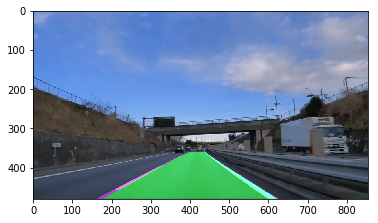

In [33]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = img_dir + 'video_output6.mp4'
video_input1 = VideoFileClip(video)#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)